# Interacting with the ARC Dataset and LLMs

This notebook provides a foundational workflow for exploring the Abstraction and Reasoning Corpus (ARC) dataset using Large Language Models (LLMs).

**Understanding ARC:**

The ARC dataset, created by François Chollet, is designed to test abstract reasoning and intelligence, moving beyond simple pattern recognition. Each ARC task challenges a system to infer an underlying transformation rule from a few examples and then apply that rule to new, unseen inputs.

**Task Structure:**

Every ARC task consists of:
*   **`train` pairs:** A small set (usually 2-5) of input/output grid examples. The goal is to *learn* the transformation rule by observing how the input grids change to become the output grids in these examples.
*   **`test` pairs:** One or more input grids (and their corresponding *unseen* solution output grids). After inferring the rule from the `train` set, the system must apply it to the `test` input grids to generate the correct `test` output grids.

**The Challenge:** The core challenge is the *abstraction* of the rule from the `train` examples and its *generalization* to the `test` inputs.

**Evaluation Rule (ARC Prize):**

For a task to be considered solved:
1.  The system must generate the correct output grid for **every single `test` input grid** within that task.
2.  Each prediction must be an *exact* match to the ground truth solution grid.
3.  If a task has multiple `test` inputs, **all** of them must be solved correctly based on the single rule inferred from the `train` set.

**This Notebook's Goal (Initial Steps):**

This part focuses on the initial setup and data handling:
1.  Setting up the environment (installing and importing libraries).
2.  Performing a basic API call test (assuming credentials are set).
3.  Loading ARC task data from JSON files.
4.  Understanding the structure of the loaded data.
5.  Providing helper functions to easily access specific parts of a task (train pairs, test inputs, test outputs).
6.  Providing visualization tools to inspect tasks.

## 1. Setup: Libraries and API Test

First, we install and import the necessary libraries. We assume you have Python and pip installed.
*   `python-dotenv`: To potentially load API keys from a `.env` file (though we won't explicitly check for the key here).
*   `litellm`: To interact with LLM APIs.
*   `numpy`: For numerical operations and grid comparisons.
*   `matplotlib`: For visualizing the ARC grids.

We'll also perform a minimal API call to ensure `litellm` is configured correctly and can reach the service. **Note:** This step assumes your API key (e.g., `OPENAI_API_KEY`) is already set as an environment variable or globally configured for `litellm`. If not set, this test call will fail.

In [1]:
# Install required packages if they aren't already installed
print("Checking/Installing required libraries...")
try:
    import litellm
    import dotenv
    import numpy
    import matplotlib
    print("Libraries found.")
except ImportError:
    print("Installing python-dotenv, litellm, numpy, matplotlib...")
    %pip install -q python-dotenv litellm numpy matplotlib
    print("Installation complete. You might need to restart the kernel.")

Checking/Installing required libraries...
Libraries found.


In [2]:
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Union # Keep typing for clarity

import numpy as np 

from dotenv import load_dotenv
import litellm
from litellm import completion

# --- Visualization Imports --- 
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline 
# --- End Visualization Imports --- 

# Attempt to load environment variables from .env file (optional)
load_dotenv()

# Reduce LiteLLM's default logging verbosity for a cleaner output
litellm.set_verbose = False

print("Libraries imported.")

Libraries imported.


## 1.1 Visualization Setup

Define the standard color map and normalization used for plotting ARC grids. Also define helper functions for displaying grids.

In [3]:
# --- ARC Visualization Constants --- 
ARC_COLORMAP = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'] # Removed white as it's usually not in tasks
)
ARC_NORM = colors.Normalize(vmin=0, vmax=9) # Adjusted vmax based on colormap

# --- Grid Visualization Function (Simplified) --- 
def show_grid(grid, title=None, figsize=None):
    """Displays a single ARC grid using matplotlib."""
    # Assume grid is List[List[int]]
    if not grid or not grid[0]: return # Handle empty grid
    if not figsize:
        # Basic dynamic sizing, no complex checks
        figsize = (len(grid[0]) * 0.5, len(grid) * 0.5) 
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(np.array(grid), cmap=ARC_COLORMAP, norm=ARC_NORM)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    if title:
        ax.set_title(title, fontsize=10)
    plt.show()

# --- Task Visualization Function (Simplified) --- 
def visualize_task(task_data, task_solutions=None, title="ARC Task"):
    """Plots a task with all train/test input-output pairs."""
    # Assumes task_data structure is {'train': [...], 'test': [...]}
    train_examples = task_data.get('train', [])
    test_examples = task_data.get('test', [])
    has_solution = task_solutions is not None # Check if solutions were provided

    num_train = len(train_examples)
    num_test = len(test_examples)
    total_cols = num_train + num_test
    if total_cols == 0: return # Nothing to plot
    
    # Basic figure sizing
    fig_width = total_cols * 2.5 
    fig_height = 5
    fig, axs = plt.subplots(2, total_cols, figsize=(fig_width, fig_height), squeeze=False)
    plt.suptitle(title, fontsize=14)

    # Plot Train Examples
    for idx, example in enumerate(train_examples):
        # Added check for valid input/output format
        if 'input' in example and isinstance(example['input'], list) and example['input']:
            axs[0, idx].imshow(np.array(example['input']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[0, idx].set_title(f"Train {idx+1} In")
        axs[0, idx].axis('off')
        if 'output' in example and isinstance(example['output'], list) and example['output']:
             axs[1, idx].imshow(np.array(example['output']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[1, idx].set_title(f"Train {idx+1} Out")
        axs[1, idx].axis('off')

    # Plot Test Examples
    for idx, example in enumerate(test_examples):
        col_idx = num_train + idx
        if 'input' in example and isinstance(example['input'], list) and example['input']:
            axs[0, col_idx].imshow(np.array(example['input']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[0, col_idx].set_title(f"Test {idx+1} In")
        axs[0, col_idx].axis('off')

        output_grid_to_show = None
        output_title = f"Test {idx+1} Out: ?"

        if has_solution and idx < len(task_solutions) and isinstance(task_solutions[idx], list) and task_solutions[idx]:
            output_grid_to_show = task_solutions[idx]
            output_title = f"Test {idx+1} Out"
        elif 'output' in example and isinstance(example['output'], list) and example['output']: # Fallback to output in test data
            output_grid_to_show = example['output']
            output_title = f"Test {idx+1} Out"
        
        if output_grid_to_show:
             axs[1, col_idx].imshow(np.array(output_grid_to_show), cmap=ARC_COLORMAP, norm=ARC_NORM)
             axs[1, col_idx].axis('off')
        else:
             axs[1, col_idx].axis('off') # Keep axis off for placeholder
        axs[1, col_idx].set_title(output_title)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout slightly for suptitle
    plt.show()

print("Visualization constants and functions defined.")

Visualization constants and functions defined.


In [4]:
# --- Minimal API Key Test --- 
print("Performing minimal API test call...")
try:
    response = completion(
        model="gpt-4o", 
        messages=[{"role": "user", "content": "Respond with just 'OK'."}],
        max_tokens=2, 
        request_timeout=20 
    )
    print("API test call successful (received a response).") 
except Exception as e:
    print(f"\033[91mAPI test call failed: {e}\033[0m")
    print("Please ensure your API key (e.g., OPENAI_API_KEY) is set correctly.")

Performing minimal API test call...
API test call successful (received a response).


## 2. Data Loading

Loads ARC tasks from JSON files.

In [149]:
# --- Type Definitions --- 
Grid = List[List[int]] 
TaskPair = Dict[str, Grid] 
TaskData = Dict[str, List[TaskPair]] 

def load_arc_tasks_simple(data_dir: str, limit: Optional[int] = None) -> Dict[str, TaskData]:
    """Loads ARC tasks from JSON files into a dictionary (simplified)."""
    arc_path = Path(data_dir)
    if not arc_path.is_dir():
        print(f"Error: ARC data directory not found: {arc_path.resolve()}")
        return {}

    json_files = sorted(list(arc_path.glob("*.json")))

    if not json_files:
        print(f"Warning: No JSON files found in {arc_path.resolve()}")
        return {}

    if limit:
        json_files = json_files[:limit]

    loaded_tasks: Dict[str, TaskData] = {}
    print(f"Processing {len(json_files)} task files from {arc_path.resolve()}...")

    for json_file in json_files:
        task_id = json_file.stem
        with open(json_file, 'r', encoding='utf-8') as f:
            task_data = json.load(f)
        loaded_tasks[task_id] = task_data 

    print(f"\nSuccessfully attempted to load {len(loaded_tasks)} tasks.")
    return loaded_tasks

# --- Load the Data --- 
# <<< UPDATE THIS PATH >>>
ARC_DATA_DIR = "../ARC-AGI/data/evaluation" # ADJUST THIS PATH!
TASK_LOAD_LIMIT = None # Load only a few tasks for faster testing

print(f"\nAttempting to load data from: {Path(ARC_DATA_DIR).resolve()}")
all_task_data: Dict[str, TaskData] = load_arc_tasks_simple(ARC_DATA_DIR, limit=TASK_LOAD_LIMIT)

if not all_task_data:
    print("\n--- CRITICAL: No tasks were loaded. Check ARC_DATA_DIR path. --- ")
else:
    print(f"\nExample Task IDs loaded: {list(all_task_data.keys())[:10]}")


Attempting to load data from: C:\Users\Lukhausen\github\Lepus\experimental\lukas\ARC-AGI\data\evaluation
Processing 120 task files from C:\Users\Lukhausen\github\Lepus\experimental\lukas\ARC-AGI\data\evaluation...

Successfully attempted to load 120 tasks.

Example Task IDs loaded: ['0934a4d8', '135a2760', '136b0064', '13e47133', '142ca369', '16b78196', '16de56c4', '1818057f', '195c6913', '1ae2feb7']


## 3. Understanding ARC Task Data Structure

Data is loaded into `all_task_data`, a dictionary mapping `task_id` (string) to `TaskData`.
`TaskData` is a dictionary, usually with keys `'train'` and `'test'`.
`'train'` and `'test'` contain lists of `TaskPair` dictionaries.
Each `TaskPair` has `'input'` and `'output'` keys, holding the grids (`Grid`, which is `List[List[int]]`).

To solve a test case, the LLM needs all `train` pairs and the specific `test` input grid.

## 4. Helper Functions for Accessing Task Components

Simple accessors for train pairs and test inputs/outputs.

In [150]:
def get_train_pairs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[TaskPair]:
    """Returns the list of training pairs for a given task ID."""
    return all_tasks[task_id]['train']

def get_test_inputs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[Grid]:
    """Returns a list of all test input grids for a given task ID."""
    return [pair['input'] for pair in all_tasks[task_id]['test']]

def get_test_outputs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[Grid]:
    """Returns a list of all test output (solution) grids for a given task ID."""
    return [pair['output'] for pair in all_tasks[task_id]['test']]

print("Helper functions defined: get_train_pairs, get_test_inputs, get_test_outputs")

Helper functions defined: get_train_pairs, get_test_inputs, get_test_outputs


### Example Usage of Helper Functions

Demonstrating the accessors.

In [151]:
if all_task_data:
    example_task_id = list(all_task_data.keys())[0] 
    print(f"--- Example data extraction for Task ID: {example_task_id} ---")

    train_pairs = get_train_pairs(example_task_id, all_task_data)
    print(f"Number of training pairs: {len(train_pairs)}")
    if train_pairs: print(f"Structure of first train pair: {train_pairs[0].keys()}") 

    test_inputs = get_test_inputs(example_task_id, all_task_data)
    print(f"\nNumber of test inputs: {len(test_inputs)}")
    if test_inputs: print(f"Type of first test input: {type(test_inputs[0])}")

    test_outputs = get_test_outputs(example_task_id, all_task_data)
    print(f"\nNumber of test outputs (solutions): {len(test_outputs)}")
    if test_outputs: print(f"Type of first test solution: {type(test_outputs[0])}")
else:
    print("\nNo task data loaded, skipping example.")

--- Example data extraction for Task ID: 0934a4d8 ---
Number of training pairs: 4
Structure of first train pair: dict_keys(['input', 'output'])

Number of test inputs: 1
Type of first test input: <class 'list'>

Number of test outputs (solutions): 1
Type of first test solution: <class 'list'>


### Example: Visualizing a Task

Using the visualization function.

--- Visualizing Task ID: 0934a4d8 ---


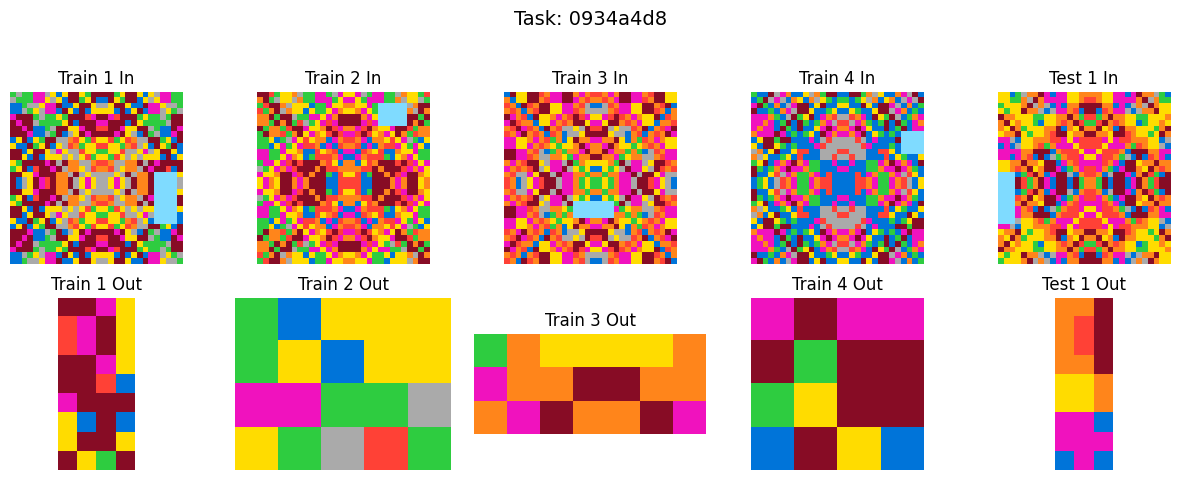

In [152]:
if all_task_data:
    example_task_id = list(all_task_data.keys())[0]
    print(f"--- Visualizing Task ID: {example_task_id} ---")
    
    task_data_to_visualize = all_task_data[example_task_id]
    ground_truth_solutions = get_test_outputs(example_task_id, all_task_data)
    
    visualize_task(task_data_to_visualize, 
                     task_solutions=ground_truth_solutions, 
                     title=f"Task: {example_task_id}")
else:
    print("\nNo task data loaded, skipping visualization example.")

## 5. Define Prompt Strategy Templates

String templates for system and user messages, using placeholders like `{train_examples_string}`.

In [153]:
# Define simple string templates for the prompts
SYSTEM_PROMPT_TEMPLATE = (
"""
You will be provided with example inputs and outputs. Analyze the train examples. These tasks follow the style of ARC (Abstraction and Reasoning Corpus) problems, where the objective is to deduce transformation rules from visual or structural patterns.

Your goal is to find common rules that are applied to the input to be transformed into the output.  
To achieve this, do the following:  
1. Find possible rules that could be applied in combination to achieve the transformation from the input to the output. Be really precise in the rule definition. What transformations have to be applied exactly? What are they based upon?  
2. Test those rules by applying them to all the available train examples and seeing if they reproduce the desired output. You have to verify that the deduced ruleset actually works with the train examples before proceeding to the test.  
If the desired output is achieved in all present examples, then apply those found rules to the given test input.  
If the ruleset you deduced fails at any of the train examples, begin again from step one and modify the rules you deduce.  
Then test again for all train examples before proceeding to the test. (Output your final solution as a JSON array in a code block)
"""
)

# Adjusted template slightly to ensure good spacing with multi-line grids
USER_PROMPT_TEMPLATE = (
    "**TRAIN EXAMPLES:**\n\n"
    "{train_examples_string}\n\n\n\n"
    "**TEST INPUT GRID:**\n\n"
    "{test_input_string}\n\n"
)

print("Prompt templates defined (SYSTEM_PROMPT_TEMPLATE, USER_PROMPT_TEMPLATE).")

Prompt templates defined (SYSTEM_PROMPT_TEMPLATE, USER_PROMPT_TEMPLATE).


## 6. Formatting Helpers and Prompt Preparation

Functions to format grids into the desired string representation (space-separated numbers, multi-line) and prepare the final LLM messages.

In [154]:
# --- Formatting Helpers (Modified for Grid String) --- 

def format_grid_to_string(grid: Grid) -> str:
    """Converts a grid (list of lists) to a multi-line string representation."""
    # Assume grid is List[List[int]]
    if not grid or not grid[0]: return "" # Handle empty grid
    return "\n".join(" ".join(map(str, row)) for row in grid)

def format_train_pairs_to_string(train_pairs: List[TaskPair]) -> str:
    """Formats a list of training pairs into a single string for the prompt (multi-line grid format)."""
    formatted_pairs = []
    for i, pair in enumerate(train_pairs):
        # Assume 'input' and 'output' keys exist
        input_str = format_grid_to_string(pair['input'])
        output_str = format_grid_to_string(pair['output'])
        # Add extra newlines for clarity between examples and between input/output
        formatted_pairs.append(f"Example {i+1} Input:\n{input_str}\n\nExample {i+1} Solution:\n{output_str}")
    # Join examples with double newlines
    return "\n\n".join(formatted_pairs)

# --- Prompt Preparation Function (No changes needed) --- 

def prepare_prompt_messages(
    system_template: str,
    user_template: str,
    train_pairs: List[TaskPair],
    test_input_grid: Grid
) -> List[Dict[str, str]]:
    """Formats data using the new formatters and inserts into prompt templates."""
    train_examples_str = format_train_pairs_to_string(train_pairs)
    test_input_str = format_grid_to_string(test_input_grid)

    final_user_prompt = user_template.format(
        train_examples_string=train_examples_str,
        test_input_string=test_input_str
    )
    
    final_system_prompt = system_template

    messages = [
        {"role": "system", "content": final_system_prompt},
        {"role": "user", "content": final_user_prompt}
    ]
    return messages

print("Formatting and prompt preparation functions defined (with grid string format).")

Formatting and prompt preparation functions defined (with grid string format).


In [155]:
# --- Sample Data for Testing Prompt Preparation --- 
sample_train_pairs: List[TaskPair] = [
    {'input': [[1, 0], [0, 0]], 'output': [[0, 1], [0, 0]]},
    {'input': [[0, 0], [2, 0]], 'output': [[0, 0], [0, 2]]}
]
sample_test_input_grid: Grid = [[0, 3], [0, 0]]

# --- Call the Preparation Function --- 
print("--- Preparing messages using sample data (Grid String Format) ---")
prepared_messages = prepare_prompt_messages(
    system_template=SYSTEM_PROMPT_TEMPLATE,
    user_template=USER_PROMPT_TEMPLATE,
    train_pairs=sample_train_pairs,
    test_input_grid=sample_test_input_grid
)

# --- Print the Result --- 
print("\nResulting 'messages' list (ready for LLM API):")
print(json.dumps(prepared_messages, indent=2))

# --- Print the formatted User prompt content for clarity ---
print("\n--- Content of the 'user' message: ---")
print(prepared_messages[1]['content'])
print("--------------------------------------")

--- Preparing messages using sample data (Grid String Format) ---

Resulting 'messages' list (ready for LLM API):
[
  {
    "role": "system",
    "content": "\nYou will be provided with example inputs and outputs. Analyze the train examples. These tasks follow the style of ARC (Abstraction and Reasoning Corpus) problems, where the objective is to deduce transformation rules from visual or structural patterns.\n\nYour goal is to find common rules that are applied to the input to be transformed into the output.  \nTo achieve this, do the following:  \n1. Find possible rules that could be applied in combination to achieve the transformation from the input to the output. Be really precise in the rule definition. What transformations have to be applied exactly? What are they based upon?  \n2. Test those rules by applying them to all the available train examples and seeing if they reproduce the desired output. You have to verify that the deduced ruleset actually works with the train examples

## 7. Get LLM Response (Simple)

Sends messages to the LLM and returns the raw response content.

In [156]:
def get_llm_response(messages: List[Dict[str, str]], model_name: str) -> Optional[str]:
    """Sends messages to the LLM and returns the raw response content."""
    # print(f"Sending request to model: {model_name}...") # Reduced verbosity
    try:
        response = completion(
            model=model_name,
            messages=messages,
            request_timeout=180,
            num_retries = 3
        )
        response_content = response.choices[0].message.content
        # print("Response received.") # Reduced verbosity
        return response_content
    except Exception as e:
        print(f"\033[91mLLM API call failed: {e}\033[0m")
        return None 

print("LLM interaction function 'get_llm_response' defined.")

LLM interaction function 'get_llm_response' defined.


## 7.1 LLM Response Parser

Extracts the JSON grid from the LLM response (still expects JSON output from LLM).

In [157]:
import re # Import the regular expression module

def parse_llm_response_for_grid(response_content: Optional[str]) -> Optional[Grid]:
    """Attempts to find and parse a JSON grid array from the LLM response."""
    if not response_content or not isinstance(response_content, str):
        return None

    response_text = response_content.strip()
    
    # Prioritize ```json [...] ``` blocks
    json_block_match = re.search(r"```json\s*(\[.*?\])\s*```", response_text, re.DOTALL)
    potential_json_str = None
    if json_block_match:
        potential_json_str = json_block_match.group(1).strip()
    else:
        # Fallback to plain ``` [...] ``` blocks
        code_block_match = re.search(r"```\s*(\[.*?\])\s*```", response_text, re.DOTALL)
        if code_block_match:
            potential_json_str = code_block_match.group(1).strip()
        else:
            # Fallback: Find the first plausible JSON array `[[...]]` anywhere
            first_bracket_match = re.search(r"(\[\s*\[.*?\]\s*\])", response_text, re.DOTALL)
            if first_bracket_match:
                 potential_json_str = first_bracket_match.group(1).strip()

    if not potential_json_str:
        return None

    # Attempt to parse the extracted string
    try:
        parsed_grid = json.loads(potential_json_str)
    except json.JSONDecodeError:
        return None

    # Basic Validation: Is it a list of lists?
    if not isinstance(parsed_grid, list):
        return None
    if not all(isinstance(row, list) for row in parsed_grid):
         return None

    return parsed_grid

print("LLM response parsing function 'parse_llm_response_for_grid' defined.")

LLM response parsing function 'parse_llm_response_for_grid' defined.


## 8. Example: Run Strategy and Compare Output

Run the process for a single test case: prepare prompt (with grid strings), call LLM, parse response (expecting JSON), compare, visualize.


--- Messages Sent to LLM --- 
System Message:

You will be provided with example inputs and outputs. Analyze the train examples. These tasks follow the style of ARC (Abstraction and Reasoning Corpus) problems, where the objective is to deduce transformation rules from visual or structural patterns.

Your goal is to find common rules that are applied to the input to be transformed into the output.  
To achieve this, do the following:  
1. Find possible rules that could be applied in combination to achieve the transformation from the input to the output. Be really precise in the rule definition. What transformations have to be applied exactly? What are they based upon?  
2. Test those rules by applying them to all the available train examples and seeing if they reproduce the desired output. You have to verify that the deduced ruleset actually works with the train examples before proceeding to the test.  
If the desired output is achieved in all present examples, then apply those found r

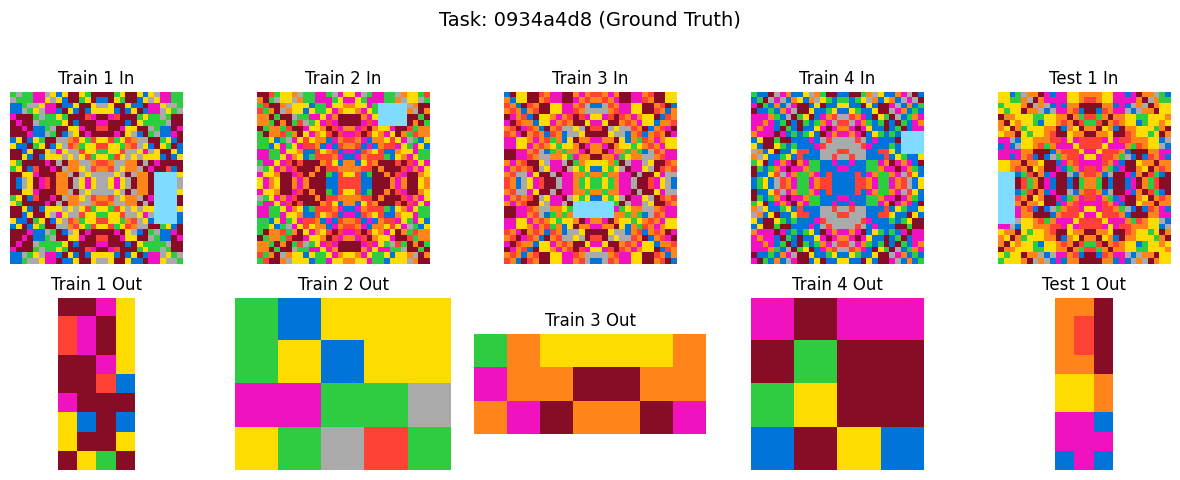


LLM Prediction Visualization (Test 0):


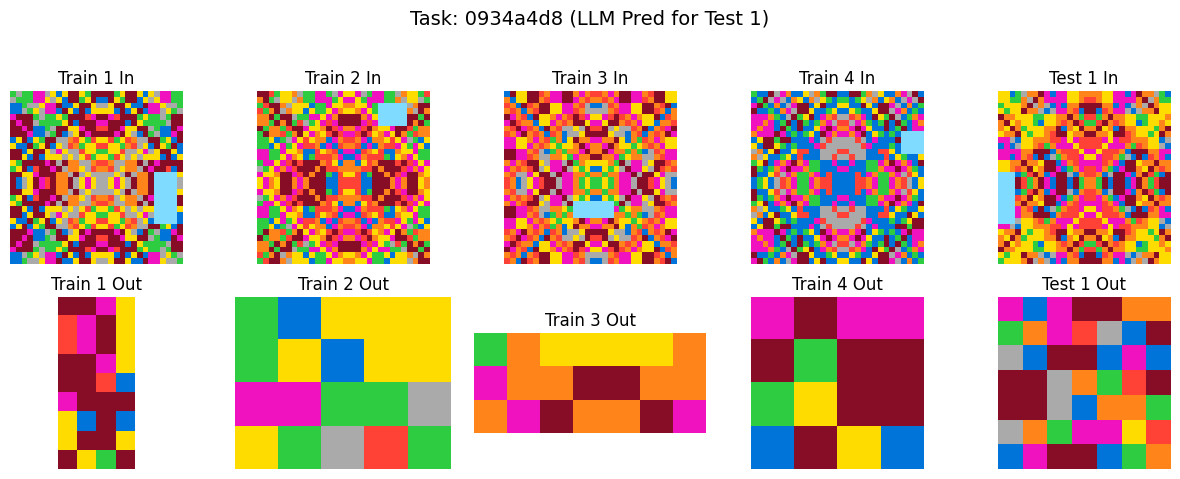

In [158]:
# CELL 8 Code

import copy # Needed for deepcopy

# --- Function to process and evaluate a single test case ---
def run_and_evaluate_single_test_case(
    task_id: str,
    test_index: int,
    all_tasks: Dict[str, TaskData],
    model_name: str,
    system_prompt: str,
    user_prompt_template: str,
    print_details: bool = True # Control printing during execution
) -> Optional[Dict]:
    """
    Runs the LLM solving process for a single test case, optionally prints details,
    and returns a detailed result summary including failure reasons.
    Does NOT visualize. Returns data needed for external visualization.
    """
    # Basic check if task exists
    if task_id not in all_tasks:
        if print_details: print(f"\033[91mError: Task ID '{task_id}' not found.\033[0m")
        return None

    # Initialize results
    parsed_predicted_grid = None
    raw_llm_response = None
    is_correct = False
    api_or_parse_failed = True # Assume critical failure initially
    failure_reason = "Task Data Error"
    task_data_dict = None
    ground_truth_output_single = None
    messages = None # Initialize messages

    # 1. Get Task Data Components
    try:
        task_data_dict = all_tasks[task_id]
        train_pairs = get_train_pairs(task_id, all_tasks)
        test_inputs = get_test_inputs(task_id, all_tasks)
        test_outputs_truth = get_test_outputs(task_id, all_tasks) # List of all ground truths
    except Exception as e:
         if print_details: print(f"\033[91mError accessing task data for '{task_id}': {e}.\033[0m")
         return { # Return minimal failure info
            "task_id": task_id, "test_index": test_index, "predicted_grid": None,
            "ground_truth": None, "is_correct": False, "api_or_parse_failed": True,
            "failure_reason": failure_reason, "raw_response": None, "task_data_dict": None,
            "messages": None
        }

    # Check if the test case index is valid
    if test_index >= len(test_inputs) or test_index >= len(test_outputs_truth):
        failure_reason = f"Invalid Test Index ({test_index}/{len(test_inputs)})"
        if print_details: print(f"\033[91mError: {failure_reason} for task '{task_id}'.\033[0m")
        api_or_parse_failed = True
        is_correct = False
    else:
        target_test_input = test_inputs[test_index]
        ground_truth_output_single = test_outputs_truth[test_index]
        failure_reason = None # Reset failure reason

        # 2. Prepare Prompt Messages
        messages = prepare_prompt_messages(
            system_template=system_prompt,
            user_template=user_prompt_template,
            train_pairs=train_pairs,
            test_input_grid=target_test_input
        )

        if print_details:
            print("\n--- Messages Sent to LLM --- ")
            print("System Message:")
            print(messages[0]['content'])
            print("\nUser Message:")
            print(messages[1]['content'])
            print("---------------------------")

        # 3. Get LLM Response
        if print_details: print(f"\nSending request to model: {model_name}...")
        raw_llm_response = get_llm_response(messages, model_name)

        if raw_llm_response is None:
            failure_reason = "No LLM Response"
            api_or_parse_failed = True
            is_correct = False
            if print_details: print(f"\033[91mFailure: {failure_reason}\033[0m")
        else:
            if print_details: print("Response received.")
            # 4. Parse the LLM Response
            if print_details: print("\n--- Parsing LLM Response ---")
            parsed_predicted_grid = parse_llm_response_for_grid(raw_llm_response)

            if parsed_predicted_grid is None:
                failure_reason = "Parsing Failed"
                api_or_parse_failed = True
                is_correct = False
                if print_details: print(f"\033[91mFailure: {failure_reason}\033[0m")
            else:
                 api_or_parse_failed = False # Got a grid
                 if print_details: print("Parsing Succeeded.")

                 # 6. Compare parsed grid with ground truth
                 try:
                     np_predicted = np.array(parsed_predicted_grid)
                     np_truth = np.array(ground_truth_output_single)
                     if np_predicted.shape != np_truth.shape:
                          failure_reason = f"Shape Mismatch ({np_predicted.shape} vs {np_truth.shape})"
                          is_correct = False
                          if print_details: print(f"\n\033[91mFailure: {failure_reason}\033[0m")
                     elif not np.array_equal(np_predicted, np_truth):
                          failure_reason = "Content Mismatch"
                          is_correct = False
                          if print_details: print(f"\n\033[91mFailure: {failure_reason}\033[0m")
                     else:
                          failure_reason = None # Success
                          is_correct = True
                          if print_details: print("\n\033[92mMatch: Prediction matches ground truth!\\033[0m")
                 except ValueError as e:
                      failure_reason = "Comparison Error"
                      api_or_parse_failed = True # Treat comparison error as critical
                      is_correct = False
                      if print_details: print(f"\n\033[91mFailure: {failure_reason}: {e}\033[0m")

    # --- Return results ---
    # Ground truth might be None if index was invalid
    gt_output = ground_truth_output_single

    return {
        "task_id": task_id,
        "test_index": test_index,
        "predicted_grid": parsed_predicted_grid,
        "ground_truth": gt_output,
        "is_correct": is_correct,
        "api_or_parse_failed": api_or_parse_failed,
        "failure_reason": failure_reason,
        "raw_response": raw_llm_response,
        "task_data_dict": task_data_dict, # Needed for visualization
        "messages": messages # Optionally return messages for debugging
    }


# --- Configuration and Test Execution for Cell 8 ---
EXAMPLE_TASK_ID_CELL8 = '0934a4d8'
TEST_CASE_INDEX_CELL8 = 0
MODEL_NAME_CELL8 = 'gpt-4o'

if all_task_data:
     # Call the function to run the example WITH printing details
     result_summary_cell8 = run_and_evaluate_single_test_case(
         task_id=EXAMPLE_TASK_ID_CELL8,
         test_index=TEST_CASE_INDEX_CELL8,
         all_tasks=all_task_data,
         model_name=MODEL_NAME_CELL8,
         system_prompt=SYSTEM_PROMPT_TEMPLATE,
         user_prompt_template=USER_PROMPT_TEMPLATE,
         print_details=True # Enable printing for single test
     )

     print("\n--- Cell 8 Function Execution Summary ---")
     if result_summary_cell8:
         print(f"Task ID: {result_summary_cell8['task_id']}")
         print(f"Test Index: {result_summary_cell8['test_index']}")
         print(f"API/Parse/Compare Failed Critically: {result_summary_cell8['api_or_parse_failed']}")
         print(f"Prediction Correct: {result_summary_cell8['is_correct']}")
         print(f"Failure Reason: {result_summary_cell8['failure_reason']}")

         # Print full LLM response BEFORE visualization
         print("\n--- Cell 8 Raw LLM Response ---")
         print(f"```\n{result_summary_cell8['raw_response']}\n```" if result_summary_cell8['raw_response'] else "Raw LLM Response: None")

         # Visualize AFTER function call and printing response
         print("\n--- Cell 8 Visualization ---")
         if result_summary_cell8['task_data_dict'] and result_summary_cell8['ground_truth'] is not None:
              task_outputs_truth_cell8 = get_test_outputs(result_summary_cell8['task_id'], all_task_data)
              print(f"\nGround Truth Visualization:")
              visualize_task(result_summary_cell8['task_data_dict'],
                             task_solutions=task_outputs_truth_cell8,
                             title=f"Task: {result_summary_cell8['task_id']} (Ground Truth)")

              # Visualize prediction or print failure reason
              if result_summary_cell8['predicted_grid'] is not None:
                   print(f"\nLLM Prediction Visualization (Test {result_summary_cell8['test_index']}):")
                   solutions_llm_viz_cell8 = copy.deepcopy(task_outputs_truth_cell8)
                   # Ensure index is valid before assignment (should be due to checks in function)
                   if result_summary_cell8['test_index'] < len(solutions_llm_viz_cell8):
                       solutions_llm_viz_cell8[result_summary_cell8['test_index']] = result_summary_cell8['predicted_grid']
                   visualize_task(result_summary_cell8['task_data_dict'],
                                  task_solutions=solutions_llm_viz_cell8,
                                  title=f"Task: {result_summary_cell8['task_id']} (LLM Pred for Test {result_summary_cell8['test_index']+1})")
              else:
                   print(f"\nLLM Prediction Visualization skipped. Reason: {result_summary_cell8['failure_reason']}")
         else:
              print("\nVisualization skipped (Task data or ground truth missing/invalid index).")

     else:
         print("Function execution failed or returned None.")
else:
     print("\nNo task data loaded, skipping function test.")

## 9. Benchmark: Run All Loaded Tasks

Runs the LLM solver on all loaded tasks concurrently. Uses the grid string format for input.


--- Starting Benchmark ---
Model: gpt-4o
Max Concurrent Requests: 50
Tasks to process: 120
Total test cases to process: 172
Progress: 172/172 test cases completed.
Progress: 172/172 test cases completed.
Benchmark finished in 153.63 seconds.

--- Benchmark Final Summary ---
Tasks Attempted: 120
Total Test Cases Processed: 172
Test Cases Correctly Solved: 0
Test Cases Failed (API/Parse/Compare Error): 24
Test Cases Incorrect (Shape/Content Mismatch): 148

Test Case Success Rate (Correct / Successfully Processed): 0.00%
Overall Test Case Accuracy (Correct / Total): 0.00%

Tasks Solved (All Test Cases Correct & Processed): 0
Task Success Rate: 0.00%

Failure Reason Distribution:
- Comparison Error: 9
- Content Mismatch: 79
- Parsing Failed: 15
- Shape Mismatch ((10, 10) vs (13, 13)): 1
- Shape Mismatch ((10, 8) vs (15, 15)): 1
- Shape Mismatch ((10, 8) vs (20, 8)): 1
- Shape Mismatch ((11, 11) vs (14, 11)): 1
- Shape Mismatch ((11, 11) vs (5, 23)): 1
- Shape Mismatch ((11, 7) vs (19, 7))

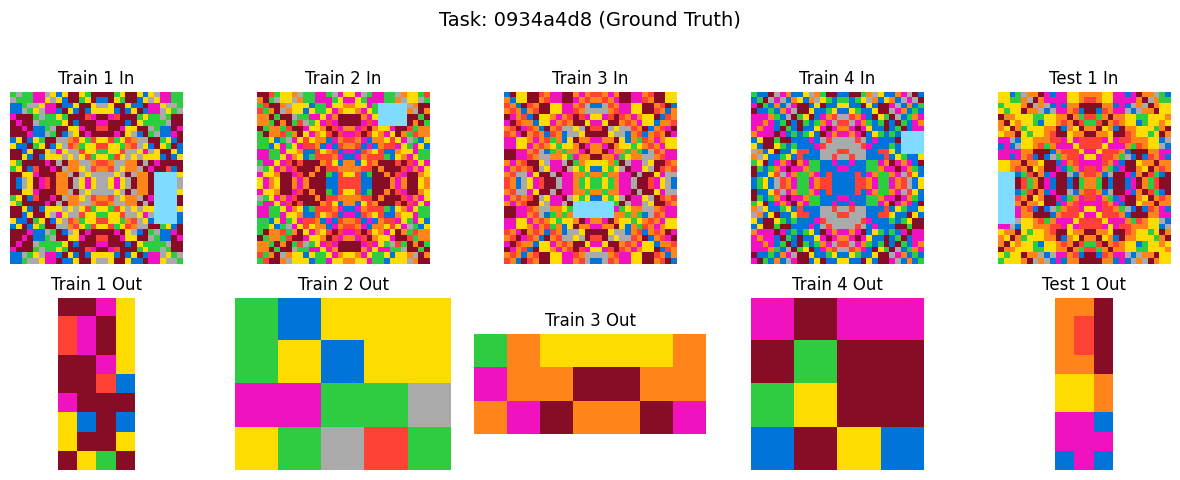


--- LLM Prediction (Task: 0934a4d8 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 135a2760 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we need to analyze the input and output examples to deduce a rule that transforms the input array into the output array. Let's break down the two examples provided:

**Example 1:**
- Input:
  ```
  3 3 3 3 3 3 3 3 3 3 3 3 3
  3 2 2 2 2 2 2 2 2 2 2 2 3
  3 2 1 3 1 3 1 3 3 3 1 2 3
  3 2 2 2 2 2 2 2 2 2 2 2 3
  3 3 3 3 3 3 3 3 3 3 3 3 3
  ```
  
- Output:
  ```
  3 3 3 3 3 3 3 3 3 3 3 3 3
  3 2 2 2 2 2 2 2 2 2 2 2 3
  3 2 1 3 1 3 1 3 1 3 1 2 3
  3 2 2 2 2 2 2 2 2 2 2 2 3
  3 3 3 3 3 3 3 3 3 3 3 3 3
  ```
  
Notice that the pattern in the third row of the input is `1 3 1 3 1 ...` and it continues with a `3`. In the output, this pattern continues as `1 3 1 3 1 3 1 ...` without interruption. Therefore, every time there is a `3` followed by a series of `1`s and `3`s, we skip the extra `3` 

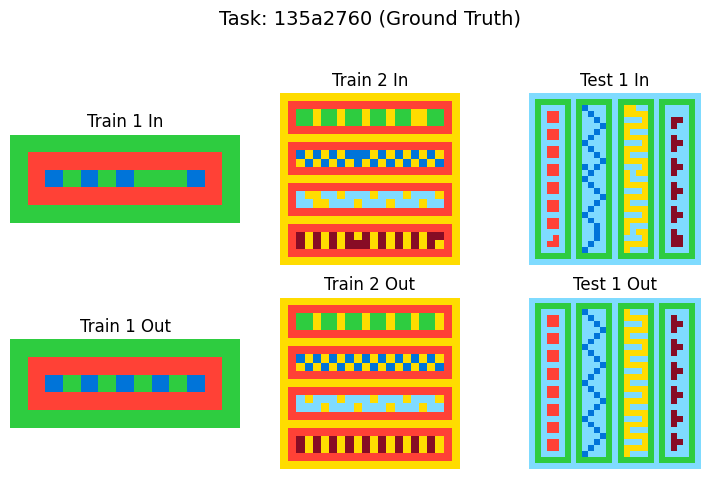


--- LLM Prediction Visualization (Task: 135a2760 / Test: 0) ---


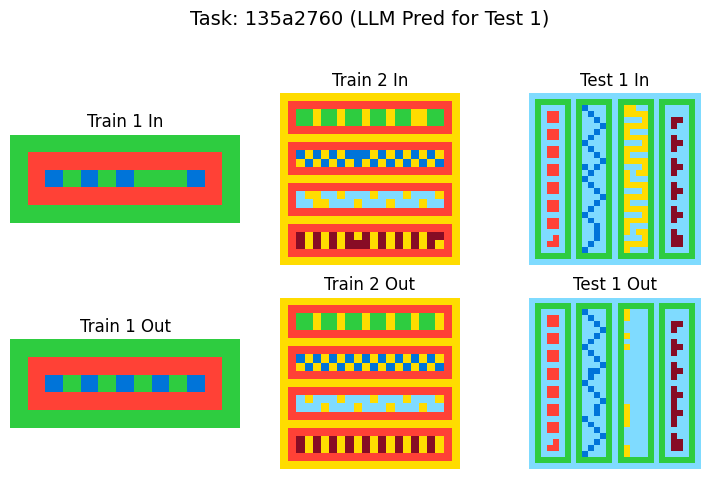

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 136b0064 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify a pattern or set of transformation rules that map each input grid to its corresponding output grid in the training examples.

1. **Observations:**
   - We have inputs of dimensions larger than the outputs. The input grids have multiple patterns repeated. 
   - The outputs seem to be subsets of the input grid.
   - Each input grid appears to contain columns that need to be extracted and arranged in a particular order to form the output grid.

2. **Pattern Analysis:**
   - **Output Structure:** The output grid always has a size of 11 rows and 7 columns.
   - **Extraction Process:**
     - We identify columns in the input grid that need to be drawn out and rearranged into the output grid.
     - In each input, the sequences of interest in output seem to be dictated by recurrent patterns like `5`, surrounded by oth

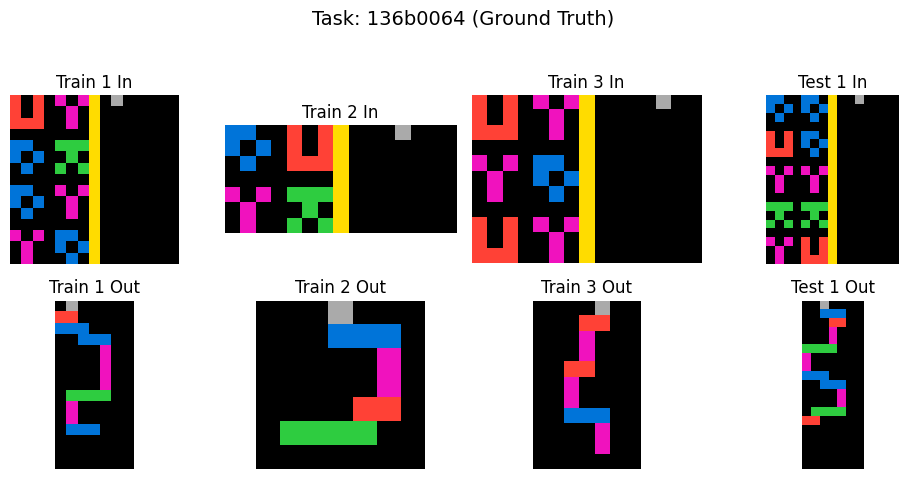


--- LLM Prediction Visualization (Task: 136b0064 / Test: 0) ---


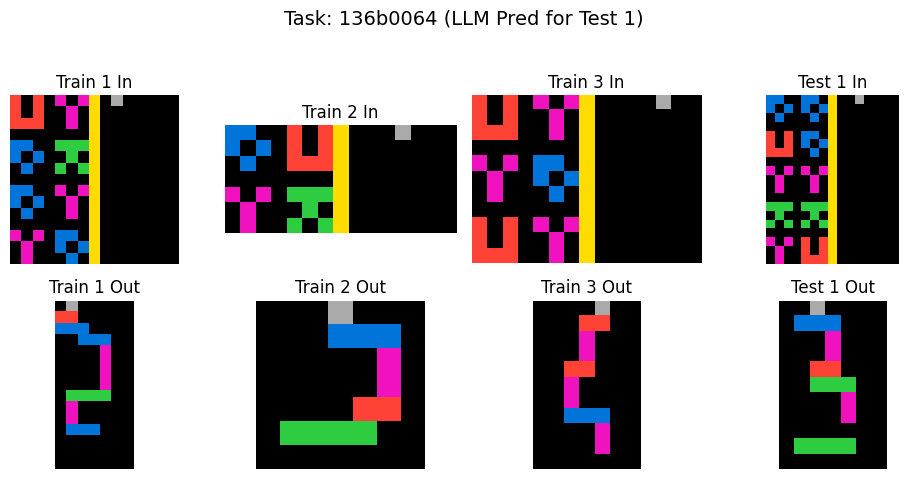

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((11, 7) vs (19, 7)))


===== Task: 13e47133 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to discern transformation rules based on given examples. Analyzing the train examples, there are specific patterns to address:

1. **Main Block Identification**:
   - Each example contains a 'main vertical line of 2's' followed by different sections of numbers. The numbers to the right of the '2' line are transformed.

2. **Tile Replacements**:
   - In each example, you can identify contiguous numbers to the right of the '2' line which correspond to numbers in a row and are transformed into blocks or patterns in the solution.
   - The vertical '2's remain as they are unless they are contiguous as a block, then in the output, the numbers become uniform.

3. **Example Patterns**:
   - The rows with all 1s, vertical 2s, and bordered numbers transform into sections of uniform numbers, indicating sections or 

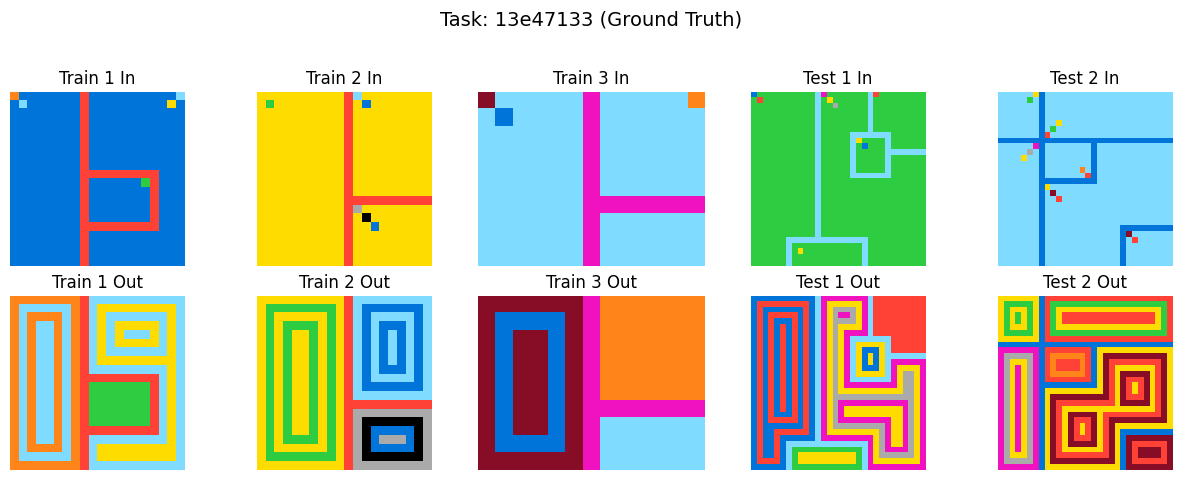


--- LLM Prediction Visualization (Task: 13e47133 / Test: 0) ---


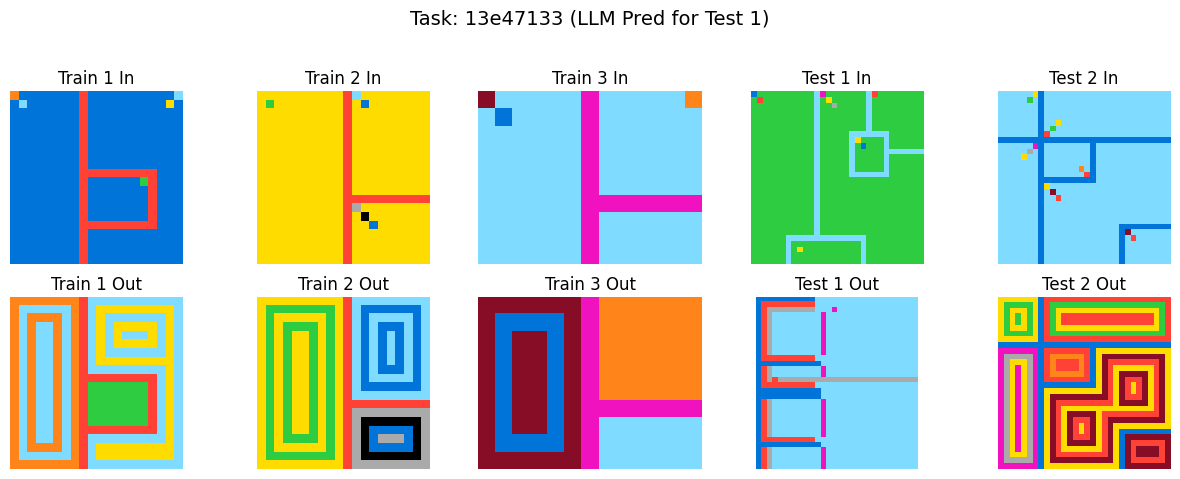

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((32, 30) vs (30, 30)))


===== Task: 13e47133 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the provided problem, let's analyze the transformation rules for the given training examples.

**Observations from Train Examples:**

1. **Structure Analysis:**
   - All inputs have a specific structure where a vertical sequence of `1` values appears in the eighth column.
   - Outputs significantly change the `1` values, particularly in the columns to the right of these, into structured segments that become different numbers (`8`, `4`, or lower numbers).

2. **Pattern Deductions and Rules:**
   - The vertical line of `1`s (eighth column) in each row dictates a distinct pattern.
   - Numbers preceding and succeeding this column often follow an alternating pattern based on their proximity to the sequence of `1`s.
   - Some numbers (e.g., `6`, `2`, `3`, from other columns) are transformed into a uniform value or expand into ad

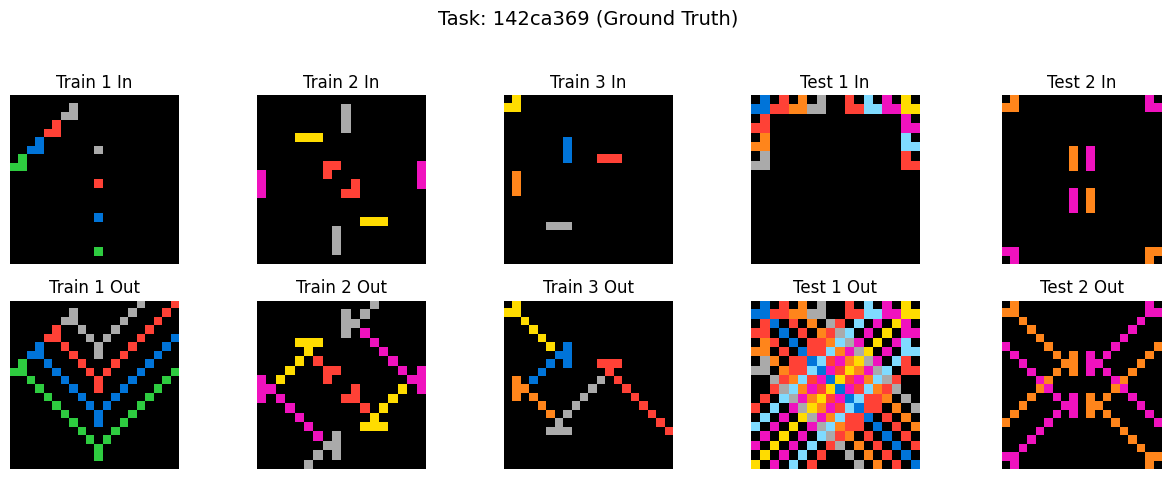


--- LLM Prediction Visualization (Task: 142ca369 / Test: 0) ---


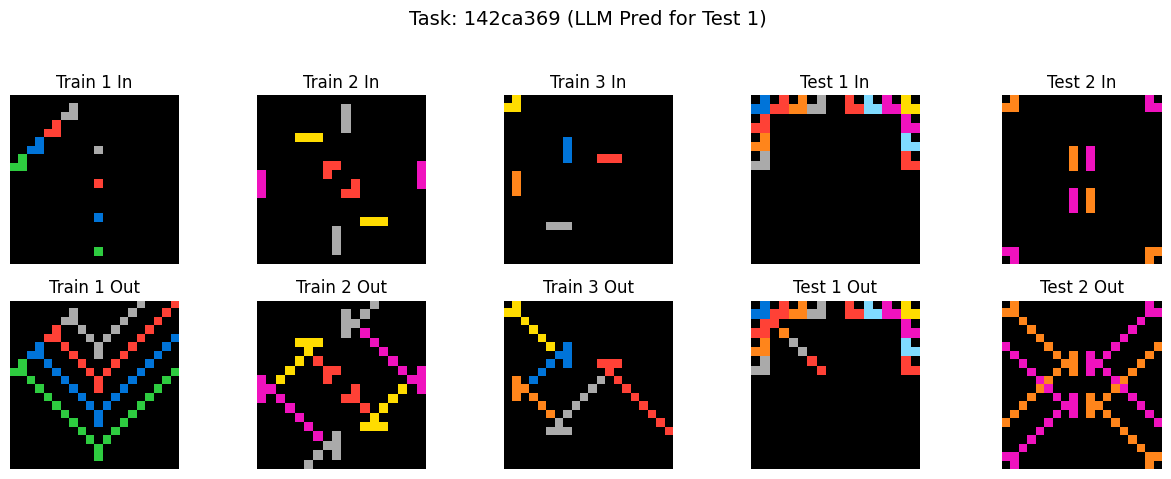

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 142ca369 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, we need to identify the transformation rules applied to the input grids to achieve the output grids. Let's first analyze the given examples to derive a set of rules.

### Observations:

1. **Pattern Rotation (or shifting):**
   - In all examples, it appears that colored blocks are being shifted diagonally within a bounding area to form a rotated or mirrored pattern.

2. **Color Preservation and Movement:**
   - The colors from the input are retained in the output, but their positions are rearranged diagonally.
   - Any sequence of numbers that appear in a line in the input seems to rotate around a center, forming a symmetric pattern.

3. **Center of Rotation/Reflection:**
   - The outputs indicate that patterns rotate around the center of the blocks they originally form.
   - In the test input, this involves moving numbers diagonally

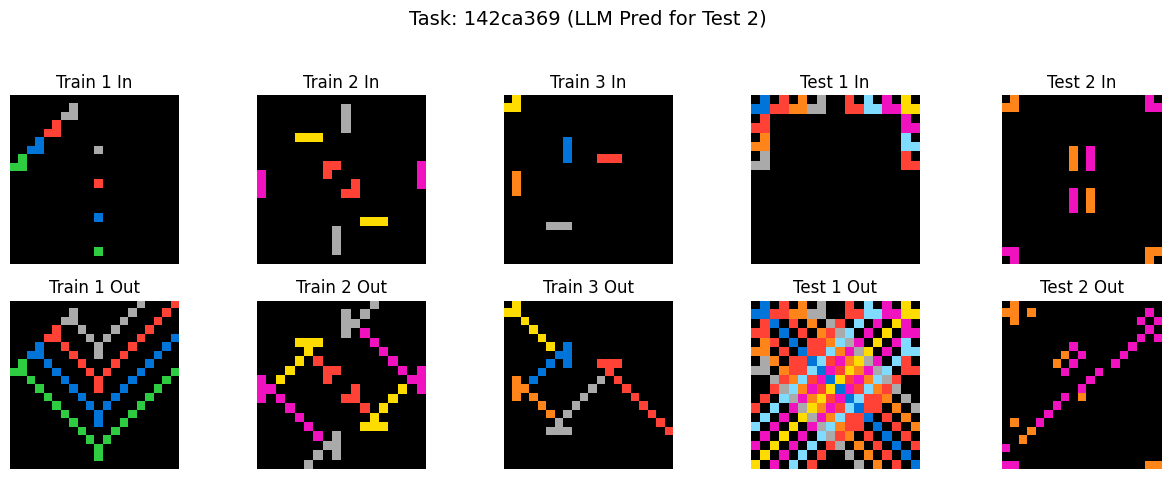

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 16b78196 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules by analyzing the train examples, here’s a step-by-step breakdown of the transformation from input to output:

1. **Identify the position of blocks:**
   - The input grids contain numbered blocks (like 1, 2, 3, 4, etc.) and these blocks are surrounded by zeros (representing empty spaces).
   - The transformation observable in the outputs involves changing sequences of numbered blocks based on certain neighborhoods around each block.
   
2. **Understand transformation behavior:**
   - Certain colors/values are moved to designate specific areas of the grid.
   - For instance, we see transformations at the boundaries or internal areas of the cluster, indicating that blocks are adjusted based upon their neighboring blocks.
   - Connections might be established using neighboring or surrounding values.

3. **Transformation St

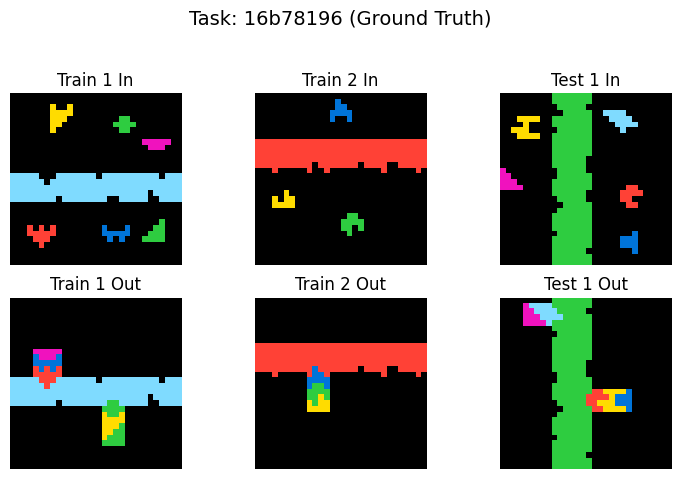


--- LLM Prediction Visualization (Task: 16b78196 / Test: 0) ---


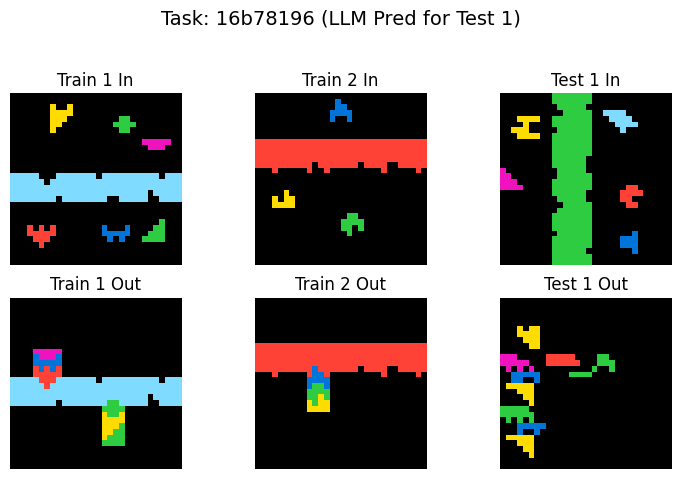

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 16de56c4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To determine the transformation rules applied to convert the inputs into the outputs, let's analyze the given examples and identify the recurring patterns.

### Observations:
1. **Number Row Duplication and Extension**:
    - In each example, specific non-zero numbers from certain rows are duplicated and extended across the row.
    - The first non-zero number in each row within the input appears to dictate the entire row transformation in the output. 
    - This number is repeated across the row from its original start position until it reaches the end of the row.

2. **Direct Transformation**:
    - Numbers not part of the number row duplication follow the direct transformation from input to output.

### Consolidated Rule:
- **For each row of the input grid**:
  - Identify the first non-zero number in the row.
  - If such a number exists, propagate th

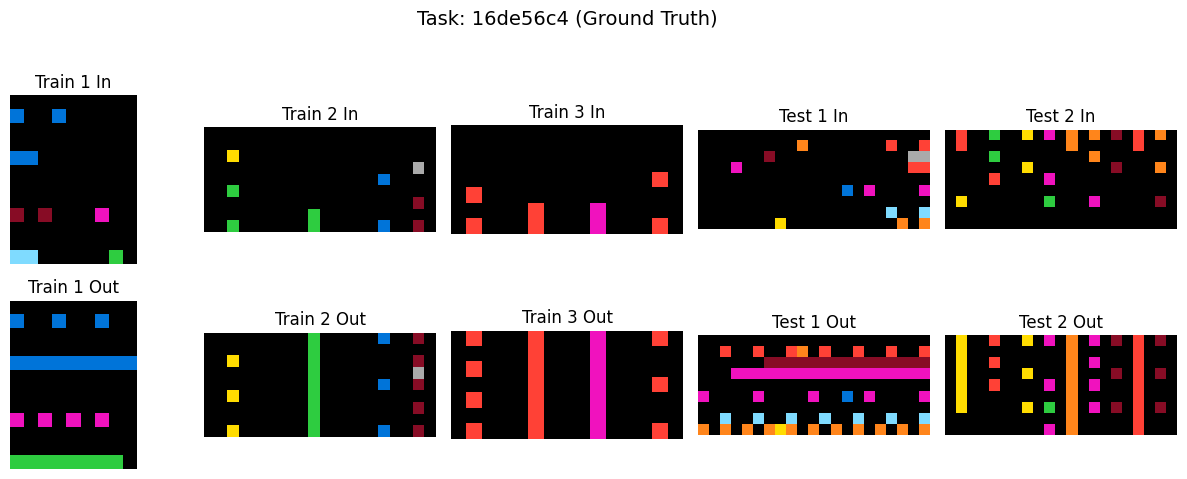


--- LLM Prediction Visualization (Task: 16de56c4 / Test: 0) ---


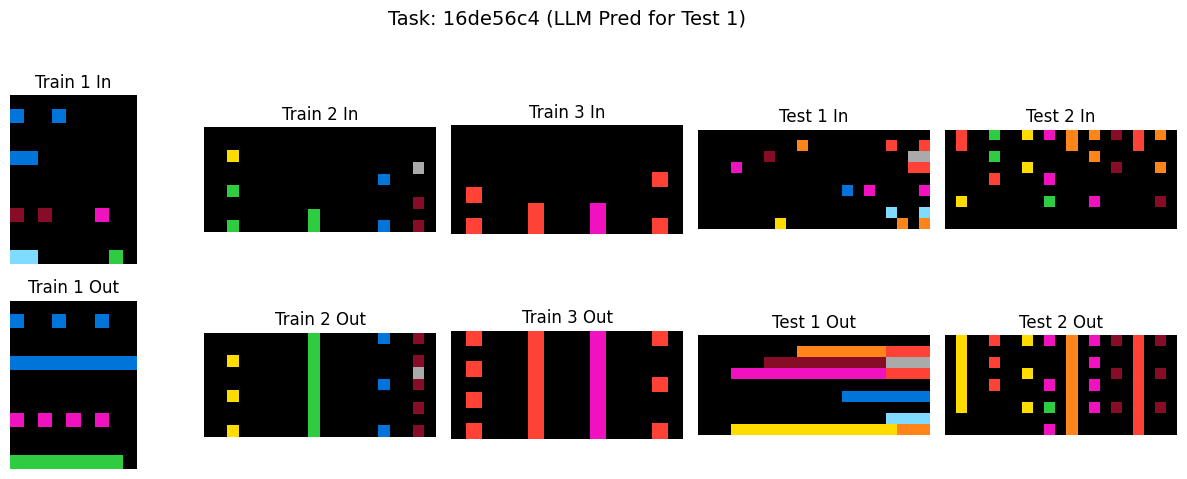

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 16de56c4 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given problem, let's break down the transformation rules based on the provided examples:

### Transformation Rules:

1. **Identify Rows with Numbers**: Identify all the rows that contain non-zero numbers, where the numbers are potentially unique in context to the transformation rules.

2. **Horizontal Expansion**: For each non-zero number in a row, replicate that number to cover specific columns within its row:
   - If a number `x` is found in a specific column `(c, r)` (column `c`, row `r`), replicate `x` horizontally across all the columns of that row (from left to right), replacing all `0`s in that row with `x`.

3. **Maintain Other Elements**: All zeros not included in rows with unique numbers remain zeros.

4. **Expand Rows**: Once all numbers are horizontally expanded, ensure that no other transformation occurs (i.e., maintain existin

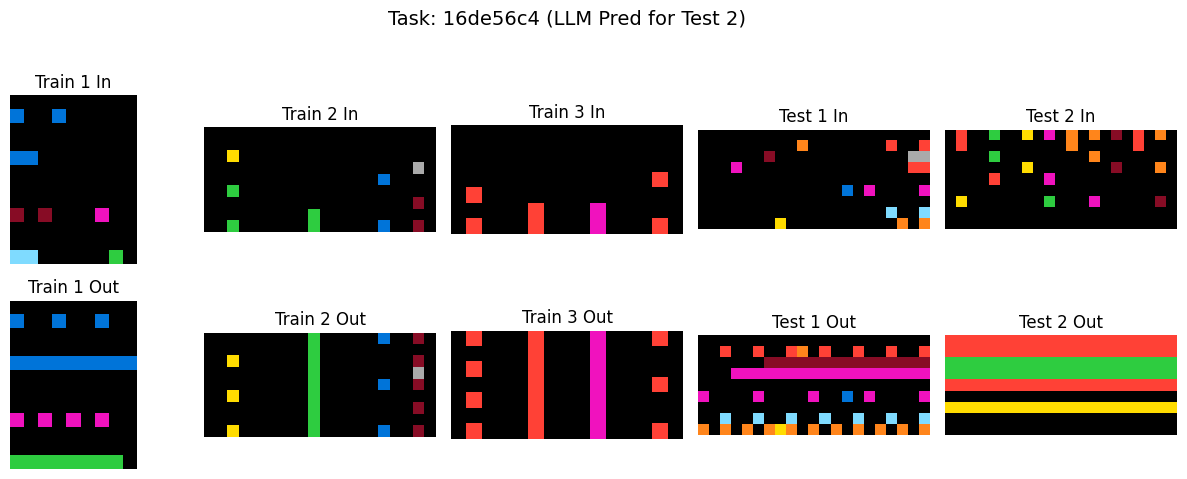

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 1818057f / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we'll first identify the transformation rules applied to the input examples to generate the output solutions. 

### Observations:
1. The input is a grid of numbers primarily consisting of '2', '4'.
2. The output also consists of the same numbers, but occasionally, '4's are transformed into '8's.
3. This transformation seems to primarily occur in contiguous rows of three or more '4's or as part of larger blocks of '4's.

### Transformation Rule:
- Identify a block of adjoining '4's. 
- If a row contains three or more consecutive '4's, transform three consecutive '4's into '8's.
- If '4's form a larger block (larger than three), central '4's in those blocks are transformed into '8'. 
- Transformations prioritize converting linear rows/columns first before converting within larger blocks.

### Applying Transformation to Test Example:

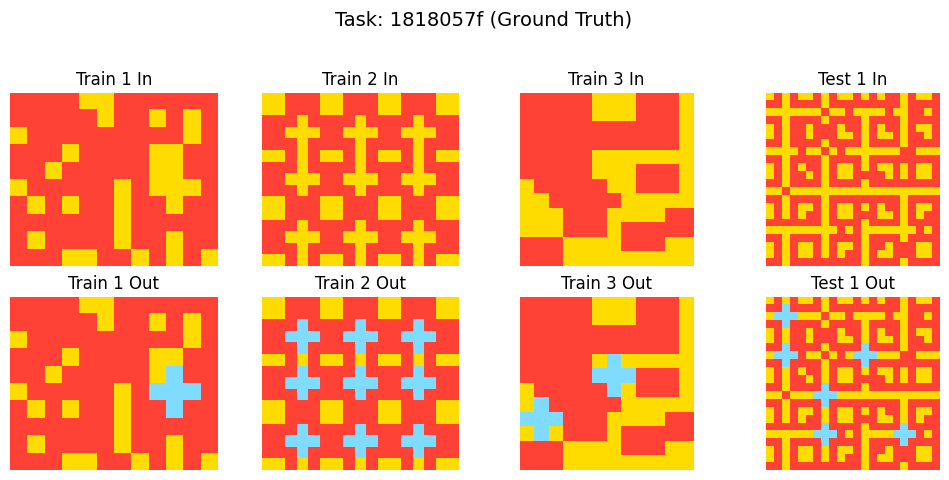


--- LLM Prediction Visualization (Task: 1818057f / Test: 0) ---


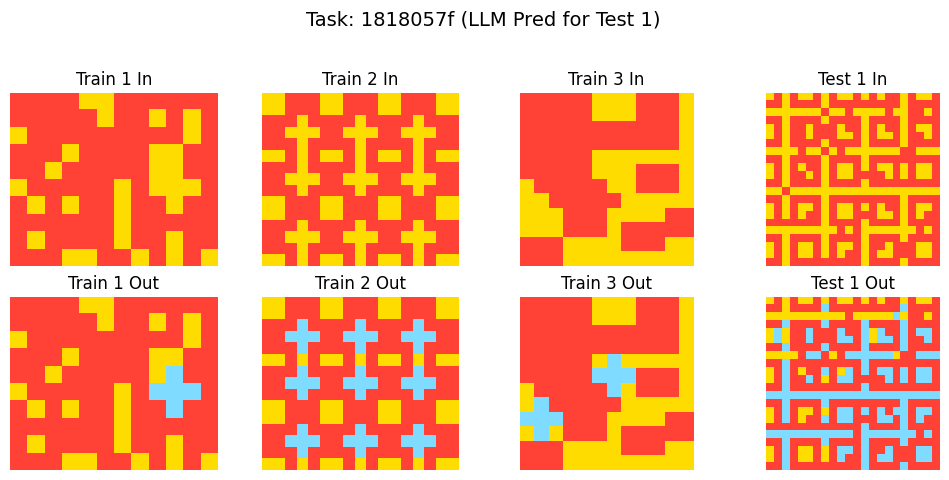

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 195c6913 / Test Case: 0 =====

--- Raw LLM Response ---
```
Based on the given examples, each transformation of the input matrix to the output matrix involves distinct steps that seem to be patterns applied to certain regions or values within the grid. Let's deduce the rules from the provided examples:

1. **Identified Patterns:**
    - **Example 1:**
      - The outermost layer of 3's remains unchanged, but various positions inside are modified.
      - Blocks of "2 2 3 8 8" or "3 8 8" patterns are replaced by new numbers such as "2", "8", or "4".

    - **Example 2:**
      - The pattern of numbers includes patches of 8's in the input, which are replaced with patches of 1, 2, 4, etc.
      - It's crucial that these transformations obey specific patterns of replacement that appear to be somewhat consistent, possibly linked to a positional rule or region-focused rules within the grid.

    - **Example 3:**
     

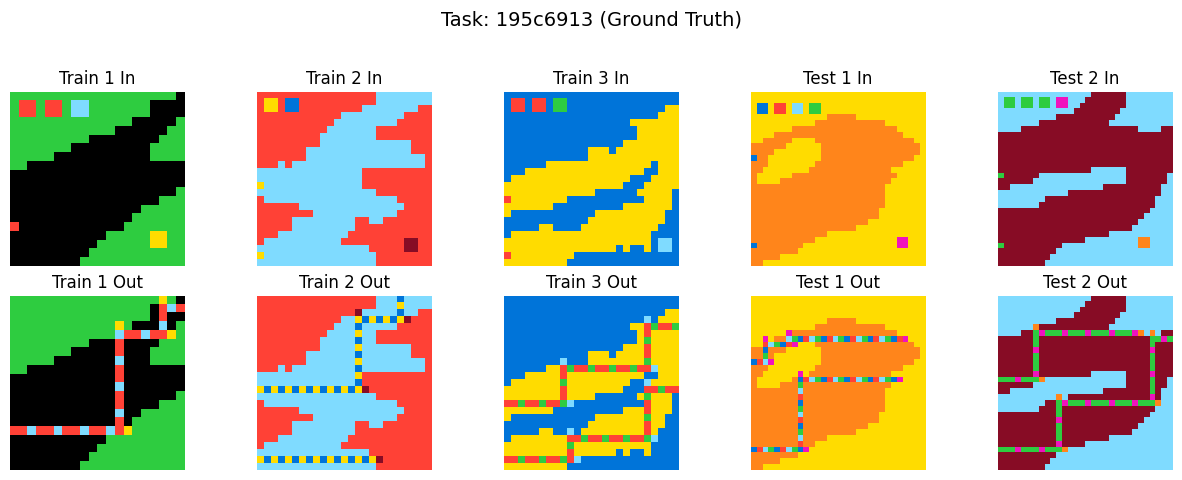


--- LLM Prediction Visualization (Task: 195c6913 / Test: 0) ---


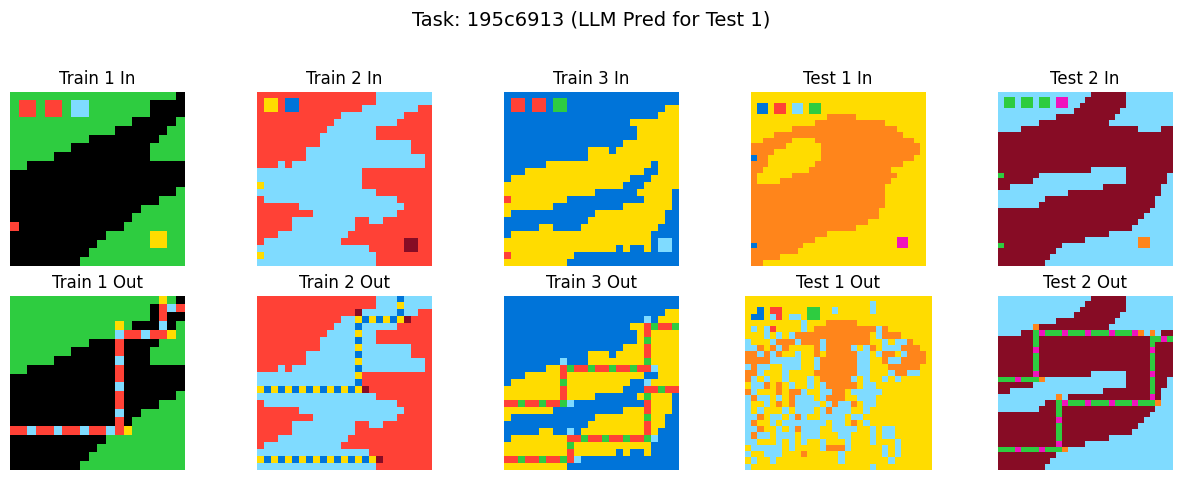

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((28, 30) vs (30, 30)))


===== Task: 195c6913 / Test Case: 1 =====

--- Raw LLM Response ---
```
To deduce the transformation rules from the given examples, let's analyze each example:

### Example 1 Analysis:
**Input Grid:**   
- Features a corner with high values (3 and 2), and zeros forming the opposite corner of a large L-shape.  
- Two "8" values are within the grid at specific repeating positions.

**Output Grid:**   
- The main upper corner pattern of "3" appears to be transformed slightly at specific points (middle sector of the diagonal with 2s and 8s).
- Zeros at the bottom of the L-shape have some values added on top and shifted around, creating patterns.

### Transformation Observations:
1. The L-shaped pattern in the input is maintained but manipulated by adding some new elements and shifting a few existing elements.
2. New blocks of non-zero values are added in reverse or rotated positions of existing patterns.

#

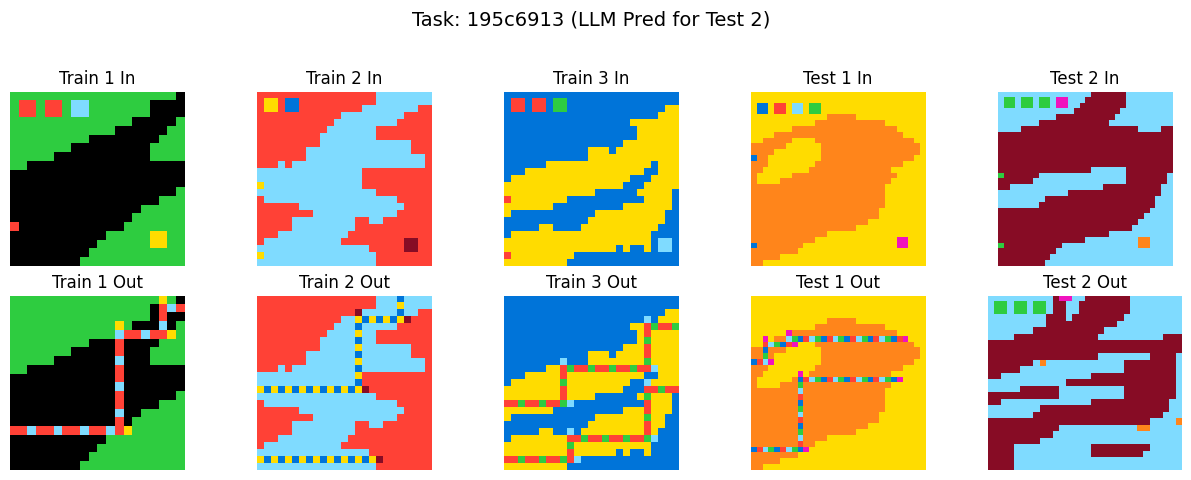

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((27, 30) vs (30, 30)))


===== Task: 1ae2feb7 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify and formalize the pattern or transformation rules that turn the input grids into their respective output grids. Let’s break down the common transformations observed across the given examples:

### Identified Transformation Rules

1. **Identify the Vertical Line of '2':**
    - In each input grid, there is a column filled with the number '2'. This column serves as a vertical divider.

2. **Interaction with Blocks to the Left of '2':**
    - For each continuous horizontal sequence of numbers (like '1 1 1 1', '3 3 3 3', or '5 5 5 5') that appears to the left of the vertical line of '2', specific patterns emerge in their corresponding output:
      - These sequences extend horizontally to the right of the '2' column in specific repetitive or structured patterns.

3. **Pattern Extension:**
    -

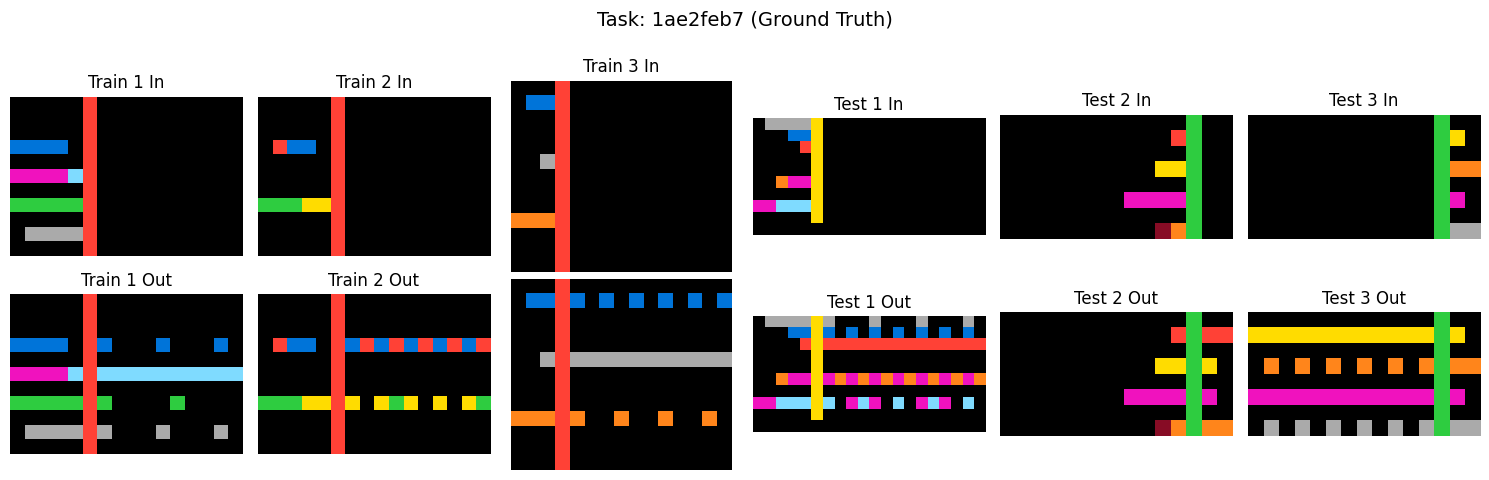


--- LLM Prediction Visualization (Task: 1ae2feb7 / Test: 0) ---


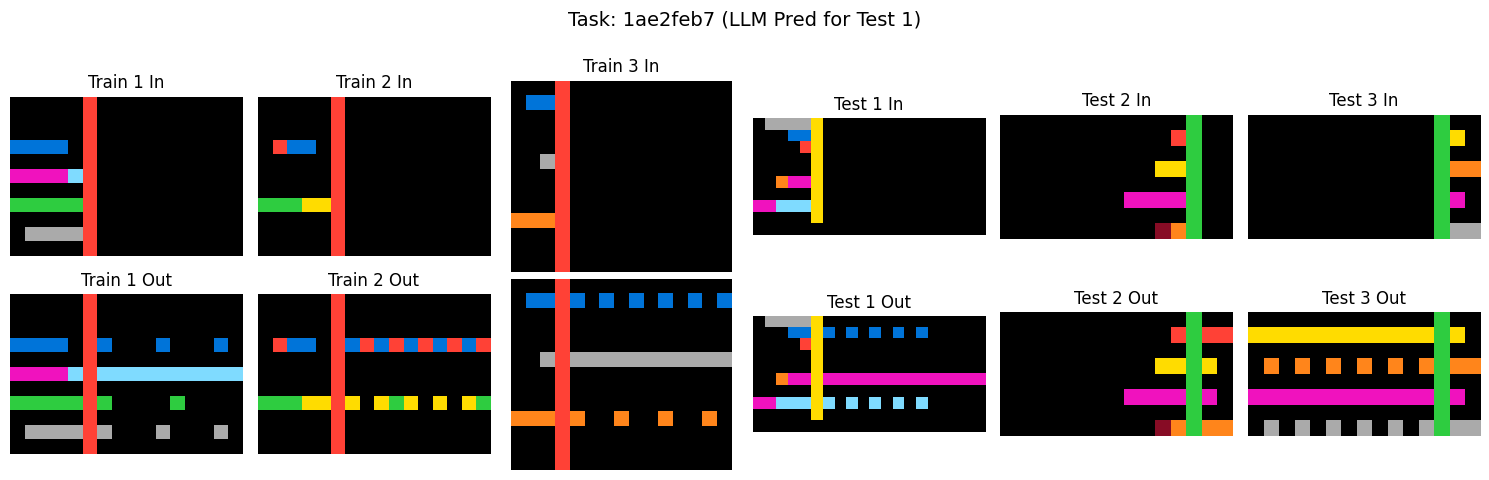

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 1ae2feb7 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given problem, let's deduce the transformation rules by observing the train examples. Here's the breakdown of the tasks:

### Analysis of Training Examples:

**Observation:**

1. Each row in the given input has a set of numbers and a single '2' within it.
2. The transformation seems to depend on the presence of numbers adjacent to '2' or shortly thereafter in the row.
3. If a non-zero number is encountered before the '2', then the transformation involves appending, until the end of the row, a specific pattern based on the numbers before the '2':
   - Repeat the pattern sequence of numbers (e.g., [1, 2, 1, 2, 1...]) or, append the number that matches each digit in the sublist formed by non-zero numbers before '2'.
4. If there are multiple unique numbers before '2', their positions may get re-distributed according to the output pattern after 

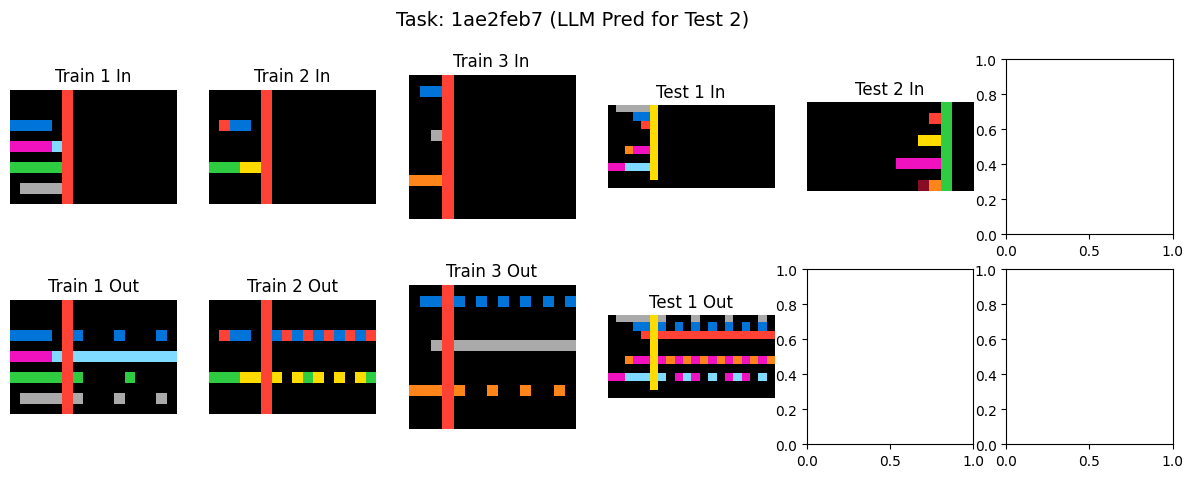

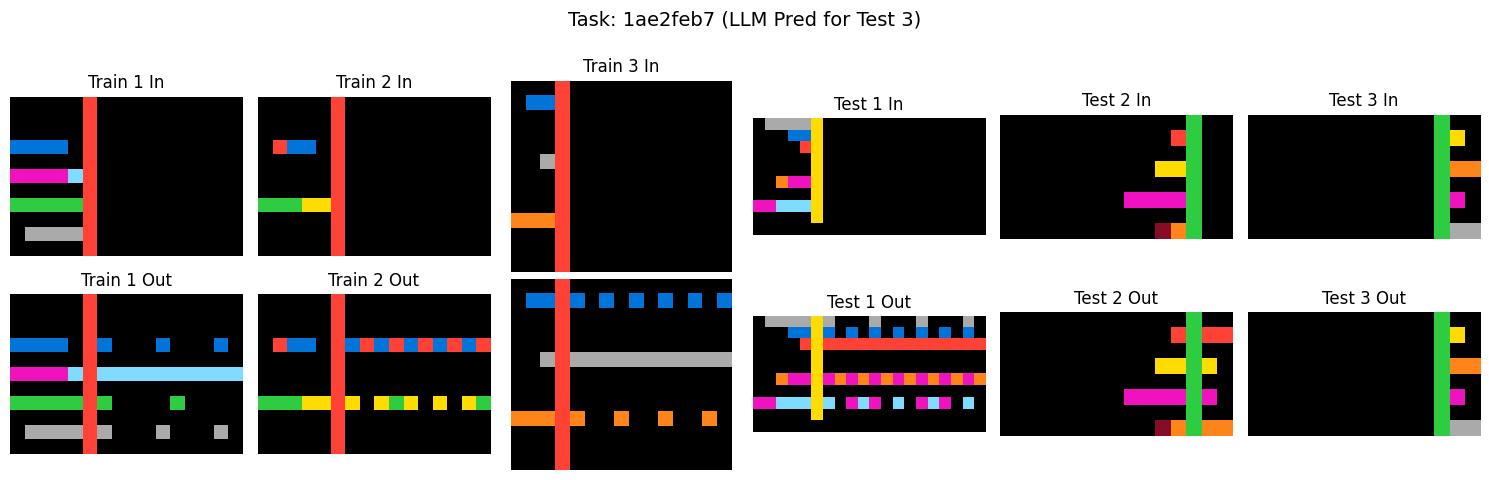

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 20270e3b / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to establish a set of rules that convert the input grid into the output grid in each given example.

Upon analyzing the examples, we can observe some interesting patterns that suggest the following transformational rules:

1. **Boundary Elements (4)**:
   - The boundary elements in the output grid are always maintained as 4s. In cases where 7s existed at the input grid's boundary, they are replaced with 4s.

2. **Sevens (7)**:
   - Any row or column that contains a 7 is removed from the grid in the output.

3. **Internal Grid Pattern**:
   - Apart from the rows and columns removed, the remaining grid configuration is preserved in terms of individual elements (the inner structures composed of 1s and 4s).

4. **Grid Expansion**:
   - If rows or columns are removed due to the presence of 7, the boundary elements (4s) extend vert

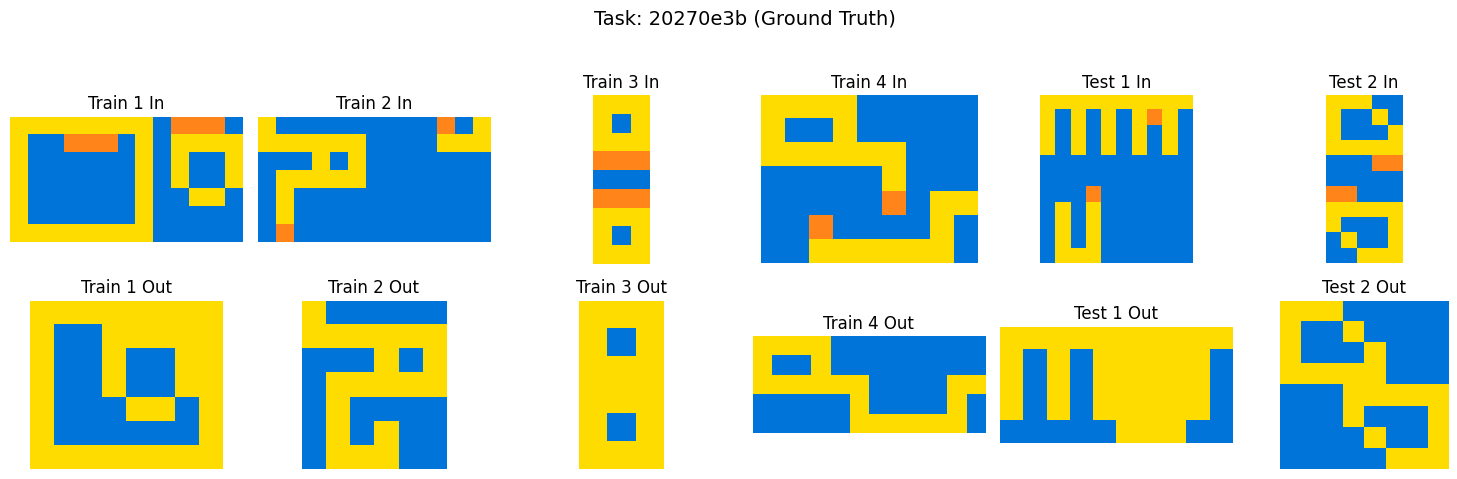


--- LLM Prediction Visualization (Task: 20270e3b / Test: 0) ---


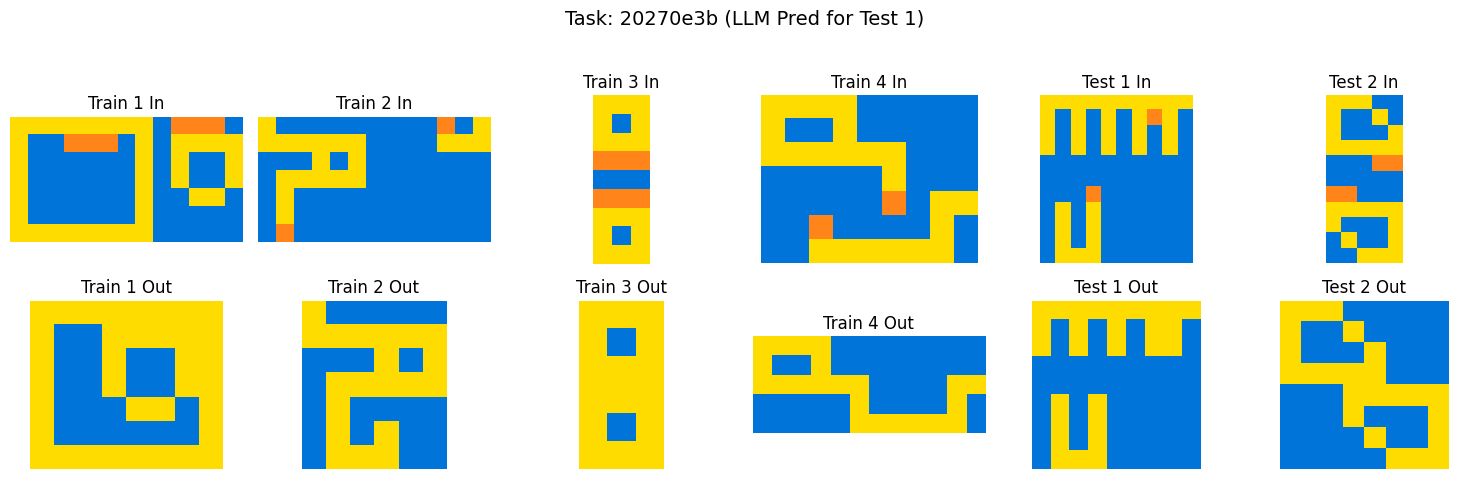

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((9, 9) vs (5, 10)))


===== Task: 20270e3b / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, let's follow the steps outlined:

1. **Identify the Pattern**:  
   - The input grid contains a mix of 1, 4, 7, and other repeating elements.
   - The output grid always appears to be structured such that:
     - All rows are horizontally merged or altered to achieve alignment primarily with "4".
     - The rows of the input prior to encountering the number "7" in the bottom few rows seem to be retained or adjusted but shortened.
     - The rows with "7" shifted upwards or around in the grid.
     - The transformation maintains the structure/form of the middle section with some rows removed or shifted upwards.

2. **Rules Extraction**:
   - **Remove or Adjust Filler Rows**: Rows primarily filled or ending with "1" or mixed "4" get truncated to form symmetry or shorten into the output without disrupting structure 

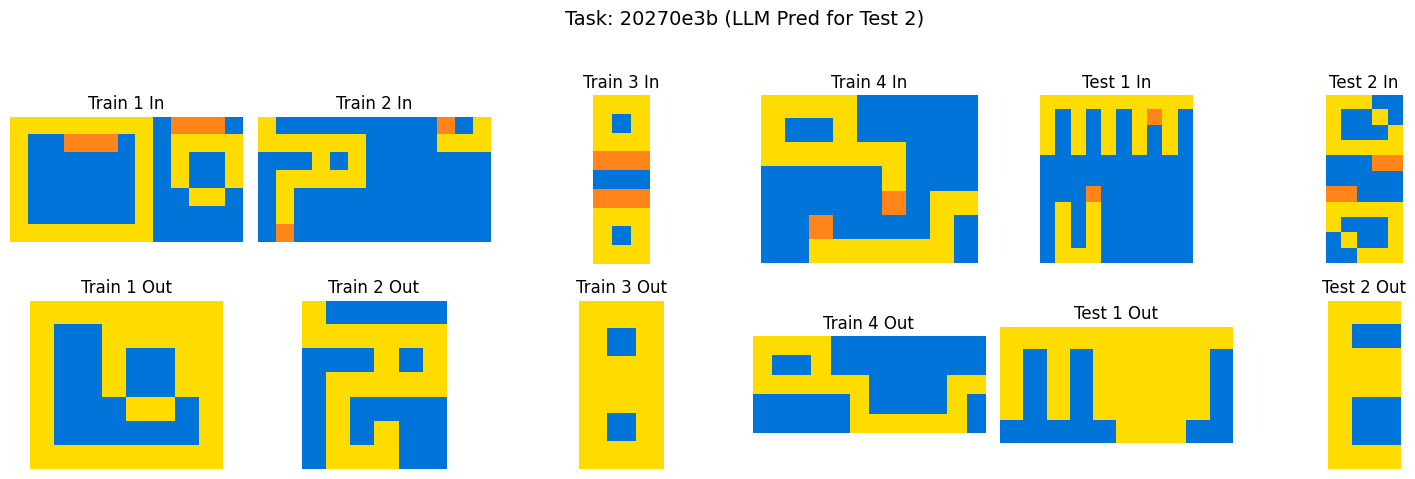

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((7, 3) vs (8, 8)))


===== Task: 20a9e565 / Test Case: 0 =====

--- Raw LLM Response ---
```
To address the problem presented, let's analyze the pattern:

**Training Analysis and Rule Extraction:**

1. **Identify Non-zero Regions:**
   - The grid mostly consists of zeros. The task is to identify regions with non-zero values.

2. **Shape Formation:**
   - The non-zero cells form repeatable shapes or motifs that are isolated or pattern-like. The motifs can often be extracted as contiguous blocks of numbers, provided they are surrounded by zeros or empty space.

3. **Extract Shapes as Solution:**
   - For each unique shape, we extract that block as a solution output grid. The example outputs from the training sets fit this criterion: find a block of the same number and capture it.

**Deduced Transformation Rule:**
- **Step 1:** Identify contiguous regions of non-zero numbers (can be isolated islands of numbers).
- **Step 2:** Extr

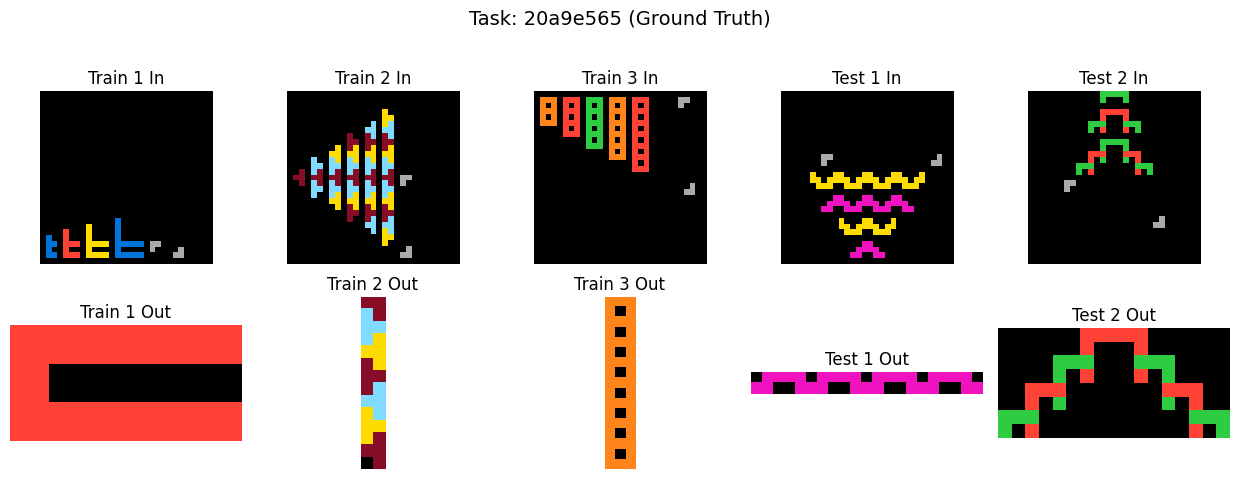


--- LLM Prediction Visualization (Task: 20a9e565 / Test: 0) ---

Error during LLM prediction visualization for 20a9e565, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.


===== Task: 20a9e565 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem presented, we have to analyze the train examples provided and establish a transformation rule that applies to the pattern in the input grid to produce the output solution. Here's how we can approach this:

### Analysis of Train Examples:

1. **Identify Patterns:**
   - The input grid contains different groups of numbers surrounded by zeros. Each group forms a distinct pattern.
   - The output solution for each example captures specific patterns or structures from the input grid.

2. **Transformation Rules:**
   - **Example 1:** The output is a 3x6 pattern entirely consisting of the number '2', which correspo

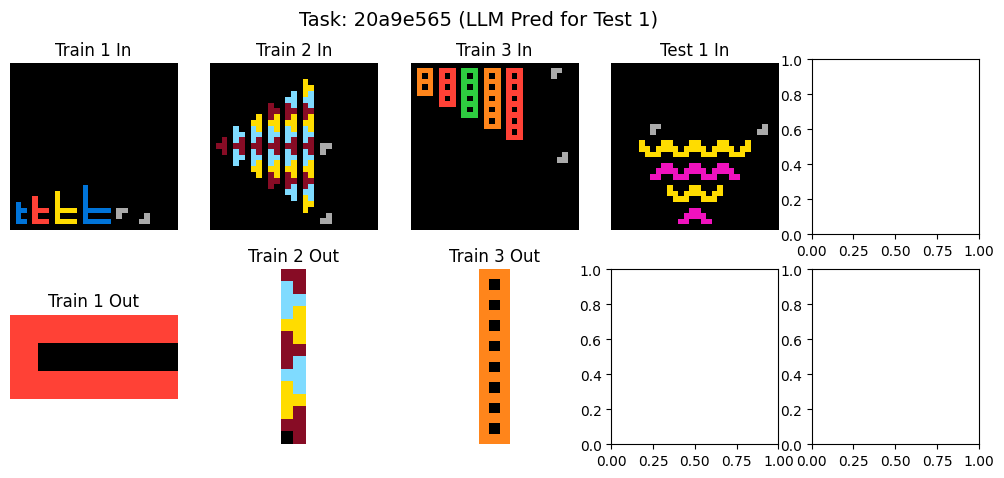

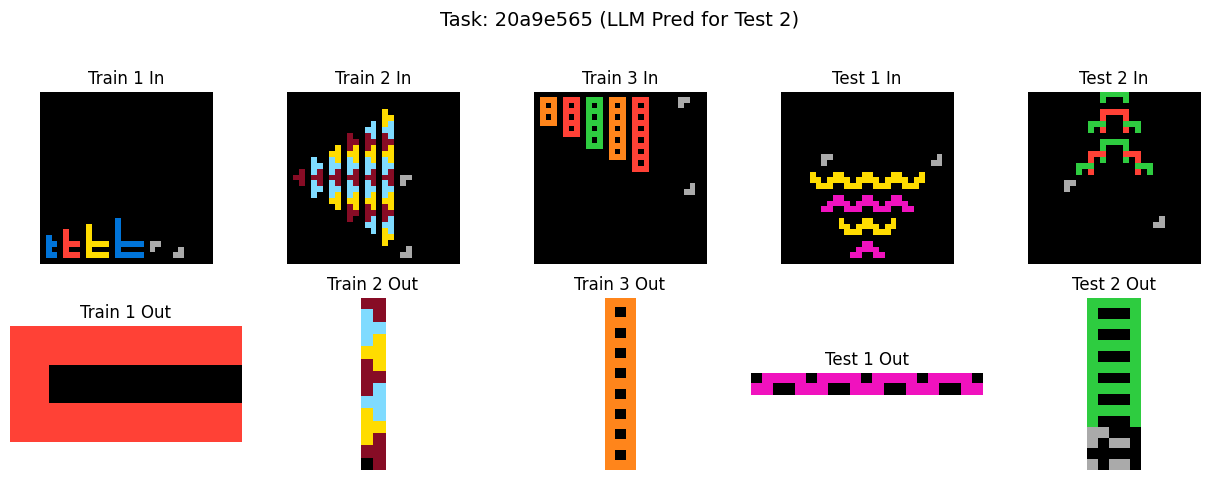

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((16, 5) vs (8, 17)))


===== Task: 21897d95 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, let's analyze the given examples to deduce a pattern or a set of rules governing the transformation from input to output grids.

For all given examples, the following transformations are noticeable:

1. **Identify Large Areas of Uniform Values:**
   - In each example, the input contains significant areas of uniform values that correspond to larger blocks of numbers (e.g., all 6s, 7s, 8s, etc.). These correspond to relatively large blocks in the output formed by a consistent value.

2. **Extract a Distinct Number:**
   - There are distinctive smaller areas with unique numbers (e.g., 1, 0) scattered in larger uniform blocks. These numbers often get carried over or transformed into smaller unique sections in the resultant output.

3. **Grid Expansion or Compression:**
   - The final grid has a dimension transformati

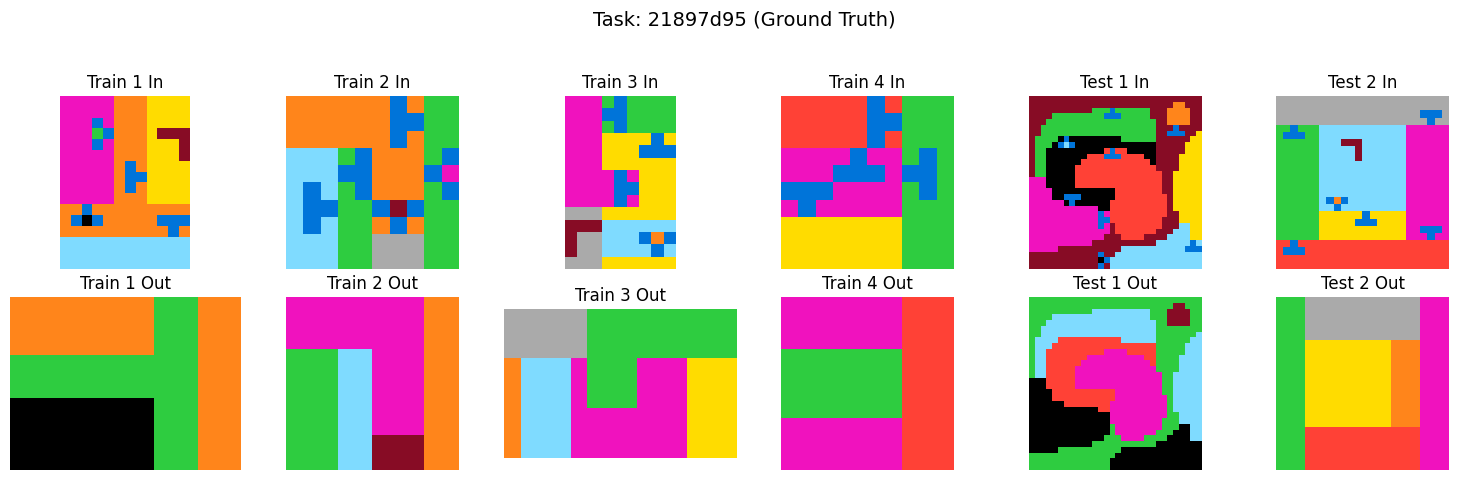


--- LLM Prediction Visualization (Task: 21897d95 / Test: 0) ---


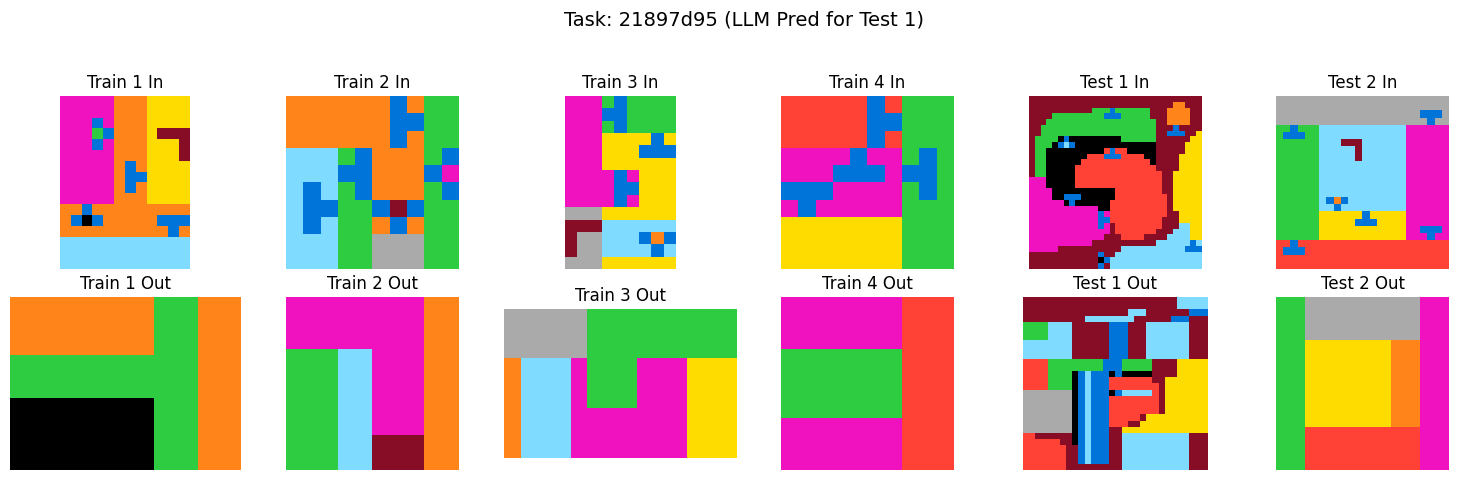

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((28, 30) vs (30, 30)))


===== Task: 21897d95 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the task, we need to determine a set of rules that transform the input grid into the desired solution grid. Let's analyze the examples to identify these rules.

### Observations from the Examples:

Upon analyzing the given `TRAIN EXAMPLES`, we observe the following transformation pattern:

1. **Identify Regions with '1's:**
   - We find and identify rows that contain the digit '1'.
   - Notice when '1's appear, we often have adjacent non-'1' digits like '3', '4', '6', '8', or others across the examples.

2. **Extract Sub-Grids:**
   - Using the rows identified as having '1's, extract the larger sub-grid of interest, often characterized by clustering numbers between '1's. For example, blocks surrounded by one or more sequential '1' entries are of prime interest.

3. **Replace Specific Patterns with a New Pattern:**
   - The 

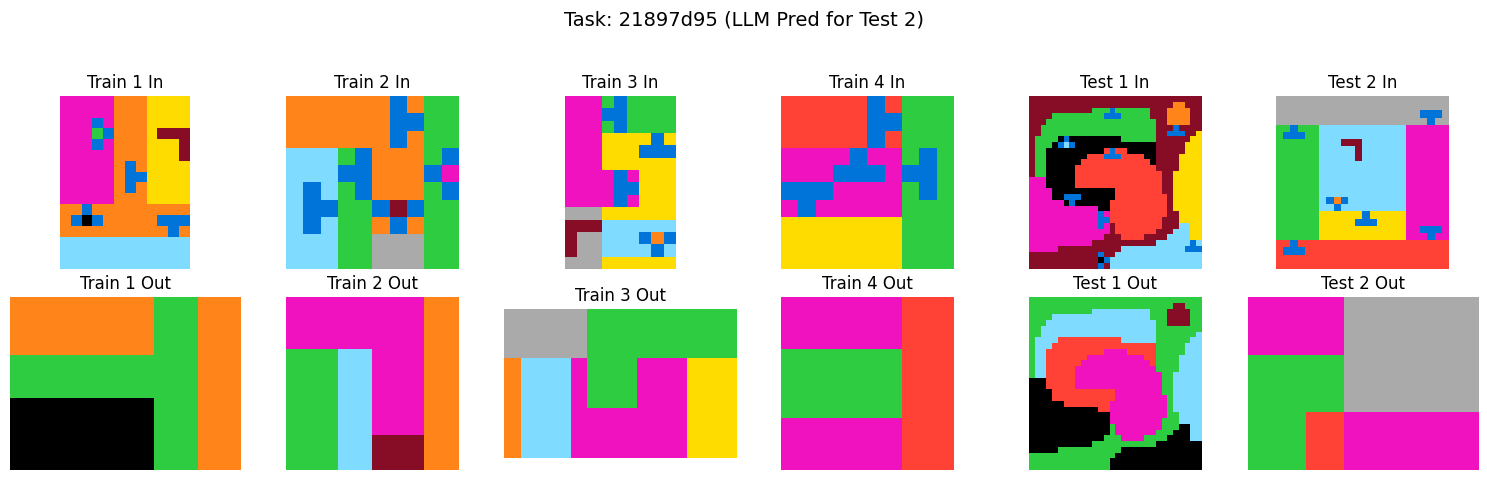

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((9, 12) vs (24, 24)))


===== Task: 221dfab4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to deduce the pattern of transformation from the two given examples. The main goal is to identify sequences of numbers that need to be changed to a specific target number.

Here's a detailed breakdown of the transformation rules deduced from the examples:

1. **Identify Contiguous Sequences:** In the input grids, we are looking for contiguous horizontal sequences of an arbitrary number. In the examples provided, these sequences appear to be primarily made of the number `4`.

2. **Transformation Rules Application:**
    - Identify horizontal segments based on the length of the sequences in the input grid.
    - Replace the identified segments in each row with a target number (`3` based on the examples), but this target number has to be coherent with any noticeable pattern from the provided example solution.

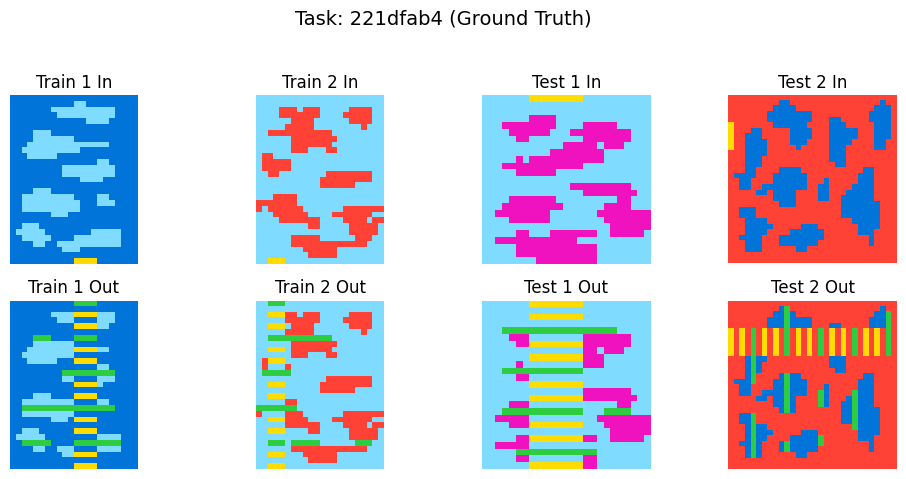


--- LLM Prediction Visualization (Task: 221dfab4 / Test: 0) ---


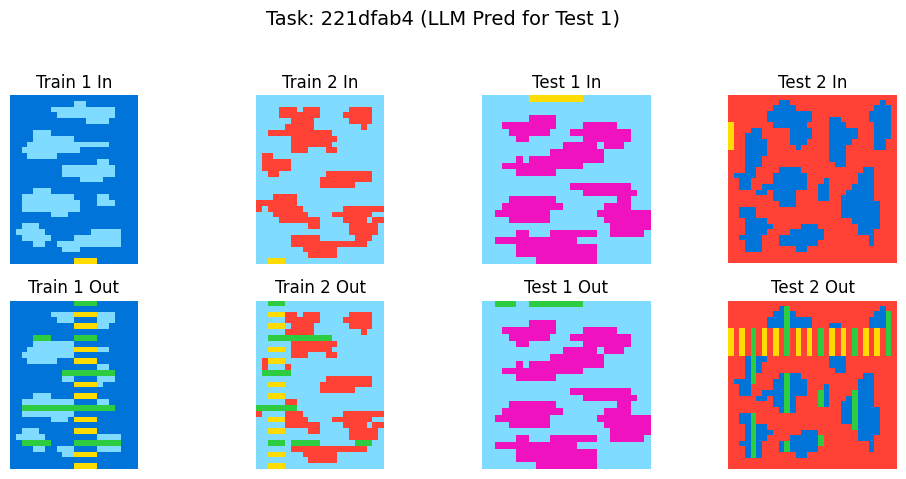

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 221dfab4 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce the transformation rules that are applied to the input grid to produce the output grid. Let's analyze the given training examples and derive the transformation:

From the examples, we observe the following pattern:

1. **Reference and Change Colors with Shapes**:
   - The numbers '1', '2', '4', and '8' are used in the input grid to represent different colors.
   - The transformation seems to revolve around identifying certain prominently clustered numbers (like '1', '2', or '4') and changing those clusters to '3', a specified alternative color, often at the center or focal area of a pattern.

2. **Transforming Patterns with '4' and '2'**: 
   - Areas of '4' in the input often correspond to '3' in the output. This transformation is consistent across both training examples where '4' is used.
   - Similarly, areas f

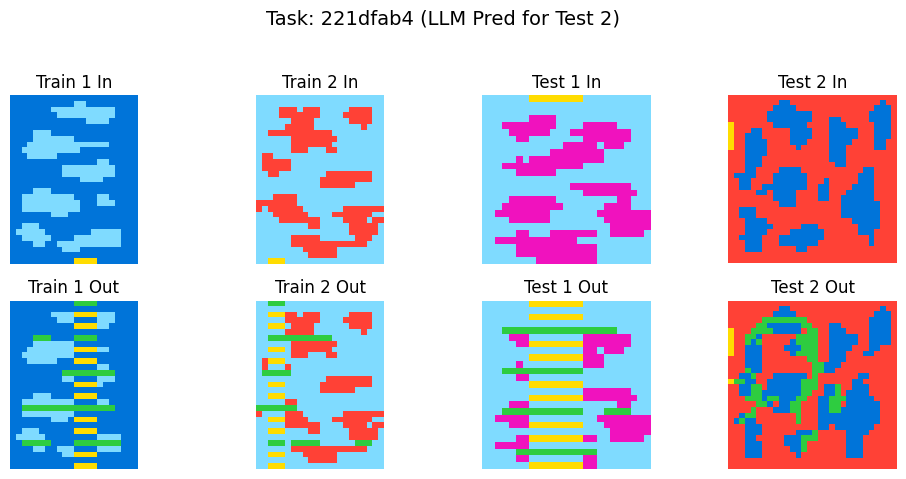

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 247ef758 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's analyze the input and output examples provided and deduce the transformation rules.

### Common Observations:

1. **Preservation of 3s at Fixed Column**:
   - Across each input example, the value '3' appears consistently in a particular column across all rows and is mirrored in the output. This suggests this element marks a part of a vertical line or symmetry in the transformation rules.

2. **Zeroing and Consolidation of Preceding Values**:
   - The part of the input grid preceding the 'fixed' column with repetitive '3's is transformed into zeros in the output grid. This can be seen in all examples where columns left of '3' become zero.

3. **Mirroring Patterns**:
   - Elements following the column of '3's tend to form symmetrical or mirrored patterns. Particularly, non-zero elements that appear isolated in the input (e.g.,

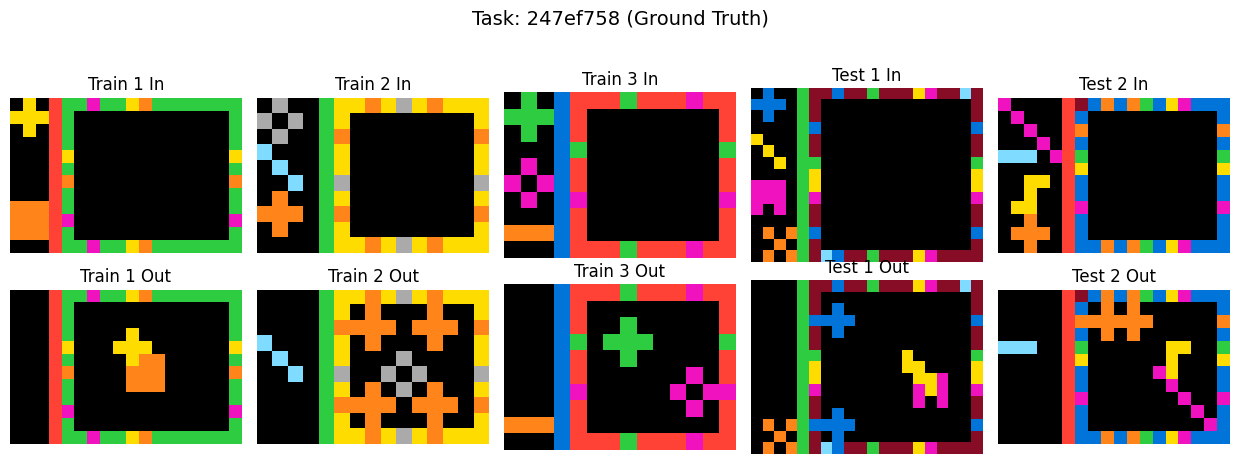


--- LLM Prediction Visualization (Task: 247ef758 / Test: 0) ---


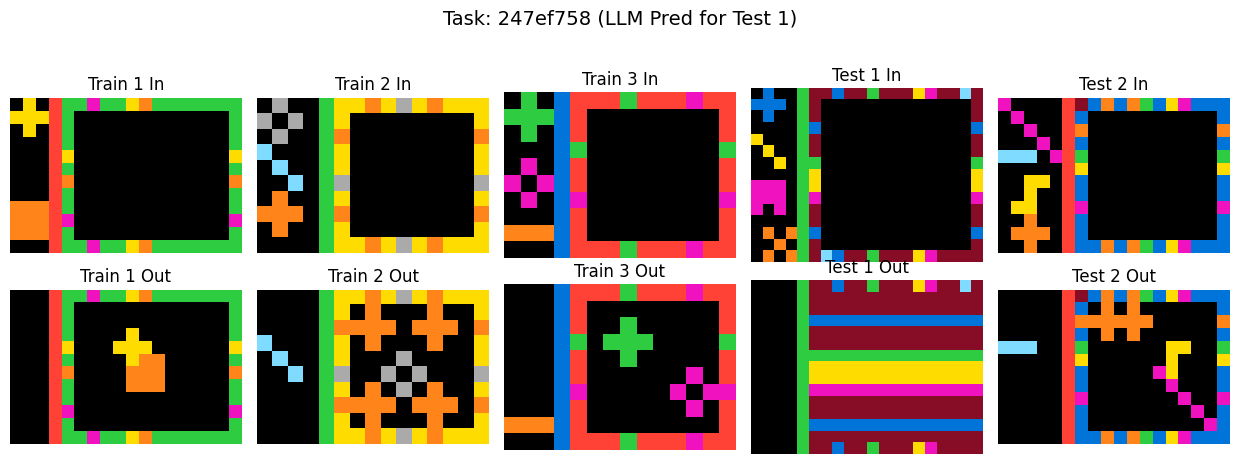

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 247ef758 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we will analyze the patterns observed in each train input-output pair and derive a rule that can systematically transform any arbitrary input to its expected output.

**Understanding the Transformation:**

1. **Diagonal Line of Non-Zeroes:**
   - In each example, there is a prominent diagonal line of non-zero values starting from the top-left corner. These non-zero numbers form either a continuation or an endpoint right-hand boundary in the corresponding column or row.

2. **Maintaining Leading Values:**
   - The rightmost or leading values in specific rows and columns (not in the diagonal) are preserved.

3. **Rewriting Non-Zeroes:**
   - Values on the top and bottom boundaries of the diagonal often appear as zeroes initially. Transformation involves zeroing unnecessary leading non-zero values and maintaining the diagonal line no

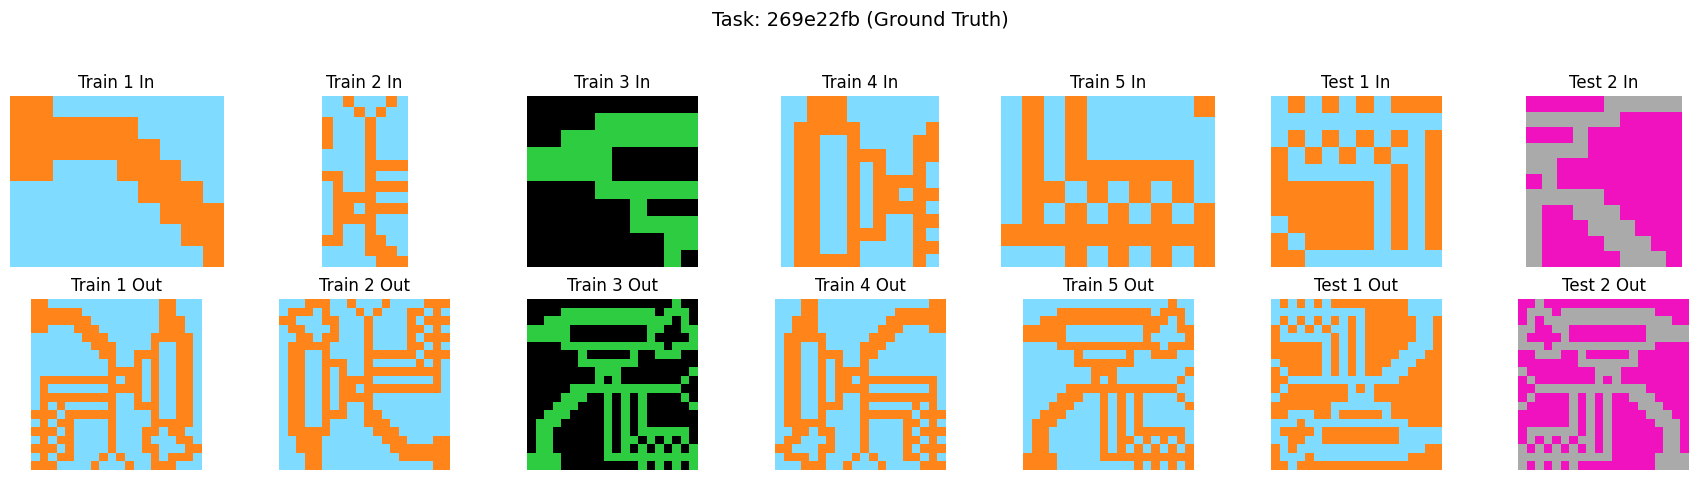


--- LLM Prediction Visualization (Task: 269e22fb / Test: 0) ---


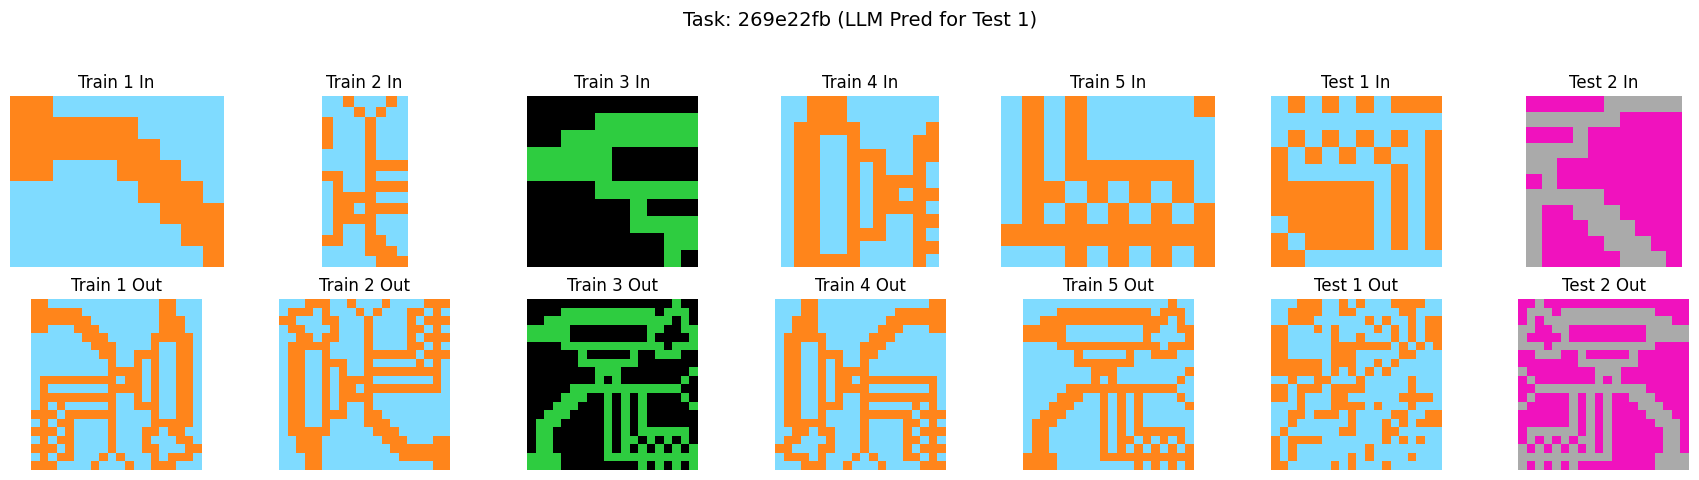

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 269e22fb / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, we need to deduce the transformation rule that is being applied to the inputs to produce the given outputs. After careful analysis of the examples, the following rules can be identified:

1. **Grid Expansion**: Each input grid is expanded from a 10x10 to a 20x20 grid.

2. **Pattern Analysis and Repositioning**:
   - Identify unique "clusters" of similar numbers (e.g., blocks of continuous numbers) in the input grid. Each row acts as a new grid part.
   - Copy these values directly into the corresponding places in the expanded grid, following a pattern to ensure the solution matches the upper left section with matching number arrangements.

3. **Filling the Gaps**:
   - Once clusters have been copied, use additional values from the input to fill remaining unoccupied spots in a new pattern in the expanded grid.

Applying these rules, i

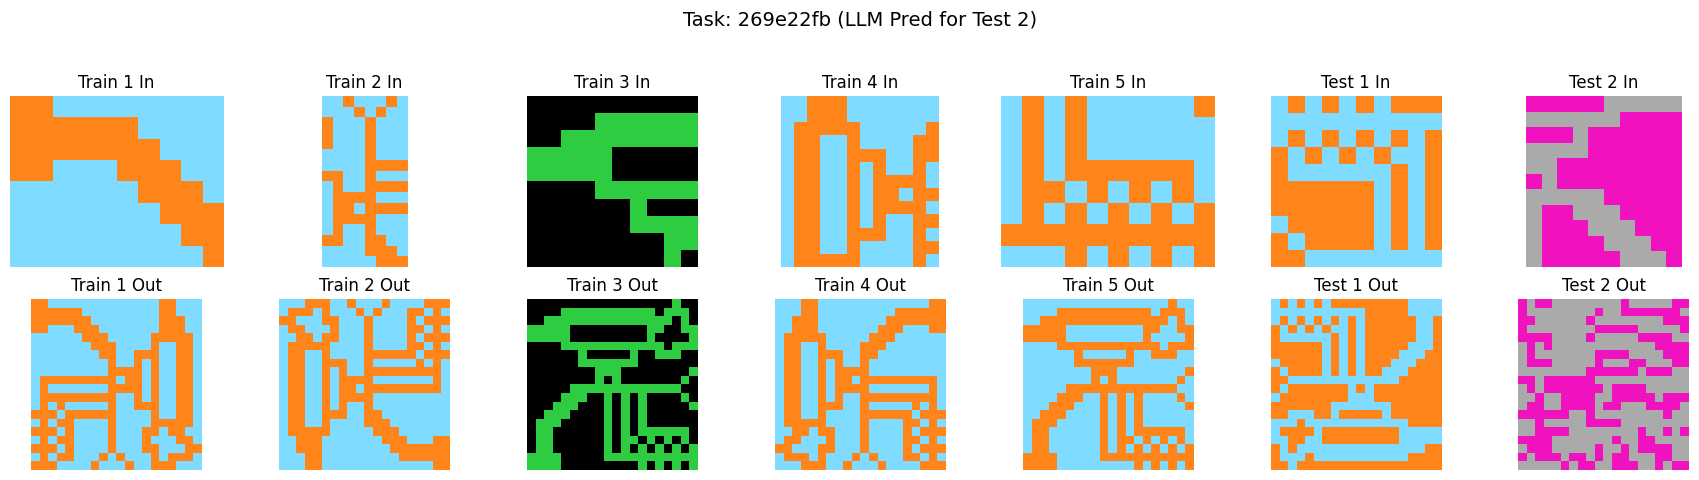

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 271d71e2 / Test Case: 0 =====

--- Raw LLM Response ---
```
To determine the transformation rules applied from the input to the output in the training examples, let's break down the methods and patterns:

1. **Vertical and Horizontal Alignment of '6':**
   - The rows and columns around the boundaries often comprise of '6'. This boundary remains constant and ensures the outer frame of '6's remains secure.

2. **Pattern Identification:**
   - There is a unique alteration pattern for each section containing non-'6' numbers (like sequences of '9', '5', '7', etc.).
   - Regions within the frame containing numbers other than '6', such as sequences of '9', '5', '7', or '0', are either expanded or altered in very specific ways in the transformation to the output.

3. **Border Handling of Sequence Blocks:**
   - Adjacent blocks of '5's surrounded by '0's are transformed with additional patterns in the output. '7' is intr

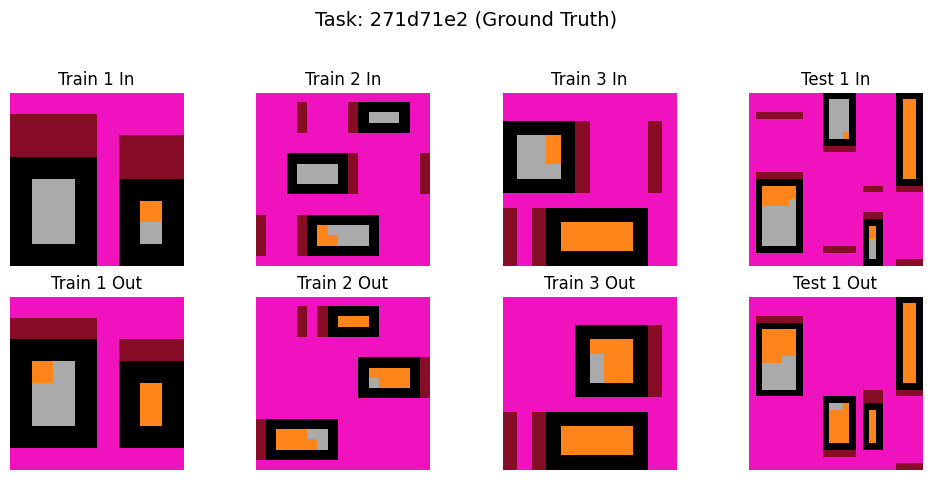


--- LLM Prediction Visualization (Task: 271d71e2 / Test: 0) ---


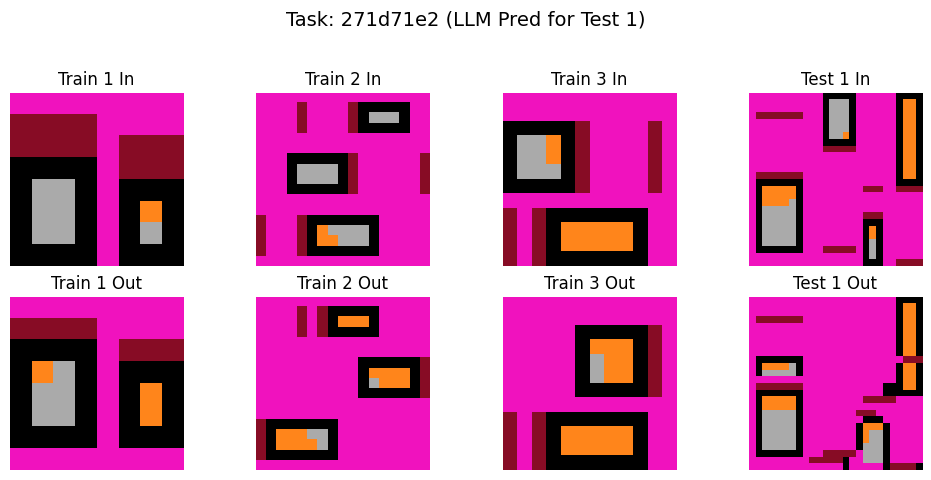

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 28a6681f / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this transformation puzzle, let's examine the patterns and rules deduced from the provided examples.

### Analysis:

1. **Identify the pattern for non-zero regions:**
   - The pattern indicates that we need to alter sequences of `1`s that align vertically. In each example, the topmost occurrence of `1` at each vertical stack is turned into a `0`.

2. **Rules from examples:**
   - Locate all occurrences of vertical stacks of `1`. This is done by traversing each column.
   - For each column, identify the first row from the top where `1` occurs and turn this `1` into a `0`. If a column has multiple `1`s, only the topmost one is changed to `0`.
   - Other parts of the grid and other numbers remain unchanged.

3. **Verification with examples:**
   - **Example 1:**
     - Columns 8 and 9 contain stacks of `1`.
     - Row 0 and Row 1 in the input have

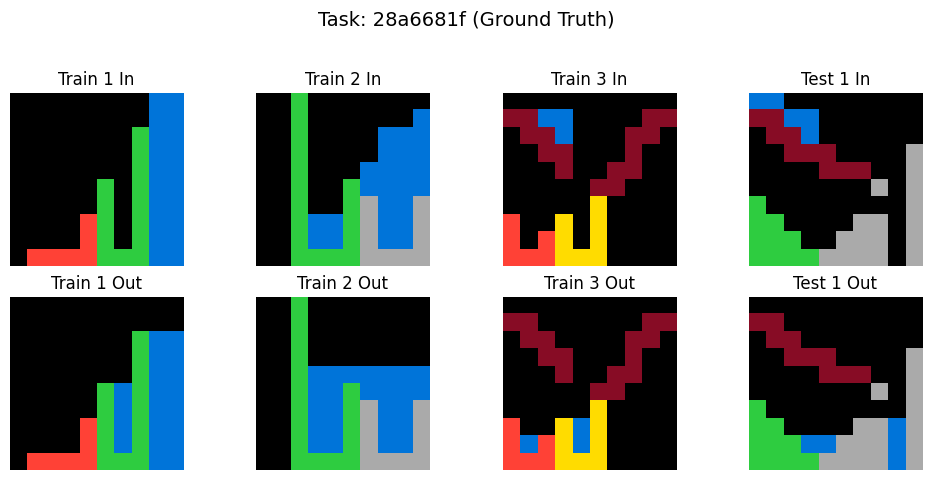


--- LLM Prediction Visualization (Task: 28a6681f / Test: 0) ---


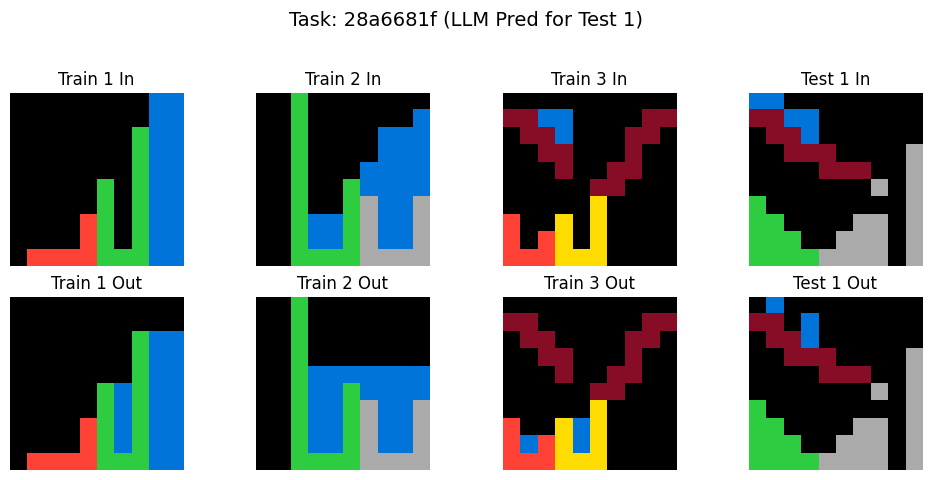

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 291dc1e1 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules, let's analyze the provided examples:

### Identifying Rules from Given Examples:

1. **Row Extraction:**
   - In each example, we observe that specific rows from the input are directly selected and placed into the output grid.
   - The selected rows are determined by specific indices of interest that appear based on the pattern within that input.

2. **Consistency Across Examples:**
   - The number of rows in each output is determined and appears consistent given the observation of rows being selected from the middle section of each input.
   - Only a specific number of rows (`length`) are being extracted at a time from four to six depending on the grid size.

3. **Column Extraction:**
   - For each row identified to be transferred, specific sections (or columns) of that input row are copied to the output.
   - These 

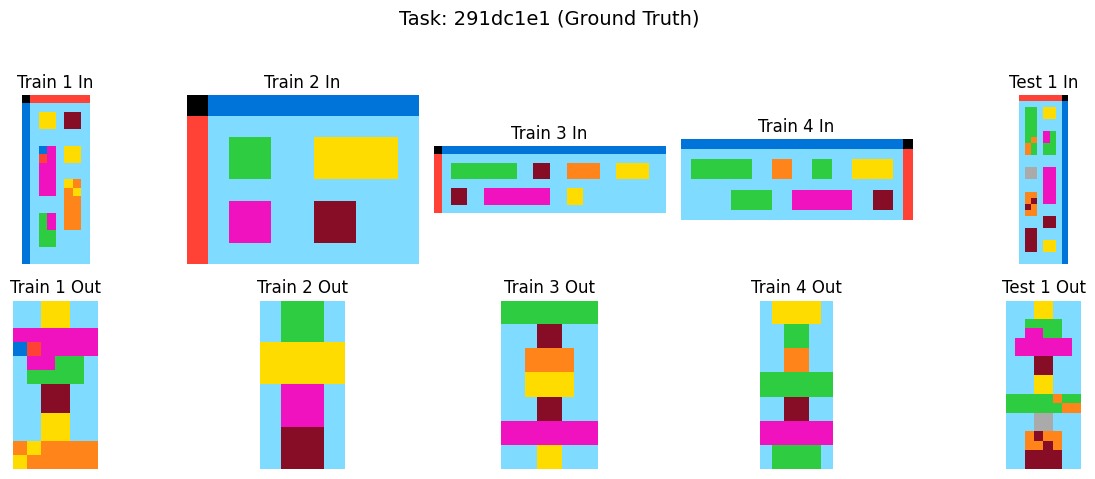


--- LLM Prediction Visualization (Task: 291dc1e1 / Test: 0) ---


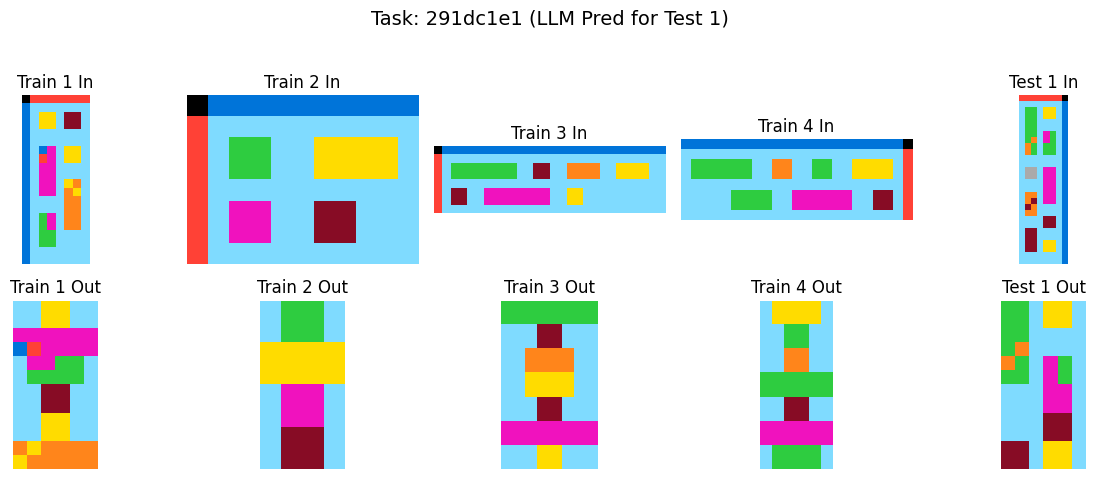

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((12, 6) vs (18, 8)))


===== Task: 2b83f449 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to establish a ruleset that transforms the input grid into the output grid based on patterns observed in the examples. Here's a step-by-step analysis:

### Rules Deduced:
1. **Transformation Triggered by 7s**:
   - In each pair of rows in the input grid, if a row of `0`s contains a sequence of `7, 7, 7`, the column directly above the first `7` in the `8`s row changes, as follows:
     - Transform the element before this position in the `8`s row to `6`.
     - Transform the element in the same position in the `8`s row to `6`.

2. **Change in Border Rows**:
   - The first and last row of the input grid predominantly consist of `8`s but start and end with `3`. In the output, the elements become `8` except the corners which follow the previous rule if applicable. 

3. **Effect on Consecutive 3s**:
   - When 

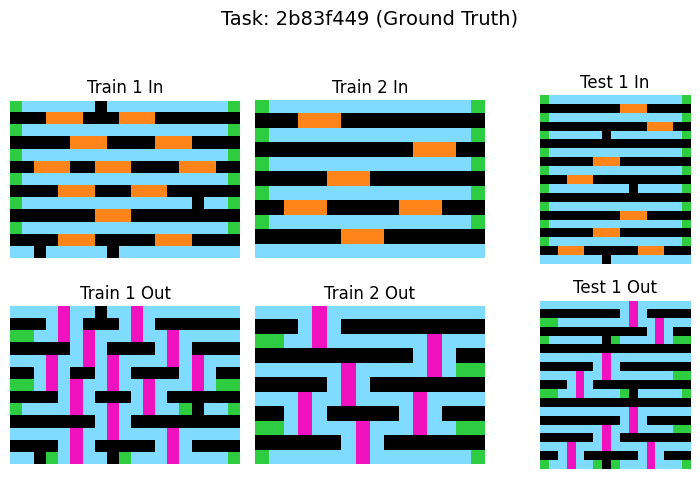


--- LLM Prediction Visualization (Task: 2b83f449 / Test: 0) ---


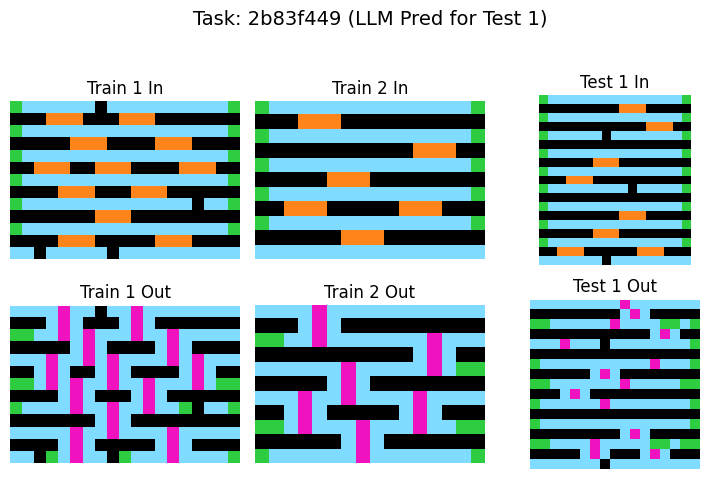

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((17, 17) vs (19, 17)))


===== Task: 2ba387bc / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve these examples, let's analyze the patterns:

### Observed Patterns and Rule Set:

1. **Blocks Identification**: 
   - Each grid contains groups or "blocks" of numbers that form larger rectangular or square shapes, each with their own unique number (e.g. `1`, `2`, `3`, `4`, `6`, `7`, `8`, `9`).
   - These are observed both horizontally and vertically.

2. **Extraction**: 
   - Extract these blocks and their positions, ignoring the zeroes around them.

3. **Rearrangement Matrix**:
   - Each puzzle solution appears to merge grids into smaller forms (often 8x8 or 12x4 shapes).
   - The types of numbers are identical across inputs and outputs, usually reshuffled into a new pattern that combines such that blocks are matched horizontally and vertically. 
   - The rearrangement of blocks doesn't necessarily follow their order from 

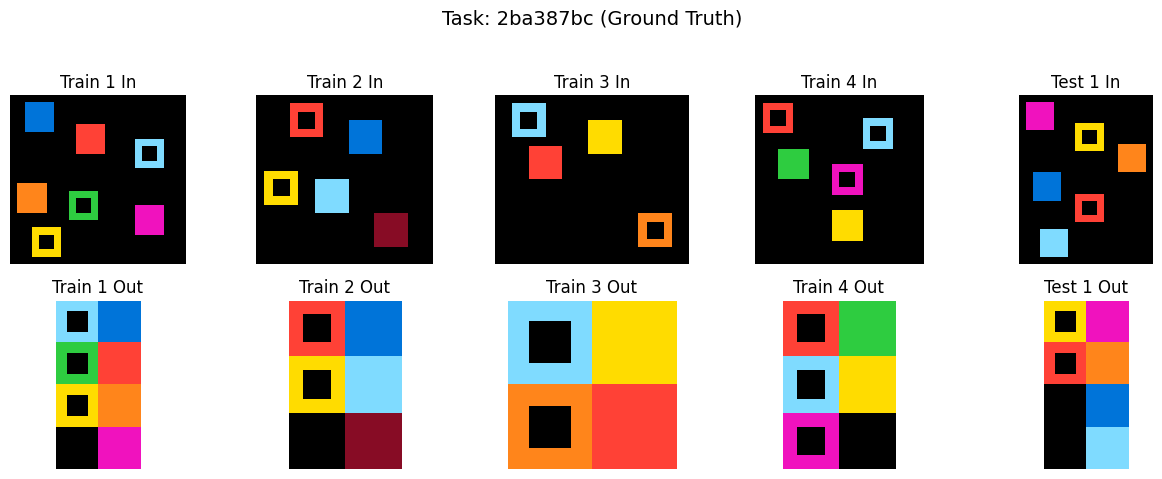


--- LLM Prediction Visualization (Task: 2ba387bc / Test: 0) ---


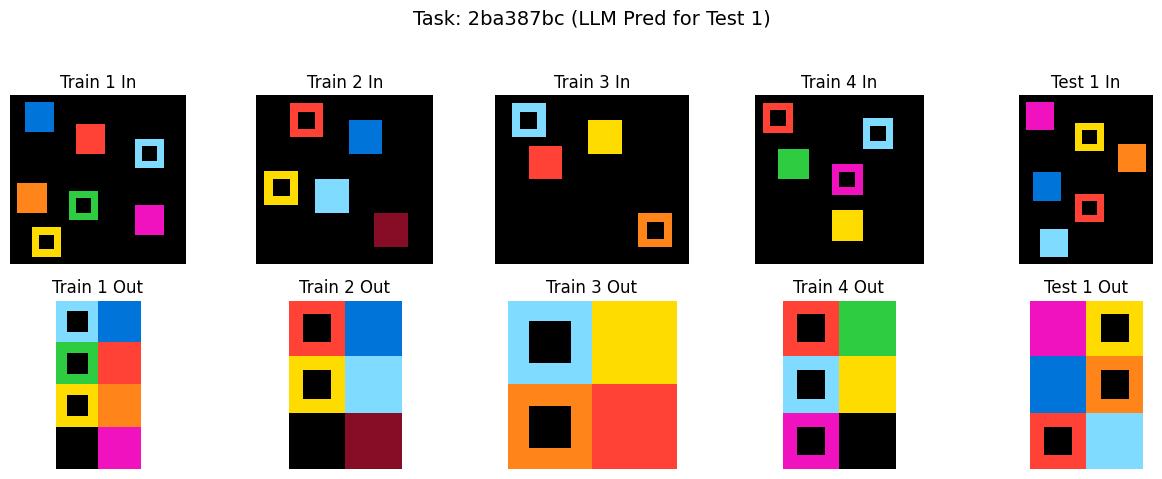

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((12, 8) vs (16, 8)))


===== Task: 2c181942 / Test Case: 0 =====

--- Raw LLM Response ---
```
To transform the input grids into the corresponding output grids, the following rule set can be deduced from the examples provided:

### Transformation Rule Set:

1. **Identify Blocks of Numbers:**
   - Locate all blocks of adjacent same numbers. These blocks are defined by having the same number horizontally or vertically next to each other.

2. **Identify Lowest Row of Each Column within Each Block:**
   - For each unique number (except for the background number `8`), identify all columns that contain that number. 

3. **Shift Blocks to the Bottom:**
   - Move each block downwards to the lowest possible position within its columns while preserving its horizontal and vertical alignment. This means each block should have its bottommost part resting on the bottom row of the grid or on top of the background number `8`.

### Execution on

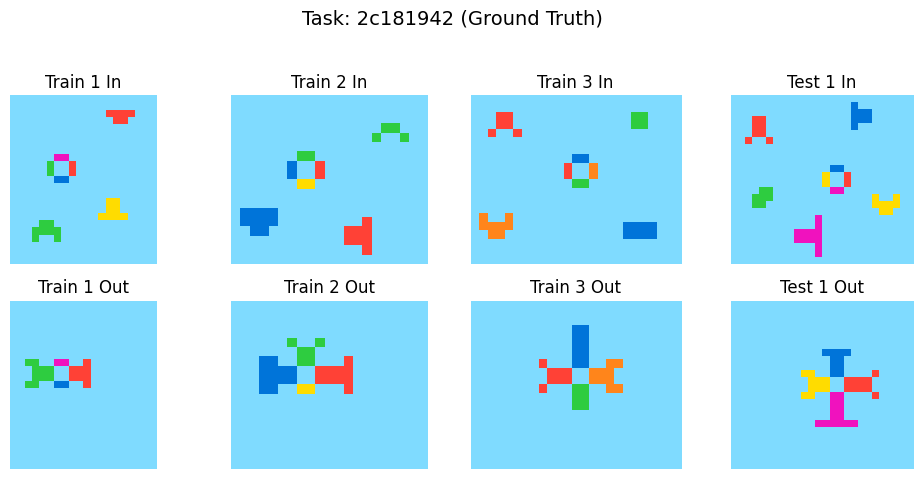


--- LLM Prediction Visualization (Task: 2c181942 / Test: 0) ---


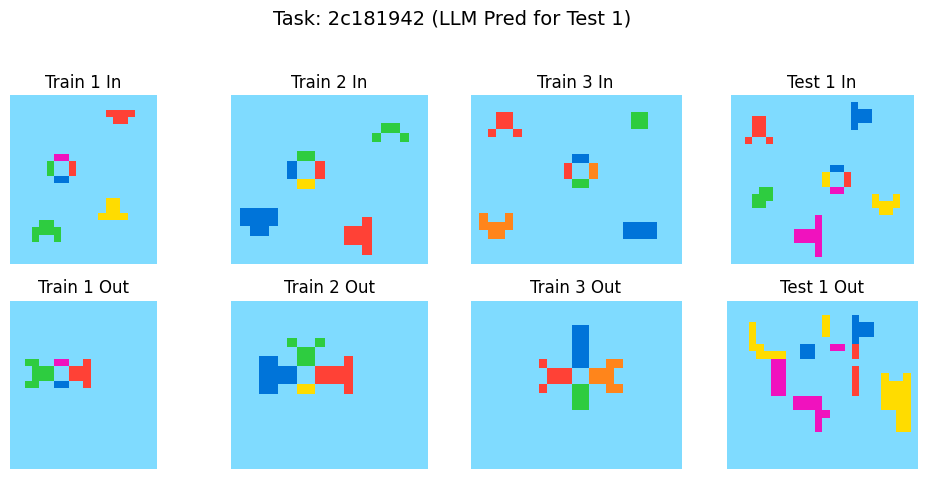

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((23, 26) vs (24, 26)))


===== Task: 2d0172a1 / Test Case: 0 =====

--- Raw LLM Response ---
```
To address this problem, let's deduce the transformation rules from the provided examples by analyzing patterns in the input-output pairs.

### Observations:

Upon closely examining the examples, we can deduce that the task involves identifying a square pattern of a distinct value within a larger grid and extracting this square with some padding, resulting in a smaller grid.

### Common Pattern and Rules Deduction:

1. **Identification of Core Structure**: 
   - The core structure seems to be a square block of a distinct value (termed as the "inner square") inside the grid. This square is surrounded by other values.
   
2. **Output Transformation**:
   - The output is derived by extracting this identified "inner square" along with immediate outer values as padding (extra border) surrounding it, therefore resulting in a larger square

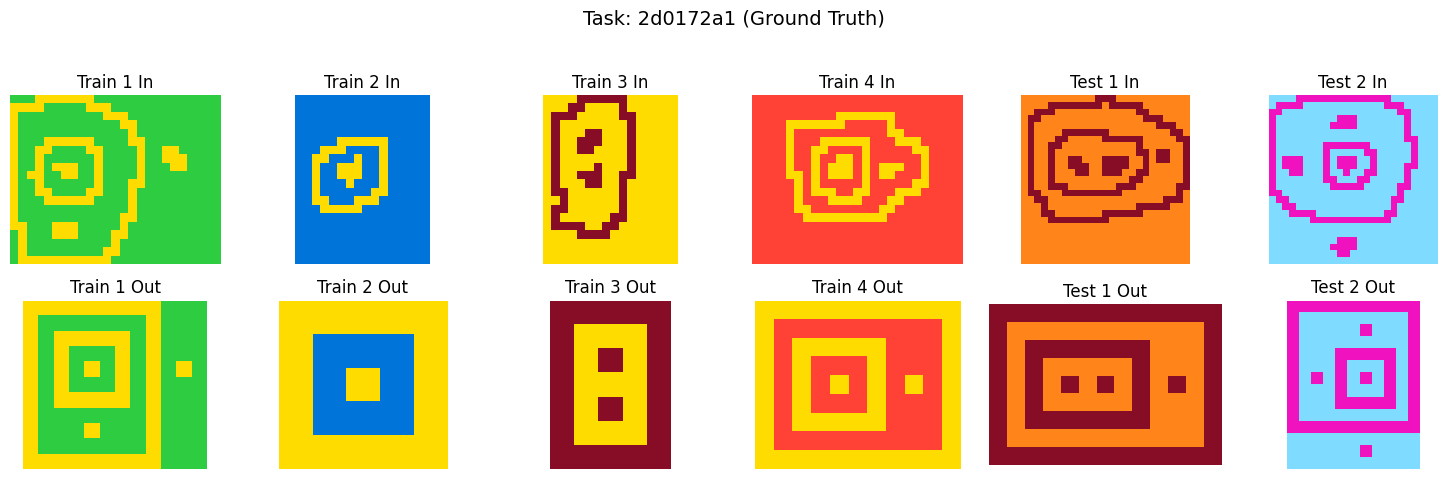


--- LLM Prediction Visualization (Task: 2d0172a1 / Test: 0) ---


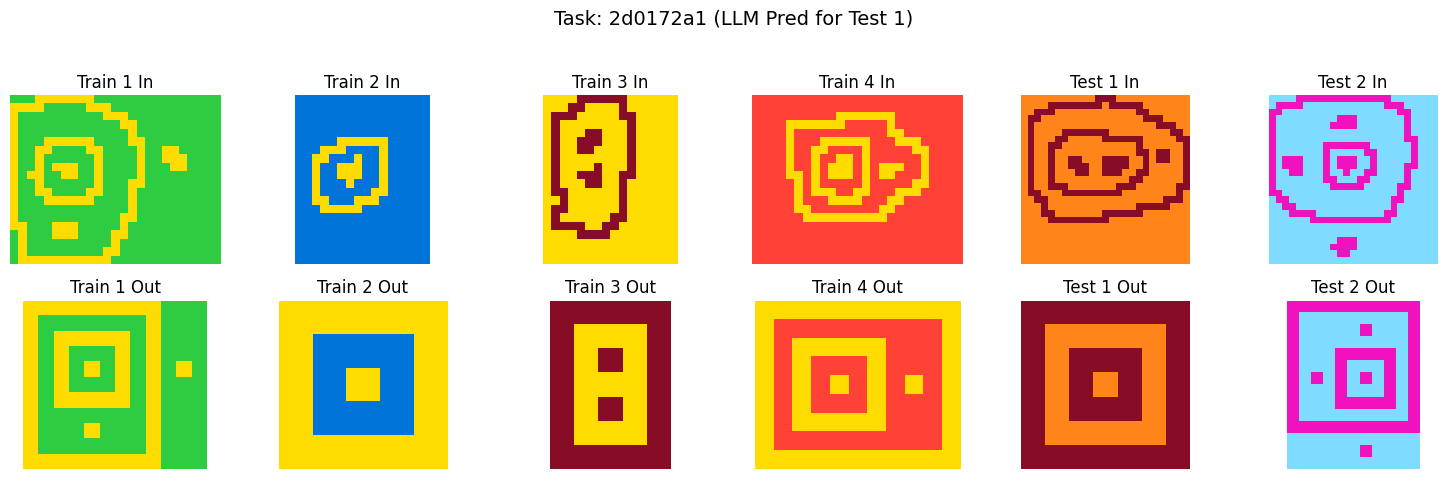

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((7, 7) vs (9, 13)))


===== Task: 2d0172a1 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given problem, we need to first identify the transformation rules from the input to output for the train examples. Below is the detailed analysis of the problem and the derived rules:

### Pattern Recognition and Rule Formulation

The task involves recognizing a central pattern within a larger matrix and extracting that pattern while maintaining its structure. The formation of the pattern seems consistently centered and symmetrical across the examples. Based on the provided examples, here's a step-by-step guide to deducing the pattern:

1. **Identify the Primary Pattern:**
   Each solution appears to extract a pattern from the center or near-center of the input matrix. The extracted pattern is a square or rectangular section often bordered by different values compared to surrounding cells.

2. **Extracting the pattern:**
 

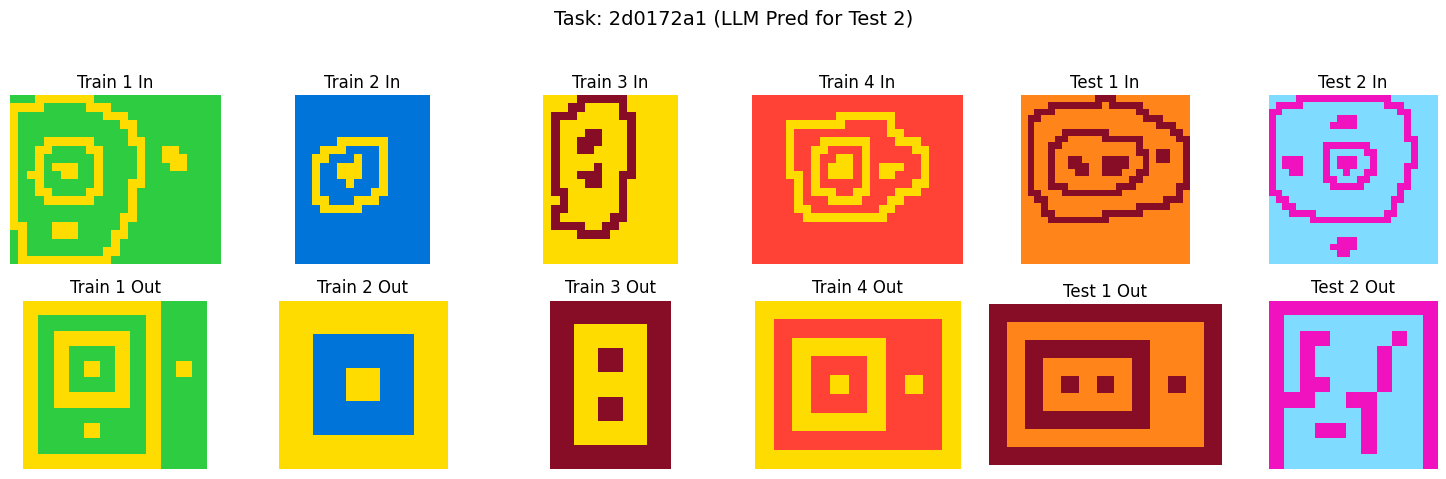

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((11, 11) vs (14, 11)))


===== Task: 31f7f899 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, let's analyze the transformations in the given examples:

1. **Identify the Pattern:**

   In all examples, the number '1' appears to be the target for transformation. We can observe that the transformation involves extending the '1' vertically either upwards or downwards (or both) to fill spaces until it reaches another number or the border of the grid.

2. **Rules Deduction:**

   - The number '1' is extended in a vertical line to replace '8's.
   - The extension continues until it encounters a number different from '8' or it reaches the border of the grid.

3. **Verify Across Provided Examples:**

   - **Example 1:**
     - The '1' at (5, 8) is extended both upwards and downwards until the border of numbers not equal to '8'.
     - This matches the solution.

   - **Example 2:**
     - The '1' at (7, 8) is ext

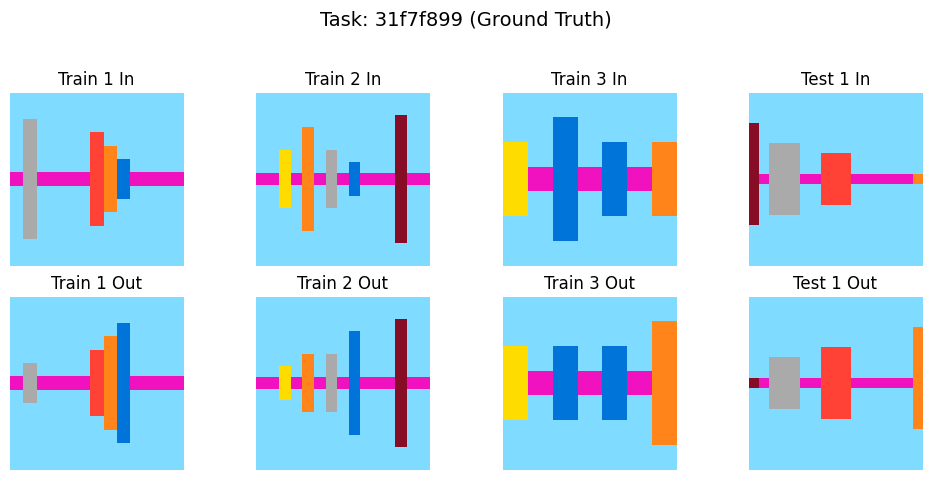


--- LLM Prediction Visualization (Task: 31f7f899 / Test: 0) ---


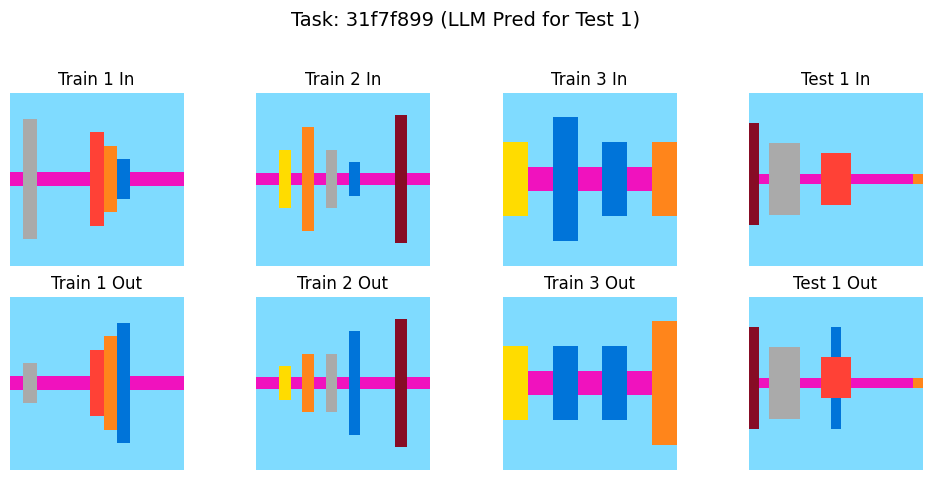

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 332f06d7 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's analyze the transformations taking place in each training example by examining the differences between their inputs and solutions.

**Observation:**

1. The grid transformation seems to be only affecting zeros and ones in the given examples.
2. The primary pattern appears to be transforming zeros into ones. This transformation is restricted to a set area enclosed by threes, indicating a form of operation within bounded regions.
3. Specifically, the zeros that are directly above or adjacent to twos in the input seem to be retained or created, while all other zeros are transformed into ones in the solution.

**Deduced Transformation Rules:**

1. Traverse the grid to find areas enclosed by '3's or surrounded partly by threes, which form distinct segments of the grid.
2. Within these segments, change all zeros to ones, except:
 

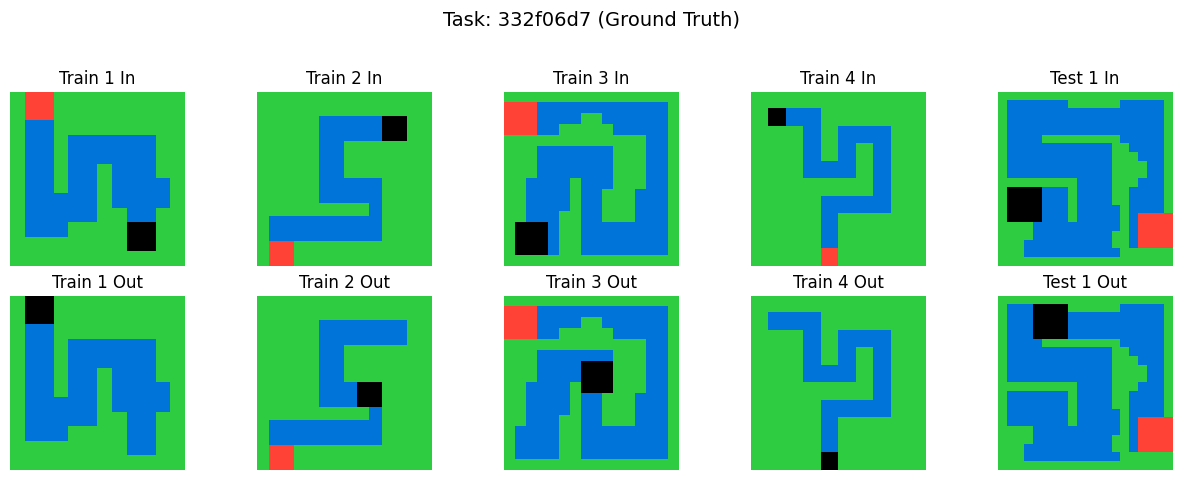


--- LLM Prediction Visualization (Task: 332f06d7 / Test: 0) ---


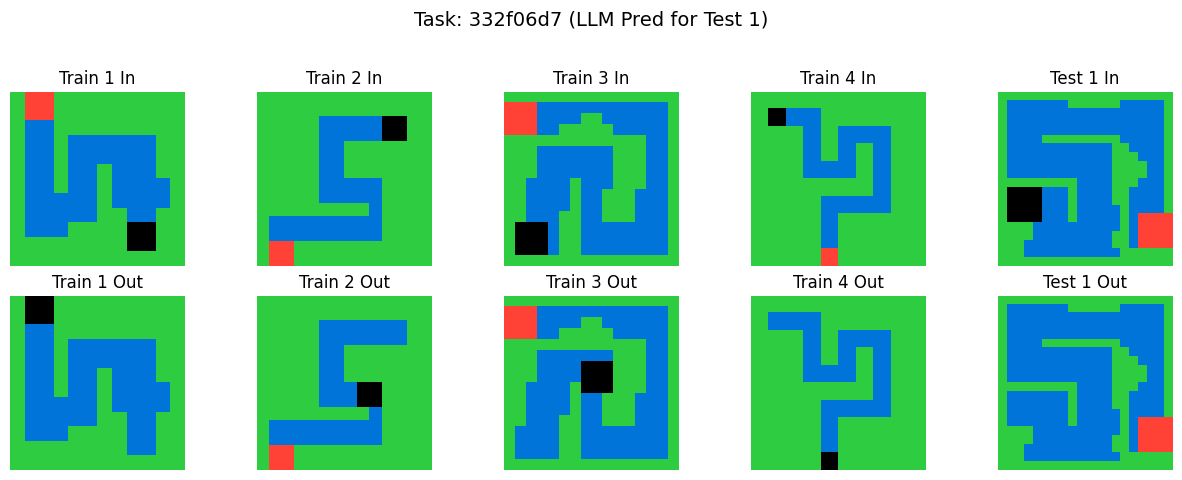

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 35ab12c3 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the given task, we first need to deduce the transformation rules from the provided train examples. After carefully analyzing each example, the following pattern emerges:

1. **Identifying Patterns:**
   - The values '1', '4', '7', and '8' tend to define regions or lines within the input grid.
   - These specific numbers appear to produce lines or shapes in the output, spreading across rows or columns, usually bordered by the same number.

2. **Bounding and Filling Rule:**
   - If a number is above or below another instance of the same number, complete the line (horizontally or vertically) using that number between these points.
   - Numbers on the edges of blocks or regions seem to fill in the block boundaries or sides completely.
   - When a line or shape is completed with a number, the surrounding regions inside this bounded area are filled w

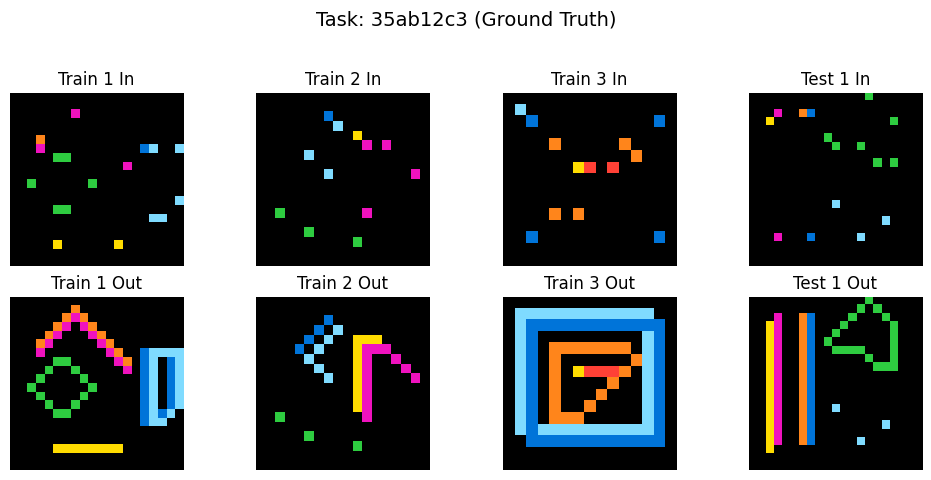


--- LLM Prediction (Task: 35ab12c3 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 36a08778 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the given transformation task, let's identify the transformation rules based on the provided examples.

### Step-by-Step Transformation Rules:

1. **Initial Observation**:
    - In the input grids, we mainly have cells filled with the numbers `7`, `6`, and `2`.
    - The transformations involve changing some of these numbers, specifically adding more `6`s and repositioning them based on other numbers, `2`.

2. **Transformation Rule Deduction**:
    - The primary change occurs around the numbers `2`. Sequences of `2`s in the grid are "framed" by `6`s in the output.
    - For any row containing the number `2`, identify the narrowest block of `2`s:
      - **Left Border Expansion**: Starting from the right border of these `2`s, fill in `6`s extending to the left for one extra column.
      - **Righ

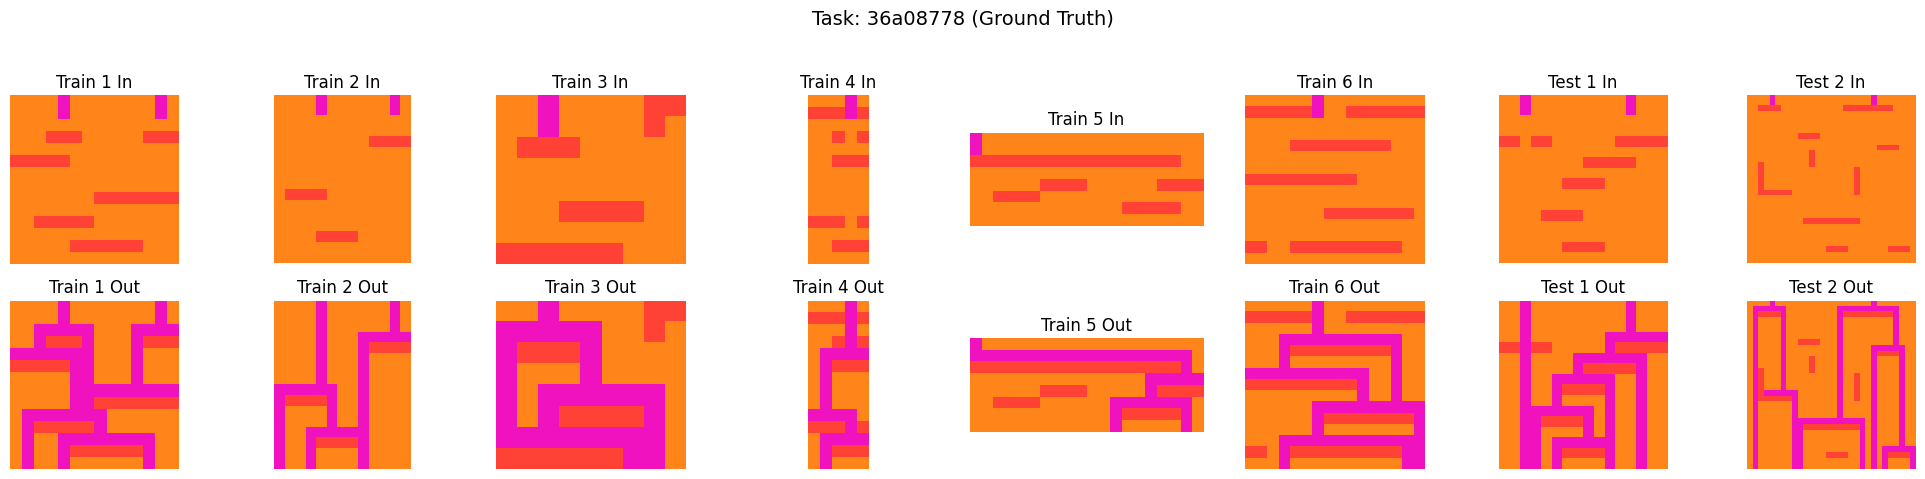


--- LLM Prediction Visualization (Task: 36a08778 / Test: 0) ---


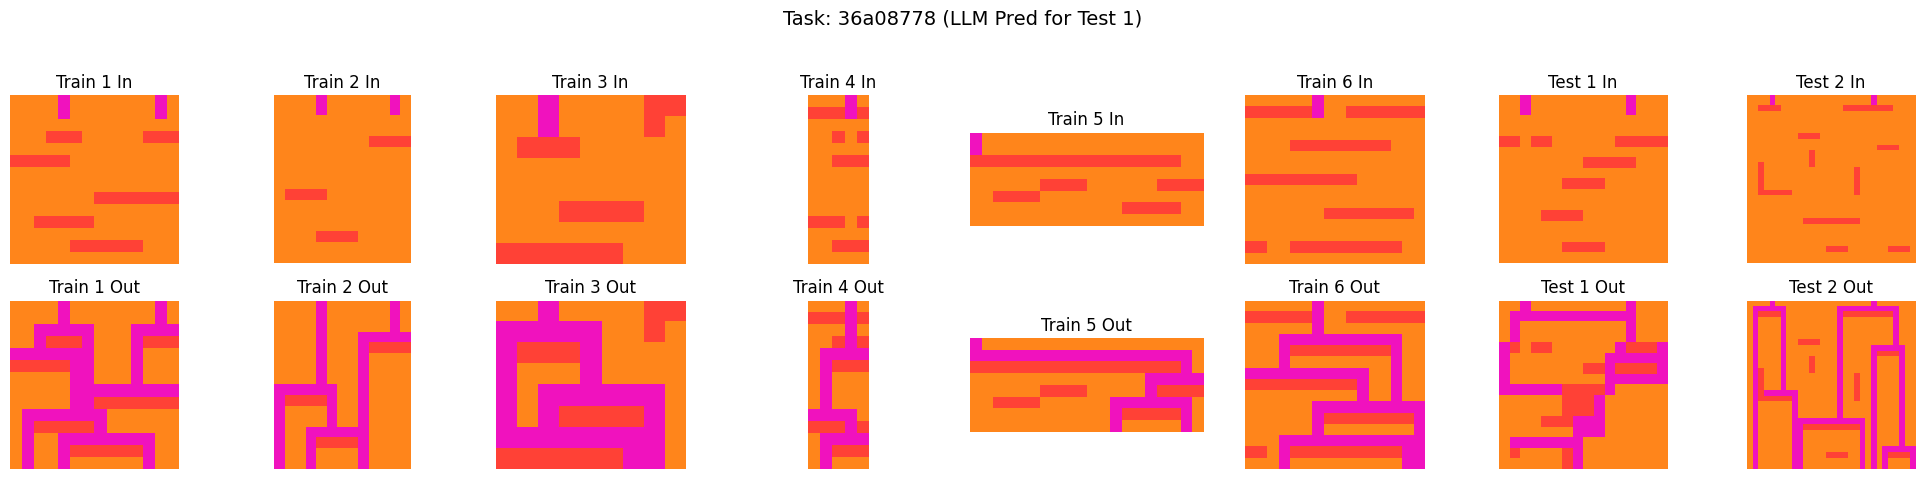

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 36a08778 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to analyze the patterns and transformations applied to the inputs to produce the outputs in the training examples. Here's a detailed breakdown of the transformation rules deduced from the training examples:

1. **Identify Blocks of '2's:**
   - The input grids contain segments or blocks of '2's that vary in size and location.

2. **Surround Blocks with '6's:**
   - The transformation involves surrounding the blocks of '2's with '6's on all four sides wherever possible.
   - Specifically, if a row contains '2' elements, the '6's replace the '7's directly adjacent to the '2's on that row, vertically or horizontally.

3. **Ensure '6's Do Not Overlap Originally '6' Cells:**
   - The number '6' from the input remains intact in the output. The existing '6's, if present adjacent to '2's, should not be replaced by newly added '6's

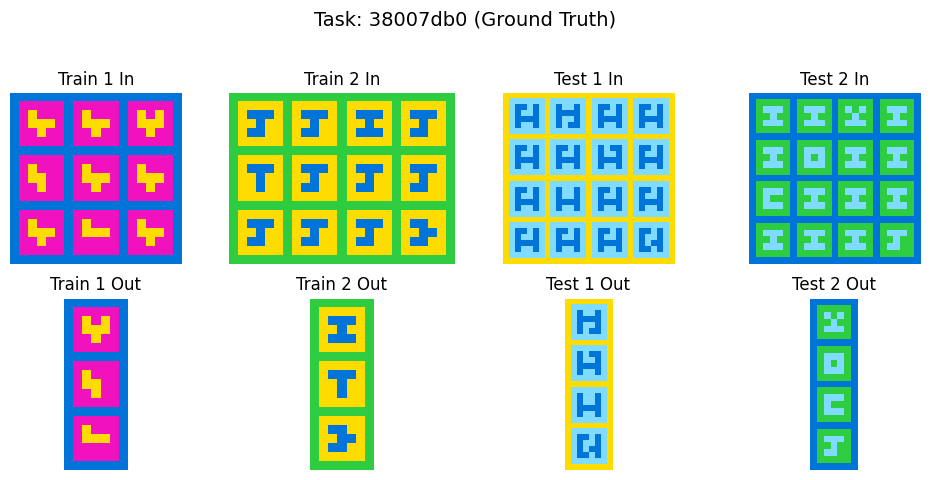


--- LLM Prediction Visualization (Task: 38007db0 / Test: 0) ---


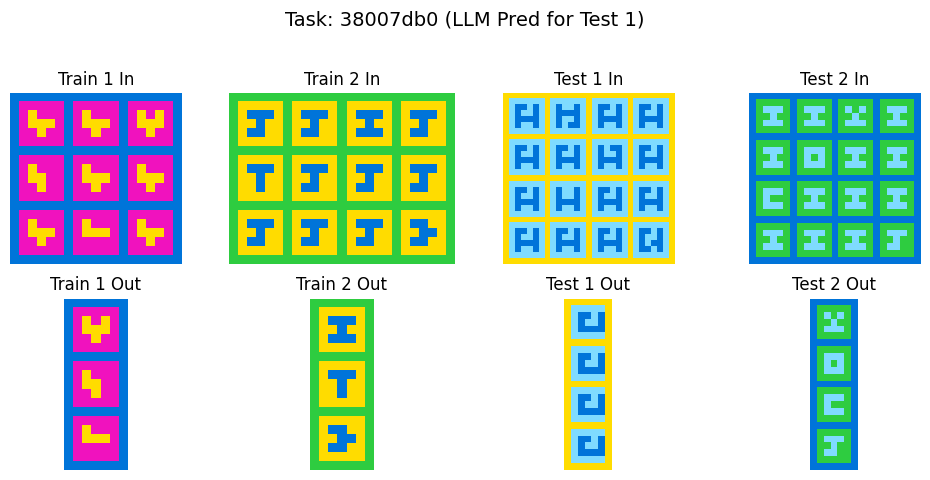

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((25, 7) vs (29, 8)))


===== Task: 38007db0 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to analyze how the given input grids are transformed into the solution grids. By observing the provided training examples, we can deduce a specific pattern the input grid is being broken down into smaller segments, or "blocks", and how those blocks transform.

### Deduced Transformation Rules:
1. **Identify Pattern Blocks**: Each row is divided into blocks of 6 units (excluding the border), which are transformed independently.
   
2. **Matrix Reduction**: From each row in the input (which is an extended pattern with multiple blocks), extract only a single representative block to form the new grid. For example, if the full row length is 19, only the first and last segment worth 7 cells are reduced into one.

3. **Block Extraction**: Focus on reducing the row based on the pattern repetition:
   - For grid 

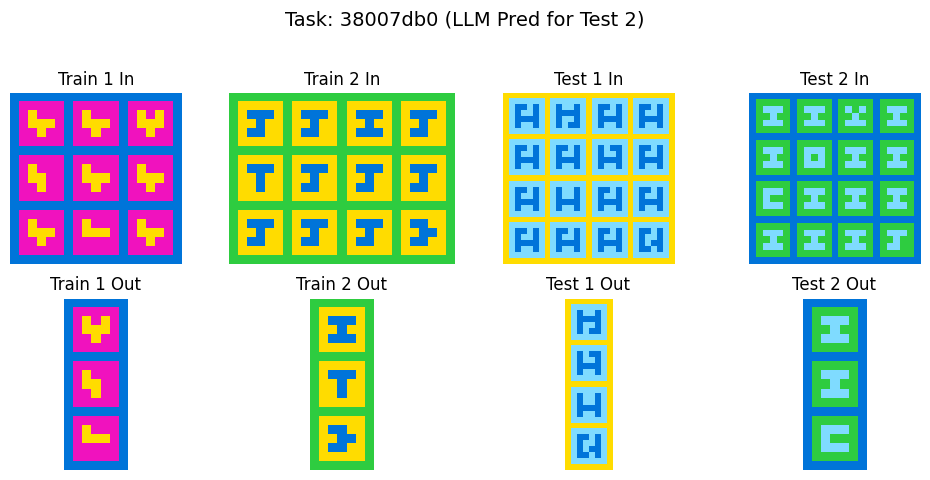

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((19, 7) vs (25, 7)))


===== Task: 3a25b0d8 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce a set of transformation rules that are applied consistently across the examples to convert the input grid into the desired output grid. Let's analyze the given examples.

### Analyzing Example 1:

**Input Grid:**
- A 22x22 grid with various regions containing clusters of the numbers 1, 3, 4, 6, 7, 8, and 9. The region boundaries are filled with the number 8.

**Output Grid:**
- The grid is reduced to a 11x11 grid, keeping significant clusters of numbers intact. The outer boundary and irrelevant areas from the input (denoted by 8) are removed.

**Pattern Observed:**
- The output involves extracting a central region that captures significant number clusters, while trimming away the peripheral parts of the grid.

### Analyzing Example 2:

**Input Grid:**
- A 22x22 grid with a different configurati

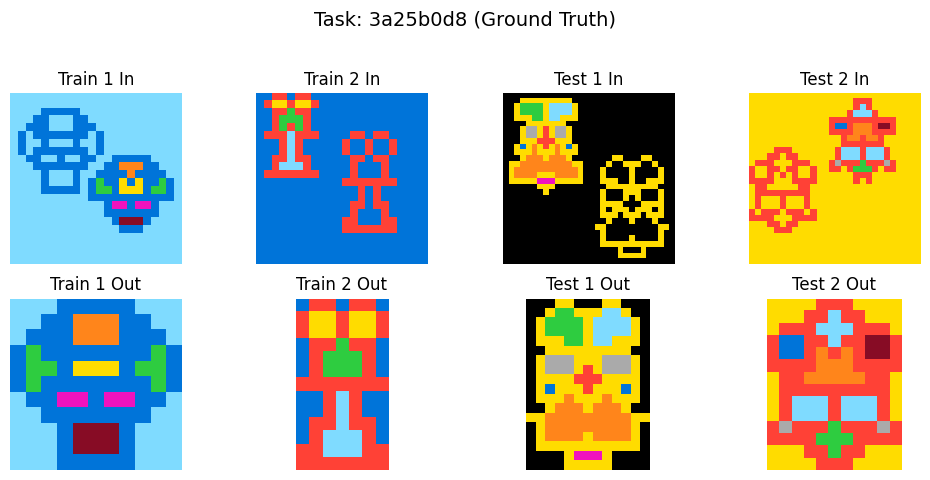


--- LLM Prediction Visualization (Task: 3a25b0d8 / Test: 0) ---


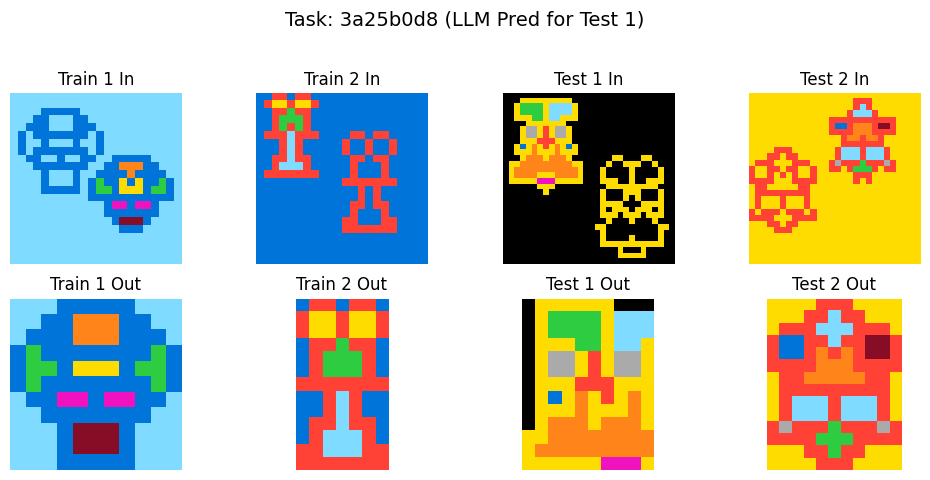

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((13, 10) vs (18, 13)))


===== Task: 3a25b0d8 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, let's carefully examine the transformations applied from input to output in the given training examples.

### Observations from Training Examples:

1. **Identifying Patterns/Cores**:
   - Both examples have patterns/cores made up of non-background values (e.g., numbers other than the background value `8` in Example 1 and `1` in Example 2).
   - These patterns are essentially "shapes" or "structures" within the input grid that we need to extract.

2. **Determining Background Value:**
   - The "background" appears to be the constant value filling the outer regions of each input matrix (`8` in Example 1, `1` in Example 2, and `4` in the test input).

3. **Resizing/Trimming the Input:**
   - The output matrices are essentially centrally cropped versions of the input matrices where excess background is removed.
   

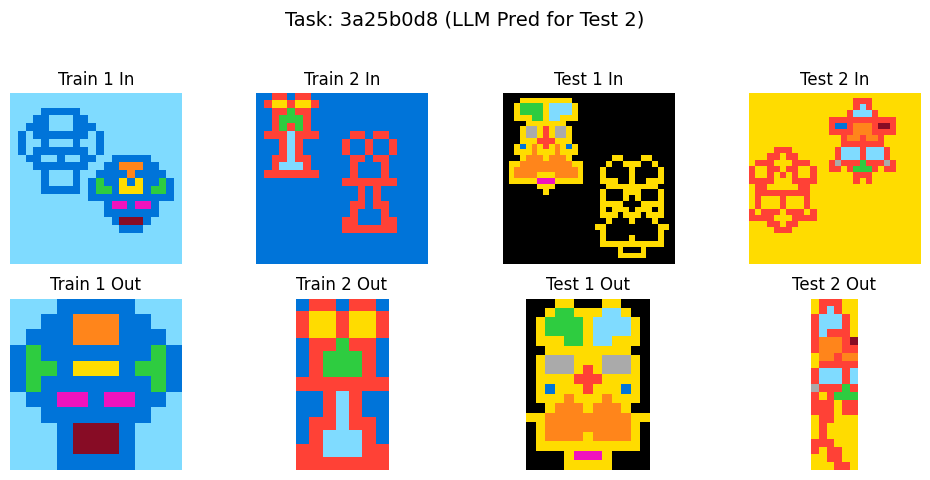

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((22, 6) vs (14, 11)))


===== Task: 3dc255db / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce how the transformations are achieved for the given training examples, let's examine the changes between the input and output grids:

### Observations and Deductions:

1. **Identify Certain Patterns:**

   - In each example grid provided, specific numbers (features) appear to be "shifted" or "cleared" while others are replaced entirely.
   
   - Each number seems to have a role or transformation rule associated with it, which can also be positional.

2. **Feature Behavior:**

   - **Example 1:**
     - The `4` pattern on the top area remains similar.
     - The `6` on the third and fourth rows seem to have shifted right while an empty space is introduced.
     - The `7` moves left in the bottom `3` row.
   
   - **Example 2:**
     - `3` seems stationary except in the top rows.
     - The presence of `9` is manipulated. It i

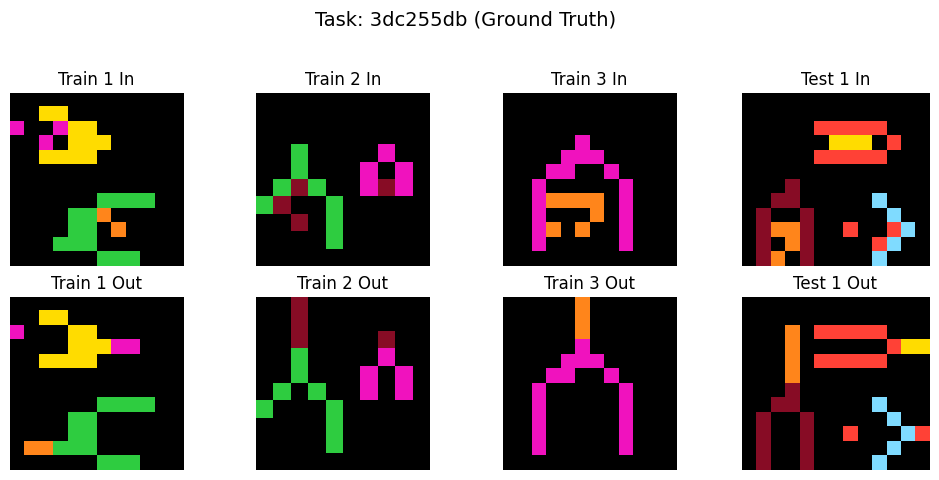


--- LLM Prediction Visualization (Task: 3dc255db / Test: 0) ---

Error during LLM prediction visualization for 3dc255db, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.


===== Task: 3e6067c3 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the transformations, let's first analyze the rules applied to the input grids to achieve the output grids in the provided examples. 

### Rule Analysis:

**General Observations:**

1. **Preservation of Background:** 
   - The number `8` acts as a background in all examples and is preserved in its position throughout the transformations. We will check if it's the same with `1` in the test example.
   
2. **Pattern Detection and Duplication:**
   - When specific numbers like `2`, `3`, `4`, `5`, `6`, `7`, `9` appear within regions surrounded by `1`s, they are "expanded" horizontally within their bounded rows or vertically 

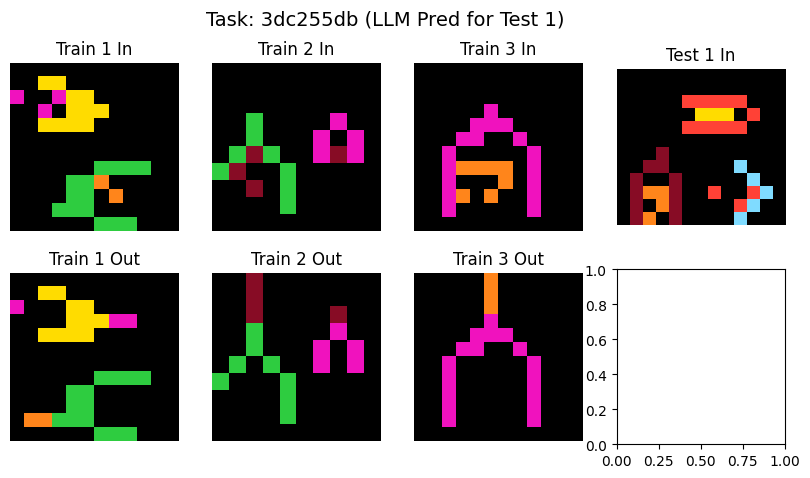

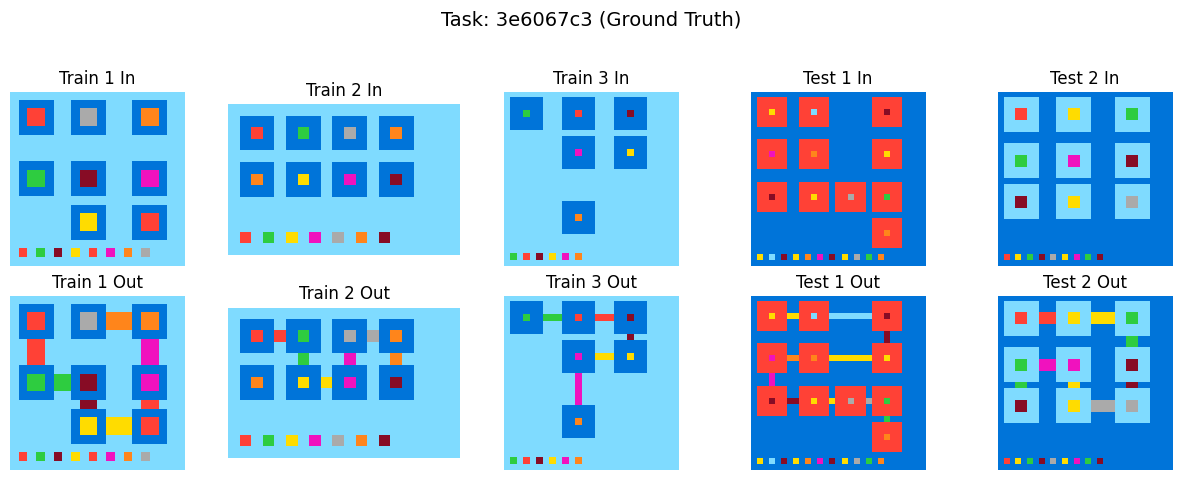


--- LLM Prediction Visualization (Task: 3e6067c3 / Test: 0) ---


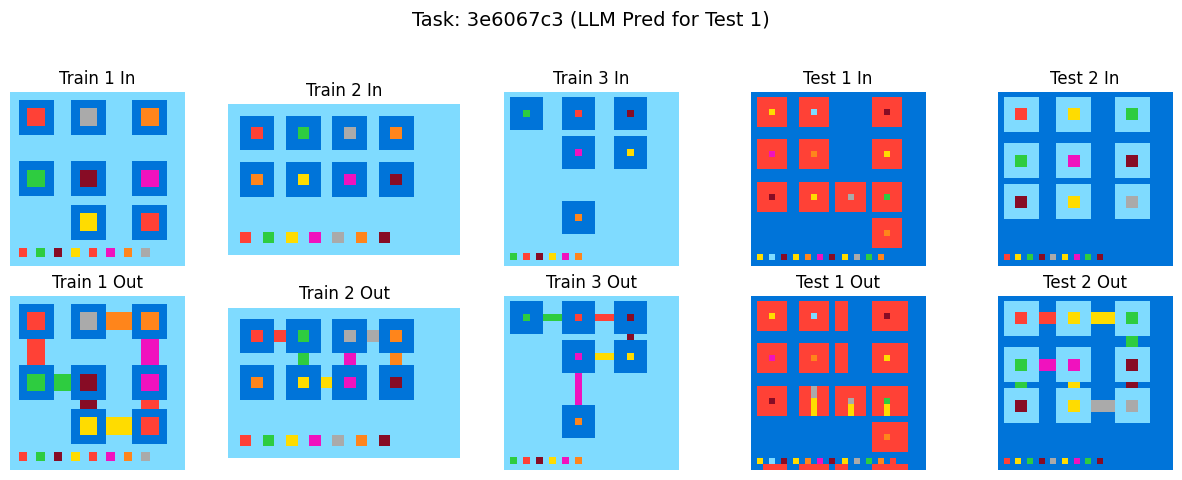

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 3e6067c3 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, I need to identify a pattern to transform the input grid into the output grid. Let's break down the transformations observed in the provided examples:

### Observations:

1. **Group Detection:** In each example, there are distinct groups of numbers inside an `8` boundary. The groups have their unique structure within the `8` cells.
  
2. **Central Transformation:** Inside the groups (those not bordered by continuous `8`s), a specific number appears centered or repeated in the original input, and further extensions of that number vertically or horizontally in the examples.

3. **Reinforcement/Mirroring:**
   - For Example 1, certain numbers from the rightmost column of each group spread horizontally or vertically, filling the adjacent `8` gaps.
   - Any center number with a unique identifier (such as `2`, `3`, `4`) on the boundary of 

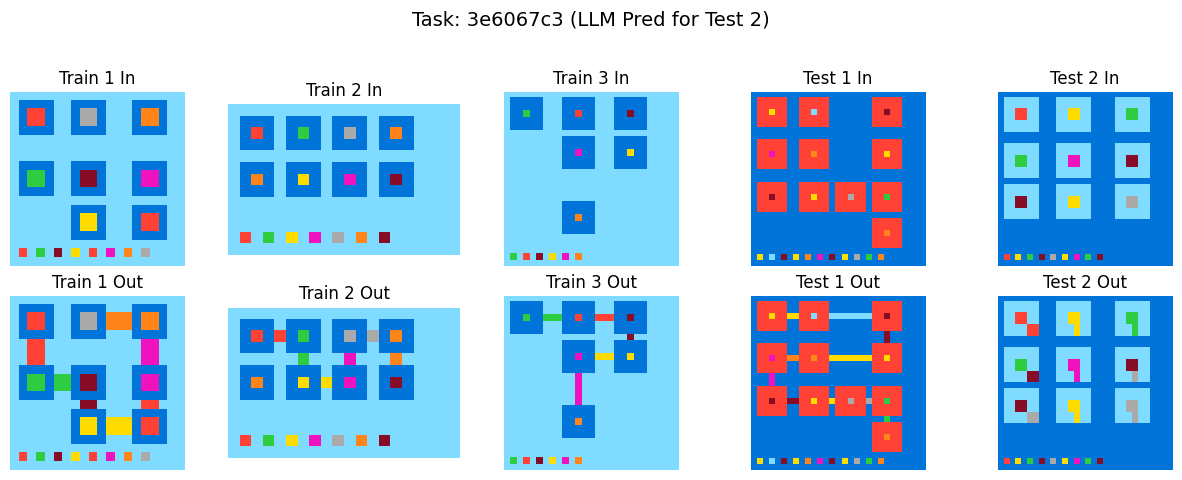

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 409aa875 / Test Case: 0 =====

--- Raw LLM Response ---
```
The transformation rule that appears consistent across the provided train examples involves identifying the diagonal line of a specific number and alternating them with the number 9.

**Identified Rule:**

1. **Diagonal Identification**: 
   - Identify non-7 numbers that appear on either straight diagonals (top-left to bottom-right or top-right to bottom-left). Since the task doesn't specify a fixed start for diagonals, we will look at any displayed diagonal patterns.
   
2. **Alternate Replacement**:
   - On the identified diagonal line, starting from the smallest index, replace every alternate position with the number 9.
   
3. **Unchanged Pattern**:
   - All other numbers remain unchanged.

**Applying This Rule to the Test Input:**

1. From the test grid, identify the diagonals formed by the non-7 value, which is 6 in this instance:
   - Diagonal 1: 

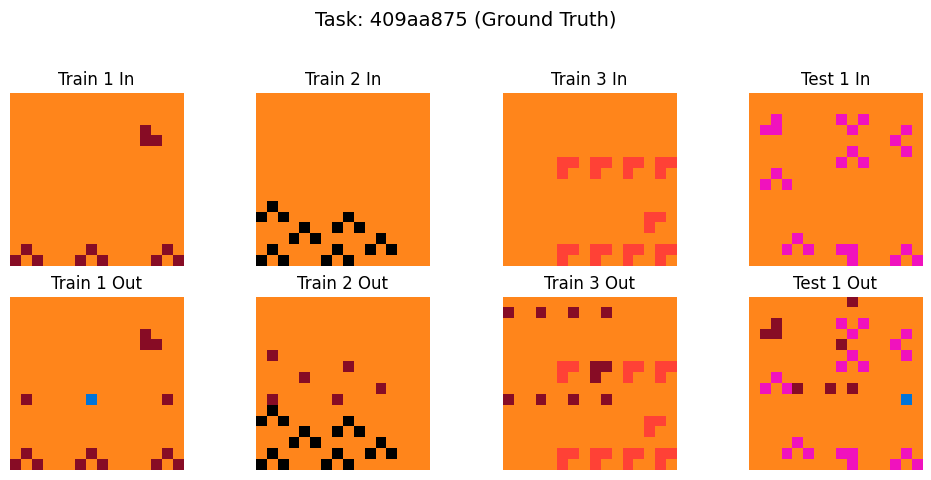


--- LLM Prediction Visualization (Task: 409aa875 / Test: 0) ---


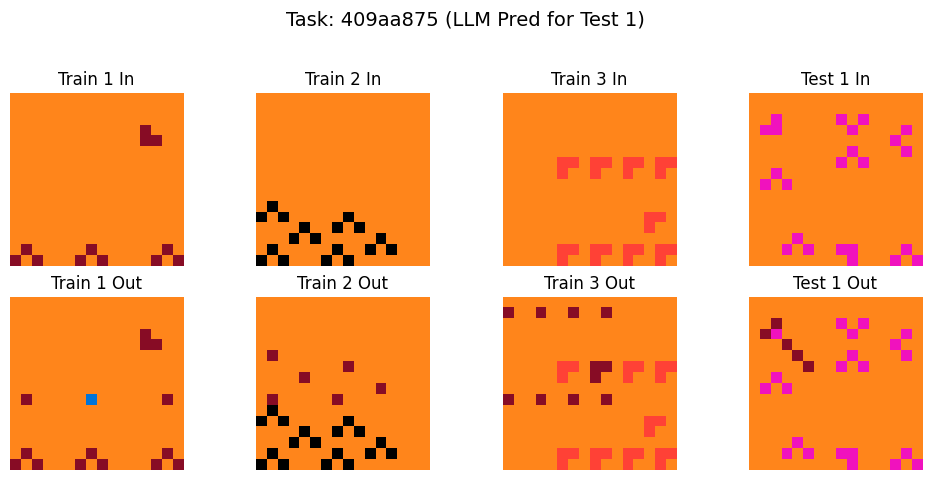

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 446ef5d2 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we must deduce and apply transformation rules that convert the input grid into the corresponding solution grid. Let's analyze the provided examples:

### Analysis of Transformation Rules:

#### Example 1:
- **Input vs. Solution:**
  - We observe that all "8" cells outside the main region remain unchanged.
  - There are distinct regions of numbers: 7s, 2s, and 0s.
  - Each colored region seems to be expanded outwards while maintaining its structure internally.
  
- **Transformations:**
  - Regions defined by certain numbers are expanded to fill available space.
  - Specifically, regions expand outwards by one layer.
  
#### Example 2:
- **Input vs. Solution:**
  - Similar to Example 1, all "8" cells primarily on the borders remain unchanged.
  - A middle inner region expands outward with consistent coloring, filling in gaps.
  
- **

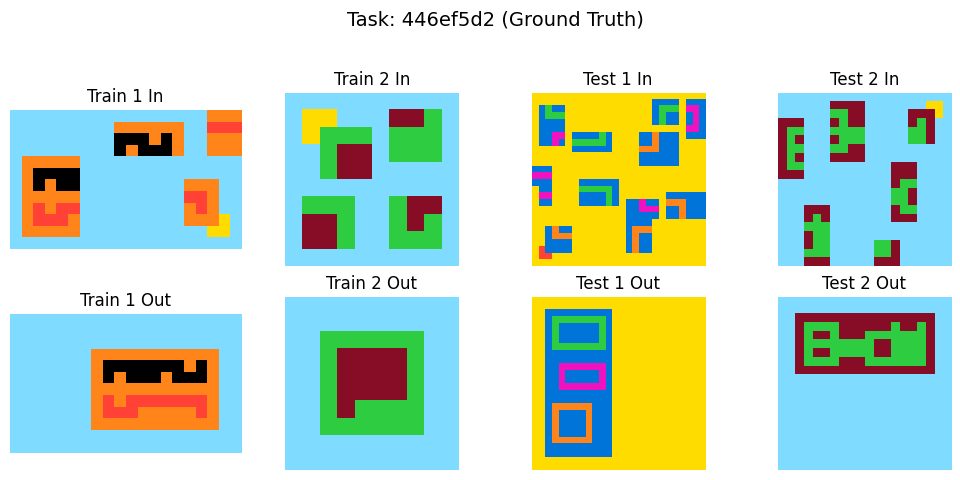


--- LLM Prediction Visualization (Task: 446ef5d2 / Test: 0) ---


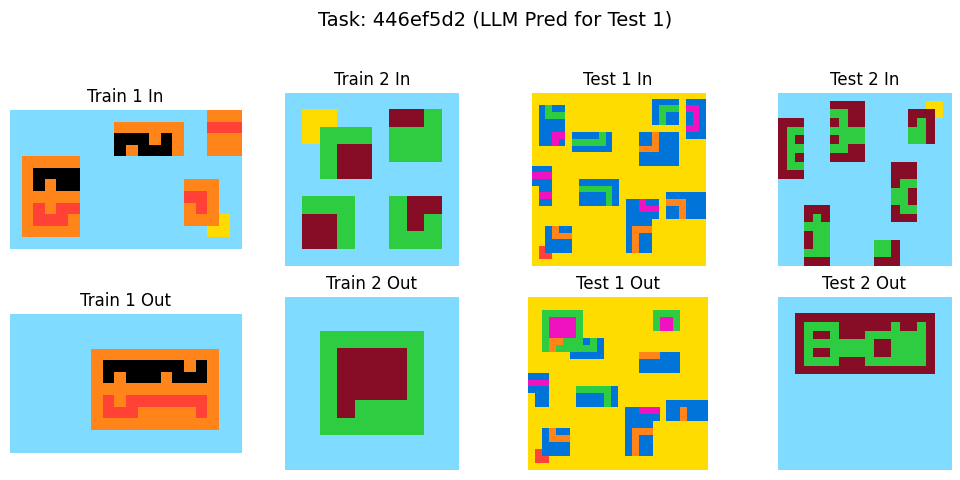

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((25, 26) vs (26, 26)))


===== Task: 446ef5d2 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify and apply transformation rules that match the provided examples. The input and output examples suggest that the task is to transform specific regions or structures within the grid while maintaining the overall grid format. After analyzing the train examples, here are the deduced transformation rules:

### Transformation Rules:
1. **Background Identification:**
   - The background in the grid is represented by the number `8`. This number should remain unchanged.
   
2. **Target Pattern Identification:**
   - Identify continuous regions of a specific number that are surrounded by a different number. These appear as blobs or clusters of either `7`, `2`, `0`, `3`, `9` in the examples.
   
3. **Transformation of Clusters:**
   - Convert the clusters identified in the target pattern provided and 

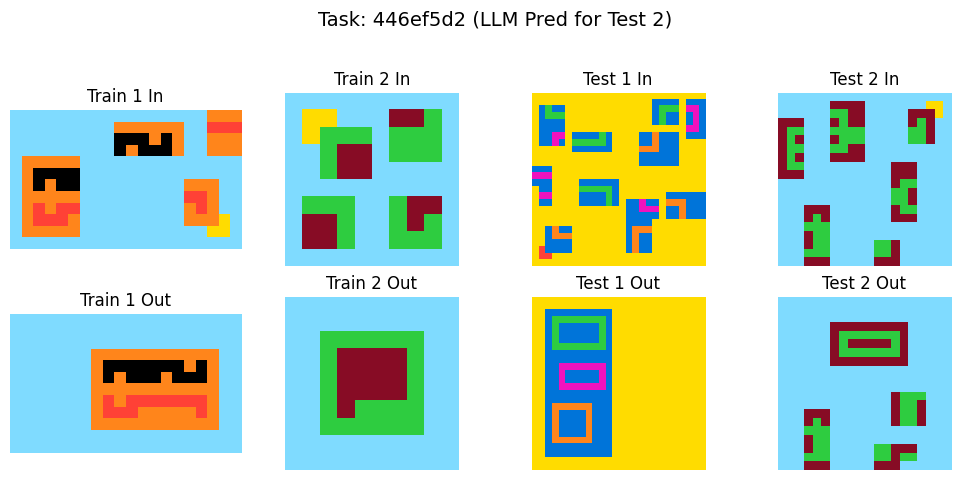

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 45a5af55 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to develop a set of rules to transform the input grid into the output grid, as observed in the examples given.

### Observations:

1. **Grid Expansion**: 
    - In the solution grids, each row and each column from the input grid is expanded by two cells on each side with a specific color seen in the example output.
  
2. **Frame Colors**:
    - The outermost expanded frame of the grid duplicates the color of the outermost elements of the input grid.

3. **Pattern and Mirror Mapping**:
    - The central part of the input grid is copied to the central part of the solution grid.
    - The expanded areas/margins around the central pattern carry repetitive filling patterns of mirrored input values.

### Deduced Rules:

1. **Frame Expansion**:
    - Add a frame of two cells (most of times filled with the edge values of the input

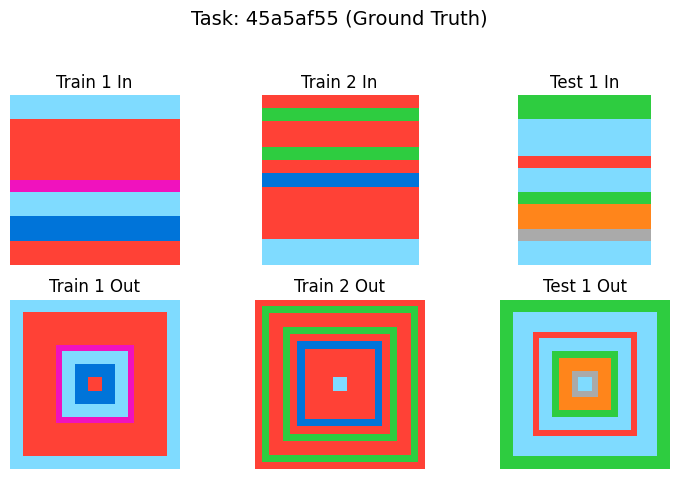


--- LLM Prediction Visualization (Task: 45a5af55 / Test: 0) ---


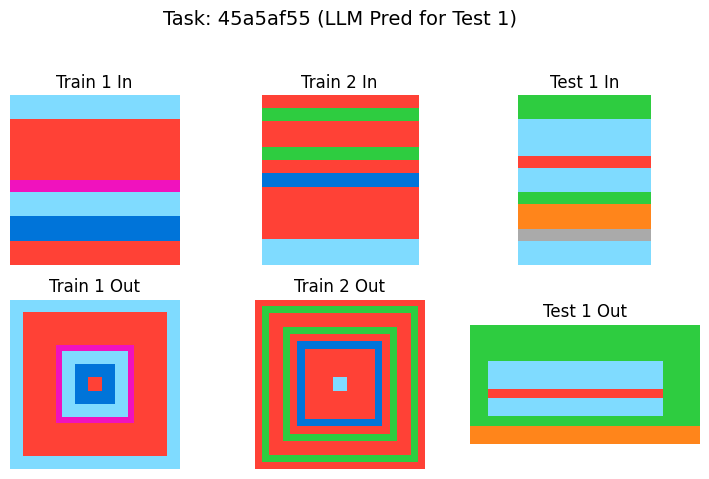

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((13, 25) vs (26, 26)))


===== Task: 4a21e3da / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify the transformation rules that convert the input grid into the output grid in a systematic way using the provided training examples.

**Observations from Training Examples:**

1. **Clusters of 7s:**
   - In each example, there are distinct clusters or groups of 7s within the input grid. These clusters appear to be modified in both position and form in the output.

2. **Translating Clusters:**
   - These clusters are displaced in the output. Specifically, they expand or shift in the grid. For instance, parts of the cluster that are in one location in the input are moved to another part in the output.

3. **Location of 2:**
   - In each input, the location of '2' is relatively unchanged, but its presence seems to have a "drawing" effect on the 7s — either pulling them towards it or symmetrical

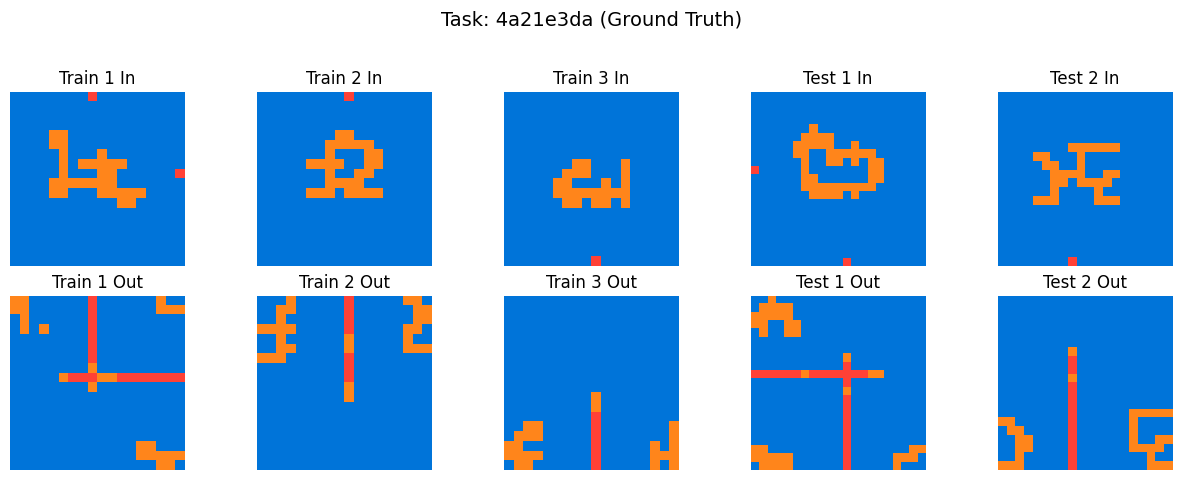


--- LLM Prediction Visualization (Task: 4a21e3da / Test: 0) ---


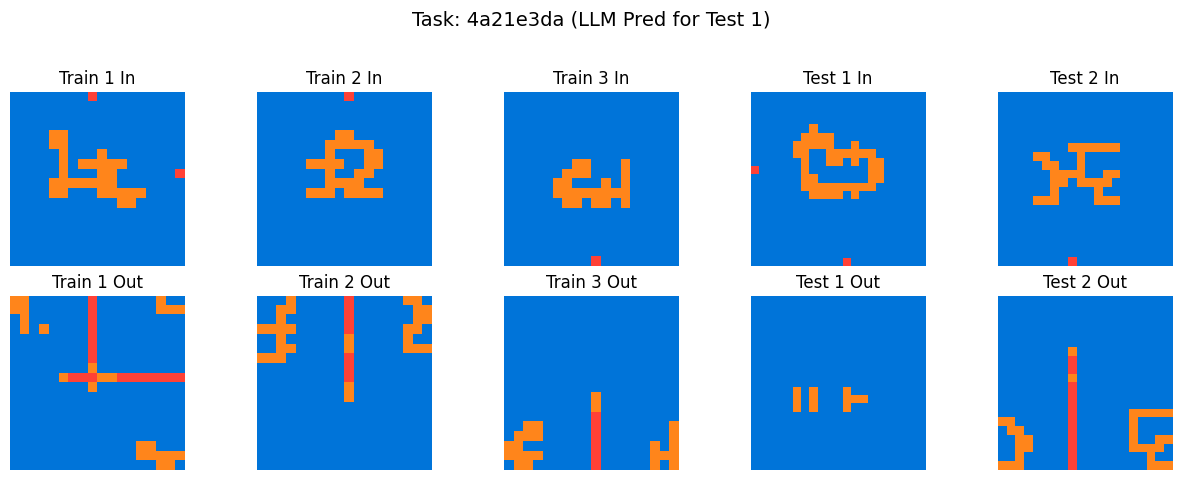

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 4a21e3da / Test Case: 1 =====

--- Raw LLM Response ---
```
To determine the transformations from the input to the output, let's closely inspect the provided examples:

### Analyzing Train Examples:

#### Example 1:
- **Input structure**: The grid is mostly filled with `1`s, with some `7`s forming a U-shape and `2`s at specific positions.
- **Observations**: 
  - There is a vertical column of `2`s forming a nested "U" shape within a preexisting "U" shape of `7`s.
  - Some of the `7`s in the input seem to be moved to different positions in the output.

#### Example 2:
- **Input structure**: Similar to the first example, except the positions of `7`s are different, forming an irregular shape.
- **Observations**:
  - Again, `2`s form their distinct pattern in a U shape in the middle.
  - Many `7`s have been typically shifted to the edges or in line with the first and last positions of the input.

#### Example 3:
- *

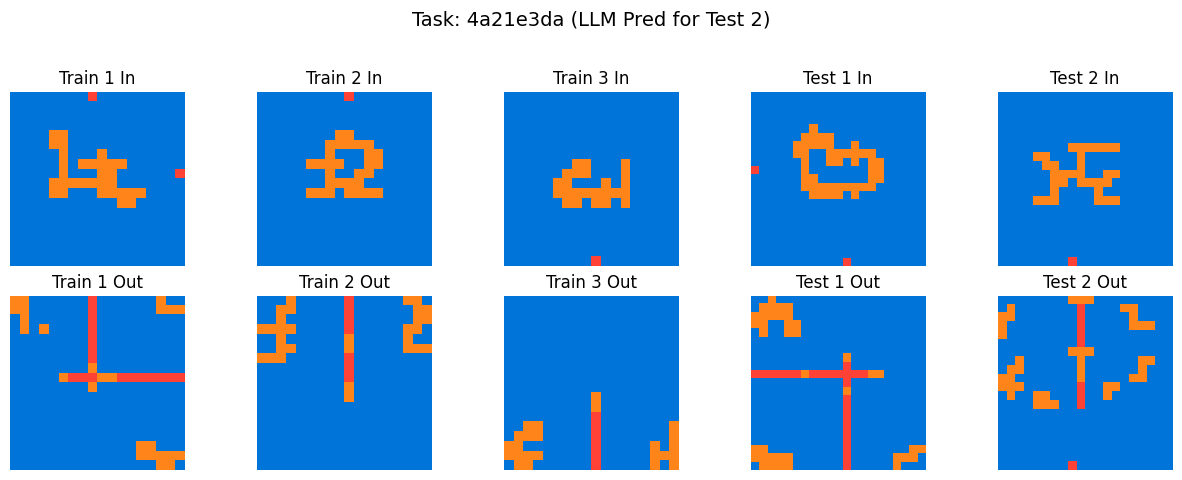

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 4c3d4a41 / Test Case: 0 =====

--- Raw LLM Response ---
```
To derive the solution for the given task, we need to identify the transformations applied from the input grid to the output grid in the train examples.

### Analysis of the Given Examples:

1. **Structure of the Grid:**
   - The grid is a matrix where most of the values are `0` except for some cells that contain values `5`, `3`, `4`, `2`, `7`, `6`, `8`, `9`.

2. **Pattern Observed:**
   - In both examples, the value `3` is replaced by the smallest non-zero adjacent value. Adjacency includes immediate left, right, top, or bottom.
   - Other numbers (e.g., `5`, `4`, `2`, etc.) maintain their position unless they are the smallest adjacent to a `3`.

3. **Transformation Rule:**
   - Find all occurrences of the number `3` within the grid.
   - Replace each `3` with the smallest non-zero number among its immediate neighbors (left, right, top, bottom).
   - E

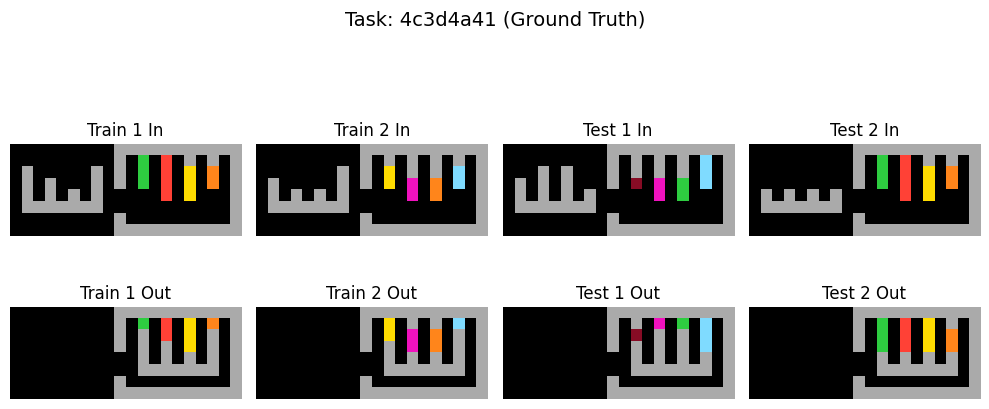


--- LLM Prediction Visualization (Task: 4c3d4a41 / Test: 0) ---


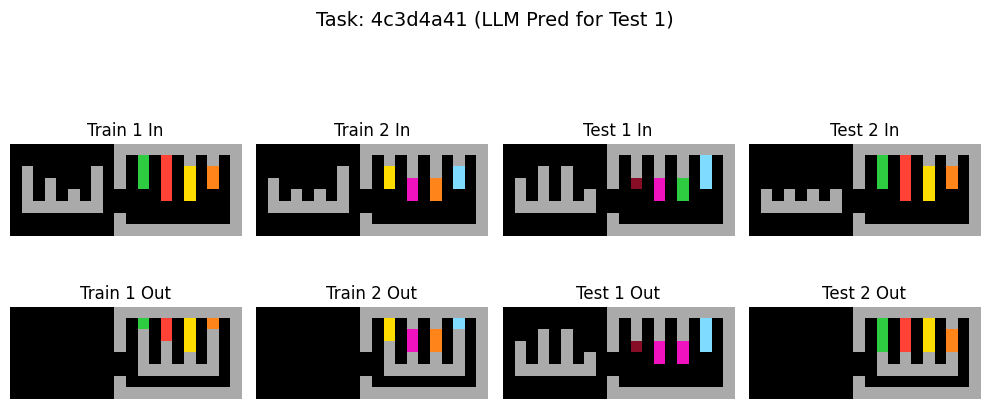

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 4c3d4a41 / Test Case: 1 =====

--- Raw LLM Response ---
```
To transform the input grids into the desired output grids, let's examine the differences between the input and output examples to deduce a set of transformation rules.

### Observations:
1. Values `3`, `2`, `4`, `7` are present in the input. Each of these values is replaced by a different value or remains in the same place in the output.
2. The boundaries of the grid primarily consist of `0` and `5`, which remain unchanged.
3. The notable changes happen around the numbers `3`, `2`, `4`, `7` within the grid:
   - In Example 1:
     - `3` at position (1,11), (2,11), (3, 11) transformed to `4` at (2,11).
     - `2` at position (1,13), (2,13), (3, 13), (4,13) transformed to `5` at (3,13).
     - Numbers `5`, and `3` near other numbers aren't affected by these transformations directly, only at those specific positions.
   - In Example 2:
     - Similar patt

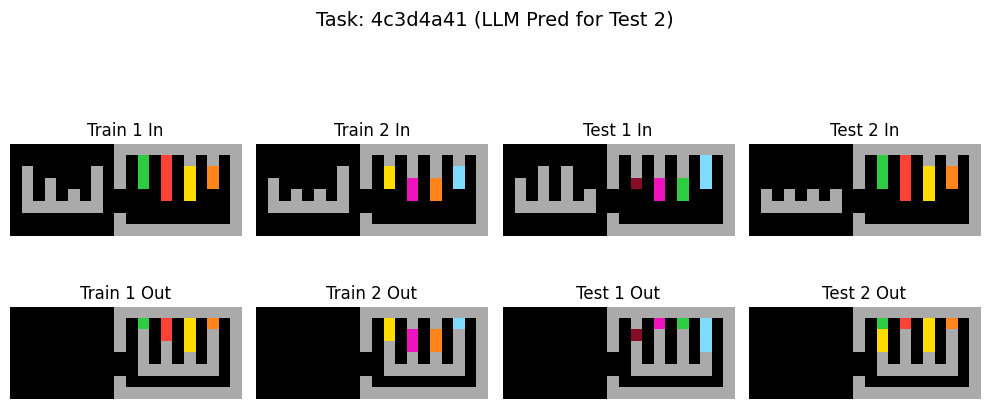

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 4c416de3 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to understand the pattern of transformation from the input grid to the output grid as seen in the training examples. Let's analyze the train examples to deduce the transformation rules:

### Observations from Train Examples:

1. **Colored Numbers and Their Regions**:
    - There are numbers embedded within a '0'-bounded region and possibly across other numbers. The task seems to be about expanding or converting these numbers into a wider region within the boundary of 0's while maintaining certain parts of the grid unchanged.
  
2. **Color Proliferation**:
    - The numbers within a '0'-enclosed area appear to grow outward. When touching a '0', neighboring cells are filled with the same number. However, this proliferation does not seem to cross other numbers unless those numbers were in the path of the original spread.

3. 

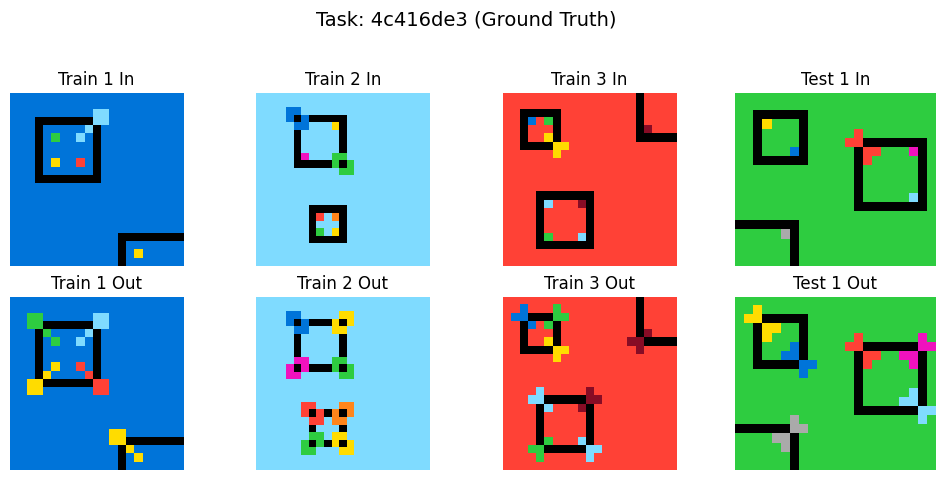


--- LLM Prediction Visualization (Task: 4c416de3 / Test: 0) ---

Error during LLM prediction visualization for 4c416de3, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.


===== Task: 4c7dc4dd / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, let's analyze patterns and transformations between inputs and outputs in the training examples:

### Analysis of Example 1:
Input:
- Has size 30x30.
- Values range from 0 to various single-digit numbers.

Output:
- A 5x5 grid with a combination of mostly `0`s and a few specific numbers (like `6` and `2`).

### Analysis of Example 2:
Input:
- Has size 30x30.
- Encoded numbers and varied patterns appear.

Output:
- A 4x4 grid with specific numeric patterns.
- Mostly `0`s, with a few `2`s interspersed, no specific number appearing in a full row or column fashion like Example 1.

### Common Patterns and Transform

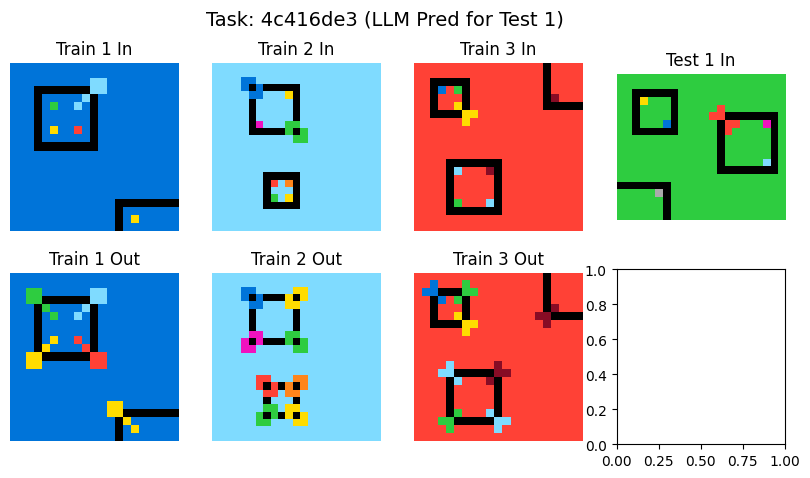

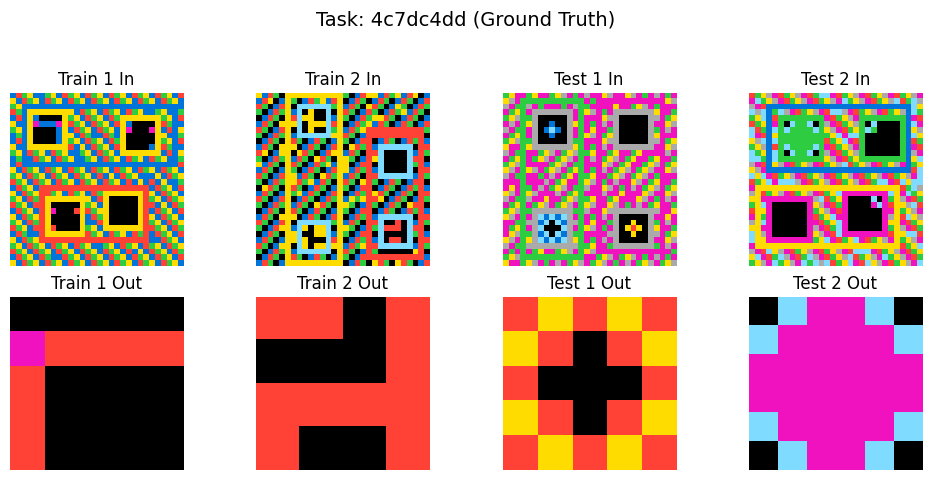


--- LLM Prediction (Task: 4c7dc4dd / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 4c7dc4dd / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce a transformation rule that converts the given input grids into the desired output grids. Based on our analysis of the provided training examples, here are the steps we can take to identify the transformation rules:

1. **Grid Resizing and Reduction**: Both training examples deal with reducing a large grid (30x30) into a smaller output grid (5x5 or 4x4). The transformation seems to involve extracting a sub-grid from the larger grid.

2. **Selection of Specific Sections**: The examples show that specific sections from the input grids are selected to form the output grid. This section typically consists of columns that appear to have non-standard patterns involving particular numbers in the context of columns in the grid. These sections resemble blocks of interesting

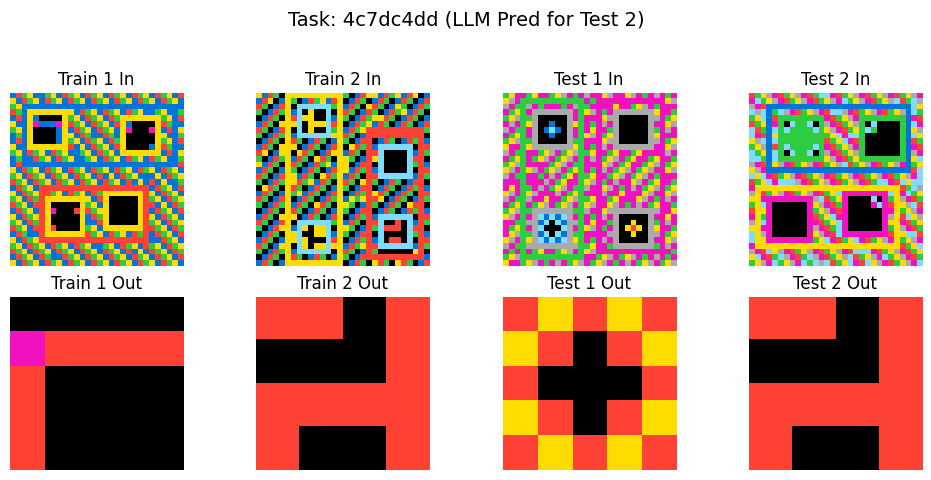

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((4, 4) vs (6, 6)))


===== Task: 4e34c42c / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we'll break it down based on the transformations observed in the training examples:

### Analyzing the Train Examples:

1. **Identify Region of Interest:**
   - Both examples have recognizable patterns embedded centrally in a larger filler/shaded area. The pockets of distinct numbers are surrounded by a single repetitive number.
   - We are interested in identifying these specific, focused patterns.

2. **Common Features of Interest:**
   - Certain rows in the examples contain sequences that are not part of the surrounding, uniform repeated value.
   - These sequences include distinct groups of numbers (like clusters of "1"s surrounded by other digits). 

3. **Extraction Strategy:**
   - Identify the minimal bounding box that encompasses all non-filler numbers in the grid. Essentially, find the smallest rectangle 

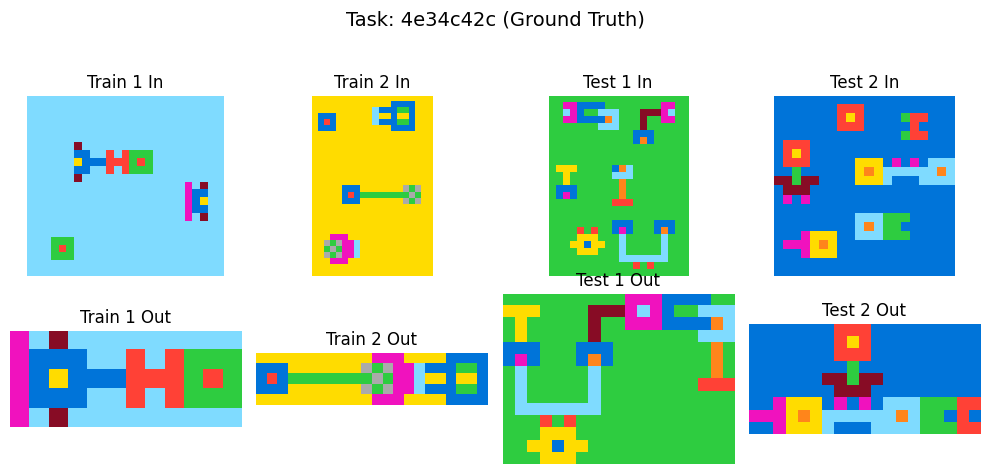


--- LLM Prediction Visualization (Task: 4e34c42c / Test: 0) ---


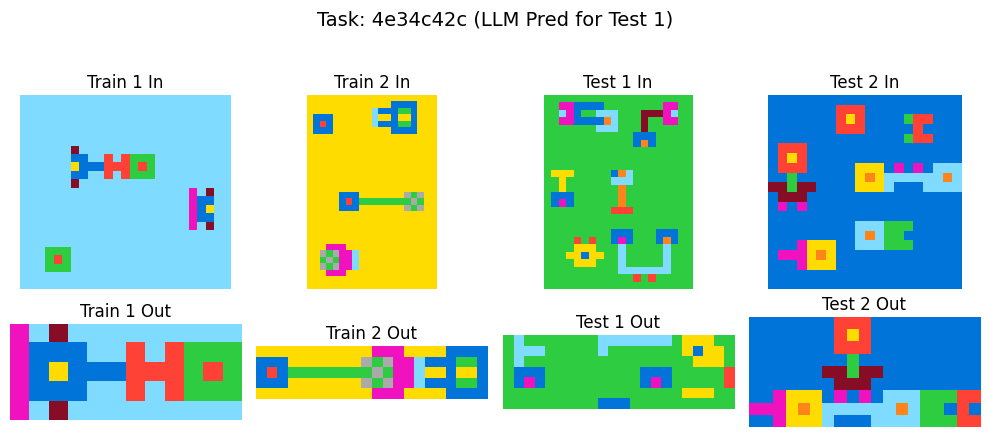

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((7, 22) vs (14, 19)))


===== Task: 4e34c42c / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given task, a defined pattern is recognized that needs to be extracted and transformed from the overall grid into a smaller subset of the grid. Let's break down the transformation rules based on the given training examples and apply them to the test input.

### Transformation Rules:

1. **Identify Feature Blocks**: In the given input grids, there are distinct sections where the numbers get diversified from the constant default number for most values (i.e., in Example 1, other than '8'; in Example 2, other than '4'). This pattern seems evident in a kind of symmetrical block or specific pattern of numbers grouped together.

2. **Central Block Extraction**:
    - From training examples, we observe that around the region with varying numbers (other than the constant default), there appears to be a distinct block of data to b

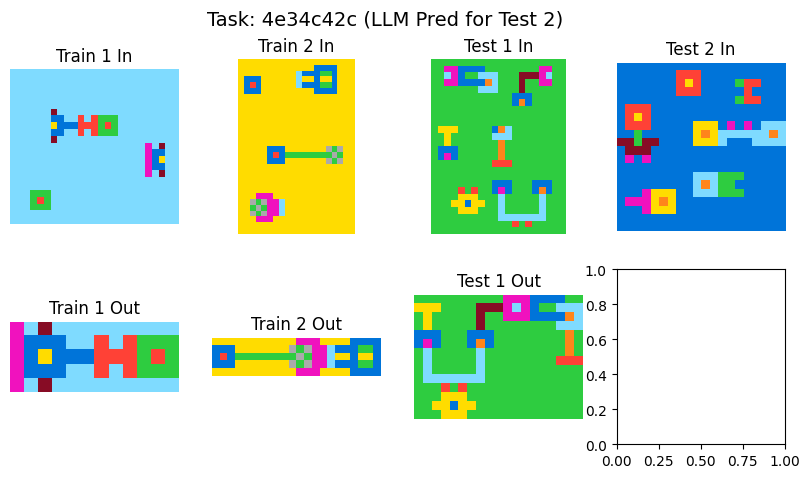

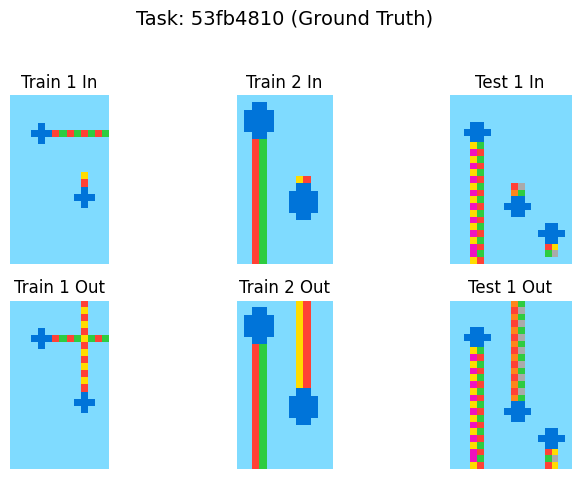


--- LLM Prediction Visualization (Task: 53fb4810 / Test: 0) ---


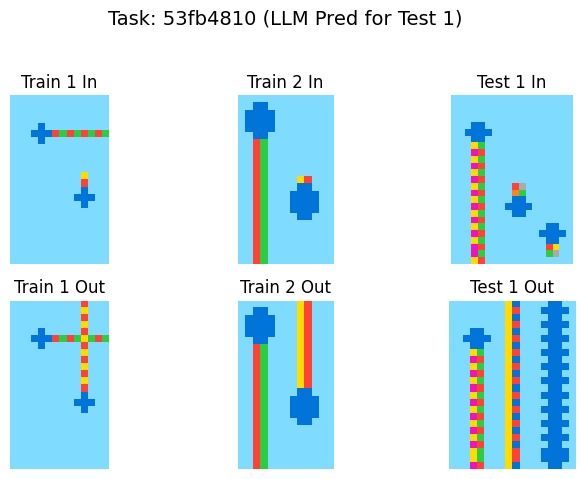

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((24, 18) vs (25, 18)))


===== Task: 5545f144 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the rules for transforming the input into the output, I have examined the provided examples:

1. **Identify sections in the grids:**
   - Each input grid contains sequences of numbers surrounded by or interspersed with different numbers, typically transitioning in the presence of a 'dividing' number. 
   - For example, in Example 1, the grid is organized into separate sections separated by the number 3.

2. **Pattern detection:**
   - These 'dividing' numbers (3 in Example 1, 2 in Example 2, and 4 in Example 3) guide us in deciding how to break down sections of the grid.
   - The solution sections are identified vertically along these dividers, resulting in fewer columns.

3. **Construct sub-grids:**
   - Each solution grid consists of certain selected columns derived from before these dividers appeared.
   - The task is t

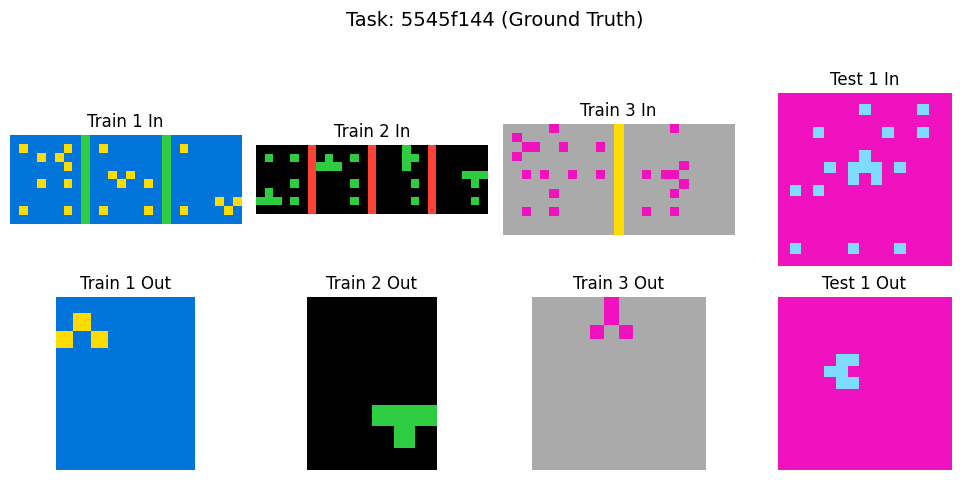


--- LLM Prediction Visualization (Task: 5545f144 / Test: 0) ---


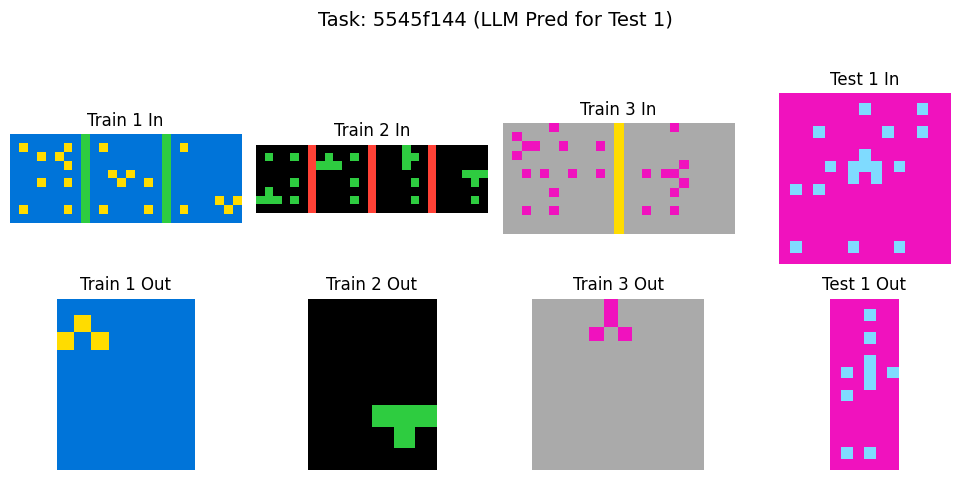

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((15, 6) vs (15, 15)))


===== Task: 581f7754 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this puzzle, let's break down the transformations step-by-step as observed in the training examples:

### Analysis of Transformation Rules:

1. **Identify Patterns:**
   - In each training example, the pattern involves grids where certain numbers (like `8`, `3`, `1`, `4`, `6`, `2`) form distinct patterns or shapes which are transformed in a particular way.
   
2. **Transformation Rules:**
   - We can observe that each distinct-shaped group of numbers in the grid (like blocks of `8s` or `3s`) gets translated to a different position in the grid.
   - Within these groups, the outermost number seems to determine the transformation for the group.
   - Specifically, numbers like `4` or `2` present in the group seem to dictate translating parts of the shape to a new location.

3. **Test for Consistency:**
   - By observing that the

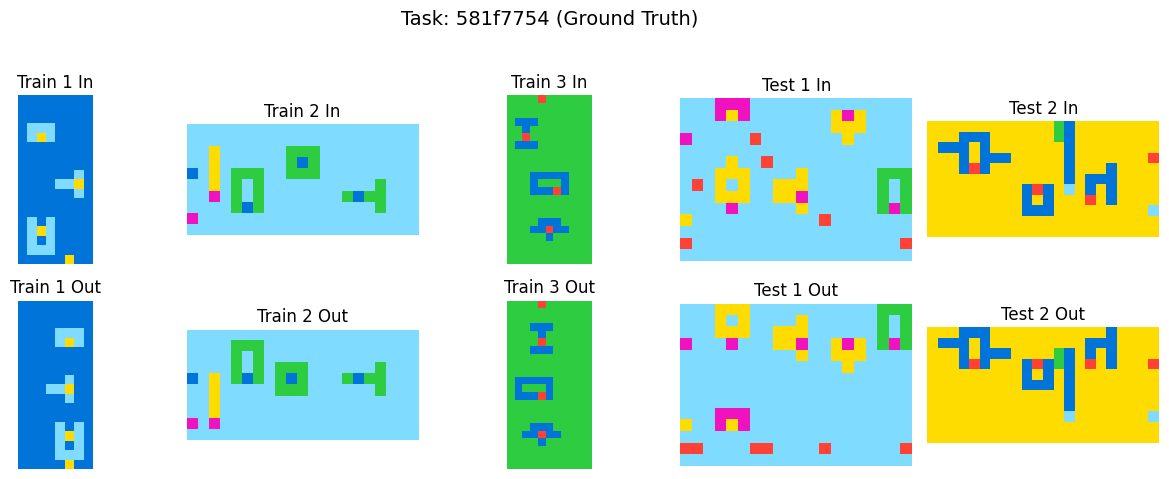


--- LLM Prediction Visualization (Task: 581f7754 / Test: 0) ---


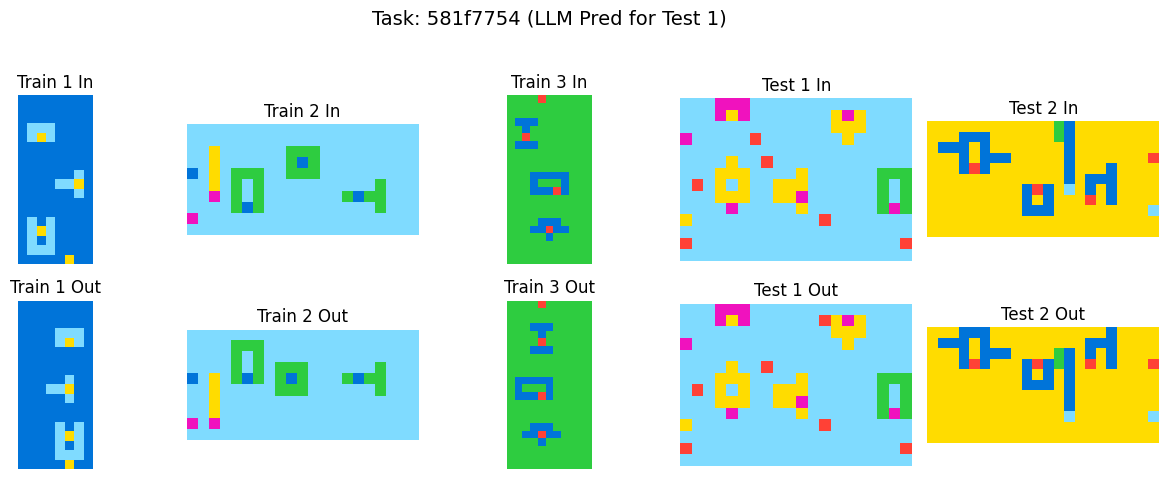

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 581f7754 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, let's analyze the given examples and deduce the transformation rules:

### Analyzing the Examples:

#### Example 1:
- The pattern seems to involve the number 4, which appears only once per group of connected numbers in the input. 
- In both groups containing the number 4, the numbers 8 and 1 surround it differently.
- The number 1 replacing numbers immediately surrounding such groups of 8s next to a 4.

#### Example 2:
- Similar to Example 1, transformers number 4 only appear once within groups of 8s or 3s.
- 3s expand to replace surrounding numbers creating a larger band of connected numbers.
- It seems the focus is on clusters of numbers, specifically 3s, and controlling how they extend by overriding surrounding positions, except when surrounded directly next to 4.

#### Example 3:
- Number 2 seems to be an anchor for 1s.
- 1s a

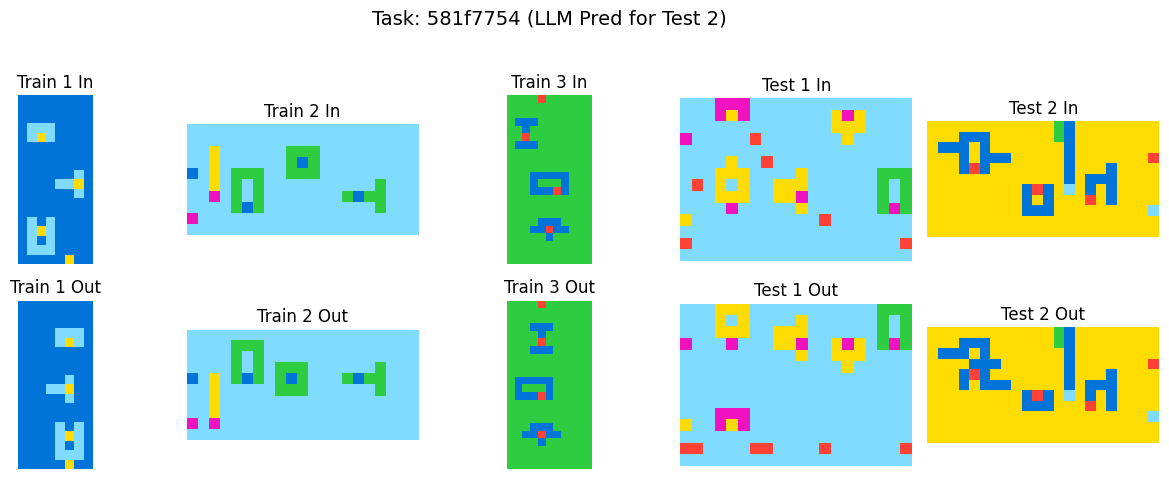

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 58490d8a / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce a transformation rule that maps the input grid to the output grid. By analyzing the train examples provided, we can identify a pattern and deduce the rules applied:

### Observed Patterns:
1. **Grid Extraction:**
    - In each example, we are extracting specific segments of the input grid to form a smaller output grid.
    - The extracted segments generally correspond to non-zero elements from the input grid, positioned in a recognizable sub-matrix form within the larger grid.
    - Elements seem to come from a defined central-ish part of the grid that contains non-zero values and is surrounded by zeros.

2. **Sub-grid Formation:**
    - The size of the sub-section extracted appears to be consistent within the context of each example.
    - The subgrid usually maintains the same non-zero values and zeros found in

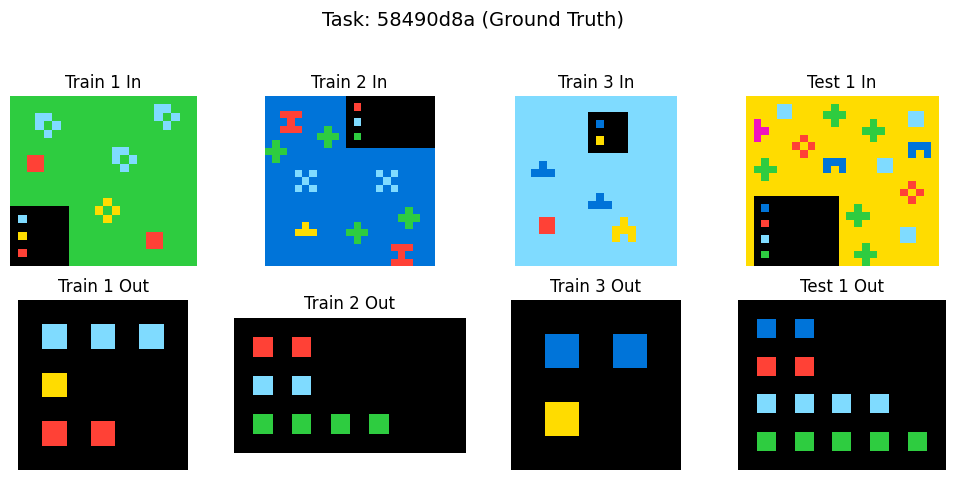


--- LLM Prediction Visualization (Task: 58490d8a / Test: 0) ---


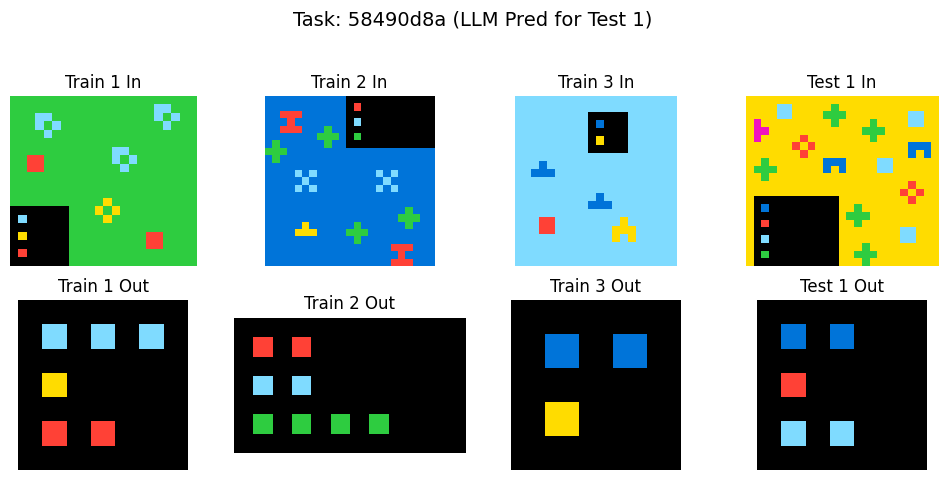

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((7, 7) vs (9, 11)))


===== Task: 58f5dbd5 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the given task, I'll analyze the provided examples and identify the transformed visual patterns between the input and output grids. 

**Pattern Analysis of Training Examples:**

1. **Example 1:**
    - The input grid has distinct blocks of numbers (e.g., 1s, 6s, 4s) surrounded by other numbers, with each distinct block having its own boundary values.
    - The output pattern retains the boundary but transforms the internal structure to more organized patterns.

2. **Example 2:**
    - This grid also has blocks of numbers (e.g., 1, 2, 3) enclosed in the boundary value 4.
    - Internal lines or separators of contiguous numbers (e.g., 9s, 6s) slice through this pattern, creating new groups.

3. **Example 3:**
    - Here, the contour patterns do not seem to deviate much from the other examples, but they maintain a strong outer bo

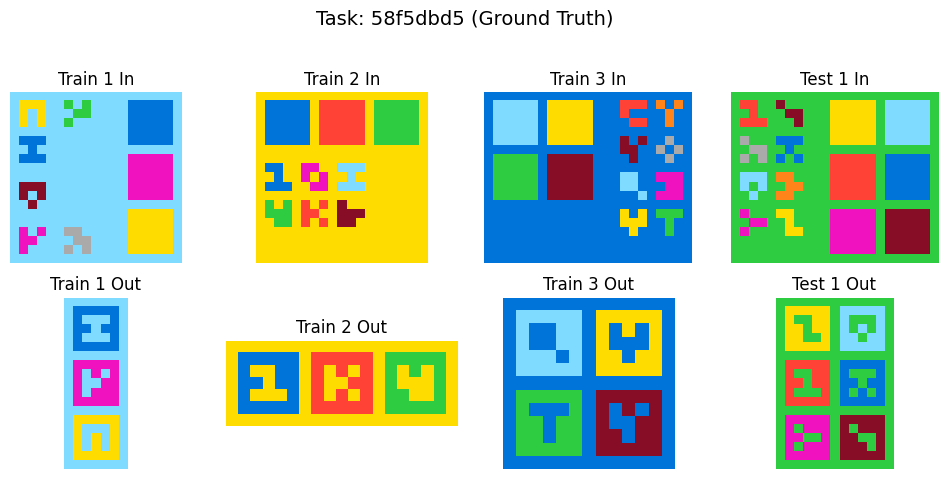


--- LLM Prediction Visualization (Task: 58f5dbd5 / Test: 0) ---


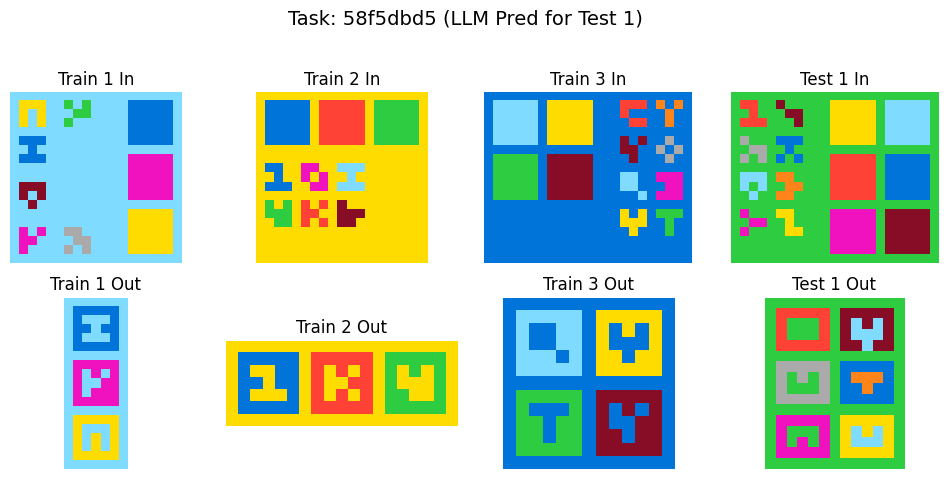

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((16, 13) vs (19, 13)))


===== Task: 5961cc34 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules, let's analyze the train examples:

### Observations:
1. **Detection of Patterns (Color `1`)**:
   - In all inputs, there's a pattern formed by the number `1`. It spans over multiple rows in a contiguous block, surrounded by `8`s.
   - In all solutions, the pattern of `1`s is replaced entirely by `2`s.

2. **Handling of Other Colors**:
   - Occurrences of other numbers such as `3` and `4` in the input are ignored in the output, suggesting they are simply non-functional or discardable noise.
   - Only the pattern of `1` seems to influence the grid transformation.

3. **Output Grid**:
   - The rest of the grid remains unchanged with `8`s.
   
### Rules to Achieve the Desired Outcome:
1. **Convert Patterns of `1` to `2`**:
   - Identify all contiguous blocks of the number `1` (i.e., line segments, rec

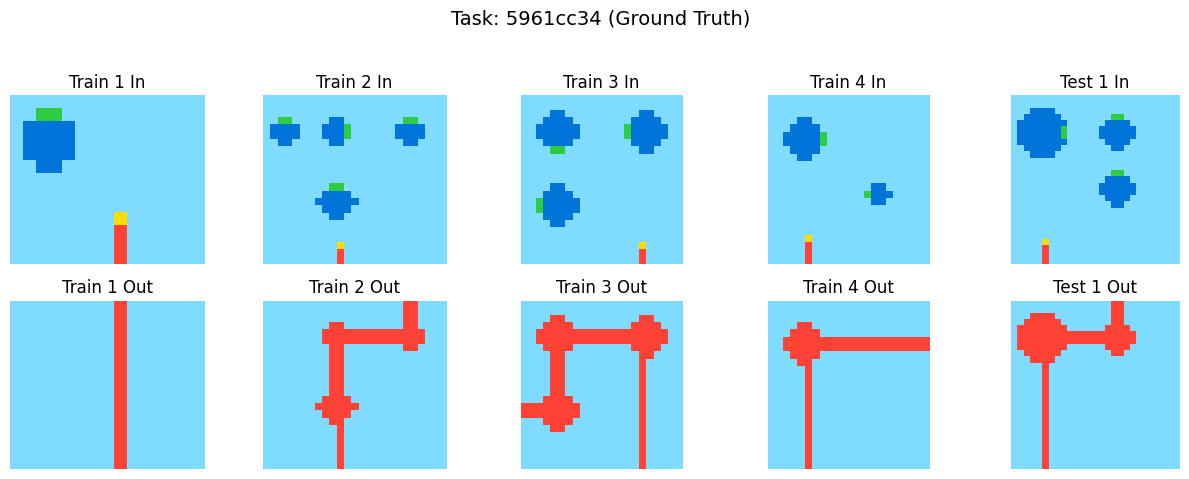


--- LLM Prediction Visualization (Task: 5961cc34 / Test: 0) ---


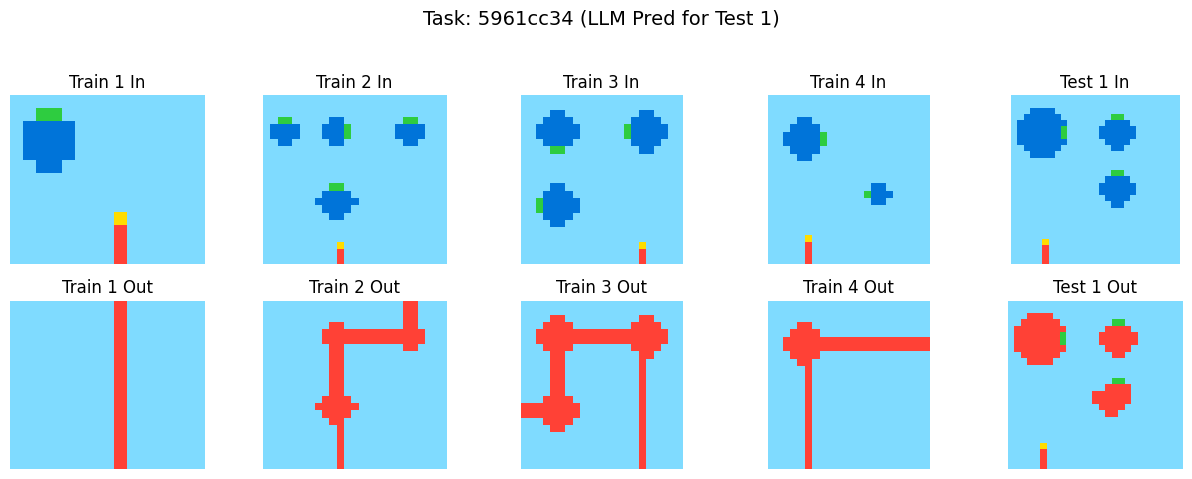

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((26, 27) vs (27, 27)))


===== Task: 5dbc8537 / Test Case: 0 =====

--- Raw LLM Response ---
```
In order to solve the problem, let's first analyze the two provided training examples, discern the transformation rules applied to the inputs to produce the outputs, and then apply the identified rules to the test case.

### Analysis and Rule Deduction

**Example 1 Transformation:**
- Input dimensions: 15x15
- Output dimensions: 15x7

1. Row Condensation: 
   - The 15 columns in the input collapse or condense into 7 columns in the output.
   - It seems like the transformation focuses on maintaining certain blocks of values, and others are removed between them.
   - Specifically, on inspection:
     - Columns `0 and 7` appear to be preserved fully (which correspond to column indices `0 and 1` in the new array).
     - Groups or blocks of unique numbers in the rows are preserved, for instance:
       - Blocks of specific numbers like 

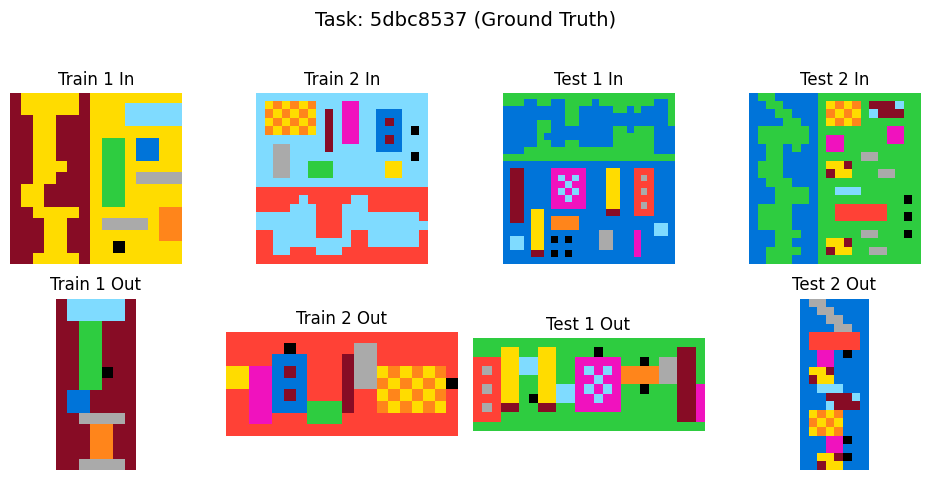


--- LLM Prediction Visualization (Task: 5dbc8537 / Test: 0) ---


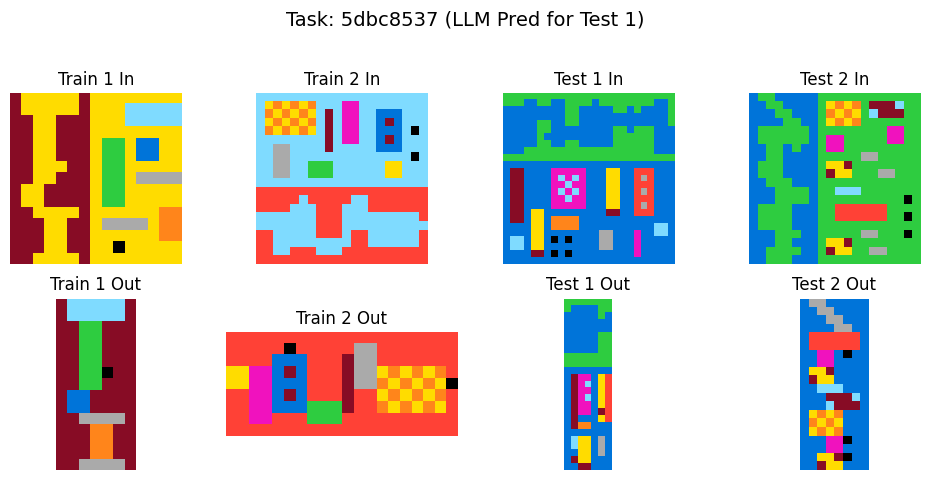

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((25, 7) vs (10, 25)))


===== Task: 5dbc8537 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem, we need to deduce rules based on the given patterns from the input and output training examples. The objective is to transform the input grid into the output grid by applying these rules. Here's a step-by-step analysis of the transformation:

### Observations:

1. **General Matrix Reduction:**
   - Both examples show a reduction in the size of the grid (from 15x15 and 20x20 to 15x7 and 20x10 respectively).

2. **Color Specific Retention and Removal:**
   - **Example 1:**
     - Colors 9, 8, 3, 7, 5, and the number 0 are retained, re-arranged, or altered.
     - Colors 4 and some regions of 8 are removed or altered.
   - **Example 2:**
     - Color regions like 5, 6, 7, 4 (these appear in the output grid as patterns), and 0 appear prominently.
     - Most of the continuous background regions of other numbers (exc

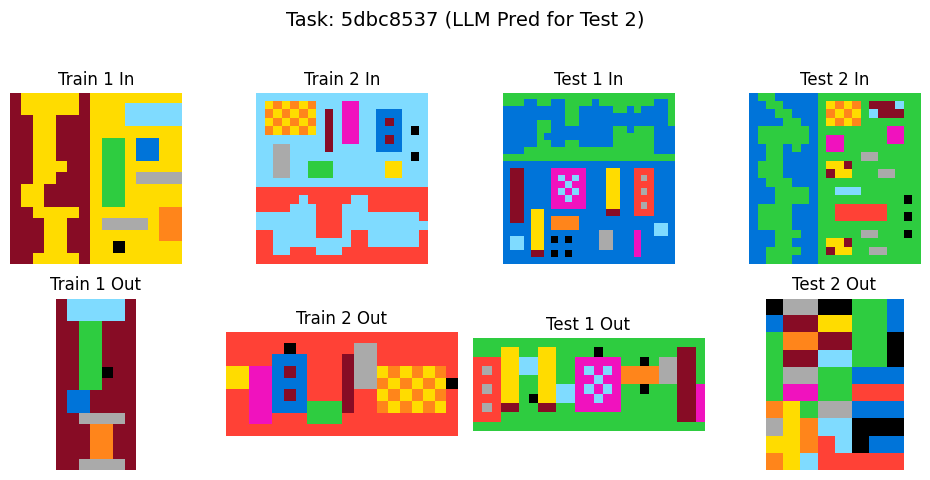

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((10, 8) vs (20, 8)))


===== Task: 62593bfd / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, I will deduce the necessary transformation rules based on the given examples and apply them to the test input.

**Analysis of the given examples:**

1. The task involves transforming a grid by rotating and/or repositioning specific colored segments. 

2. In Example 1, the colored blocks were repositioned as follows:
   - The block of "3" moves to the top left portion.
   - The blocks of "2" and "1" were repositioned below it to form a particular pattern.

3. In Example 2, similar transformations were followed:
   - The sequence with "2" was moved to the upper left.
   - Other unique segments of colors "3", "7", "9" and "4" found new positions forming a mirrored or rotated pattern.

**Common transformation pattern:**

- Identify and isolate distinct colored segments from the input.
- Reposition these segments tow

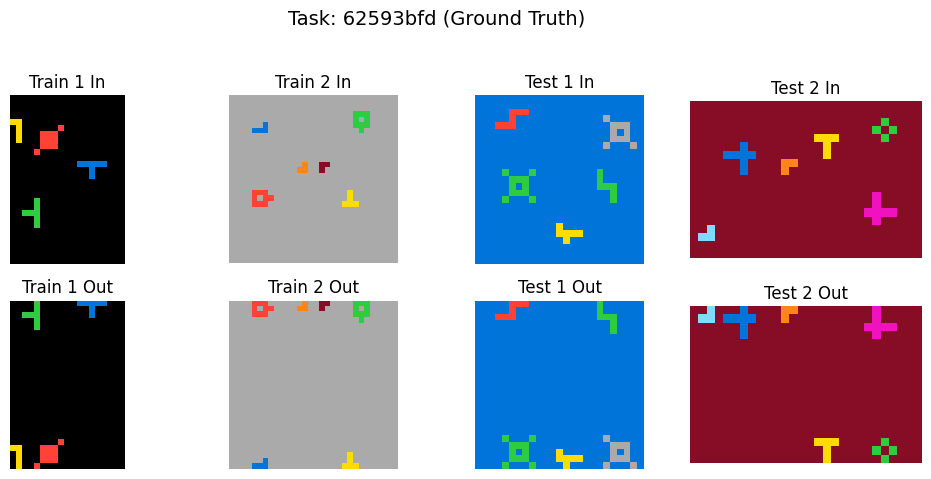


--- LLM Prediction (Task: 62593bfd / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 62593bfd / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given problem, we need to identify what transformation steps are applied to the input matrix to produce the output matrix in each example. I will examine the train examples to deduce the transformation rules:

### Analysis of Example 1:

- We have multiple colored elements on the grid represented by numbers: 1, 2, 3, and 4.
- In the solution:
  - The pattern enclosed by 4s appears in a new position at the bottom of the grid.
  - The pattern enclosed by 1s appears in a new position at the top right.
  - The pattern enclosed by 2s shifts upwards.
  - The pattern enclosed by 3s shifts upwards.

### Analysis of Example 2:

- We have multiple colored elements on the grid represented by numbers: 1, 2, 3, 4, 7, and 9.
- In the solution:
  - Patterns enclosed by certain colors appear to shift to dif

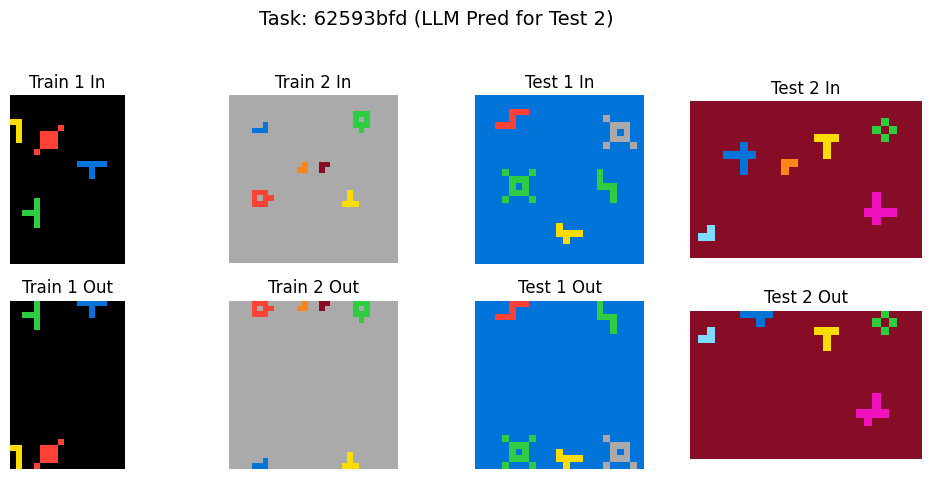

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((18, 28) vs (19, 28)))


===== Task: 64efde09 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to analyze the pattern observed in the example inputs and their corresponding outputs. 

### Observations:

In the given examples, we observe the following patterns:

1. **Vertical Replacement Based on Digits:**
    - In both example inputs, numbers such as 1, 4, 3, 2, 6, and 9 are replaced vertically. Specifically:
        - Each number vertically below a sequence of identical numbers is replaced with the numbers exactly similar to the ones in those previous positions.
        - If a digit is not directly below another same number, it will not change.

2. **Sequence Lines:**
    - Each vertical sequence of numbers causes the surrounding rows to be filled with sequences of that number. For instance, a vertical sequence of the number 1 causes the rows below it in the same column to fill with 1.
    
3. 

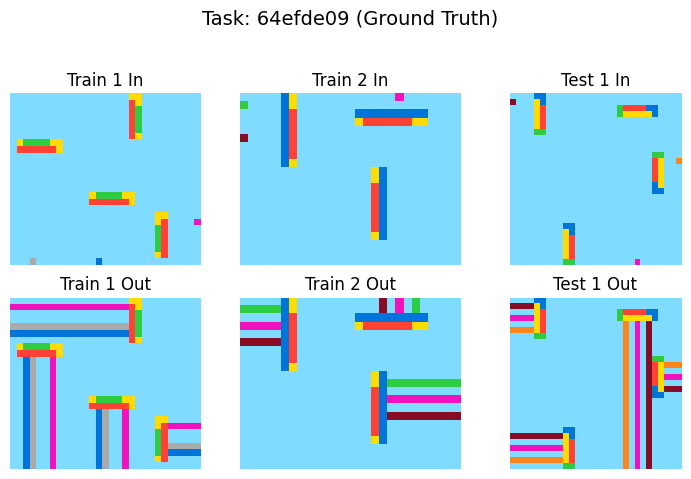


--- LLM Prediction Visualization (Task: 64efde09 / Test: 0) ---


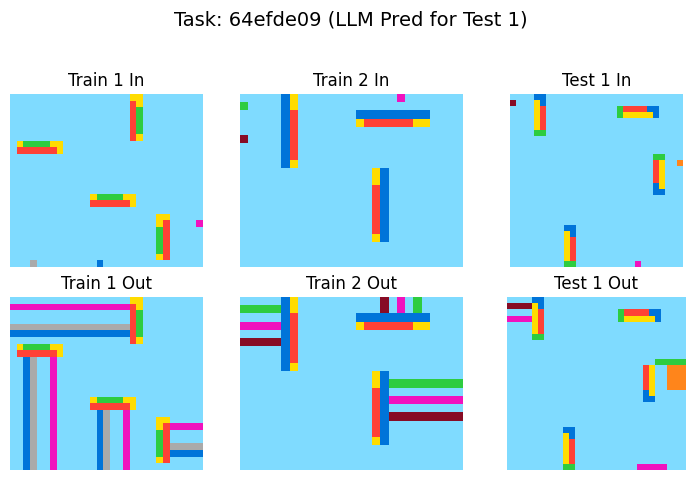

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((28, 29) vs (29, 29)))


===== Task: 65b59efc / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we must deduce the transformation rules by analyzing the patterns in the input-output pairs given in the training examples. After a comprehensive examination, here's the consolidated deduction:

### Identified Transformation Rules:

1. **Color Replacement and Pattern Recognition:**
   - Identify distinct rectangular or contiguous feature regions within the grid. Each will have consistent colors.
   - Replace the colors within these regions with a specific new color based upon the element's nature or enclosed pattern:
     - Replace all numbers `2` with the number `8`.
     - Replace numbers `0` with `8` if they are bounded by '2's and form a contiguous region similar to the earlier pattern.
     - Replace all occurrences of the number `5` with `0` if it forms a square/rectangle region.
     - Replace the number

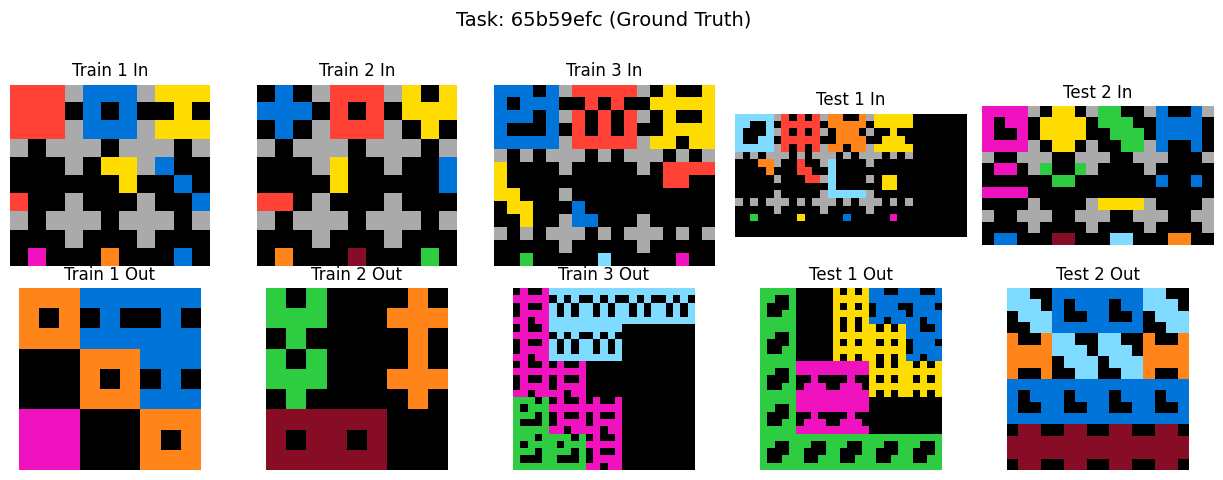


--- LLM Prediction Visualization (Task: 65b59efc / Test: 0) ---


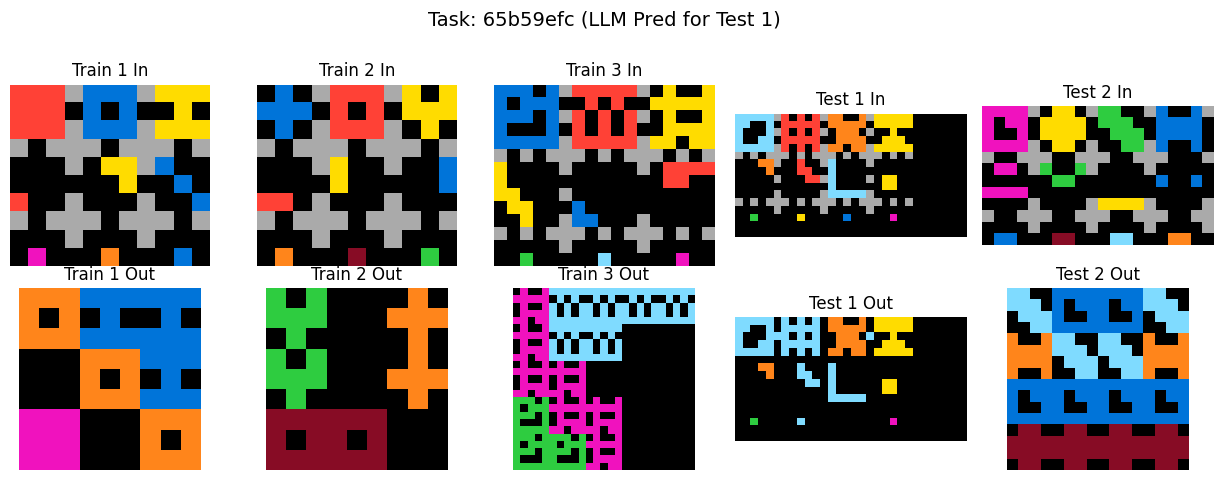

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((16, 30) vs (25, 25)))


===== Task: 65b59efc / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify the transformation rules that convert the input grid into the output grid. Analyzing the given train examples, we can observe the following steps that we derive as rules:

1. **Group Transformation:**
   - Each block of numbers in the input is transformed into another set of numbers in the output.
   - Specifically:
     - Blocks of '2' are transforming to '9'.
     - Blocks of '5' are transforming to '3'.
     - Blocks of '4' are transforming to '6'.
     - Single isolated numbers or small groups can also be components for changes but need examination.

2. **Zero Preservation:**
   - The '0's in the input are preserved in the output unless specifically transformed due to local surrounding changes.

3. **Preserve original isolates**:
   - Single numbers that do not fit exactly into larger g

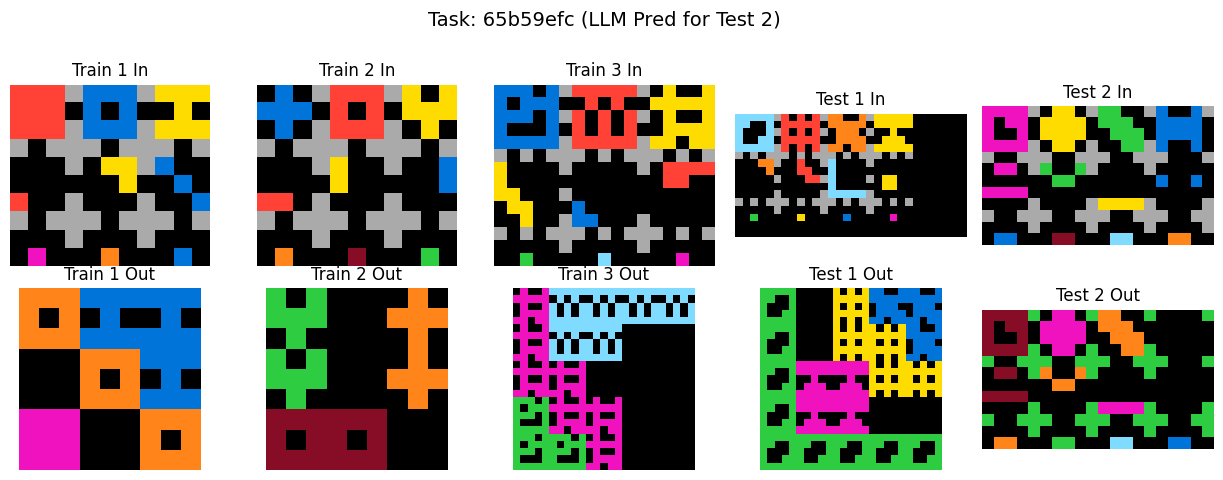

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((12, 20) vs (16, 16)))


===== Task: 67e490f4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to determine rules that transform the provided input grid into the desired output grid. Let's break down the transformation process observed in the training examples:

**Pattern Recognition:**

1. **Input Layout**:
   - The input grid is a larger array (30x30), with various colored regions denoted by numbers from 1 to 9.
   - Checkerboard or specific structured patterns can be observed with numbers on this grid.

2. **Output Layout**:
   - The output seems to be a smaller grid (approximately 13x13), which extracts a portion of the unique patterns seen in the input but not in a simple, contiguous manner (like a crop).

3. **Color Inversion or Mapping**:
   - Color mappings in the output are consistent and non-trivial. They don't seem to take every distinct value from the input grid (e.g., numbers like 6, 9

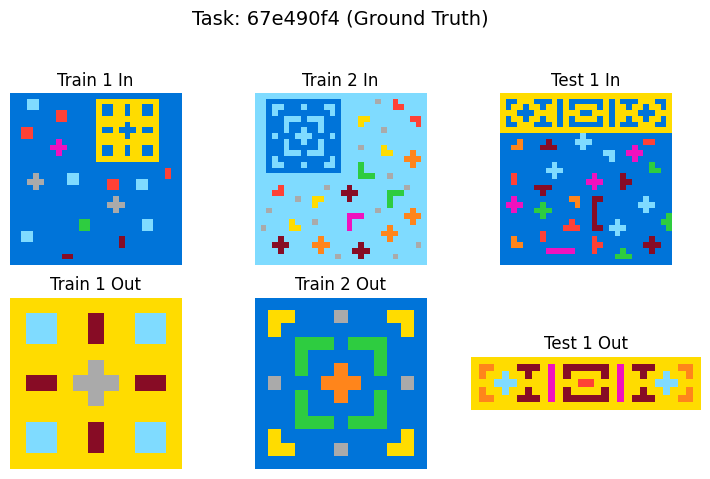


--- LLM Prediction Visualization (Task: 67e490f4 / Test: 0) ---


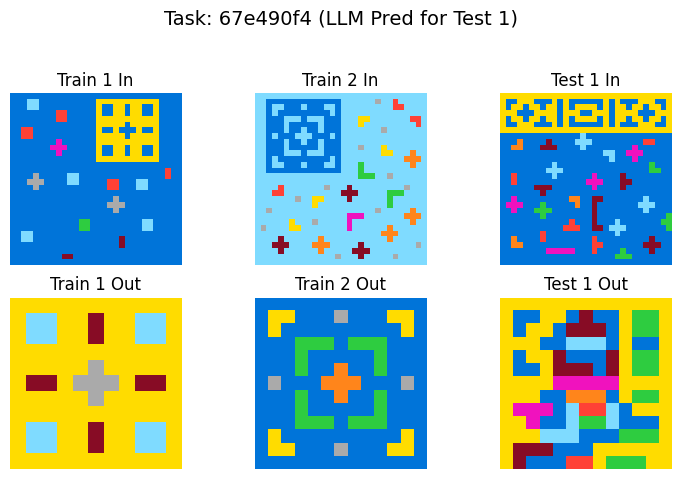

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((13, 13) vs (7, 30)))


===== Task: 6e453dd6 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we need to deduce a transformation rule that can be applied to the given test grid to achieve the desired transformation observed in the training examples. Let’s break down the transformation rules based on our observations:

**Transformation Rules of the Grid Based on Training Examples:**

1. **Identify and Invert the First Horizontal Sequence of Zeroes:**
    - In each of the training examples there is one or more horizontal sequences of `0`s that transform into sequences of `0`s padding by `6`s at the beginning of the row.
    - The rule identifies the first horizontal sequence of `0`s from left to right and moves it to the right by prefixing with `6`s, which fills up the space freed by `0`s.

2. **Replace Middle Section Between `5`s with `2`s:**
    - In rows where a `5` appears, observe if there are multipl

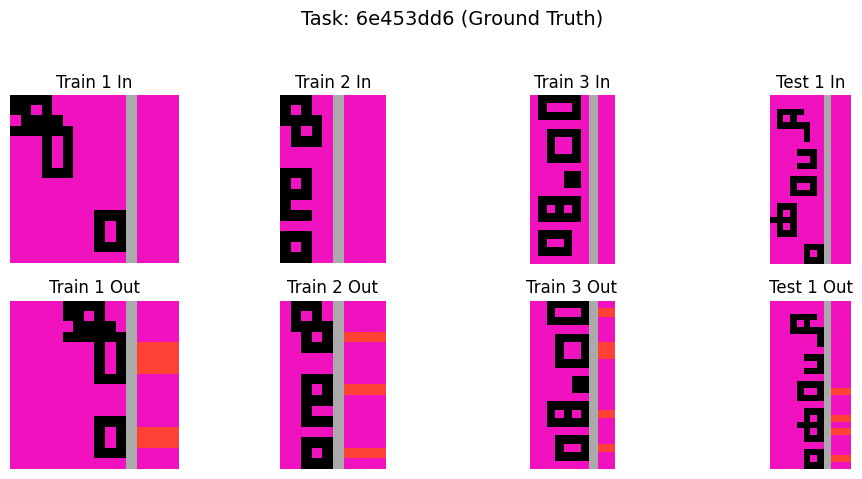


--- LLM Prediction Visualization (Task: 6e453dd6 / Test: 0) ---

Error during LLM prediction visualization for 6e453dd6, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25,) + inhomogeneous part.


===== Task: 6e4f6532 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to deduce the transformation rules that convert the given input matrix into the solution matrix.  
Upon analyzing the provided examples, we observe the following transformation rules and patterns:

### Observations:
1. **Padding of Frames:** 
   - Both examples show an emphasis on framing, with constant values on the borders that don't change from input to output.
   - Example 1 maintains '1' on the top and bottom two rows and '2' on the rightmost and leftmost columns after transformation.
   - Example 2 follows a similar framing with '2' on the top rows and '7' on the rightmost and leftmost columns.


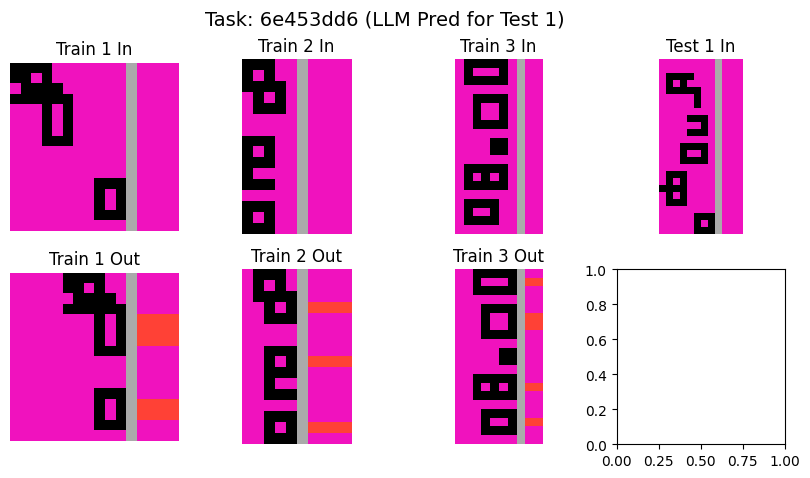

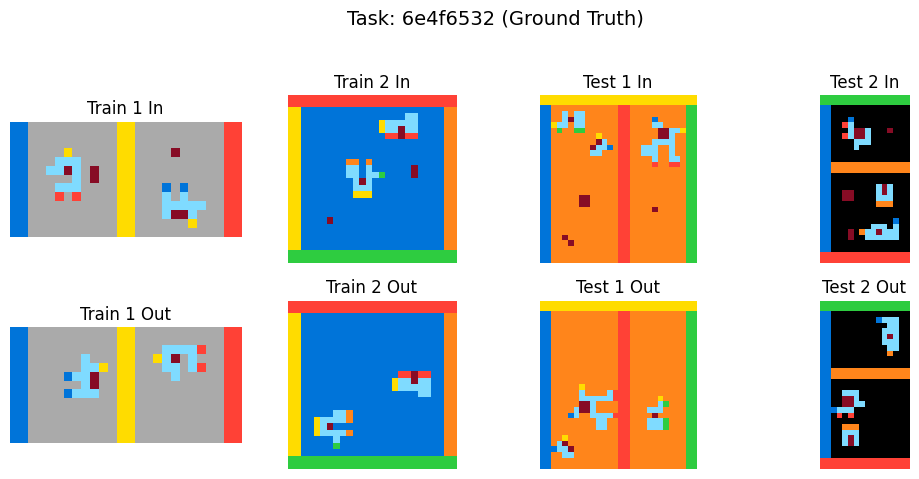


--- LLM Prediction Visualization (Task: 6e4f6532 / Test: 0) ---


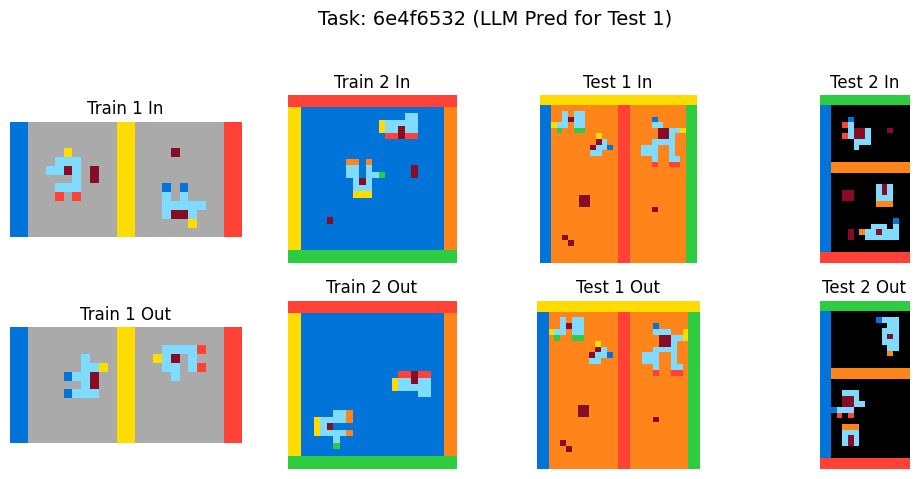

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((29, 28) vs (30, 28)))


===== Task: 6e4f6532 / Test Case: 1 =====

--- Raw LLM Response ---
```
After analyzing the provided train examples, here’s the observed transformation process that can be used as a general approach to solve this problem:

### Transformation Rules:

1. **Identify the Core Structure**:
    - Each input example grid seems to include a rectangular bordered area consisting of numbers like `4, 4`; `3, 3`; `2, 2`; and `7, 7` which remain unchanged after transformation. These lines establish a border or a consistent element that doesn't change.

2. **Central Block Transformation**:
    - In both examples, within a specific region in the grid, a pattern variation seems to occur within some rows and columns, including new numbers such as `8, 9, 2`. This chain of numbers arguably forms a certain block or systematic shape. Specifically:
        - The rows with significant numbers (such as alteration or focal entry

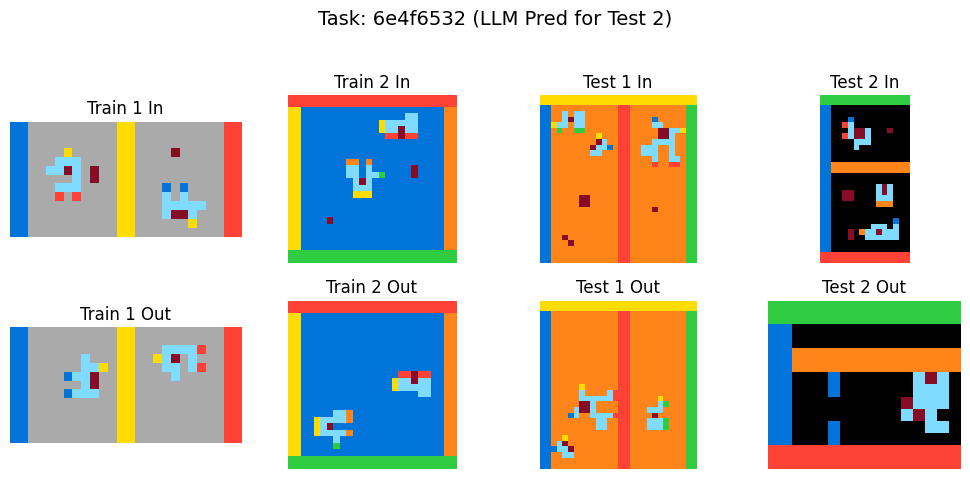

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((14, 16) vs (30, 16)))


===== Task: 6ffbe589 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's identify the rules applied to transform the given input grid into the output grid. From the provided training examples, we can discern several transformations:

1. **Identify Blocks**: In the input grid, we generally have larger regions of non-zero numbers (e.g., 3, 5, or 8) that form recognizable blocks or shapes. These blocks tend to form a prominent pattern or image in the grid, such as a rectangle, a horizontal or vertical line, or another distinct shape.

2. **Locate the Border of the Shape**: The non-zero numbers often define the outer border of these identified blocks or shapes. The transformation seems to involve cropping the input grid to focus on these blocks while discarding surrounding zero-valued areas.

3. **Crop around the Identified Blocks**: Precisely, a bounding box is drawn around the 

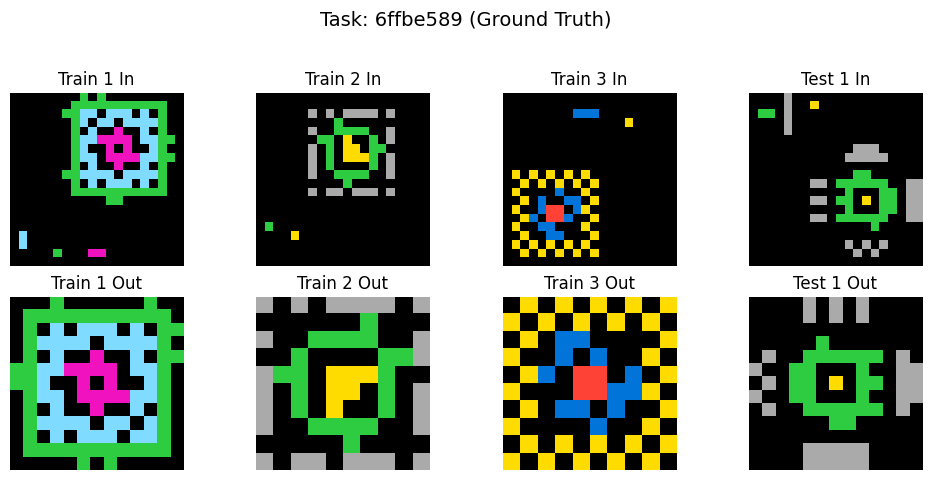


--- LLM Prediction Visualization (Task: 6ffbe589 / Test: 0) ---


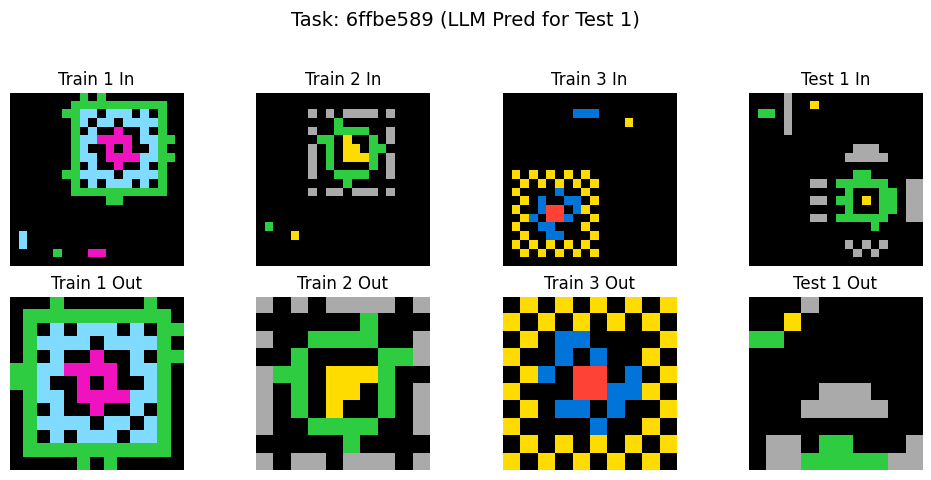

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((10, 10) vs (13, 13)))


===== Task: 71e489b6 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, let's analyze the transformation rules based on the given train examples. 

We have multiple examples where a specific pattern is manipulated:

### Observed Pattern:
- There are connected groups of zeros (0s) in the input grid.
- The transformation changes some of these zeros into sevens (7s) based on a specific pattern.
- In each train example, some sevens (7s) appear around the zeros, creating a clear pattern or shape, often a closed or partial closed loop.

### Transformation Rules:
1. **Identify the Patterns**:
   - Look for groups of zeros where a contiguous area of 0s is surrounded by 1s.
   - In each train example, these patterns could be squares, rectangles, or other enclosed forms.

2. **Convert Zeros to Sevens**:
   - Once a pattern of connected zeros is identified, this area will transform 0s into 7s

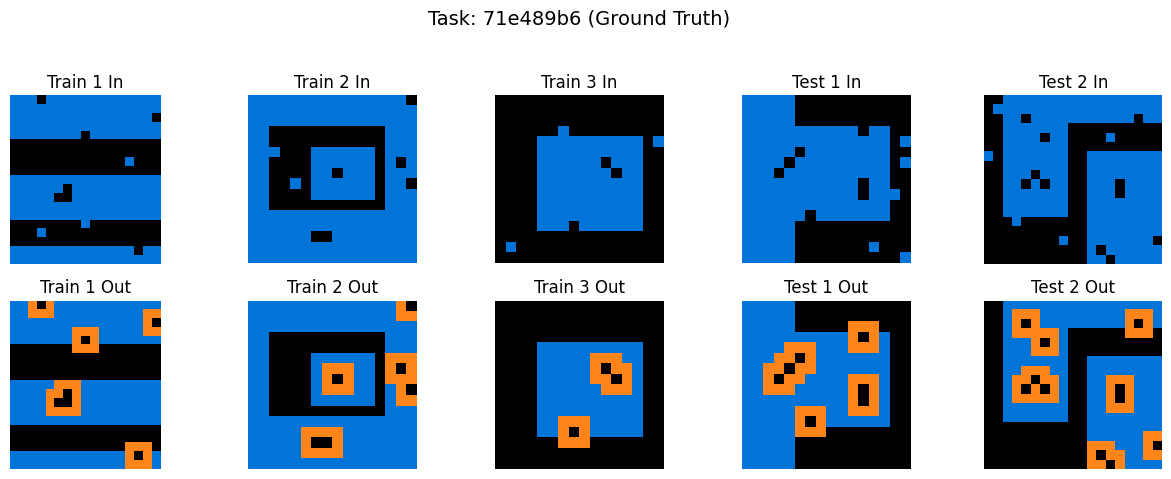


--- LLM Prediction Visualization (Task: 71e489b6 / Test: 0) ---


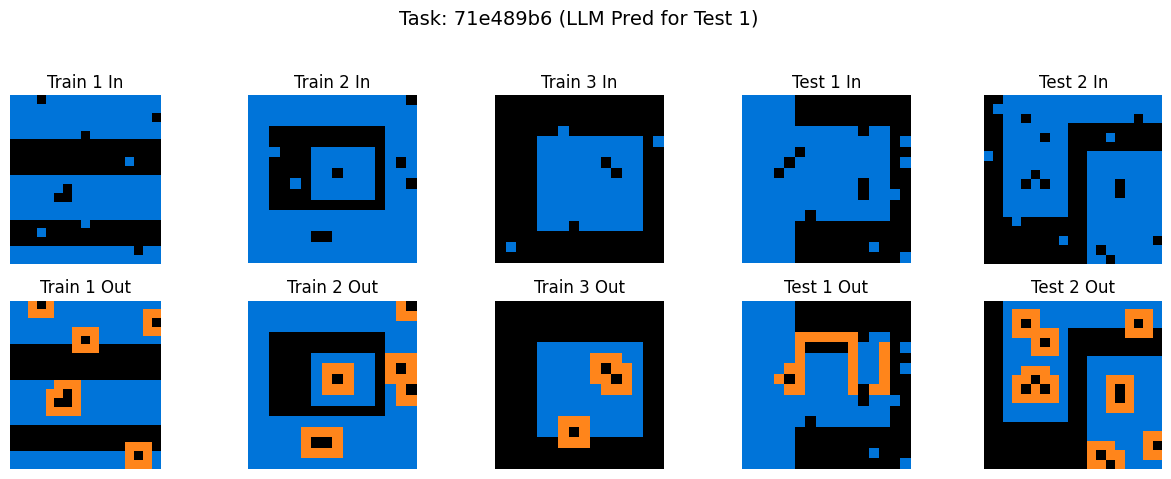

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 71e489b6 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the transformation from the input grid to the output grid, we will follow these precise transformation steps that are deduced from analyzing the provided training examples:

### Rule Analysis:

1. **Identify the central line**:
    - We note that the operation focuses on patterns that are centered on specific lines within the grid. This central line is effectively a path through the grid made by `1`s amidst `0`s.

2. **Transformation Identification**:
    - For each contiguous segment of `1`s in the grid, identify a potential hollow region (surrounded by `1`s) that can be filled with `7`s.
    - Fill this region, such that it follows the following rules:
      - Convert the central `1`s to `7`s where they are completely surrounded by other `1`s, forming a hollow region.
      - Ensure this transformation starts and ends with `0`.

3. **Path Int

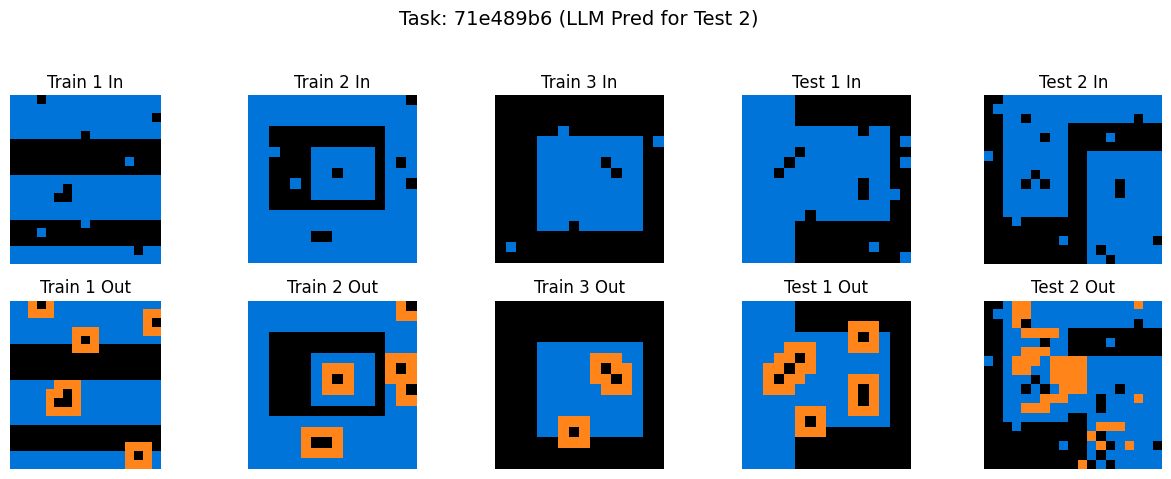

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7491f3cf / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to analyze the pattern in the training examples and determine the exact rule or transformation that transforms each input grid into its corresponding solution grid. By inspecting the training examples, we notice a consistent and distinct pattern.

**Pattern Analysis of the Examples:**

1. **Border Unchanged:** The first and last rows and columns are unchanged in both input and output grids.

2. **Internal Pattern Scanning:** 
   - Identify distinct 'internal shapes' or 'blocks' within the grid, usually surrounded by a border value different from the internal values. For example, value `5` in Example 1 acts as both the border and part of the internal blocks.
   - The central block pattern in each grid appears to use distinct values such as `4`, `3`, `2` in Example 1 which form some symmetry or recognizable structure like a 

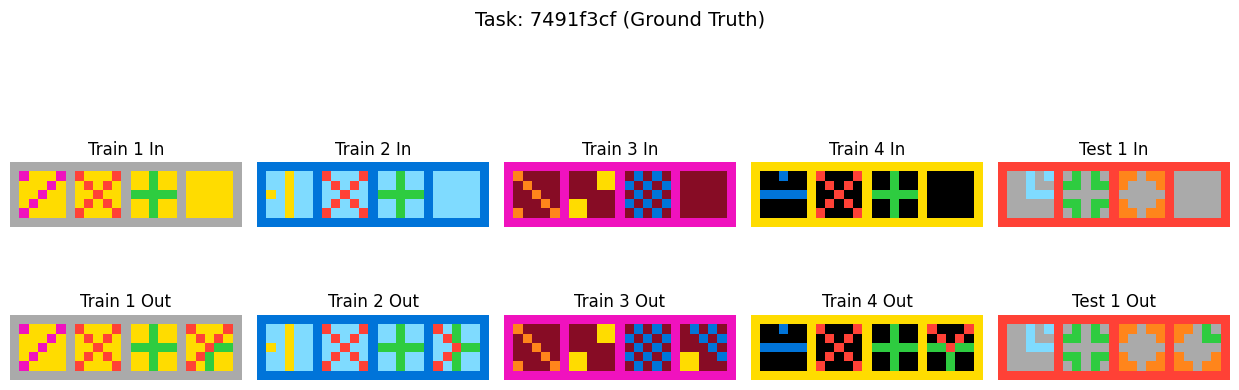


--- LLM Prediction Visualization (Task: 7491f3cf / Test: 0) ---


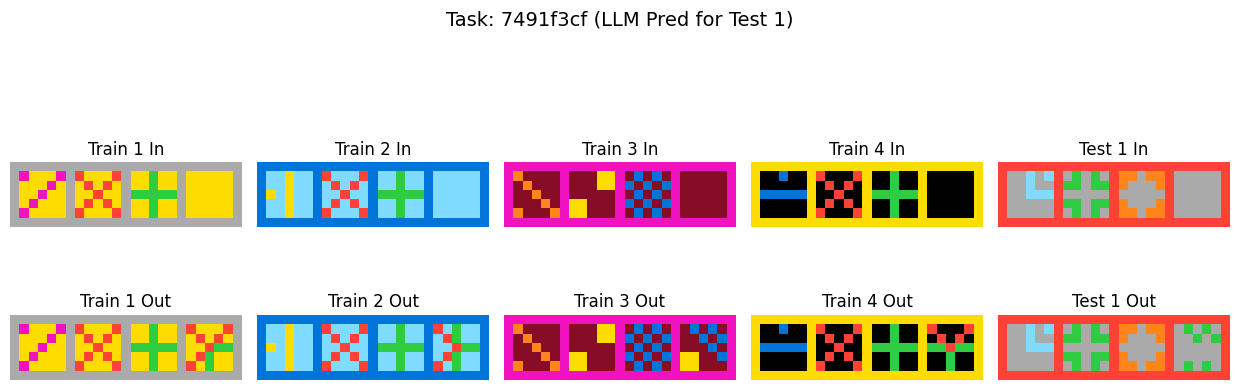

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7666fa5d / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the transformation problem based on the patterns observed in the train examples, we need to outline a clear set of transformation rules. Here's the observed pattern and derived rules:

### Observations and Derived Rules:

1. **Identify and Expand Around a Special Number**:  
   - In each grid, there's a "special" number (not `8`) that forms the center of a cluster. In Example 1, it's `4`; in Example 2, it's `3`; and in the test case, it's `9`.
   - This number is surrounded by other numbers (initially `8`s) which are transformed into `2`s.

2. **Transformation Pattern**:
   - For each grid cell containing the special number, transform the adjacent cells (left, right, top, bottom, and diagonals) to `2`. 
   - This transformation continues for up to three layers around the special number until you reach either the boundary of the grid or another 

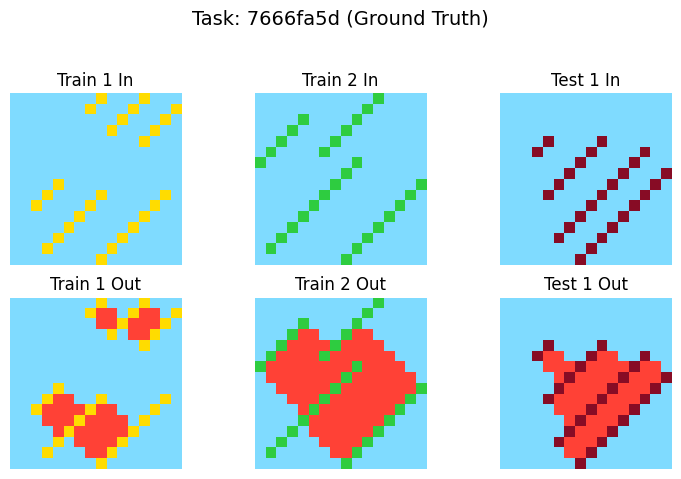


--- LLM Prediction Visualization (Task: 7666fa5d / Test: 0) ---


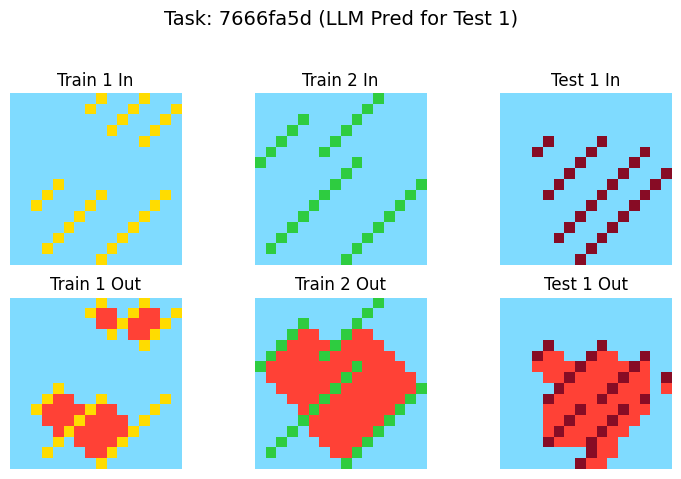

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 78332cb0 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to infer the transformation rules applied in each case and apply them to the test input.

### Analysis of Training Examples:

#### Example 1:
**Input:**  
Grid of dimensions: 11x11  
Contains patterns of numbers 1, 2, 3, 4 within a larger area filled with 6's and 7's.

**Output:**  
Grid of dimensions: 11x5  
Each pattern of numbers (2, 3, 4, and 1) has been isolated into its own 11x5 sub-grid with 7's surrounding them. These sub-grids are listed consecutively, separated by a central line of 6's.

#### Example 2:
**Input:**  
Grid of dimensions: 11x5  
Contains distinct patterns: 2 and 9 (with padding of 7's, separated by a line of 6's).

**Output:**  
Grid of dimensions: 5x17  
Transformed input by re-arranging patterns seen vertically in a single line, maintaining their order and compactness.

#### Example 3:
**Input:** 

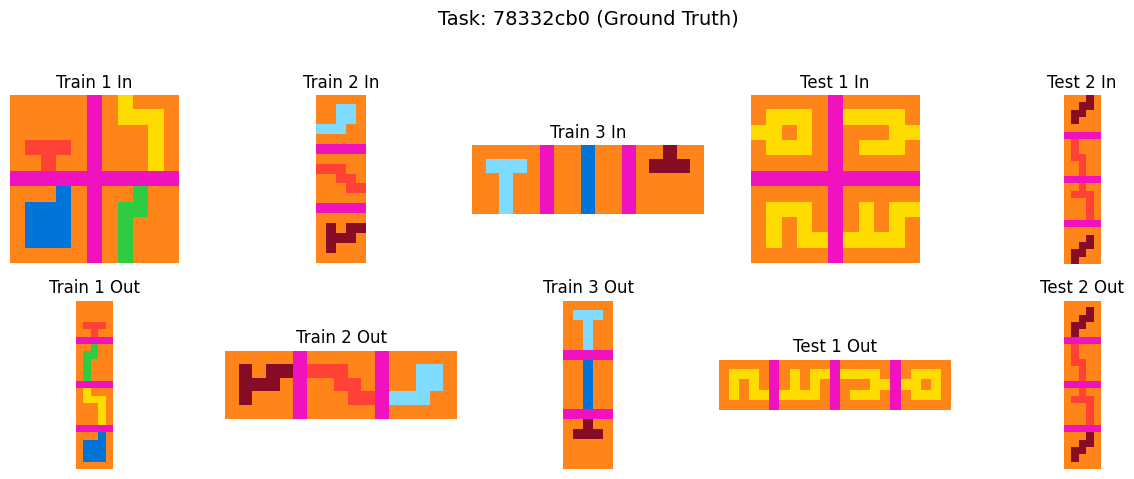


--- LLM Prediction Visualization (Task: 78332cb0 / Test: 0) ---


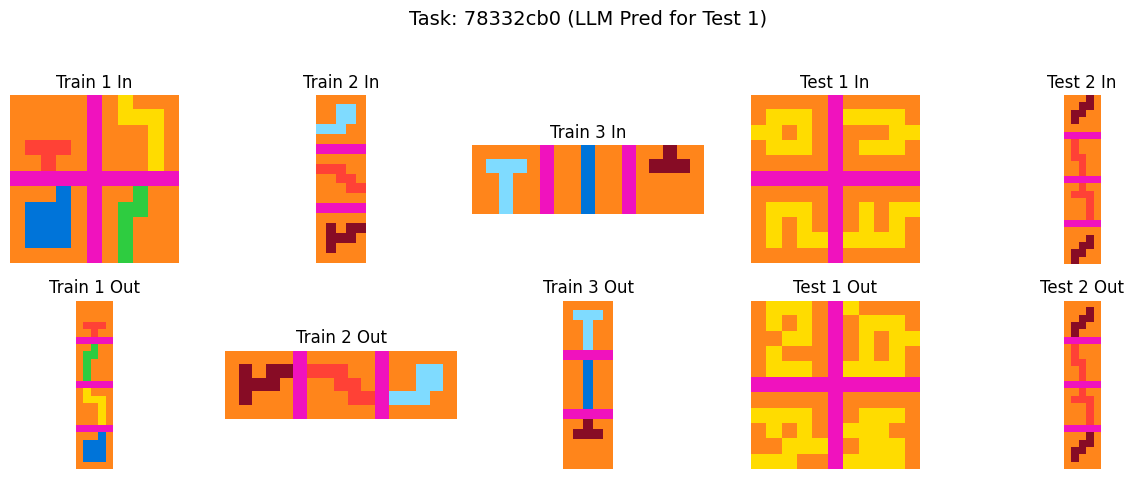

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((11, 11) vs (5, 23)))


===== Task: 78332cb0 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem, we need to identify a common pattern or transformation rule in the train examples and apply it to the test input. Let's analyze the train examples:

**Step 1: Identify Patterns and Transformation Rules**

1. **Input Analysis**:
   - All input grids are segmented into groups of rows where some rows have similar patterns repeated.
   - There seems to be a separation between segments where certain numbers stand out or dominate (e.g., regions filled with '8', '2', '9', '1', etc.) and other segments filled with a different number.

2. **Output Analysis**:
   - The outputs appear visually segregated into blocks of rows which sometimes correspond to segments in the input but are reorganized or filtered.
   - Each segment of the input forms a distinct block in the output with associated transformations (like truncation,

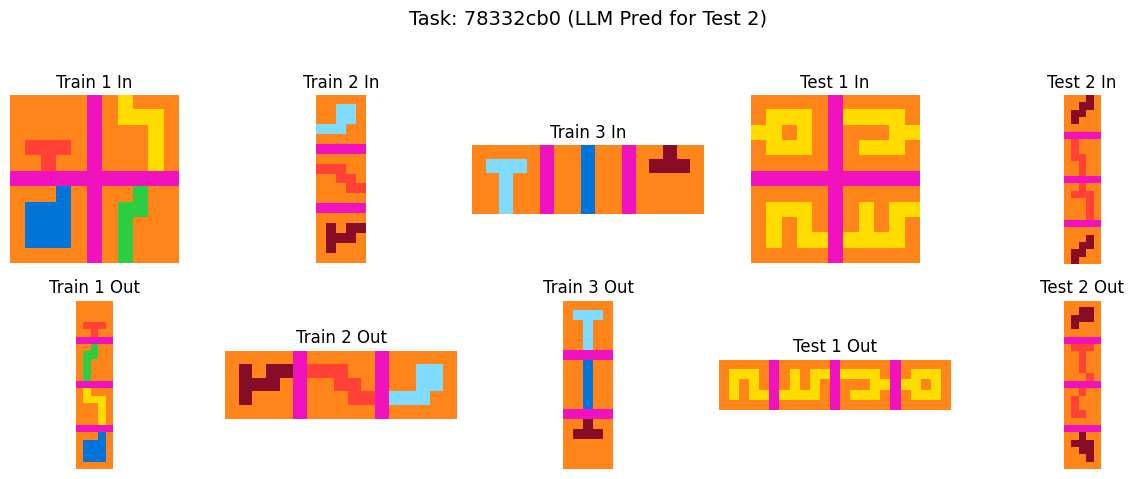

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7b0280bc / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve these examples, we need to identify the transformation rules from the input grid to the output grid. In the given train examples, the following observations and transformations were deduced:

1. Each distinct object or shape in the grid is transformed:
   - In Example 1:
     - "0" transforms into "5".
     - "2" remains "2", and "1" remains "1".
   - In Example 2:
     - Objects made of "4" that are rectangular or nearly so are transformed into "5".
     - "7" is similarly transformed to "3".
     - Other values (like "6") remain unchanged.
   - In Example 3:
     - "1" transforms to "3".
     - "6" transforms to "5".
     - "2" remains "2".

2. The transformation follows:
   - Identify connected components of numbers not equal to the background. Apply a transformation based on the number and size or type of cluster.
   - The numbers that tran

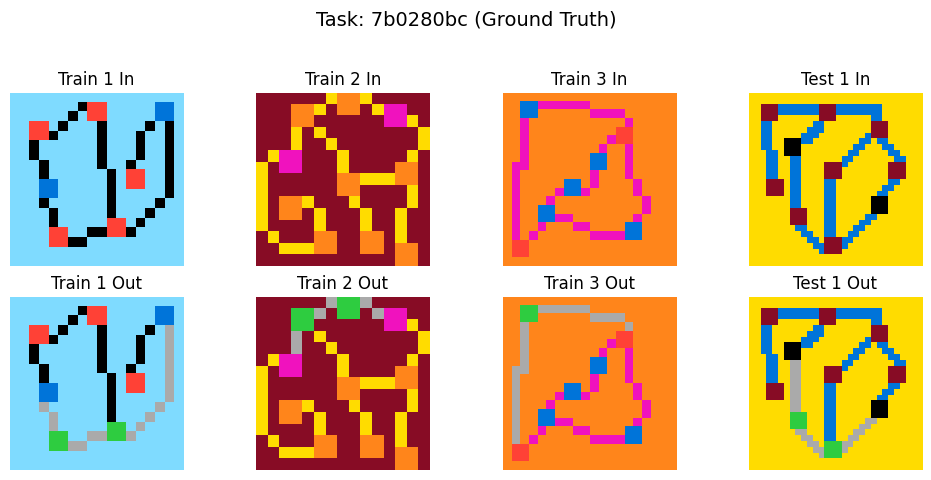


--- LLM Prediction Visualization (Task: 7b0280bc / Test: 0) ---


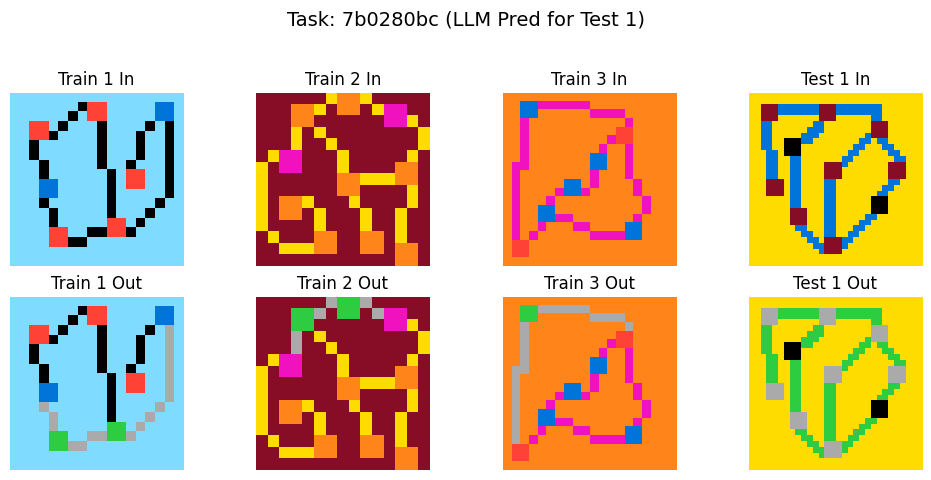

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7b3084d4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to identify the transformation rules that are being applied to the input grid to achieve the desired output grid.

Analyzing the provided examples:

1. **Identify contiguous colored regions (non-zero numbers) in the input grid.**
2. **Extract these regions and place them in the smallest possible bounding-box on the output.**
3. **Maintain the order of extraction from top to bottom and left to right.**

### Detailed Steps for Transformation:

- Traverse through the input grid and locate the first non-zero number. This identifies the starting point of a region.
- Using flood-fill (or connected component analysis), extract the complete contiguous region defined by the number.
- Place this region into the output grid at the next available position.
- Repeat until all regions from the input are extracted and placed into the output

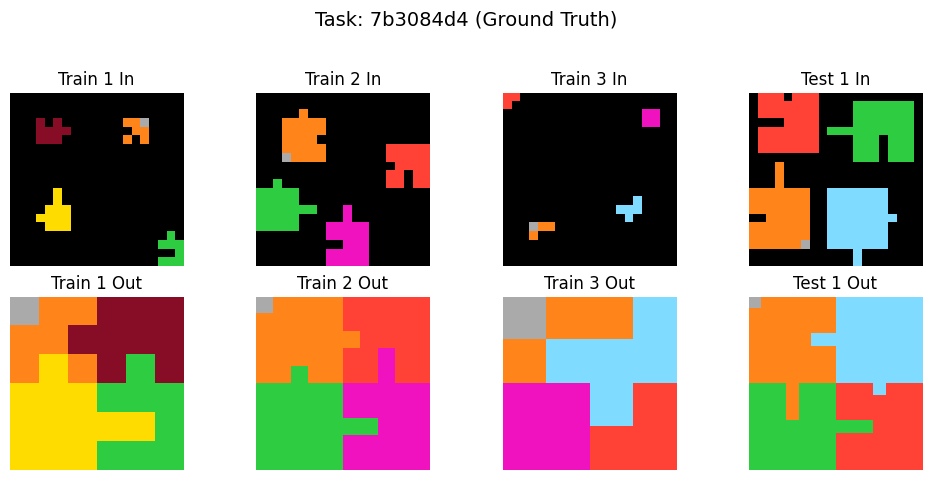


--- LLM Prediction Visualization (Task: 7b3084d4 / Test: 0) ---


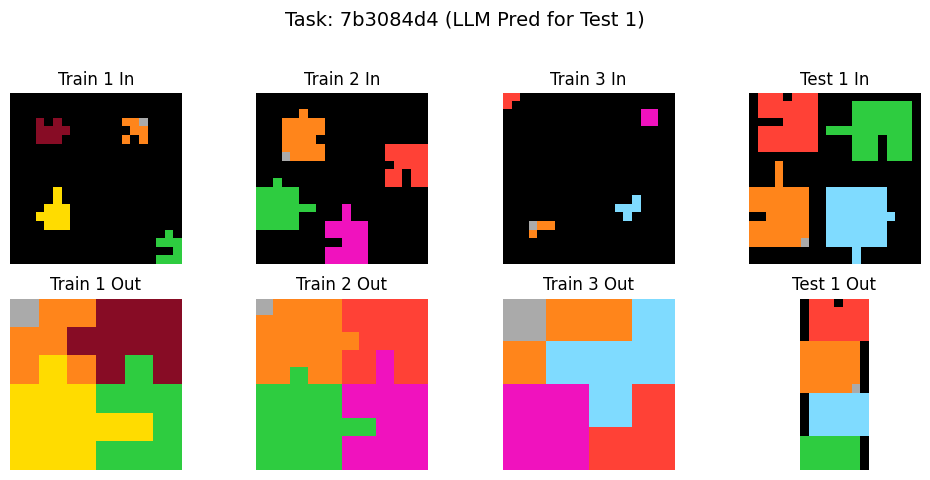

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((20, 8) vs (14, 14)))


===== Task: 7b5033c1 / Test Case: 0 =====

--- Raw LLM Response ---
```
To determine the transformation rules for the given task, let's analyze the train examples.

**Train Example Analysis:**

1. **Example 1:**
   - We have a 16x16 grid.
   - The transformation involves extracting sequences of numbers different from the background (denoted by 8 in input).
   - The numbers are consecutive in vertical orientation.
   - Thus, we end up with a 1D array that preserves the order of non-background numbers encountered.

2. **Example 2:**
   - Similarly, there is a 16x16 grid.
   - The background number is 1 this time.
   - As in Example 1, vertically aligned numbers different from the background form the result sequence.

Summarizing the rule from these observations:
- Traverse each column in the grid from top to bottom.
- For each column, isolate sequences of numbers that are not equal to the background number

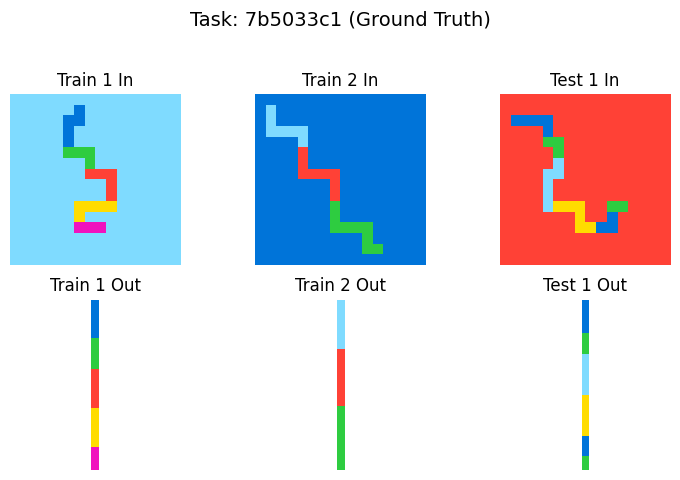


--- LLM Prediction (Task: 7b5033c1 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 7b80bb43 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to derive the transformation rules that turn each input grid into the corresponding output grid. Observing the given examples, here is a breakdown of the transformation logic:

### Observations from Examples:

1. **Identifying a Special Number:**
   - In both examples, there appears to be a special number that sticks out from the surrounding numbers. 
   - In Example 1, the special number is `6`, and in Example 2, it is `3`.

2. **Rectangle Enlargement:**
   - All occurrences of the special number are enlarged into bigger rectangles or lines.
   - Example 1, when `6` is found in a grid, it forms 5 consecutive `6`s horizontally in the solution. 
   - Example 2 shows a line of `3`s being augmented into a block or row of `3`s.

3. **Surrounding Numbers:**
   - The rest of the gri

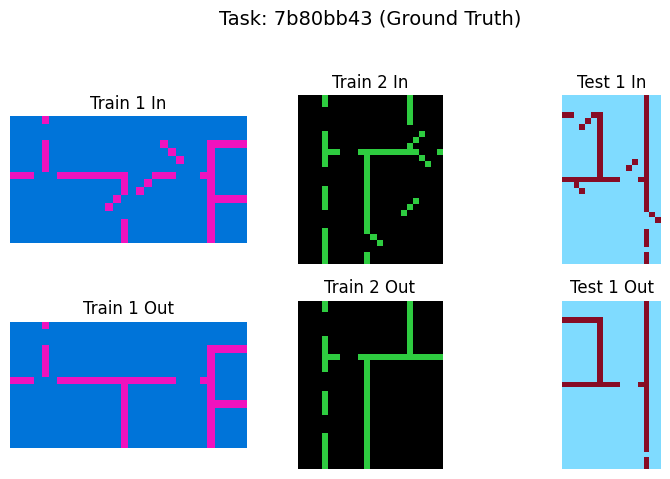


--- LLM Prediction Visualization (Task: 7b80bb43 / Test: 0) ---


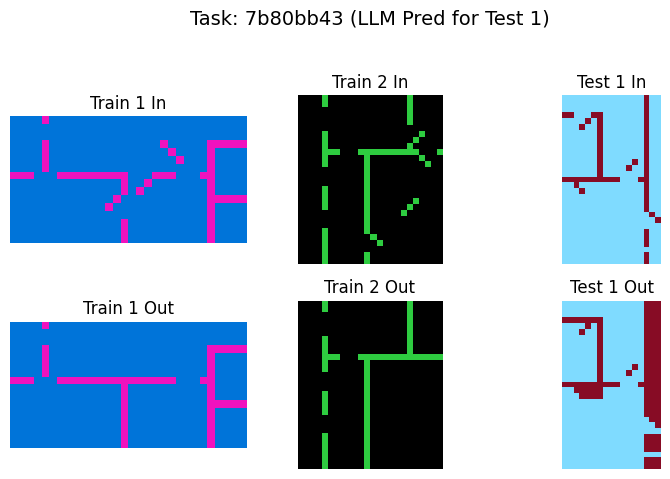

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7c66cb00 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce a transformation rule that, when applied to the input grids, produces the specified output grids from the examples given. Here's the process to derive the transformation rules based on the provided examples:

1. **Identify Sections:**
   - In each example, the grid consists of sections characterized by distinguishable numbers, typically forming horizontal bands.
   - These sections tend to have distinctive internal blocks or patterns of numbers, including outlines or filled regions.

2. **Pattern Analysis:**
   - Each section showcases a base pattern that remains largely the same in the output as in the input, except for specific locations where a repeated smaller pattern appears.
   - The typical transformation within these sections involves changing a certain sub-pattern within the section to a more complex pat

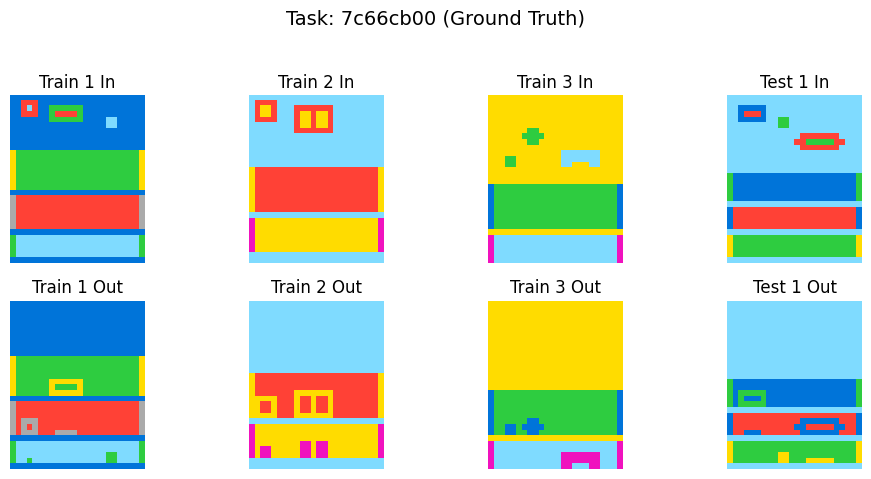


--- LLM Prediction Visualization (Task: 7c66cb00 / Test: 0) ---


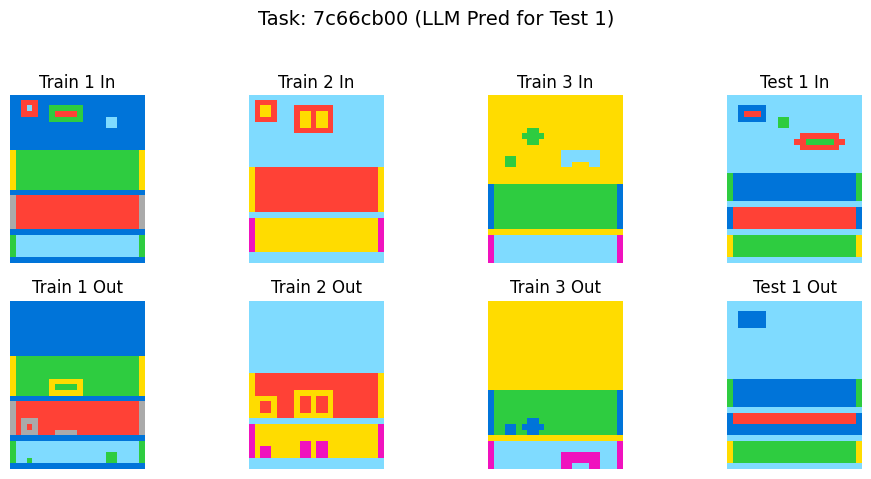

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7ed72f31 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the transformation problem, we need to deduce a set of rules based on the provided input-output examples. Let's analyze each of the training examples and the corresponding transformations:

### Analysis of the Examples:

**Example 1 Analysis:**
- The grid seems to involve isolated clusters of non-background numbers, which are transformed based on specific conditions.
- Notice how some numbers (e.g., '2', '5', '8') in a cluster are reframed by the number '4', which is present near them. The clusters formed by these numbers seem to be expanded or supplemented with '4'.
- Additional numbers (e.g., a '5' or '8') appear in rows where a '4' becomes adjacent to them horizontally or vertically in the output.
- Some sections of the input grid feature clusters where '2' and '5' appear nearby or cluster in sequence, resulting in an expansion of '4' near t

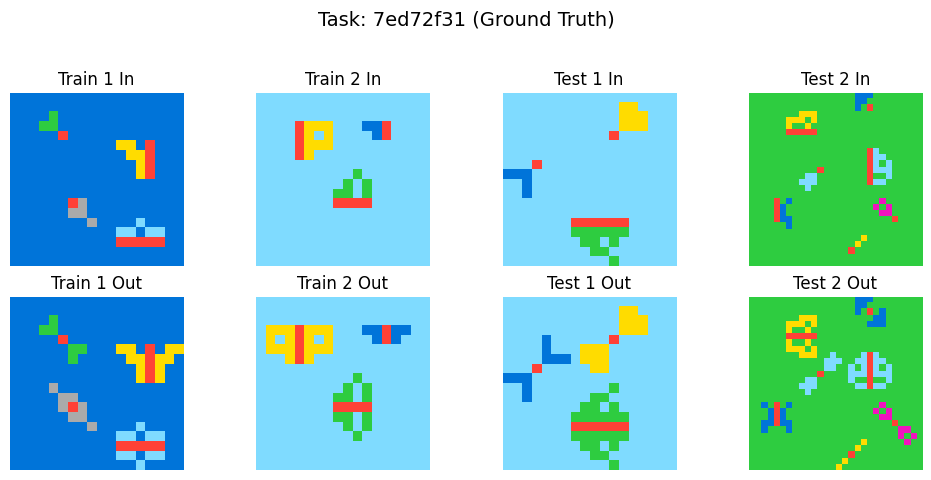


--- LLM Prediction Visualization (Task: 7ed72f31 / Test: 0) ---


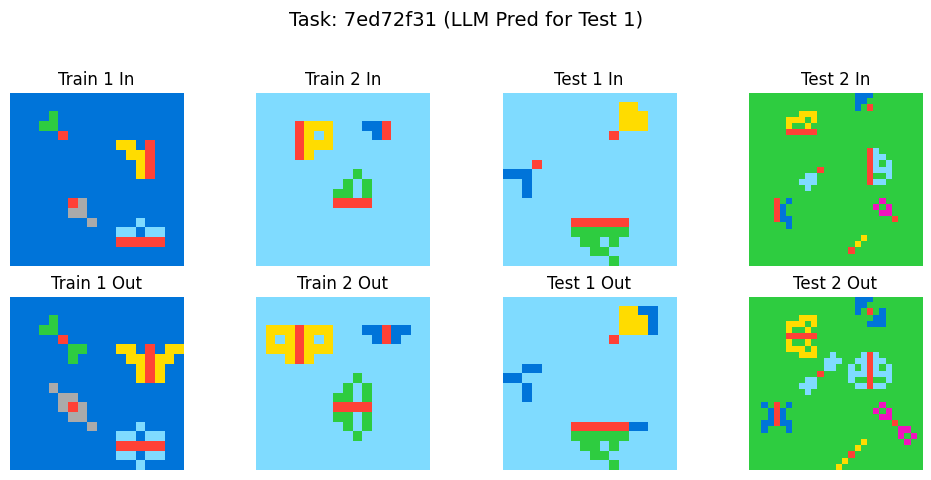

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 7ed72f31 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem, we need to identify the transformation rules applied to each train example's input to produce the output. Let's break it down:

1. **Understanding the Rules:**

   - In the first example:
     - Identify certain "blocks" of numbers that need to be duplicated or rearranged.
     - The block pattern which consists of non-repeated numbers like `3, 4, 5, 2, 8` sometimes are duplicated or shifted right in the output.
     - The presence of surrounded numbers tends to be the key where the augmentation or shifting occurs, such as additional blocks of `4, 5, 8` in certain areas.

   - In the second example:
     - We note the importance of rows and blocks of `8s` or other numbers like `3, 4, 1`, which appear to be mimicked or moved across the solution grid.
     - The movement is primarily horizontal, inserting like-number clusters elsewhe

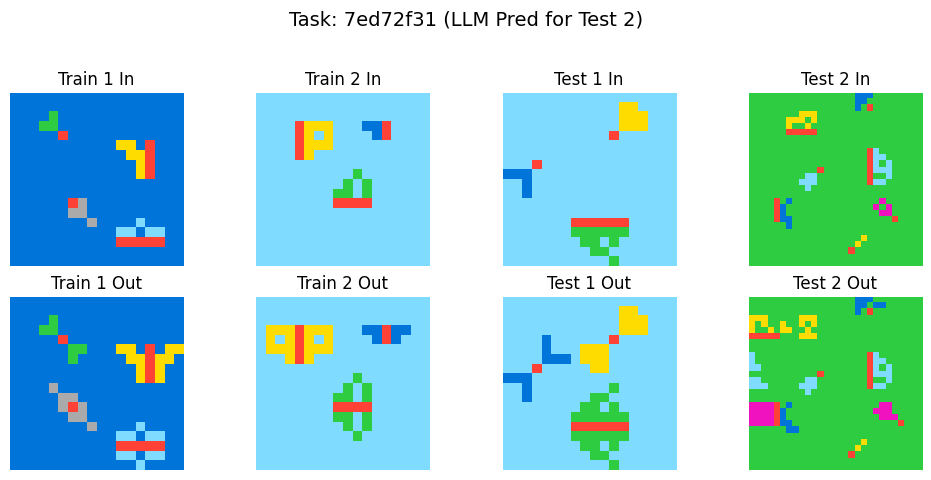

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 800d221b / Test Case: 0 =====

--- Raw LLM Response ---
```
To tackle this task, let's analyze each transformation from the input to the output grid.

### Observations:
1. **Diagonal Patterns:** The original grids have diagonal regions (whether squares or different shapes) that change their patterns in transition from input to output.
2. **Boundary Changes:** The input and output differ mainly along row and column boundaries outlining these diagonal shapes.
3. **Color/Number Changes:** Specific numbers are replaced systematically from input to output.

### Step-by-Step Transformation Rules:

**Identifying Patterns:**

- **Rule 1:** Identify a boundary characterized by numbers that are differing from their immediate surroundings within a diagonal or edge (e.g., from solid lines of a particular number to a boundary demarcated by a different number in output).
- **Rule 2:** Substitute specific numbers within these 

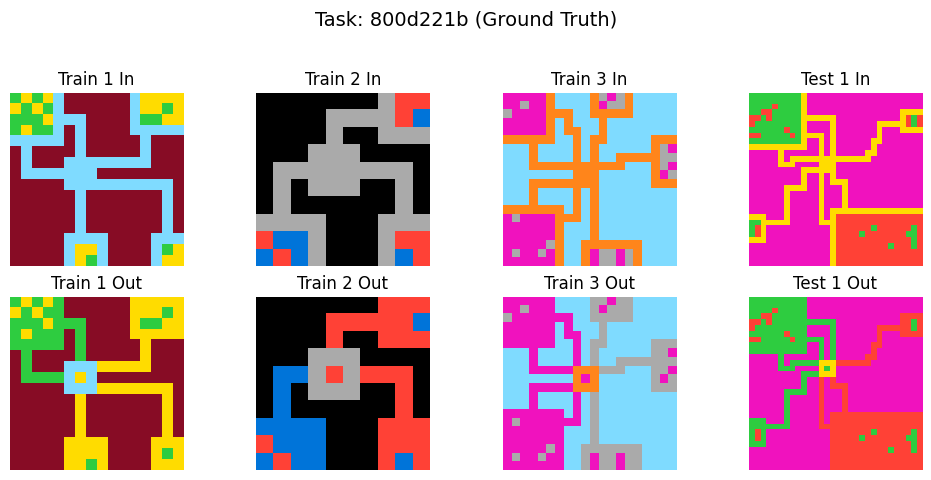


--- LLM Prediction Visualization (Task: 800d221b / Test: 0) ---


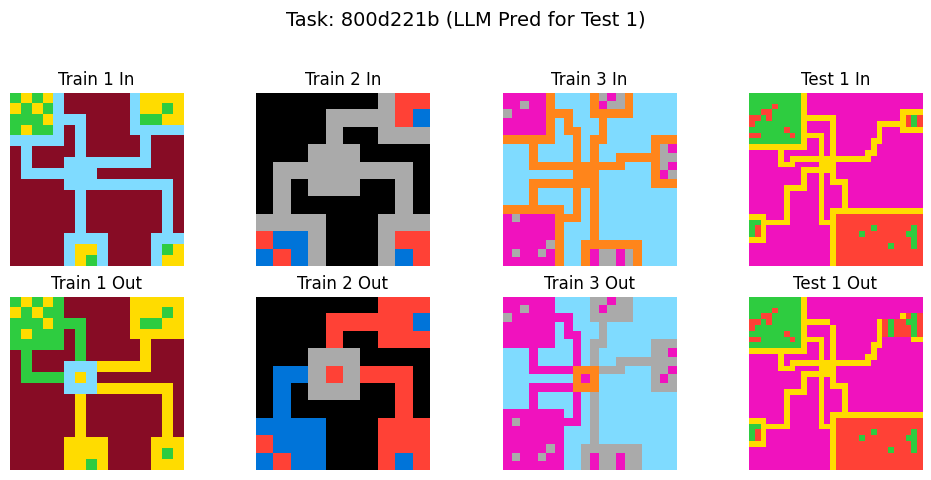

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 80a900e0 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's break down the transformation occurring from the input grid to the output grid in the examples provided:

### Observations:
1. **Pattern Introduction:**
   - The grids contain a mixture of '1's, '0's, and other numbers. In Example 1 and Example 2, certain numbers (like `3, 4, 6, 7, 8, 9`) are surrounded symmetrically.
   - The numbers initially presented in the input (e.g., 3, 4, 6) are presumably crucial. In Example 1, `8` was introduced in the input, and in Example 2, `2, 3, 4` were introduced.

2. **Transformation View:**
   - Each number introduced, that is not 0, 1, seems to radiate outwards in diagonal directions forming a symmetric pattern around it.
   - The number appearing in the solution often creates its own pattern by existing in multiple positions around its initial spot or its introduced vicinity.

3. **Transf

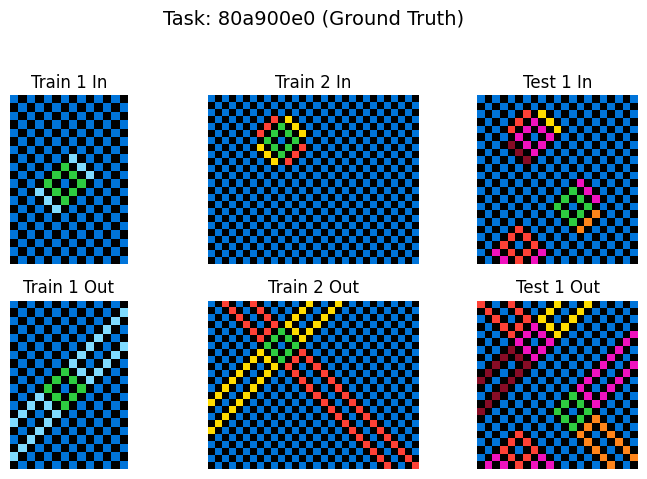


--- LLM Prediction Visualization (Task: 80a900e0 / Test: 0) ---


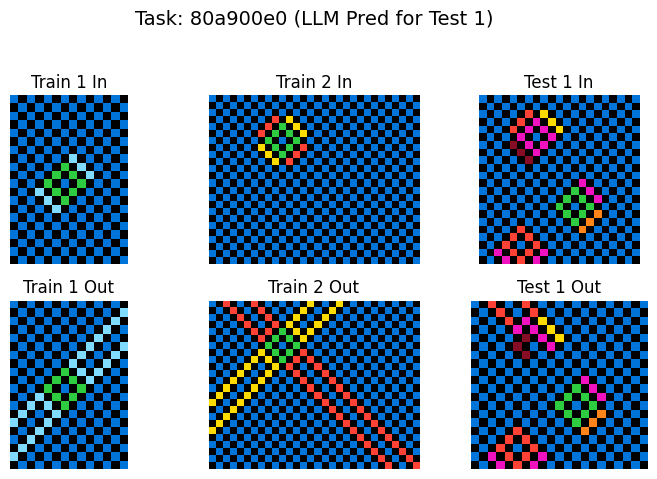

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((20, 21) vs (22, 21)))


===== Task: 8698868d / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to transform the given input grids into corresponding output grids by applying certain transformation rules. Based on the provided examples, let's analyze the transformation steps and deduce the rules:

### Observations:

1. **Grid Borders:**
   - Each grid has distinct regions with specific border values. For instance, `4`, `8`, and `2` in Example 1 are the border values. 
   - In the output, these border values form a rectangle around the inner transformed grid, but these borders need to match the starting part of the input rows and remain intact in the output.

2. **Colored Regions:**
   - Within the borders, there are colored regions marked by distinct numbers, such as `1`, `4`, `8`, `2`, `3` from Example 1, and similar in Example 2.
   - The transformation focuses on these inner regions, keeping t

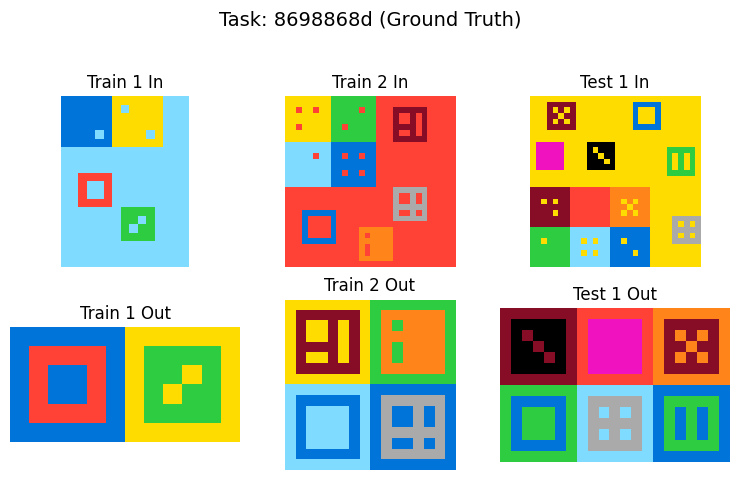


--- LLM Prediction Visualization (Task: 8698868d / Test: 0) ---


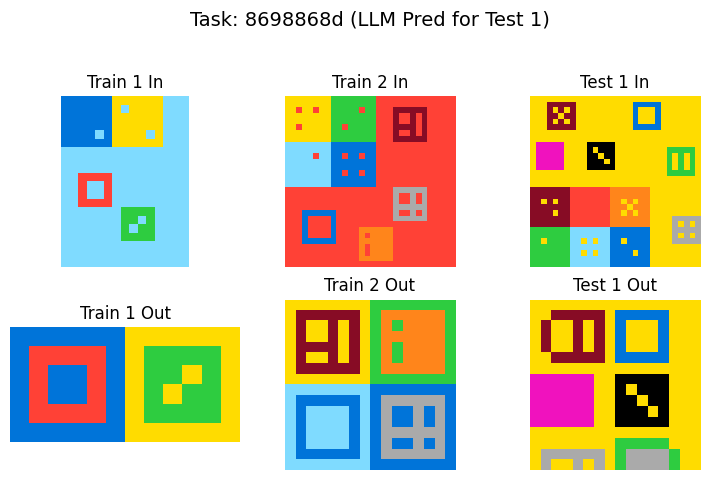

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((16, 16) vs (14, 21)))


===== Task: 88bcf3b4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the ARC transformation, we need to identify a replicable rule that transitions each input grid to its respective output. By analyzing the provided training examples, the consistent transformation pattern can be summarized as follows:

### Identified Rules:

1. **Identification of Leading Numbers:**
   - Find the highest non-zero number (let's call it the "leading number") from each row that appears before encountering any special number (like 2, 3, 4, 5, etc.) to the right of it.

2. **Shifting and Overlay:**
   - Take the identified "leading number" from Rule 1 and place it at the beginning of the row wherever possible, up to but not exceeding the position of any special numbers.
   - The special numbers remain fixed in their respective columns and are not altered in position.

### Testing Rules on Training Examples:

Appl

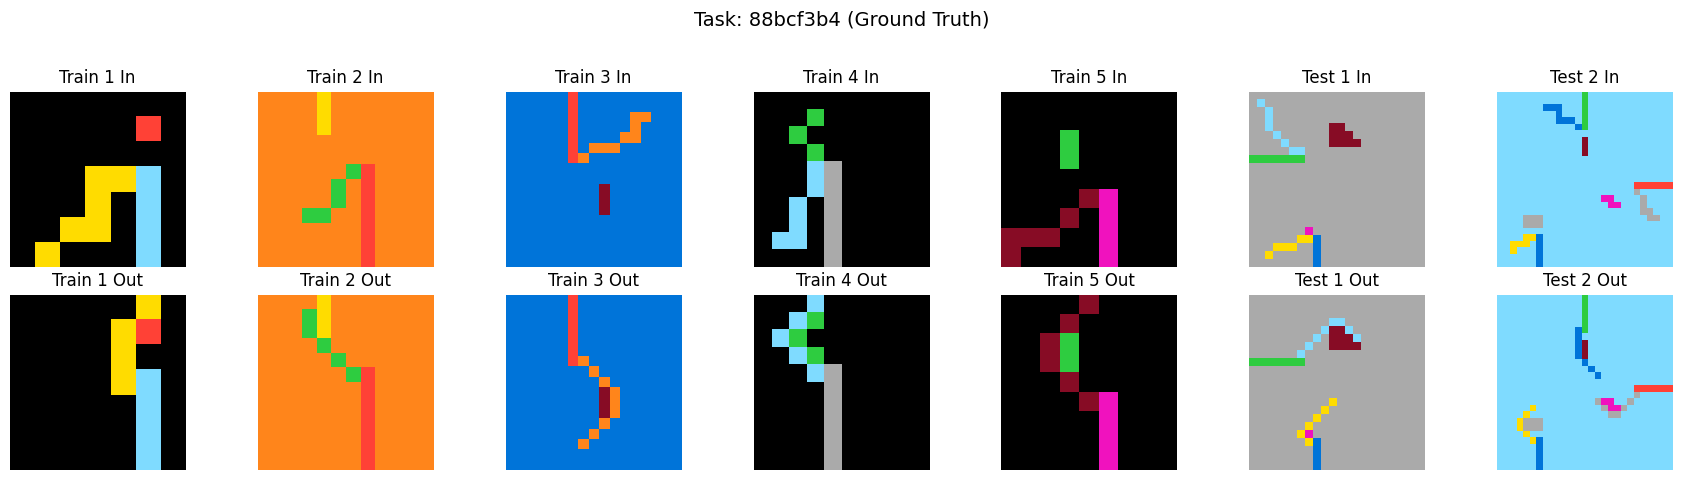


--- LLM Prediction Visualization (Task: 88bcf3b4 / Test: 0) ---


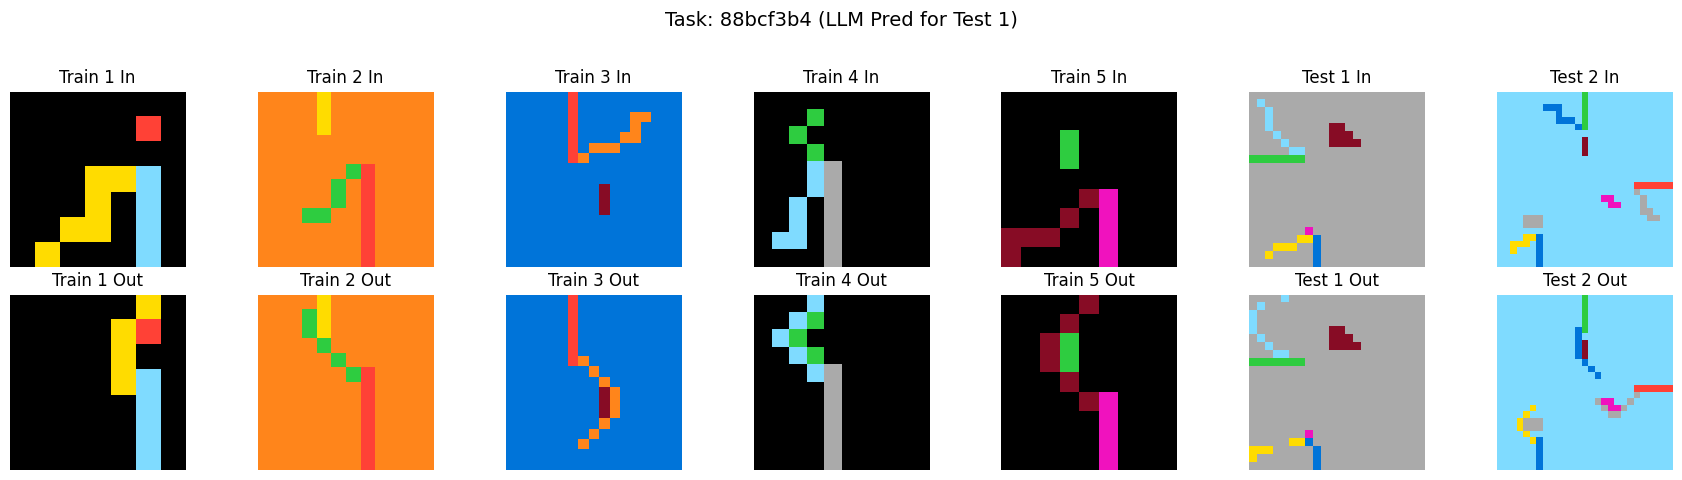

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 88bcf3b4 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, let's analyze the given examples to derive the transformation rules:

### Identified Patterns:
1. **Diagonal and Adjacent Non-zero Numbers:**
   - Each grid contains some pattern or cluster of non-zero numbers. These are clusters of numbers (like in examples of 3s, 9s, etc.) formed either along a row or a column, sometimes diagonal or even solo numbers.
   
2. **Shift the Cluster Upward:**
   - The clusters of non-zero numbers tend to be shifted upward towards the top of the grid, as seen in all examples.
   - When the numbers reach the top of the grid, they are aligned to either the leftmost or rightmost parts, maintaining their intra-relative positions.

3. **Differentiate Zero regions:**
   - The zeros generally appear to fill in regions below and to the side of the cluster after it has been shifted upward, maintaining a constrain

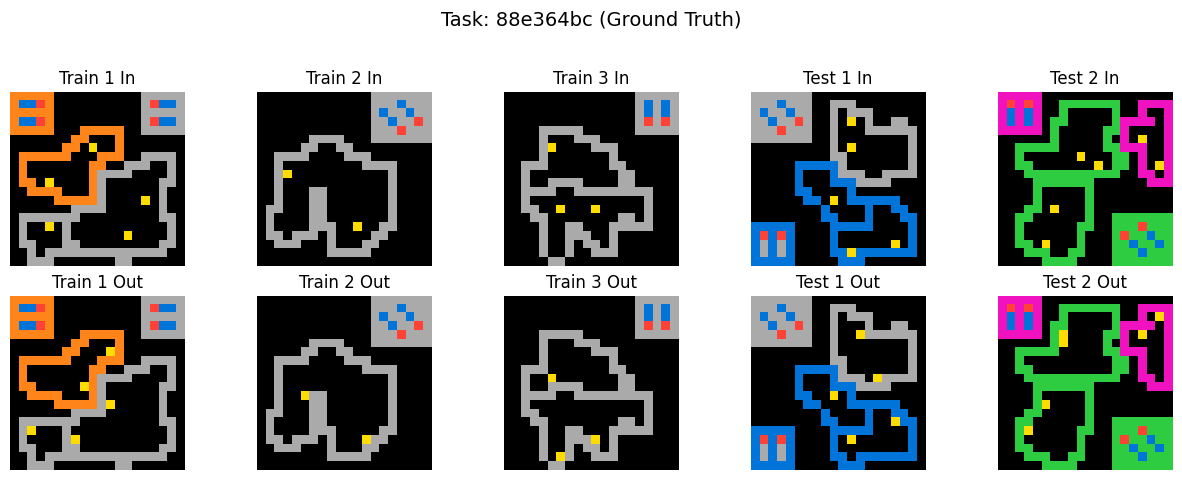


--- LLM Prediction Visualization (Task: 88e364bc / Test: 0) ---


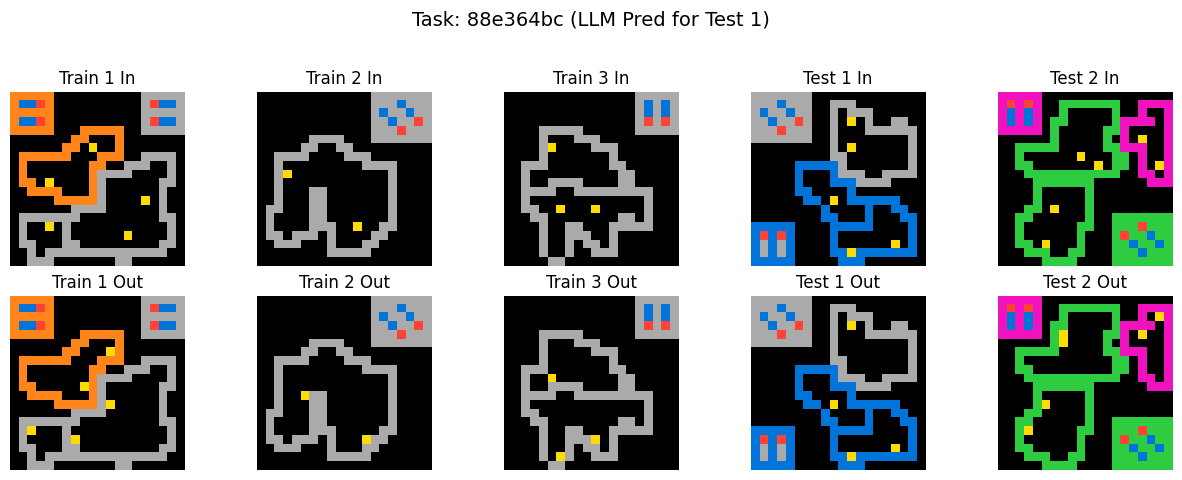

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 88e364bc / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the transformation from the input grid to the output grid, we need to deduce the transformation rules applied. Let's outline the transformations seen in the provided training examples:

### Observed Transformations:

1. **Regionality of Action:**
   - The transformations occur within specific regions or clusters defined by non-zero numbers. These regions are apparently framed by rows and columns of zeros, separating them visually.

2. **Finding '4's:**
   - We need to locate where '4's have been added in the output compared to the input. Typically, a '4' appears in outputs that did not have them in the corresponding input cell.
   
3. **Insert '4's Based on Specific Patterns:**
   - The additional '4's are inserted next to certain non-zero numbers within identifiable regions. Specifically, '4's have been inserted adjacent to isolated blocks of 

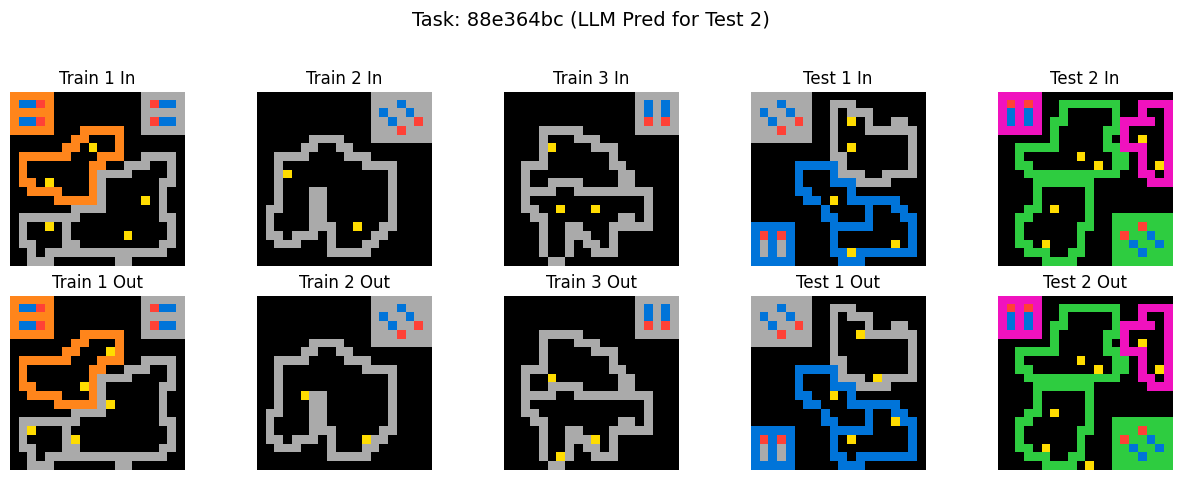

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 89565ca0 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem at hand, we need to identify the transformation rules that allow us to reduce the given grid into a smaller solution grid, as seen in the training examples. Let's break down the provided examples to infer these rules:

### Observations and Deduced Rules:

1. **Pattern Isolation**: In each input grid, there are larger blocks of numbers that form thematically distinct areas which are reduced to their simplified representations in the output.

2. **Blocking by Value**: The output seems to contain blocks of contiguous numbers. Each block in the grid can be represented by a single value in the output. For example, in the input grid where we have contiguous '1's, '2's, etc., only a single number representing that block appears in the solution grid.

3. **Layered Reduction**: The rule doesn't just pick any arbitrary value but focuses on co

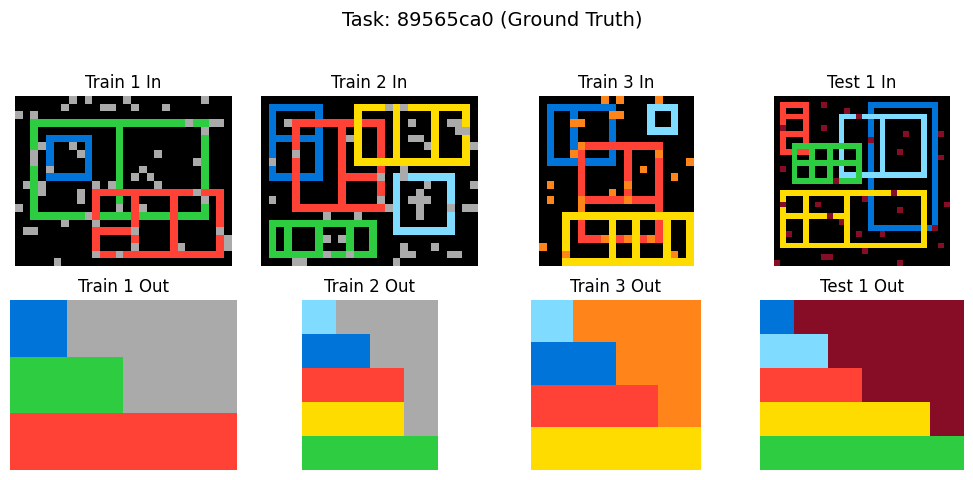


--- LLM Prediction Visualization (Task: 89565ca0 / Test: 0) ---


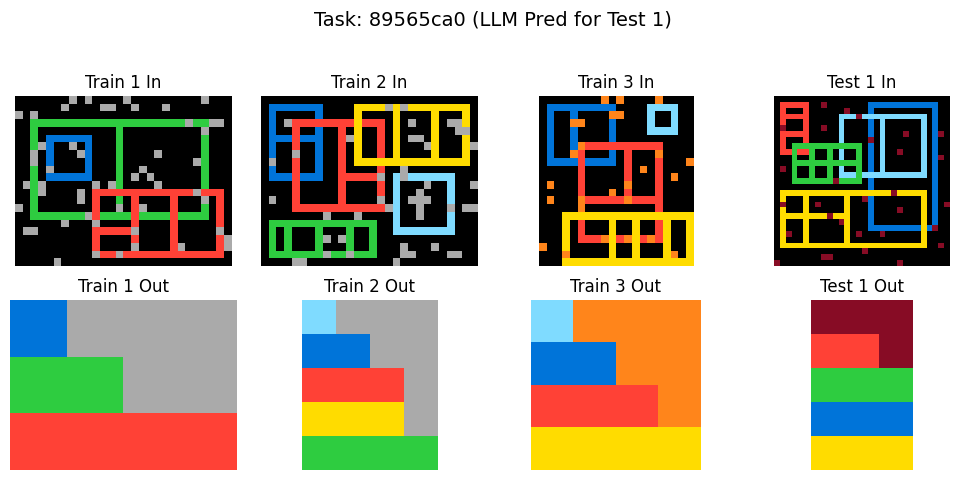

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((5, 3) vs (5, 6)))


===== Task: 898e7135 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the rules for transforming the input grid into the output grid, let's analyze the given train examples thoroughly to identify patterns and transformations:

### Analysis of Train Examples

1. **Example 1 Analysis:**
   - **Grid Reduction:** The input grid is reduced in size from a larger 20x15 grid to a smaller 12x12 grid.
   - **Dominant Color Assimilation:** The most frequently occurring color in the 2x2 sub-block (top of the smaller grid) replaces the entire block.
   - **Regularization and Filling:** Ensure each row and column in the output grid is consistently filled with the dominant surrounding color.
   - **Corner and Edge Handling:** The edges and corners maintain the framing colors to ensure the middle sections are correctly cropped and resized.

2. **Example 2 Analysis:**
   - The same pattern as Example 1 is recogn

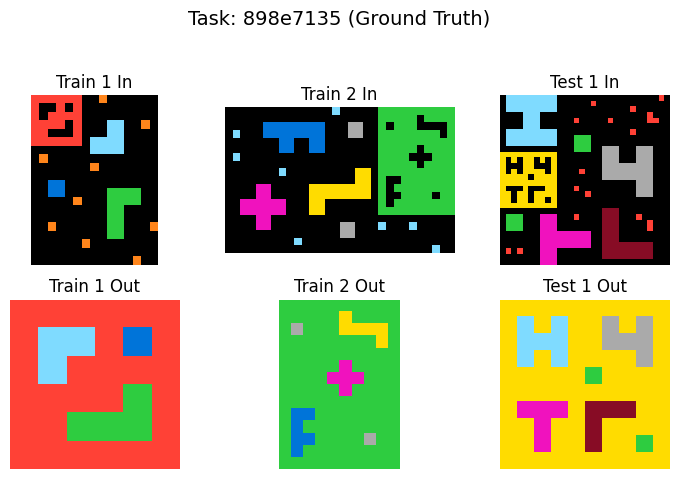


--- LLM Prediction Visualization (Task: 898e7135 / Test: 0) ---


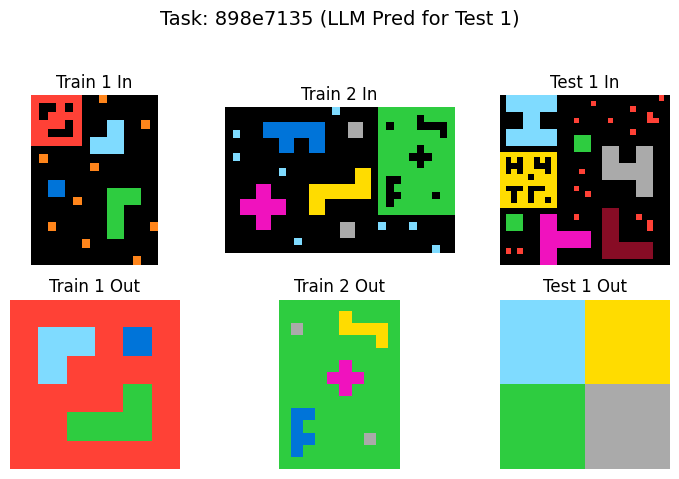

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((8, 8) vs (30, 30)))


===== Task: 8b7bacbf / Test Case: 0 =====

--- Raw LLM Response ---
```
Based on the provided examples, the transformation rule deduced appears to focus on changing certain clusters of specific numbers within a grid to another number. The process can be broken down into the following rules:

1. **Identify Clusters**: 
   - Look for contiguous clusters of a number in the grid (only horizontally or vertically contiguous, not diagonally) but focus particularly on number `3`. 
   - For each cluster of number `3`, the first observation in examples suggests keeping the `3`s and replacing `0`s or the number on alternate cells with `4`s within the cluster's immediate vicinity.

2. **Expand or Overlay the Cluster with Pattern**:
   - If `3` is part of a non-terminal line (meaning more `3`s are around horizontally or vertically), fill it with `4` but ensure the immediate surrounding or the line of `3` is orthogonal

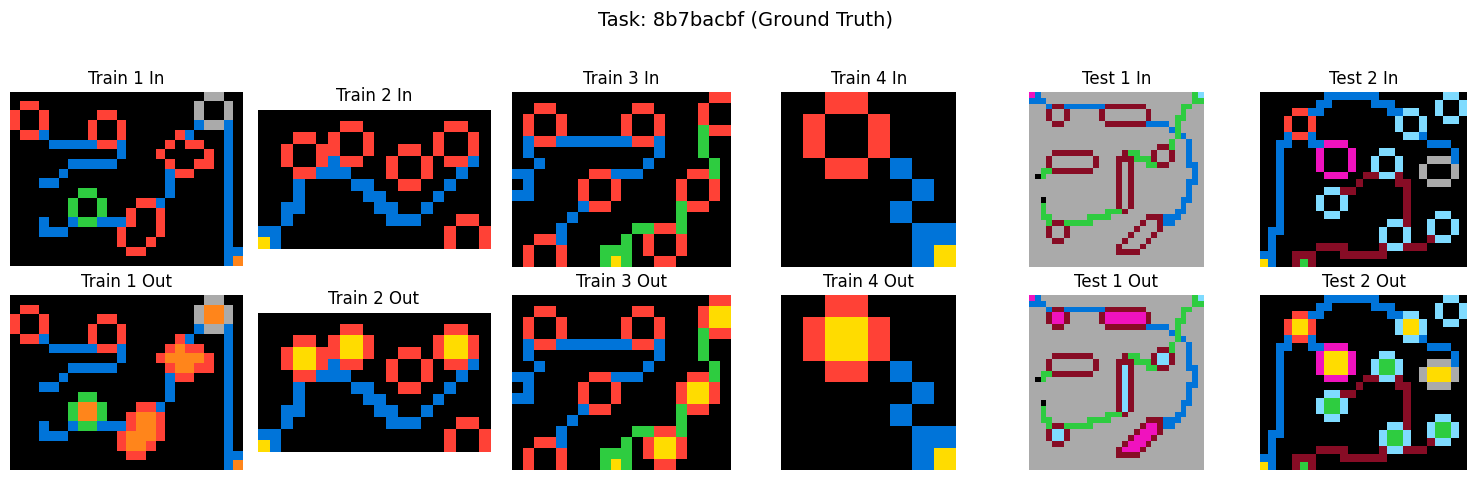


--- LLM Prediction Visualization (Task: 8b7bacbf / Test: 0) ---


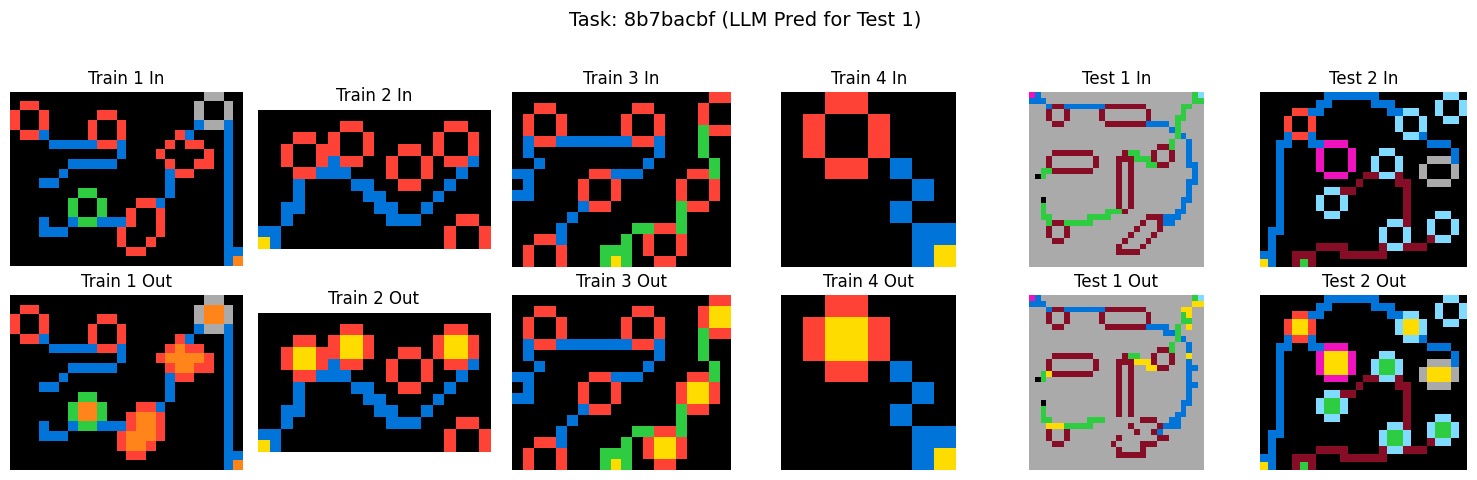

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 8b7bacbf / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, let's analyze the available examples and deduce the transformation rules applied to convert the input grid to the output grid.

### Observations from Examples:

1. **Doubling Rule:**
   - When we observe numbers like `2`, `5`, and `8` in the input grid, they often appear expanded into a larger square of the same number in the output grid.
   - The size of the square expansion is typically 2x2 for numbers like 2, 5, 8.

2. **Centralization of Bigger Numbers:**
   - Larger numbers such as `7` and `9` aren't doubled or expanded but maintain their positions or are shifted slightly.

3. **Transformation Detail:**
   - In every interaction, consider the surrounding zeroes and replace them with the expanded number if applicable.
   - This expansion seems to happen around isolated or groupings of numbers.

### Transformation Strategy:
Based 

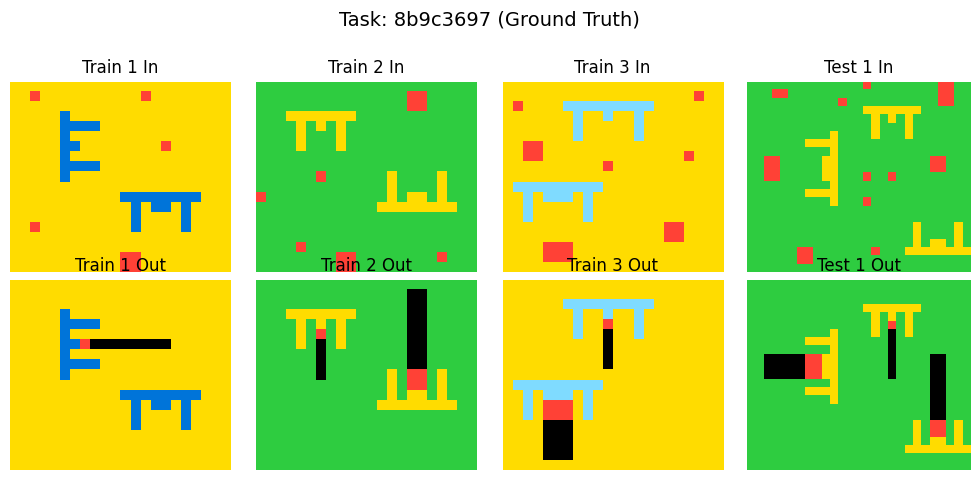


--- LLM Prediction (Task: 8b9c3697 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 8e5c0c38 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to identify the pattern and rules that transform the input grids into the corresponding output grids, as provided in the examples.

### Analyzing the pattern:

Both Example 1 and Example 2 aim to modify specific colored regions in the grid while preserving the rest.

1. In both examples:
   - The background is some uniform number (8 in Example 1; 0 in Example 2) that remains unchanged in the output.
   - Certain colored blocks (e.g., 1s and 2s in Example 1, and 2s and 4s in Example 2) appear in the input and also in distinct groups.
   - Some sections of the grid with specific numbers are partially or fully removed.
   - Not all numbers or blocks that have the same number are removed or modified.

### Identified Rules:
- **Preservation of the background:** The background numbe

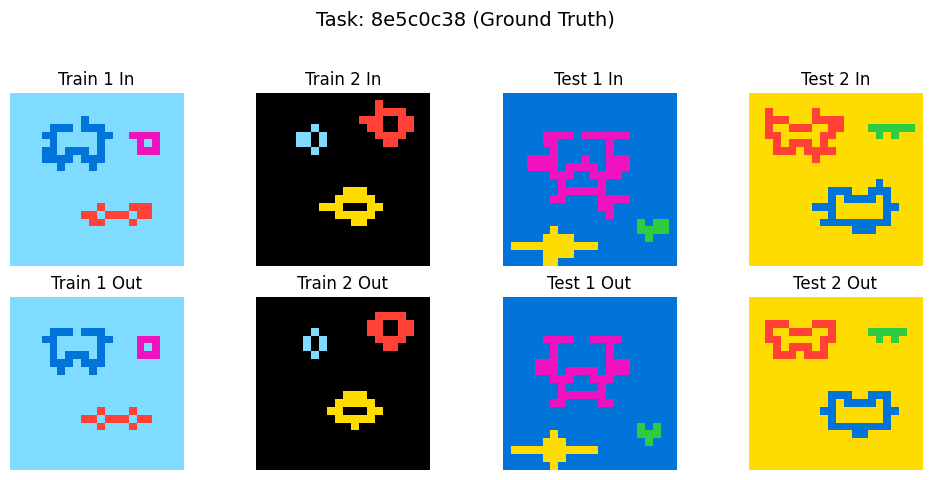


--- LLM Prediction Visualization (Task: 8e5c0c38 / Test: 0) ---


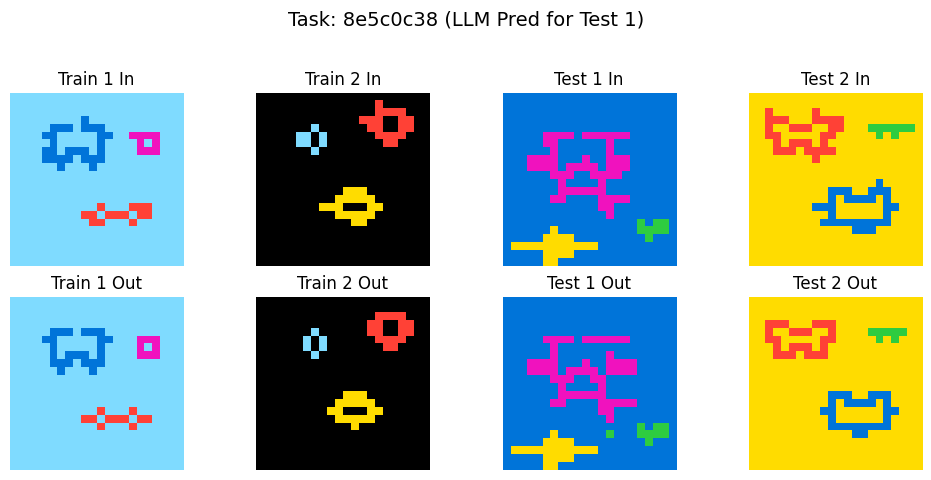

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 8e5c0c38 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, we must identify and apply specific rules to transform the input grid into the output grid consistently. Here's how to approach it step-by-step:

### Analyzing the Given Examples

1. **Colored Grids Recognition**:
   - Each example contains grids filled mostly with one dominant color, interspersed with regions of another color forming a pattern or a number.
  
2. **Rule Observations**:
   - In Example 1, focusing on specific lines or regions reveals areas of connected components with distinct colors (not the background color, which is '8' in Example 1 Input).
   - The pattern of connected cells retains some connectivity (clusters or sequences) but occasionally removes 'excess' pixels in certain arrangements.
   - In Example 2, patterns are also present where coloured numbers are represented, with specific removal of 'excess' cells re

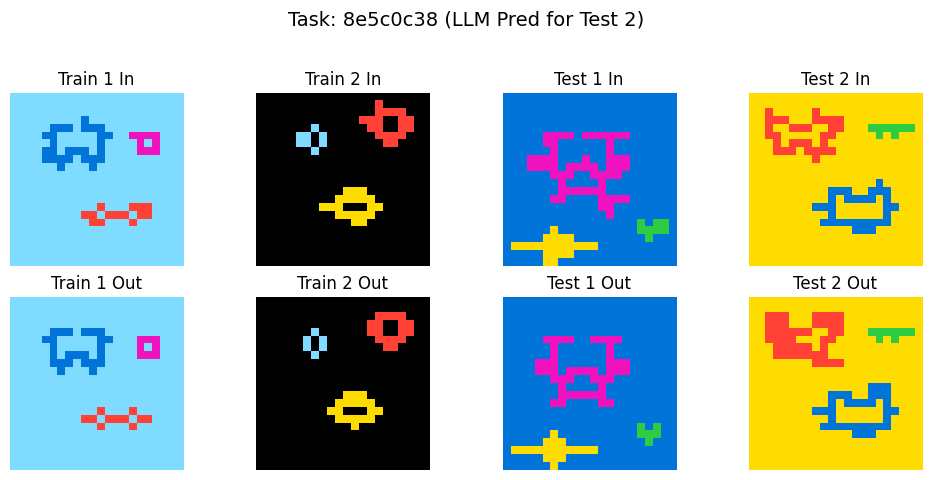

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 8f215267 / Test Case: 0 =====

--- Raw LLM Response ---
```
To find a solution for the given task, we need to identify a repeatable transformation process based on the provided training examples. Let's analyze the examples to define these rules.

### Analysis of the Training Examples:

1. **Example 1:**

   - Areas encircled by a number (like rows with lots of "4" or "8") form the primary patterns.
   - Inside these encircled areas, every other alternate vertical or horizontal sequence of '1' or empty sections are alternated with the encircling number (e.g., '1' becomes '4' alternately in a '4' encircled area).
   - This pattern formation does not apply to any number outside the encircled structure.

2. **Example 2:**

   - Similar observation as Example 1: Patterns are created such that numbers are alternated in vertical or horizontal sequences when surrounded completely by other numbers, either like '4', '6' e

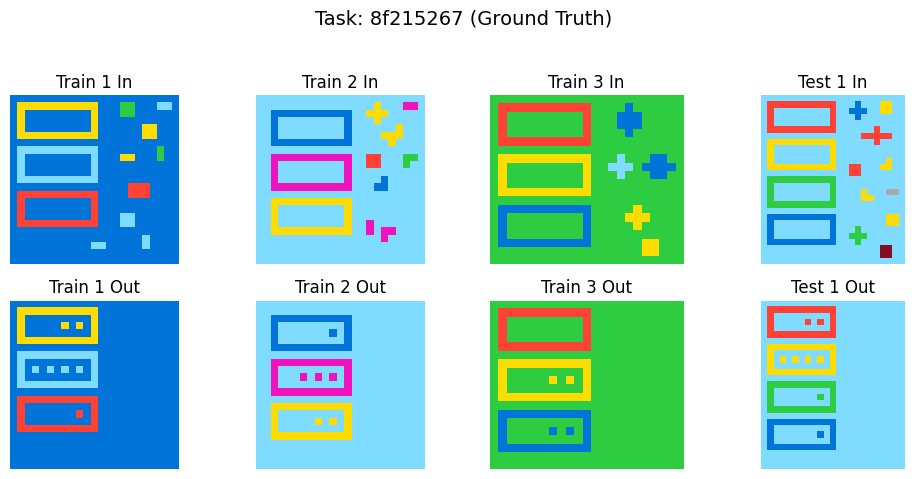


--- LLM Prediction Visualization (Task: 8f215267 / Test: 0) ---


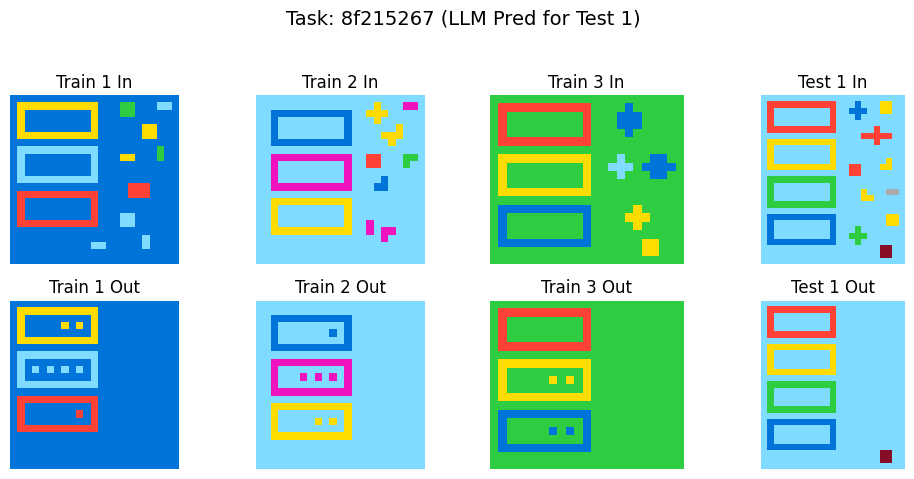

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 8f3a5a89 / Test Case: 0 =====

--- Raw LLM Response ---
```
To transform the input grid into the output grid using the patterns identified from the training examples, we can apply the following rules:

1. **Identify all non-'8' sequences**: In every row, sequences of numbers not equal to '8' are confined within the larger grid. Such sequences are usually on the rightmost side of the row. These sequences are primarily composed of '1's in the input.

2. **Form a Border**: Based on the inputs to outputs:
    - Identify the leftmost '1' (or leftmost start of any non-'8' sequence) in these sequences that are surrounded mostly by '8's.
    - Form a border to the left of the detected leftmost '1' using the number '7'. This '7' border extends from the start of the sequence to the edge of the grid, always filled leftwards into the '8' area. 
    - If the border reaches the start or end of a row or another non-'8' sequenc

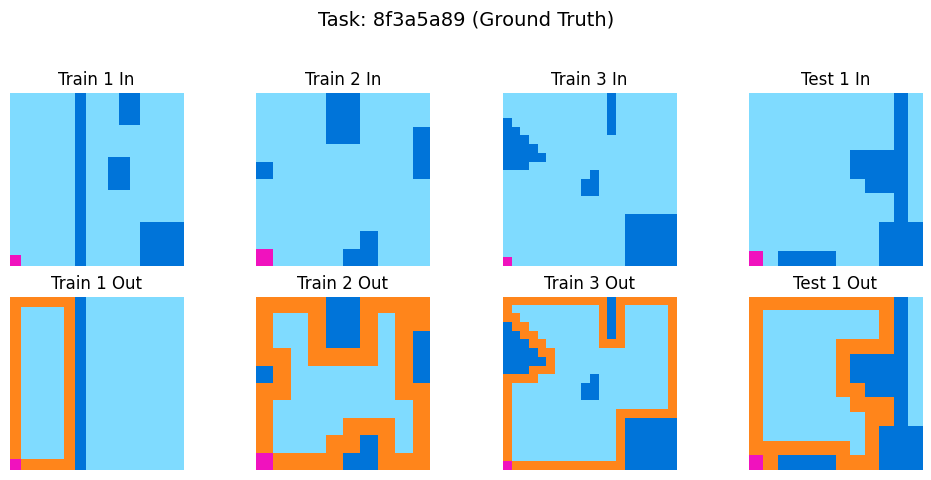


--- LLM Prediction Visualization (Task: 8f3a5a89 / Test: 0) ---


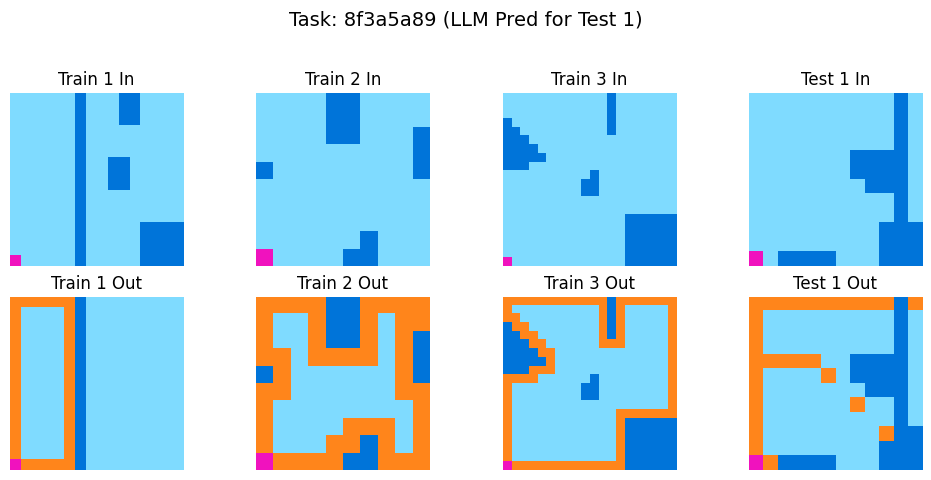

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 9385bd28 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to determine the pattern by which numbers are expanded horizontally in each row of the matrix from the input to the output. Here's the breakdown of the process observed from the train examples:

1. **Identify Non-Zero Segments:**
   - The task involves identifying contiguous segments of the same non-zero number in each row. These segments act as the nuclei of expansion.
   
2. **Expansion Rule:**
   - Each detected segment is expanded outwards horizontally by surrounding the segment with its own number. The expansion occurs equally on both sides of the segment.
   - For example, if the detecting number is 3 and the segment is `[3, 3]`, then after expansion it becomes `[3, 3, 3, 3]`.

3. **Boundaries of Rows:**
   - The expansion is limited by the row's boundaries. If the expansion hits the edge of the row, it stops at that

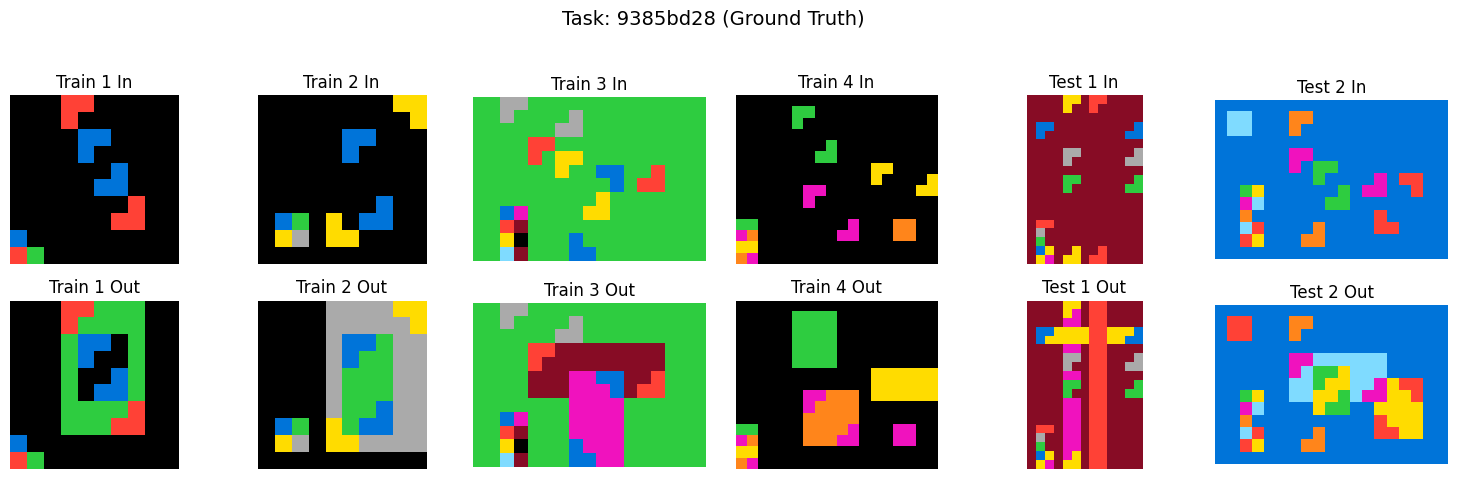


--- LLM Prediction Visualization (Task: 9385bd28 / Test: 0) ---


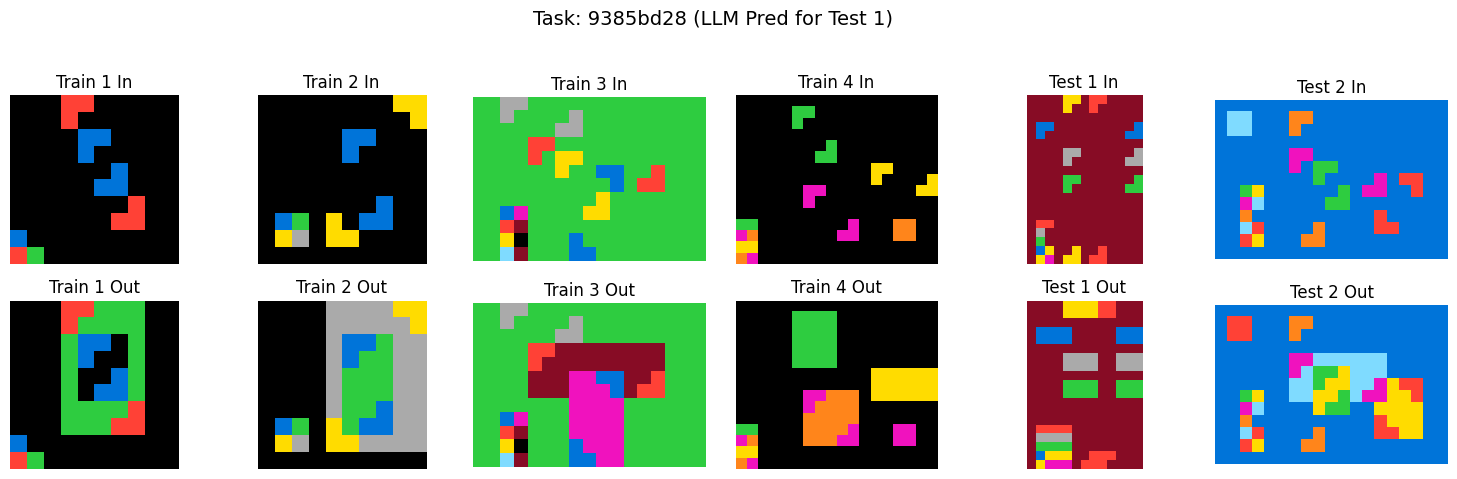

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 9385bd28 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given task, we need to analyze the provided examples and deduce a transformation rule set that can convert the input grids into the corresponding output grids. Here’s a breakdown of the patterns and rules we derive from the training examples:

1. **Identify Unique Patterns and Clusters:** 
    - Recognize distinct "clusters" or "blocks" of numbers surrounded by zeros or different numbers.
    - These clusters have specific numbers that may be expanded or modified. In many examples, a single number or group of identical numbers are converted or expanded into larger filled areas.
   
2. **Rule Deduction:**
   - Transform distinct clusters by expanding them horizontally and vertically.
   - Fill columns and rows with the cluster's identifying number or another that appears to replace it in a larger filled area.
   - The numbers defining the cl

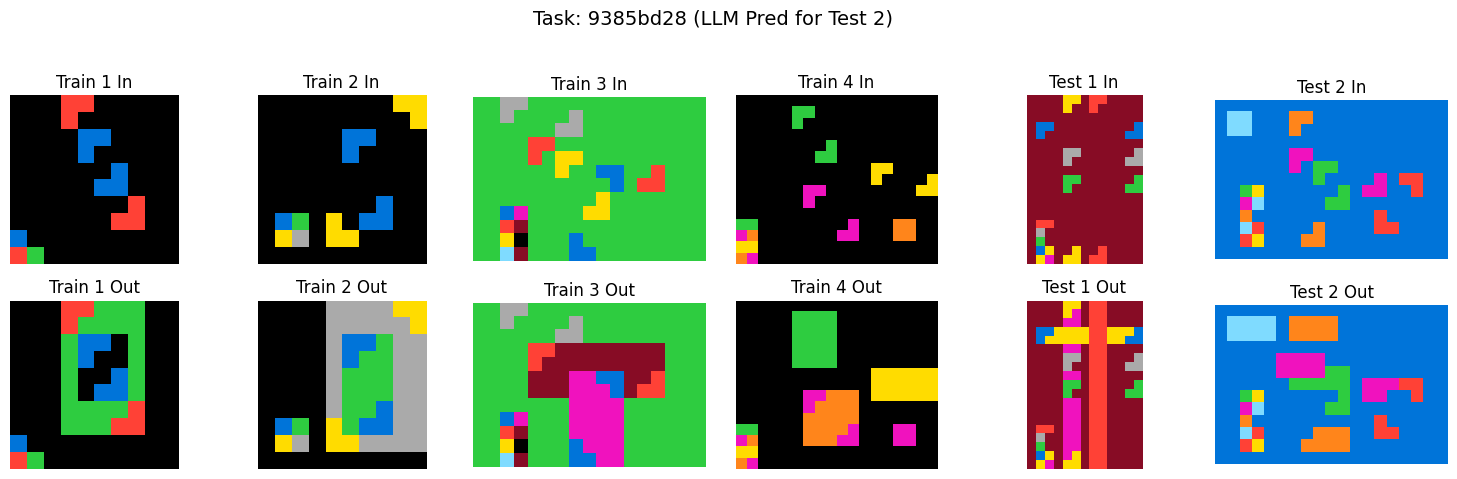

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 97d7923e / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the provided ARC problem and transform the given test input grid according to patterns observed in the training examples, we need to identify and define transformation rules based on the differences between input and output for each training example.

**Observed Patterns and Rules:**

1. **Selective Replacement Rule:**
   - In all the examples, a certain number in the grid is selectively "reduced" or replaced by the first non-zero digit in the top-left segment of the matrix.
   - The rule indicates replacing certain numbers (those which form a distinct column of the number) with a fixed digit found in the grid.
   
2. **Identified Number for Replacement:**
   - In Example 1, the number `5` in the columns starting from `3rd column` onward is replaced by `2`, which appears initially in the matrix.
   - In Example 2, the number `3` in the columns 

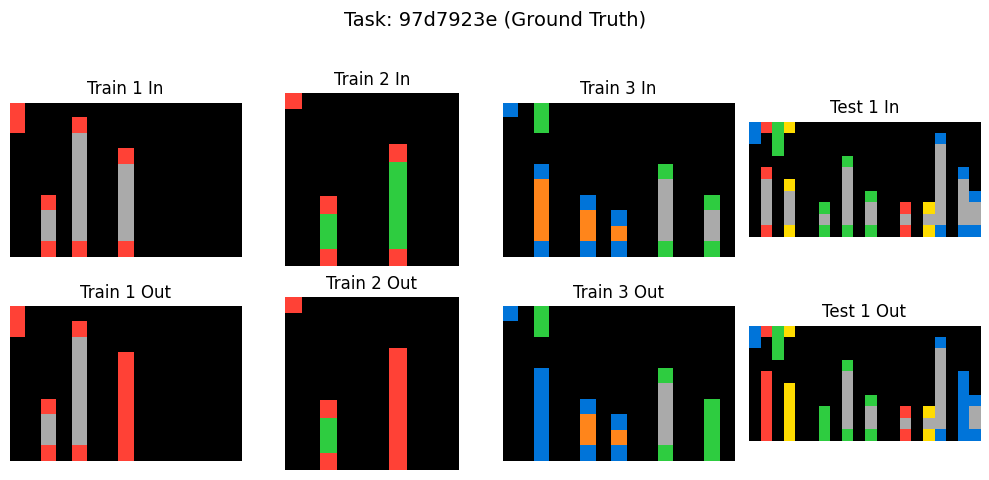


--- LLM Prediction Visualization (Task: 97d7923e / Test: 0) ---


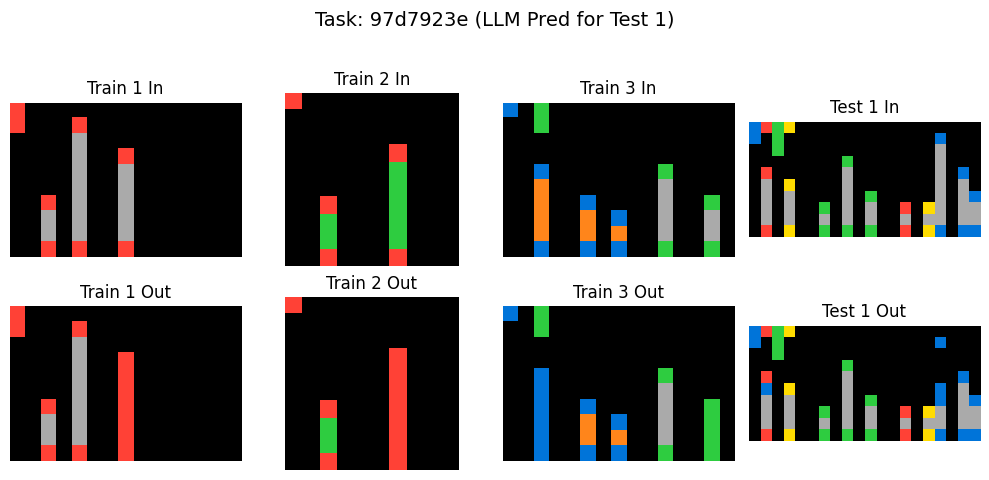

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: 981571dc / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the task, we need to identify the pattern used for transforming the input to the output grid. Based on the provided example inputs and outputs, let's determine the transformation rules:

### Analysis:

1. **Observation of Patterns:**
   - The overall structure and dimension of the grid are preserved (dimensions remain unchanged).
   - Elements in the input grid may appear to shift or expand slightly in output, along a specific pattern or direction. This is based on the presence of zeros or empty elements which guide how non-zero elements are modified and rearranged.
   - There is a clear tendency to fill empty slots in the grid starting from specified directions.

2. **Consistent Patterns in Transformation:**
   - Non-zero elements are replicated or spread into neighboring zero (or empty) slots, essentially "filling" the gaps following the natu

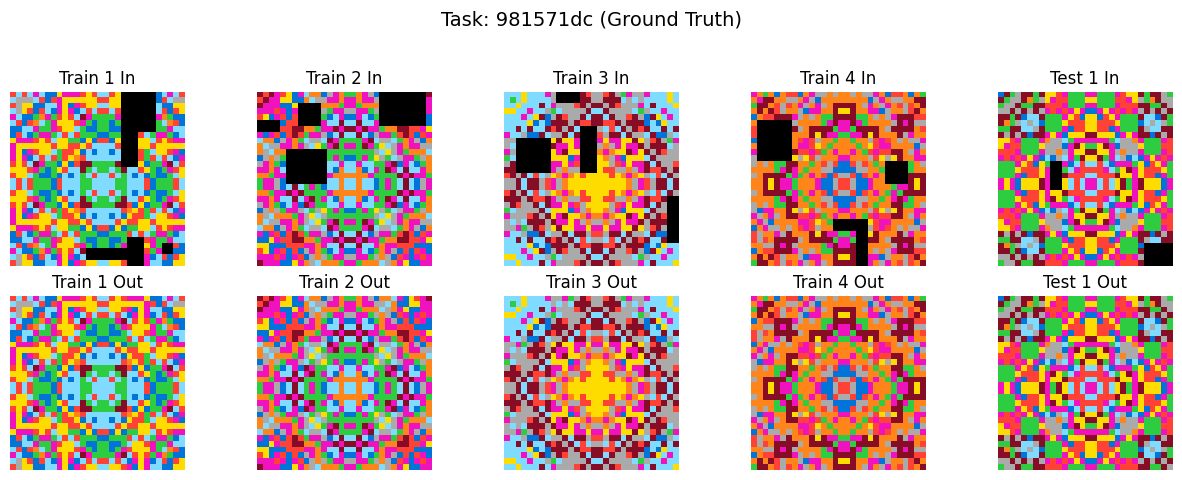


--- LLM Prediction (Task: 981571dc / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: 9aaea919 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve these ARC-style puzzles, we need to identify the transformation pattern that turns each input grid into its corresponding output grid. Here are the steps taken and the pattern deduced:

### Pattern Identification:
1. **Pattern Detection:** The main pattern is to identify pairs of non-background colors that form a box shape in the grid. In each example, you have a grid filled with a primary color (background) and smaller shapes filled with other colors.
   
2. **Addition of Neighbors:** We can observe that in every small box or shape made of a different color from the background, there's a shape next to it in a vertical or horizontal direction in the output. The colors of the newly added boxes seem to follow the numbers used in the non-background blocks already present in the test input – but shi

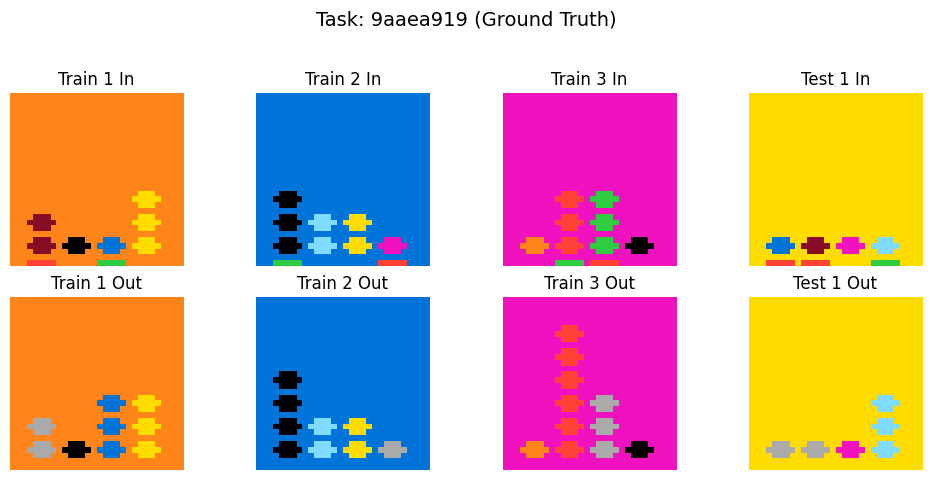


--- LLM Prediction Visualization (Task: 9aaea919 / Test: 0) ---

Error during LLM prediction visualization for 9aaea919, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.


===== Task: 9bbf930d / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, let's identify the transformation rules derived from the given examples. 

### Transformation Rules:

1. **Shift and Swap Operation**:
   - In rows where the initial elements are `6 7`, perform specific transformations:
     - If the row starts with `6 7 7`, 
       - If the first different value from 7 starts as `7`, then shift the whole row right by one position. End the row with `6` and continue the other elements.
       - If the first different value from 7 is anything else (like `1`, `3`), shift the first two elements of the row (i.e., `6 7`) to the right end, maintaining order, and the rest of the ro

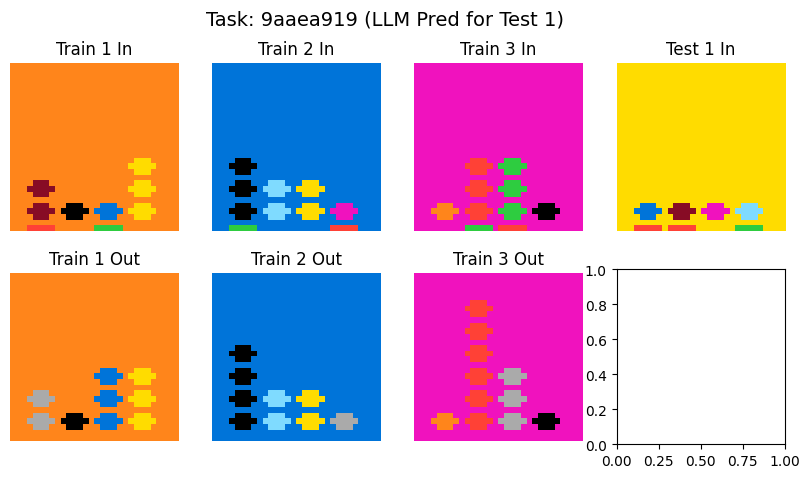

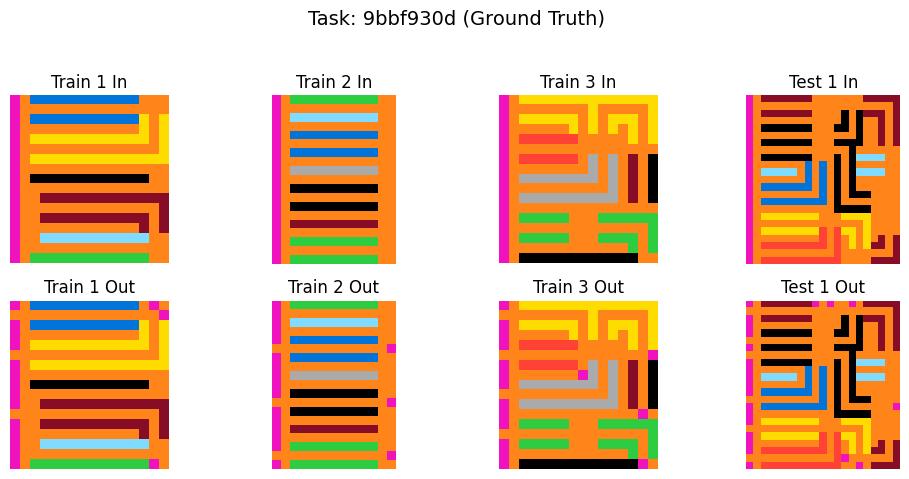


--- LLM Prediction Visualization (Task: 9bbf930d / Test: 0) ---


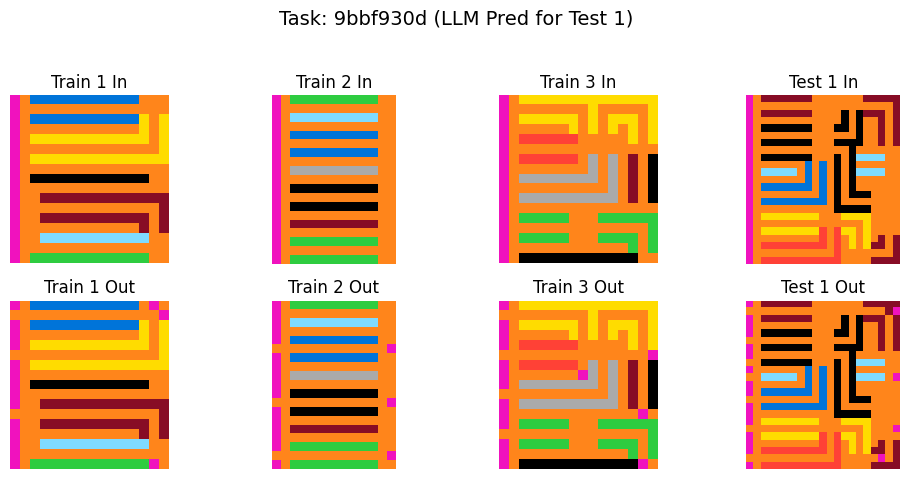

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: a251c730 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules, let's analyze the provided training examples:

### Rule Deduction:

#### Characteristics in Example Transformation:

1. **Identify the Structured Pattern:**
   - Notice in both examples, the solution grids are cut-out square shapes (e.g., 20x9 in the first example, 8x19 in the second) from larger input grids.
   - The top and bottom rows of the solution feature a solid boundary of the first number from the 2nd row of the input grid (also found at the beginning of every row within these cut-outs).

2. **Determine Interior Patterns:**
   - The numbers within the cut-out square are maintained as they appear but they can be surrounded by the same number pattern from the first number of any content row.
   - Essentially, the shape maintains an exterior border of the same number (lets say, A) and within it, whatever smaller

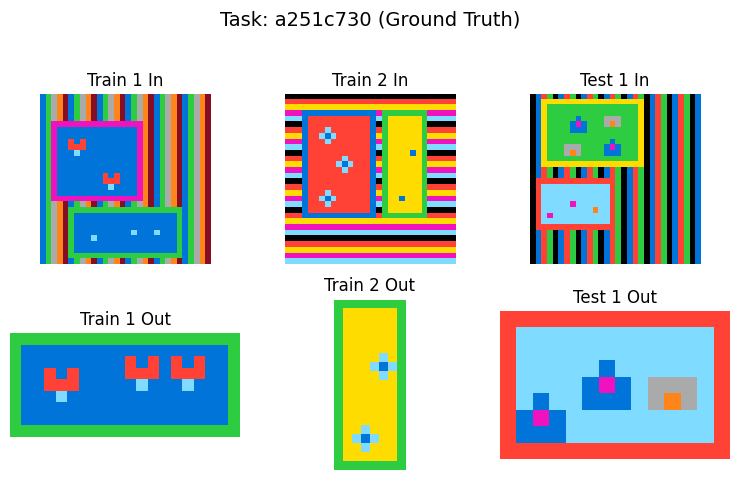


--- LLM Prediction Visualization (Task: a251c730 / Test: 0) ---


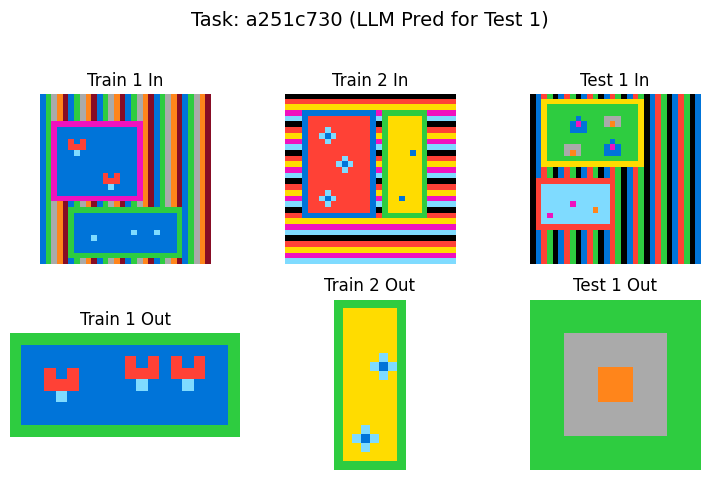

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((5, 5) vs (9, 14)))


===== Task: a25697e4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve these types of problems, it's essential to identify specific patterns and rules that guide the transformation from input to output. Observing the transformation rules in the training examples, we can deduce the following pattern:

### Observed Patterns in Training Examples:
1. **Identify Regions:**
   - There are specific regions in the grid labeled with numbers other than '1'. These numbers tend to form blocks or shapes within the grid.
   
2. **Alterations of Regions:**
   - These regions may appear in different places and occasionally swap patterns around them.
   - The numbers can occupy distinct regions for each grid, forming patterns which are then shifted or adjusted in some way.

3. **Shared Space Rules:**
   - The transformations appear to involve taking certain regions and moving them to different parts of the grid w

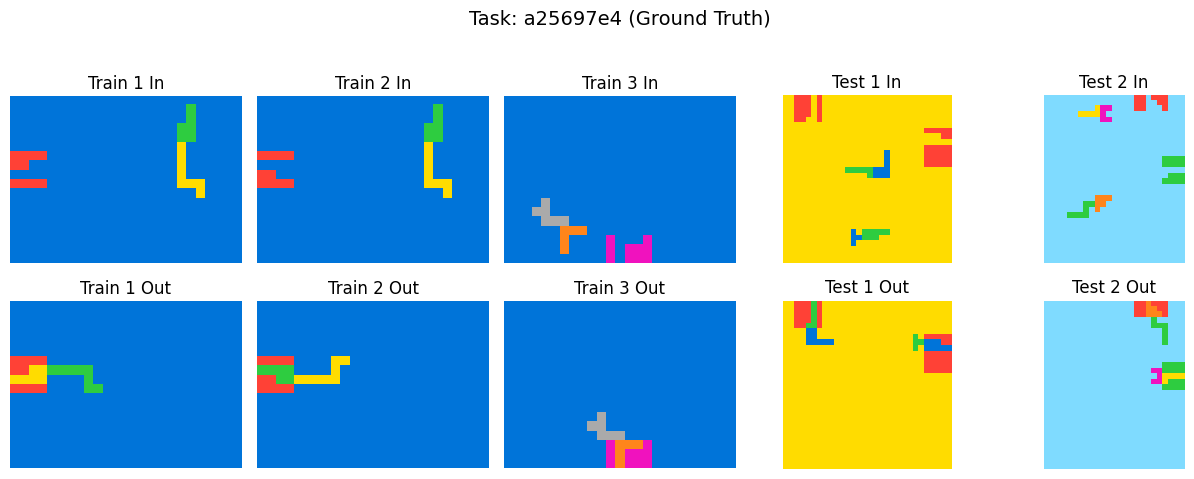


--- LLM Prediction Visualization (Task: a25697e4 / Test: 0) ---


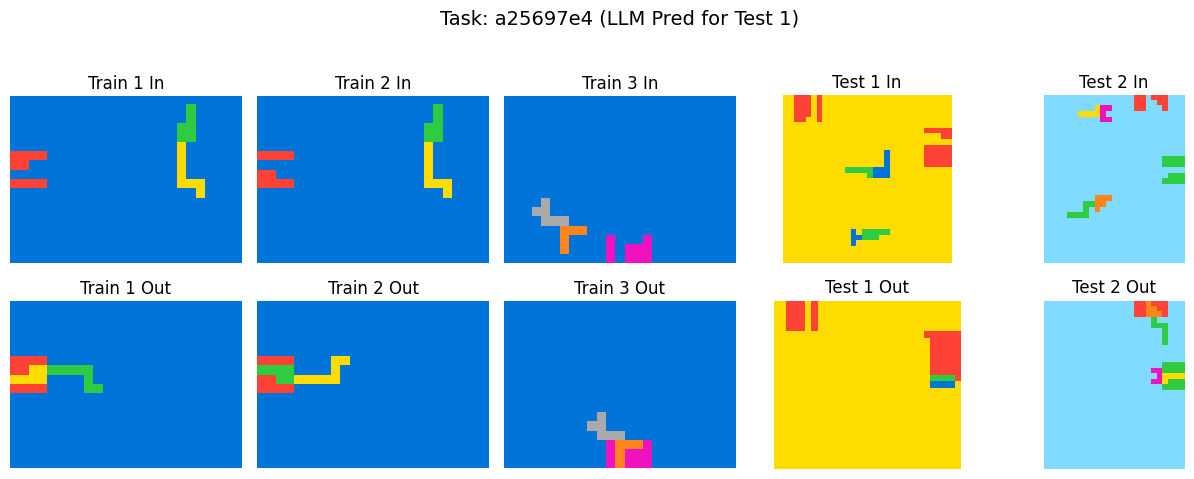

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((27, 30) vs (30, 30)))


===== Task: a25697e4 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem, let's analyze the transformation rules observed in the training examples:

### Observations and Deductions:

1. **Initial Region Isolation:**
   - In the input grid, there seems to be a pattern of different numbers forming specific shapes or regions within a larger grid filled primarily with the number `1` or another constant number (which changes based on the example).

2. **Region Movement:**
   - The pattern involves moving the regions and rearranging them so that part of one region moves to a defined row in the grid and connects or combines with another region.

3. **Region Identification:**
   - Regions are identifiable by numbers other than `1` (or the primary number in the grid), such as `2`, `3`, `4`, etc. They seem to be standalone or connected blocks or lines.

4. **Restructuring:**
   - The overall s

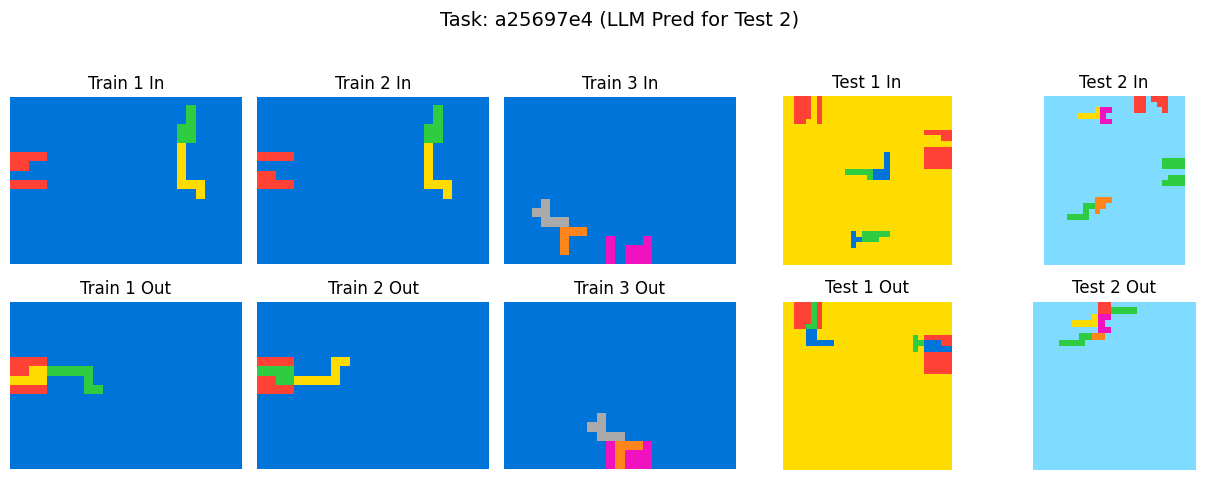

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((26, 25) vs (30, 25)))


===== Task: a32d8b75 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the ARC style task, we need to identify a repeated pattern transformation applied to the given inputs to obtain their corresponding outputs. After analyzing the given examples, we can define a systematic approach towards a solution as follows:

1. **Deducing Transformation Rules:**
   - Each input consists of multiple horizontal segments filled predominantly with one color. Multiple horizontal segments can repeat.
   - The segments are surrounded by '0's and '6's, which seem to act as margins and delimiters respectively.
   - The transformation extracts the middle section bound by '6' columns.
   - The output comprises specific sections extracted and any non-zero transformations (like removing some colors and adding different patterns within the bounds).

2. **Steps to Transform:**
   - Identify vertical columns of '6' in t

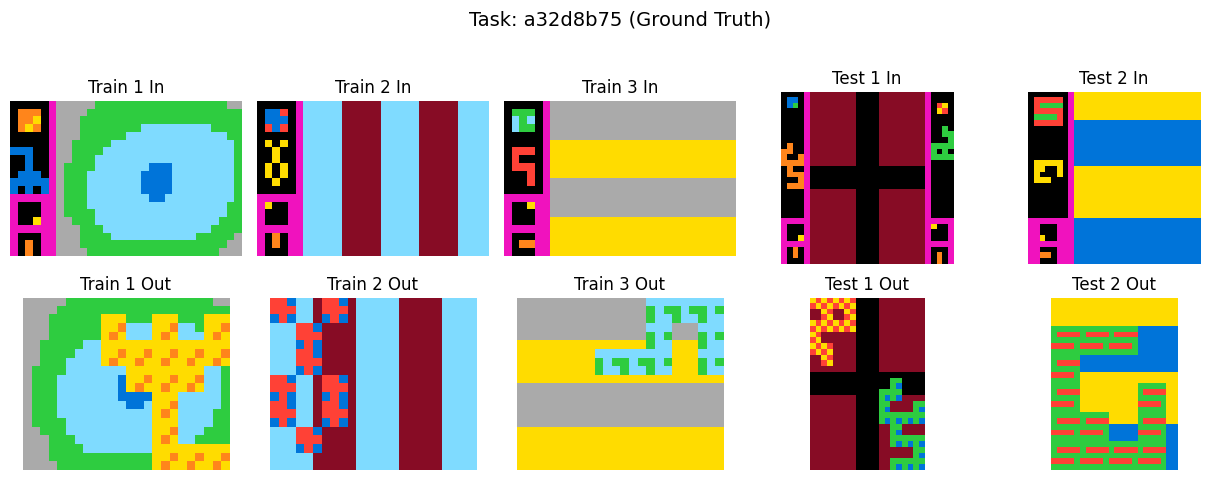


--- LLM Prediction Visualization (Task: a32d8b75 / Test: 0) ---


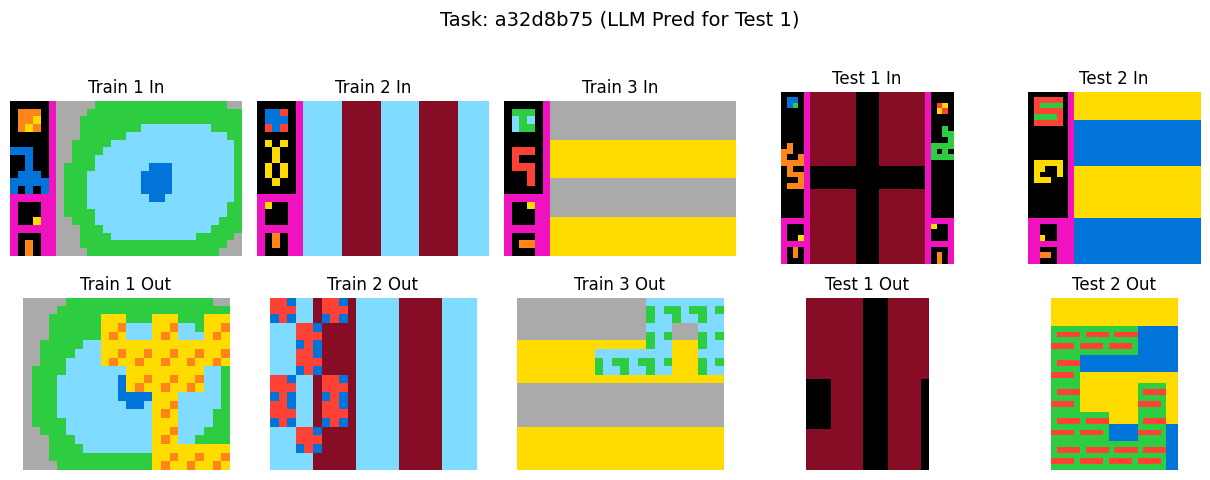

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((21, 15) vs (30, 20)))


===== Task: a32d8b75 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the ARC task presented, let's analyze the patterns and transformations needed for the given train examples and apply the rules to the test case.

### Observations from the Train Examples:
All train examples share a similar structural characteristic: there are patterns of numbers in the inputs that transform into specific structured patterns in the outputs:

1. **Background Removal**: 
   - All examples have some form of '0' that acts as a background or divider between sections. These are not present in the solution outputs.

2. **Block Patterns**:
   - The numbers in the input are often clusters of the same value but can include small variations or noise (e.g., a single different number interspersed within a block).
   - The primary task seems to distract the inner pattern and remove the noise/divider.
   - Numbers like '6'

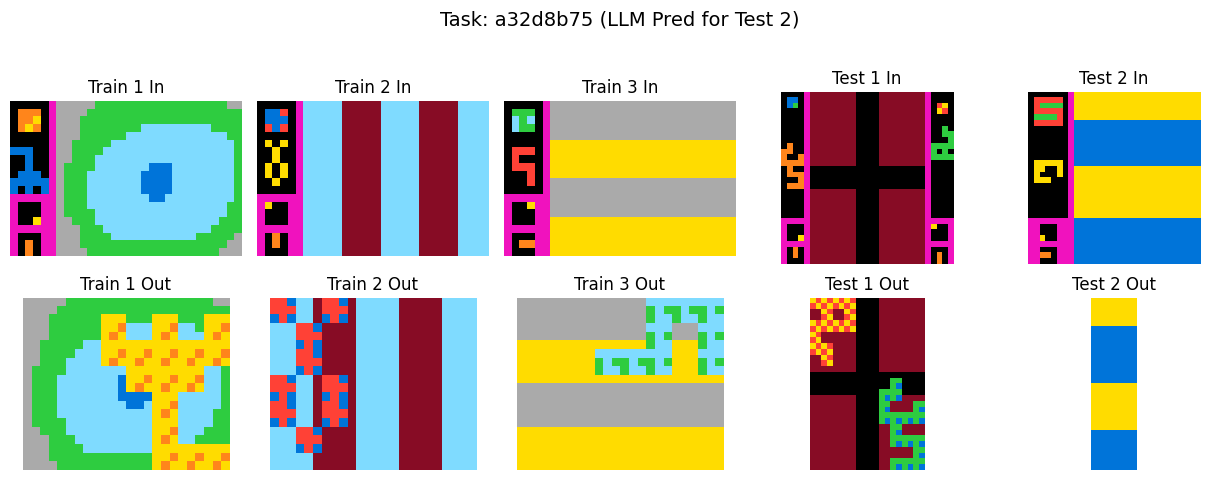

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((30, 8) vs (30, 22)))


===== Task: a395ee82 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules applied to these grids, let's analyze the training examples closely.

**Rule Extraction**

Upon observation of the provided examples, the following pattern can be deduced:

1. **Identifying the Pattern:**
   - In each example, certain numbers form a distinct pattern within the grid. These are identified by numbers differing from the most common number in the grid, typically positioned in small clusters.
   - Example 1: '8', '2' in a 4x4 grid of mostly '4's.
   - Example 2: '1', '2' in a 3x3 grid of mostly '3's.
   - Example 3: '4', '6' in a 7x7 grid of mostly '7's.

2. **Transformation:**
   - For each unique number group found (e.g. a diagonal line, square, etc.), create a mirrored pattern along the vertical or horizontal axis within a specific segment of the grid. The mirrored pattern is placed wr

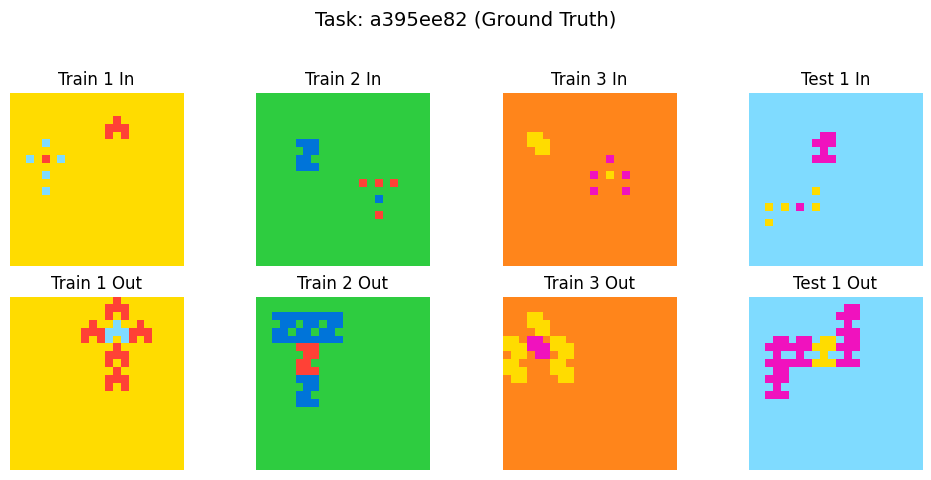


--- LLM Prediction Visualization (Task: a395ee82 / Test: 0) ---


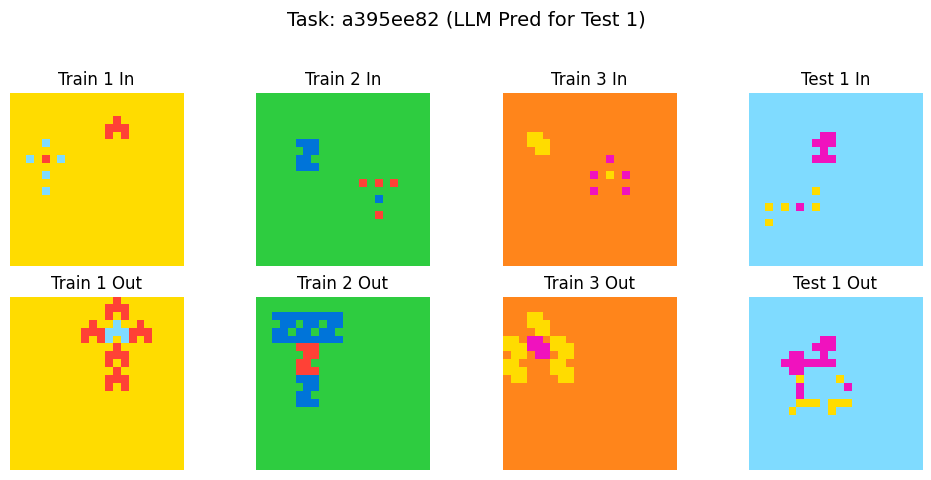

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: a47bf94d / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we need to understand the transformation rules from the given input grid to the solution grid using the examples provided. Here's a step-by-step analysis:

### Observations:
1. **Vertical Bands of Numbers**: In both the input and solution examples, groups of identical numbers appear in vertical bands. Examples include the numbers `3`, `2`, `4`, etc., in Example 1; `1`, `2`, `3`, `4` in Example 2; and `2`, `4`, `6`, in Example 3.
   
2. **Transformation Pattern**: Each vertical band of numbers in the input is partially or completely transformed in the solution grids. The numbers in the middle of these bands are replaced with `0`, seemingly forming a 'spaced' or 'gapped' pattern.

3. **Preservation of Edges**: The leftmost and rightmost occurrences of the numbers in each vertical band remain unchanged, and the middle numbers become `

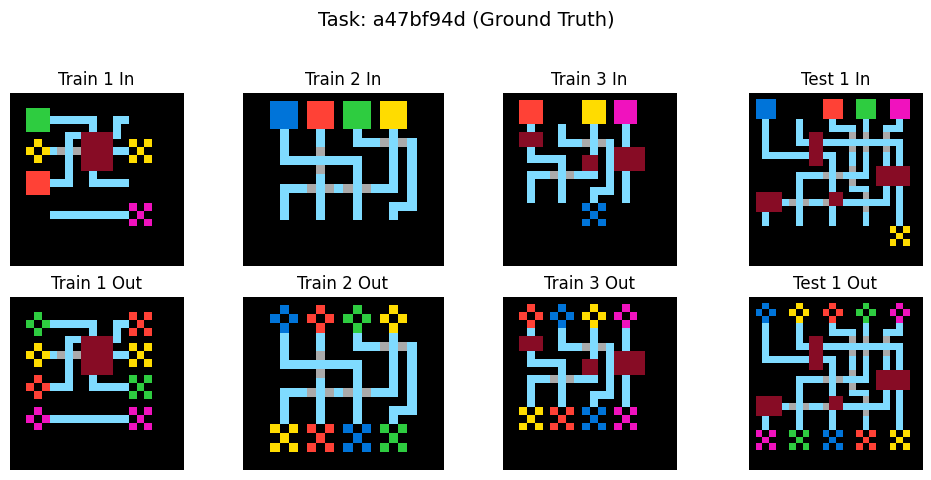


--- LLM Prediction Visualization (Task: a47bf94d / Test: 0) ---


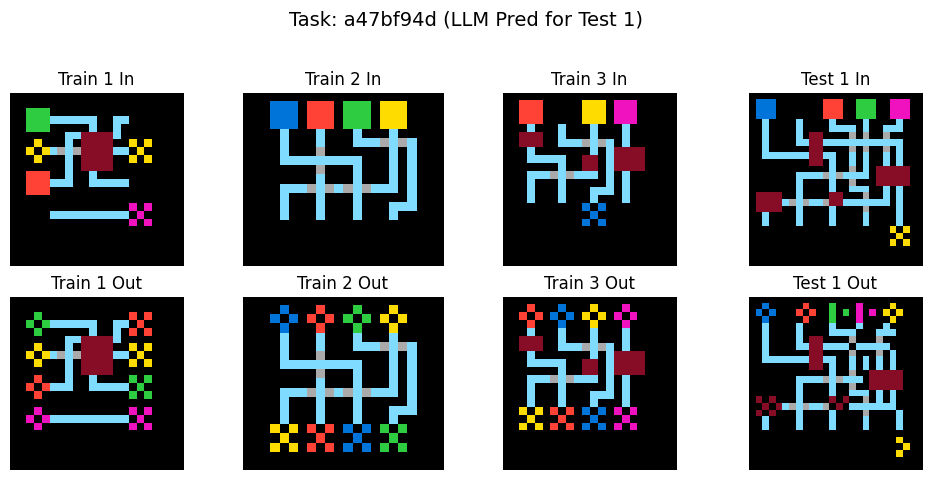

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: a6f40cea / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to analyze the relationships between the input and output grids and identify the transformation rules. Let's break down the train examples one by one, and then define a generalized transformation rule.

### Analysis of Train Examples:

**Example 1:**
- The initial grid has lines of distinct numbers (2s, 3s, and 4s) in a mostly uniform background of 8s.
- The output is a small block (4 rows by 7 columns) that seems to be extracted from a larger structure.
- It seems to grab lines of 2s, 3s, and 4s, centered around a specific part of the original grid.

**Example 2:**
- The pattern suggests extracting rows prominently involved in intersections or features that have mid sections with changes (visible change from the surrounding).
- The output grid is a cropped block, focusing on the central changes where the numbers occur betwee

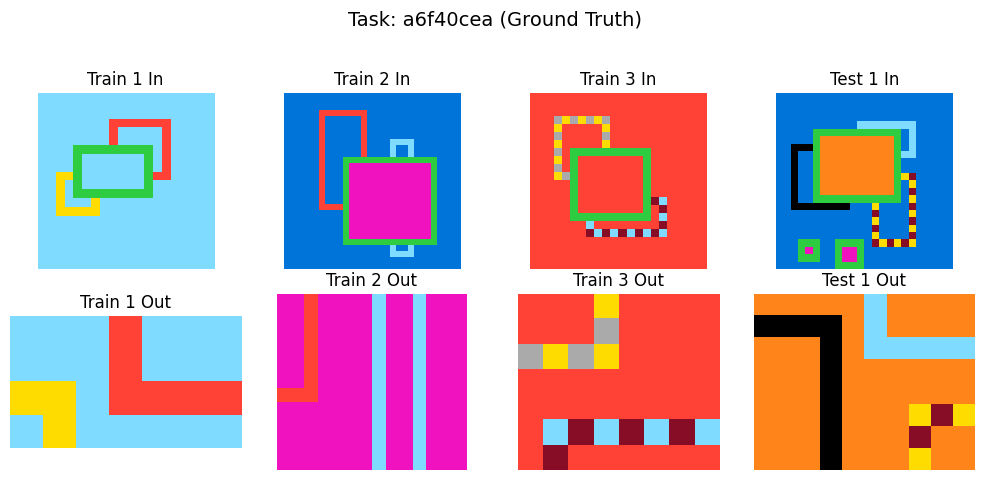


--- LLM Prediction Visualization (Task: a6f40cea / Test: 0) ---


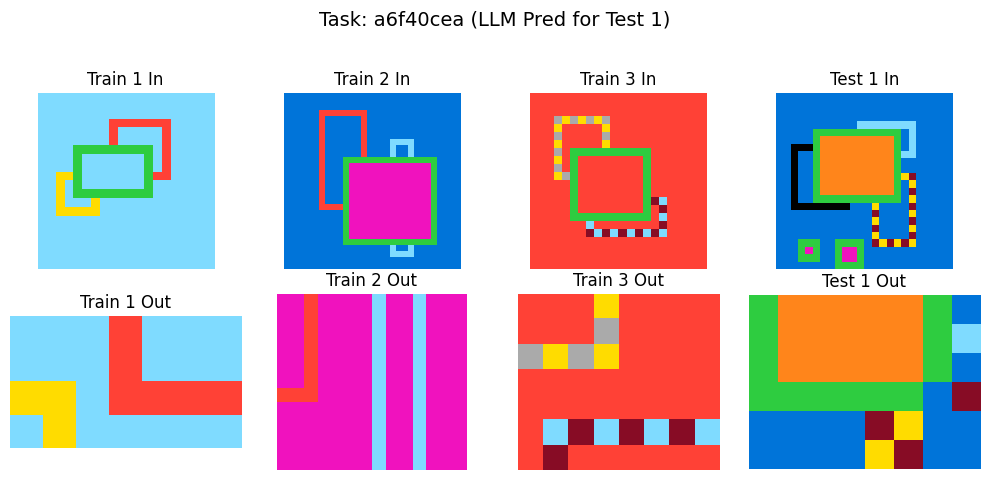

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((6, 8) vs (8, 10)))


===== Task: aa4ec2a5 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's analyze the transformation rules that are applied to convert the input grid into the output grid for each example in the training data.

### Observations:

1. There is an identifiable pattern of regions composed mostly of "1"s in the input grid surrounded by "4"s. These regions have varied shapes and sizes.

2. In the output grid, these regions are transformed:
   - Each region made up of "1"s becomes enclosed with a border of "2"s.
   - Depending on the region shape and size, some interior "1" values are transformed into different values (such as "8" or "6") based on a set rule or transformation logic.

3. Importantly:
   - Perimeters are enclosed with "2".
   - Corners or every second row in many grid examples feature an "8", and specific inner patterns feature a "6" based on certain conditions.

### Tran

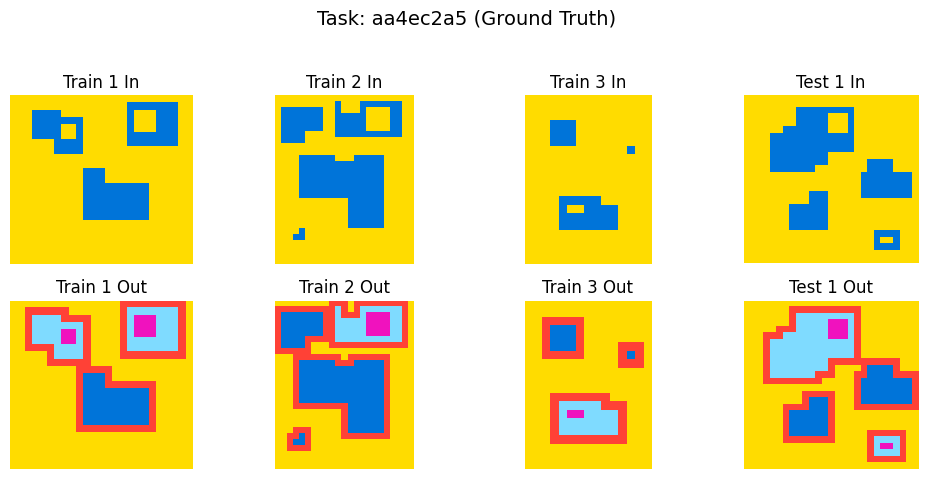


--- LLM Prediction Visualization (Task: aa4ec2a5 / Test: 0) ---


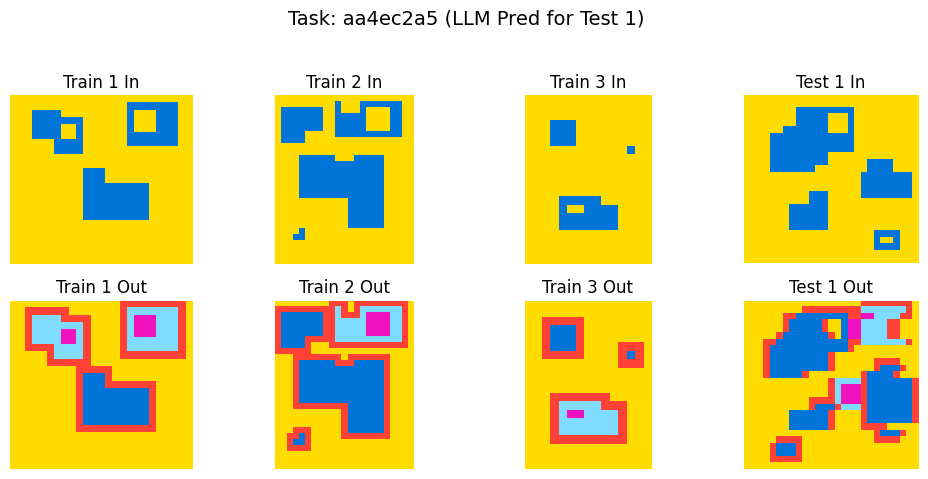

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: abc82100 / Test Case: 0 =====

--- Raw LLM Response ---
```
To transform the input grids to their respective output grids as seen in the provided examples, a set of rules can be deduced and applied. Let's break down the transformation:

1. **Identify the Pattern of Non-Zero Numbers:**
    - In each example, the grid contains blocks of numbers (e.g., 8s, 6s, etc.).
    - Each of these numbers is explicitly present in both input and output and does not change its position or value but indicates blocks that might undergo changes.

2. **Identify the Changes:**
    - It appears that the grid is effectively split into blocks of consecutive numbers or isolated non-zero numbers.
    - A specific non-zero number (that is not part of the blocks seen previously) seems responsible for triggering the transformation.
    - In Example 1, for instance, `1` seems to trigger a transformation that results in the replacement of all

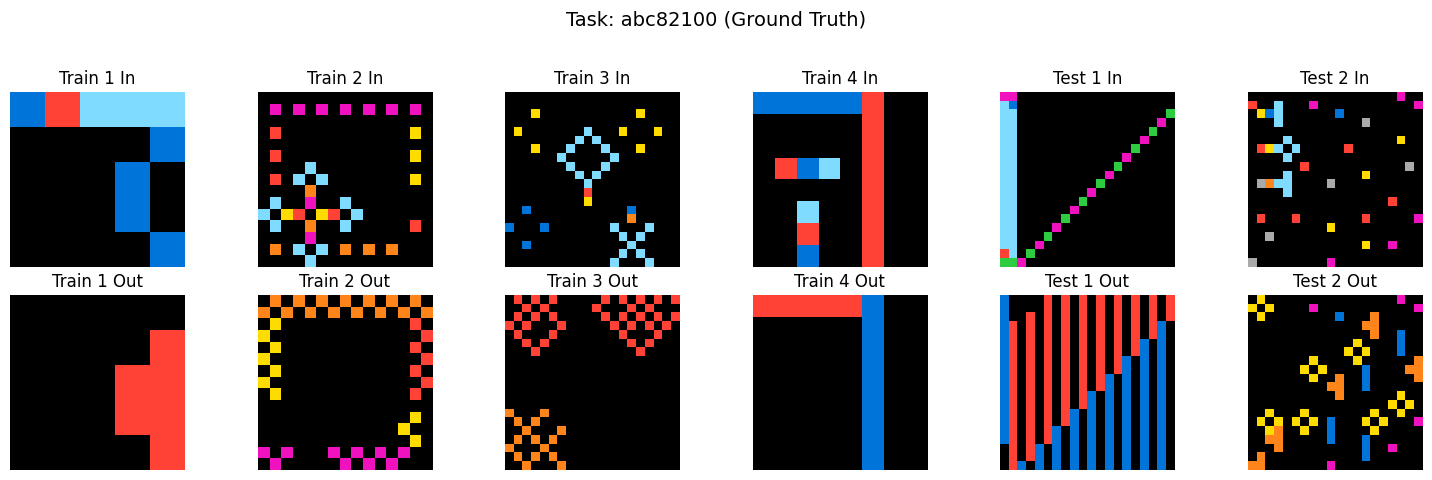


--- LLM Prediction Visualization (Task: abc82100 / Test: 0) ---


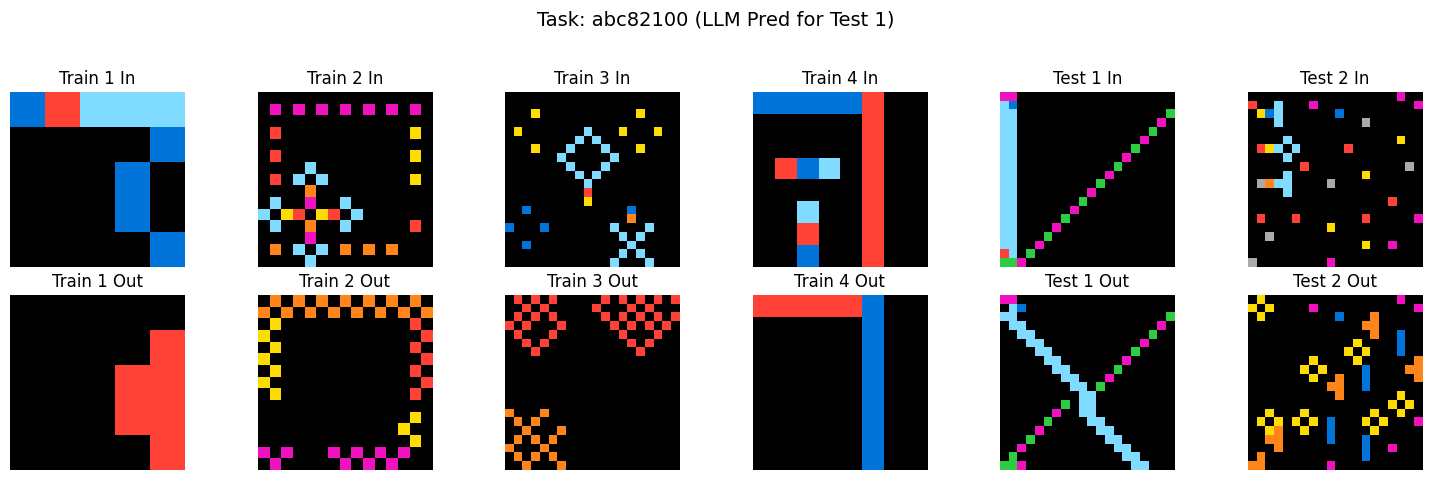

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: abc82100 / Test Case: 1 =====

--- Raw LLM Response ---
```
To determine the rule transformation from input to output, let's break down the transformation observed in the examples:

### Observed Patterns and Deductions:
1. **Diagonal Influence:**
   - In each example, the element located in a diagonal line across the grid determines the primary transformation.
   - Elements are converted to a new symmetrical diagonal pattern across the grid.

2. **Transformation Based on Symmetry:**
   - Elements that are specifically non-zero in the grid are shifted or manipulated to create a symmetrical pattern from left to right and top to bottom.
   - Observed transformations see numbers on a diagonal mirrored over the middle line of a grid.

3. **Value Replacement:**
   - Specific non-zero numbers are replaced with other numbers.
   - Elements like `8` seem to be ignored while others (e.g., `1`, `6`) determine the pattern c

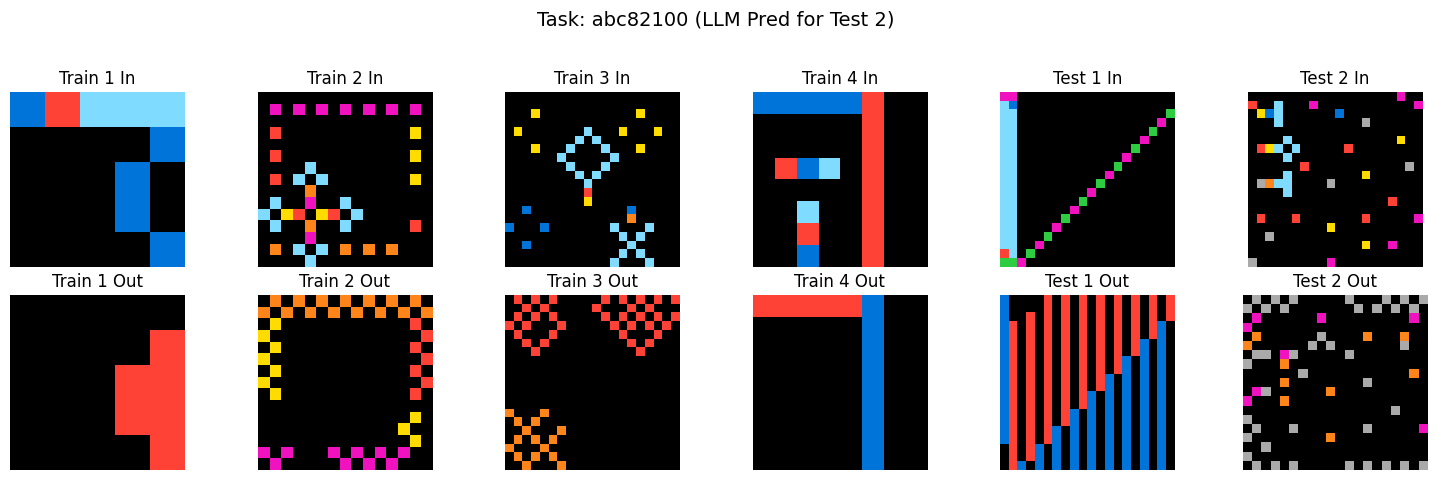

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((19, 20) vs (20, 20)))


===== Task: b0039139 / Test Case: 0 =====

--- Raw LLM Response ---
```
To address these ARC problem examples, we'll initially analyze the patterns presented in the train inputs and their corresponding solutions to deduce the necessary transformation rules.

**Observation of Train Examples:**

- Each input grid is subdivided into vertical columns containing patterns segmented horizontally.
- These segments or bands often have zeros that serve as spacers between patterns or elements.

1. **Example 1 Analysis:**
   Input:
   - It has different rows of numbers (0, 1, 2, 4, 9) interspersed with zeros.
   - There are bands of numbers: Three bands of '1', one band of '2', another band of '9'.
   - Other numerical patterns appear in the middle.

   Solution:
   - 5 rows with alternating patterns were derived: `2 2`, `2 9`, `9 9`, `2 2`, `2 9`.

2. **Example 2 to 4 Analysis:**
   - Each example presents distinc

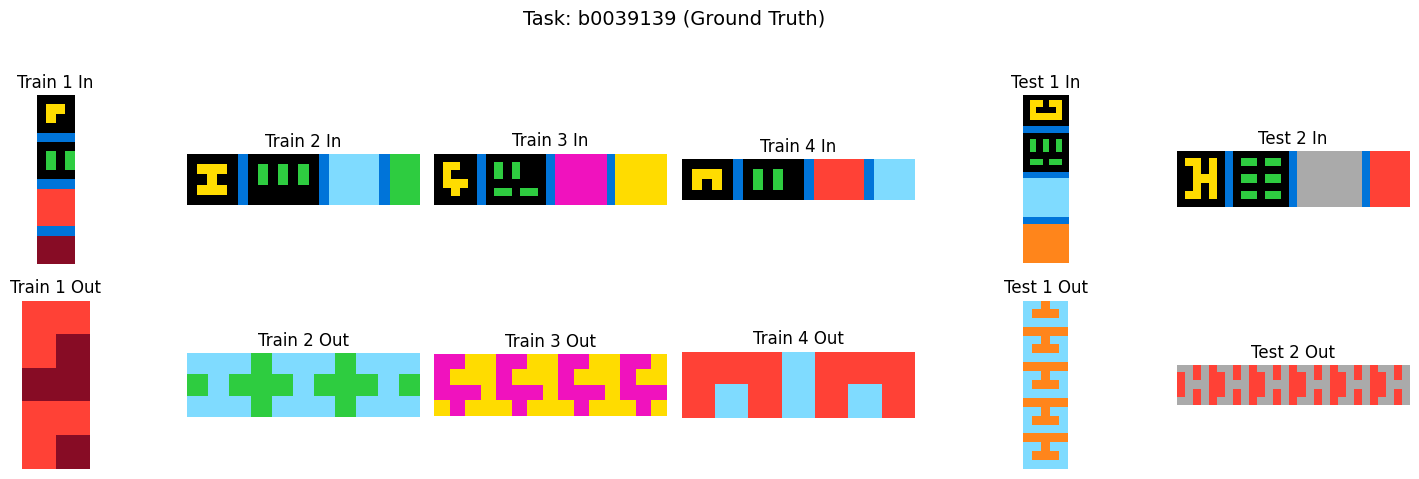


--- LLM Prediction Visualization (Task: b0039139 / Test: 0) ---


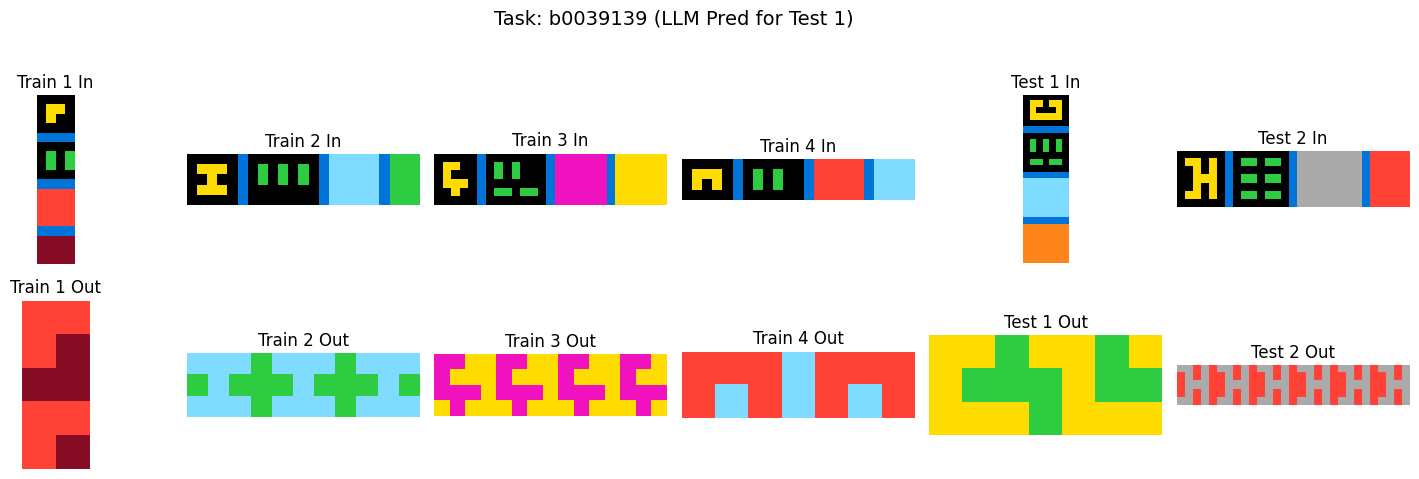

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((3, 7) vs (19, 5)))


===== Task: b0039139 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce transformation rules based on the given training examples. Let's analyze each example to identify a pattern or transformation rule:

1. **Example 1:** 
    - **Input:**
      ```
      0 0 0 0
      0 4 4 0
      0 4 0 0
      0 0 0 0
      1 1 1 1
      0 0 0 0
      0 3 0 3
      0 3 0 3
      0 0 0 0
      1 1 1 1
      2 2 2 2
      2 2 2 2
      2 2 2 2
      2 2 2 2
      1 1 1 1
      9 9 9 9
      9 9 9 9
      9 9 9 9
      ```
    - **Output:**
      ```
      2 2
      2 9
      9 9
      2 2
      2 9
      ```

    **Observation:**
    - Extract a 2x2 sub-grid from the input which seems to be composed by additions of certain numbers after the initial segment of zeros. The middle section of 4's got omitted.

2. **Example 2:**
    - **Input:**
      ```
      0 0 0 0 0 1 0 0 0 0 0 0 0

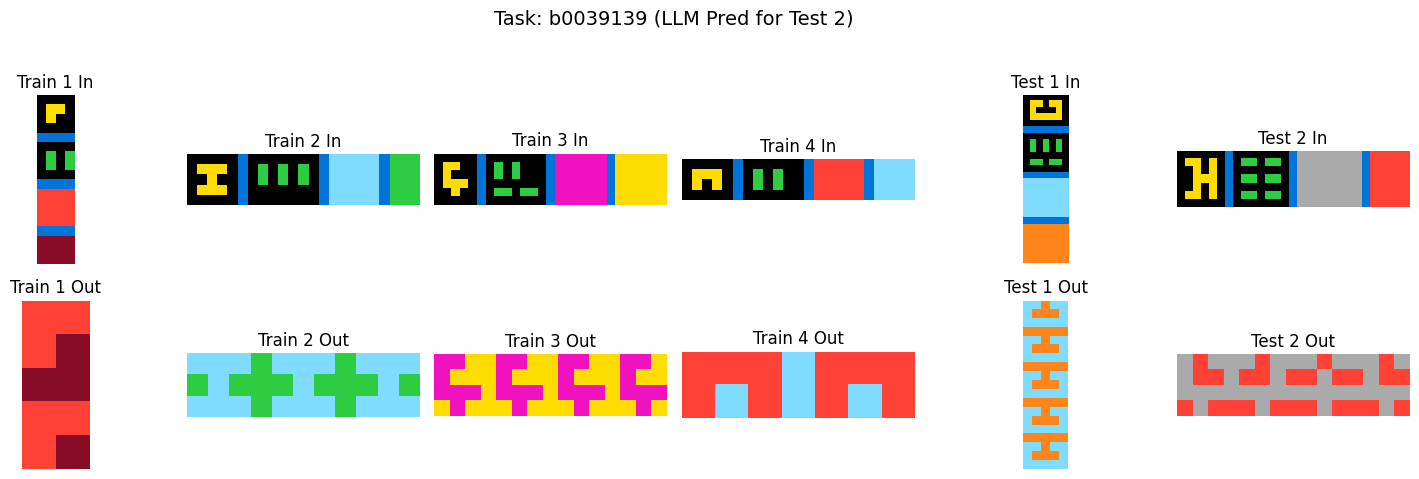

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((4, 15) vs (5, 29)))


===== Task: b10624e5 / Test Case: 0 =====

--- Raw LLM Response ---
```
To tackle the problem, we need to understand the pattern of transformation from the input grid to the output grid. After analyzing both examples, the following rules emerge:

**Rules:**

1. **Initial Configuration Recognition:** 
    - The grid mostly consists of the number '4', which can be considered as a background or inactive state.
    - There are special rows (the 14th row, counting from 0) that are entirely filled with '1'. These rows act as separators or constant structures and should remain unchanged after transformation.

2. **Identifying Active Segments:**
    - Identify rows that contain values other than '4' and '1'. In both examples, these values include '8', '2', '3', '9', etc.
    - These non-background values are present in certain sections, signaling that transformations should occur within these regions. A non-backg

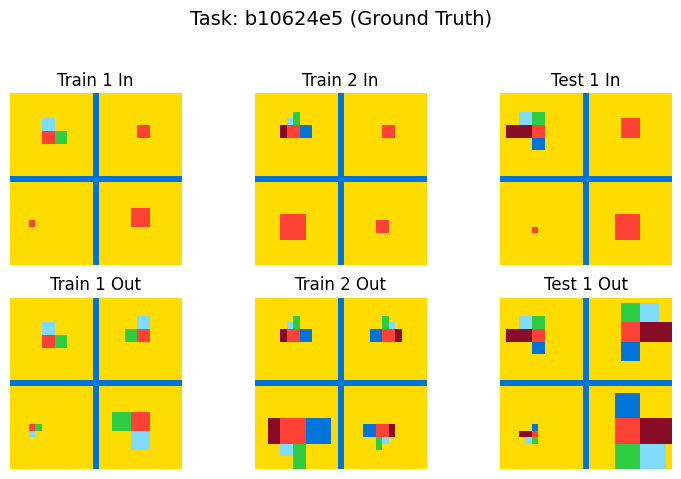


--- LLM Prediction Visualization (Task: b10624e5 / Test: 0) ---


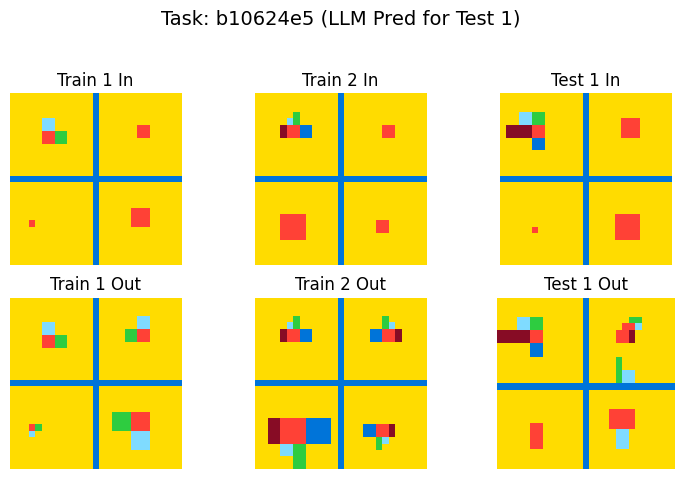

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((26, 27) vs (27, 27)))


===== Task: b5ca7ac4 / Test Case: 0 =====

--- Raw LLM Response ---
```
To tackle this problem, based on the given examples, we need to deduce a transformation rule that can be applied to the test input to produce the output as seen in the training examples.

**Identification of the Transformation Rule:**

1. **Identify Key Patterns or Shapes:**
   - Observing the examples, we see rectangular or square regions within the grid set apart by specific border number sequences (e.g., sequences of '2's or '8's).
   - These shapes are often split into multiple 'blocks' with a border. These blocks are surrounded by either homogeneous or gradually changing sequences of numbers.

2. **Processing Steps:**
   - **Transform Borders:**
     - Borders containing ’2’ are consistently used as separators within the structures.
   - **Update Background:**
     - Numbers like '8' appear prominently as backgrounds or borders

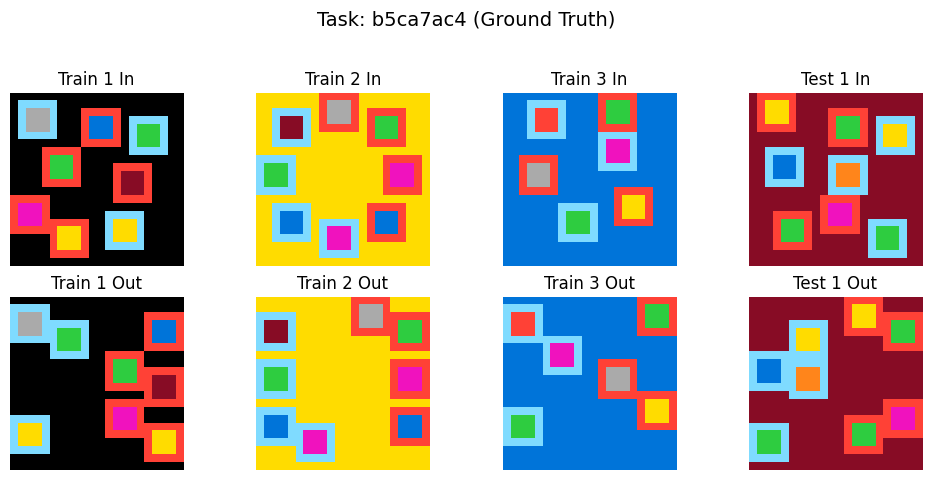


--- LLM Prediction Visualization (Task: b5ca7ac4 / Test: 0) ---


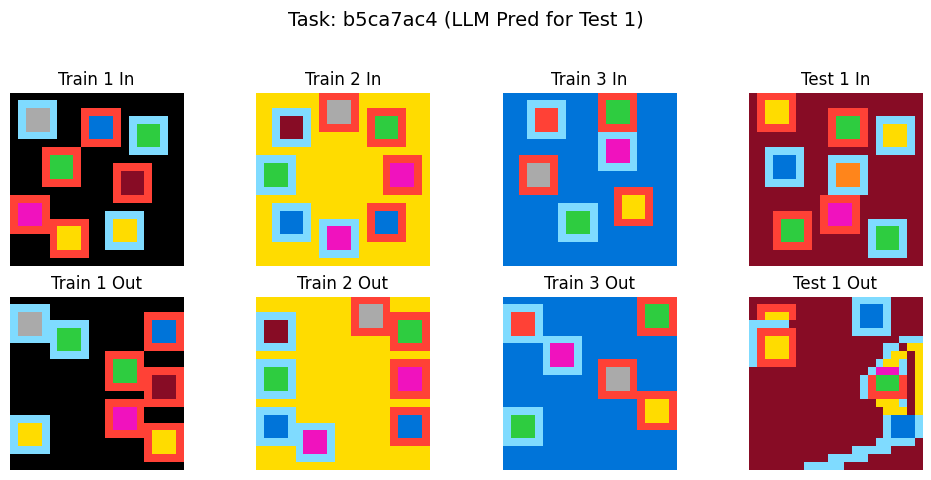

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: b6f77b65 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, let's analyze the transformations required to convert the provided inputs into their respective outputs. The objective is to determine a set of rules for transforming the input grids into the output grids.

### Deduced Rules:
Upon analysis, we discern the following transformations across all examples:

1. **Block Detection and Relocation**:
   - Identify filled sections (blocks of non-zero values) in the grid.
   - Relocate these blocks to new defined positions within the grid.

2. **Row Swap Transformations**:
   - Rows of blocks or patterns are moved (swapped) vertically within the grid space into fixed positions.

3. **Shift Empty Rows**:
   - Empty rows are moved to a section above the blocks and patterns detected, ensuring consolidation of sections.

To elucidate further:

- Example transformations often involve shifting block

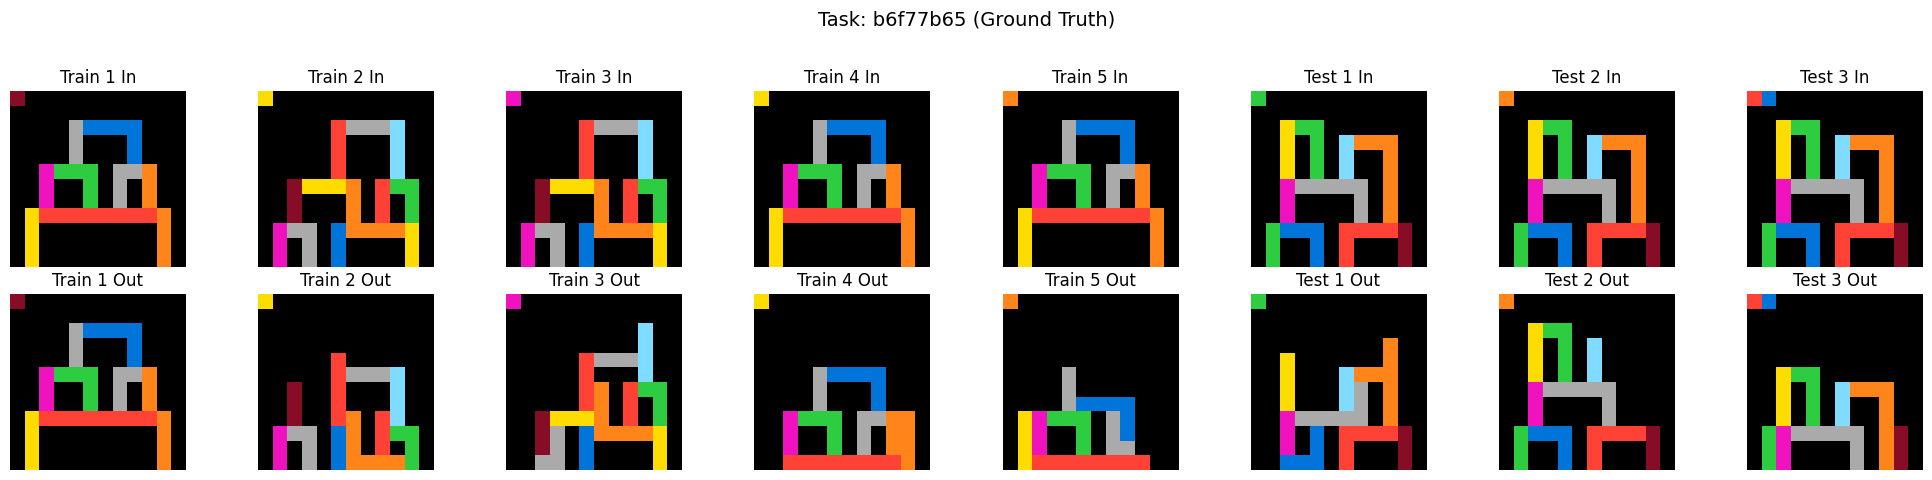


--- LLM Prediction (Task: b6f77b65 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: b6f77b65 / Test Case: 1 =====

--- Raw LLM Response ---
```
The task is to deduce a ruleset that transforms the input matrix (or grid) into the output matrix based on provided examples.

**Analyzing the provided examples:**

From the given examples, we need to search for consistent transformation rules between inputs and outputs:

1. **Initial Row Handling:**
   - Notice that the first row remains unchanged. This can be added as part of our transformation rules.

2. **Clearing Upper Part of Matrix:**
   - It appears that the first few rows are cleared (set to 0) until we encounter a row where the pattern occurs.
   - The "pattern" seems to be indicated by a block of numbers that align in columns from the bottom (this might involve zeros, but zeros can be part of the structure).

3. **Handling Rows at Pattern Found:**
   - From the row where the pattern part is, r

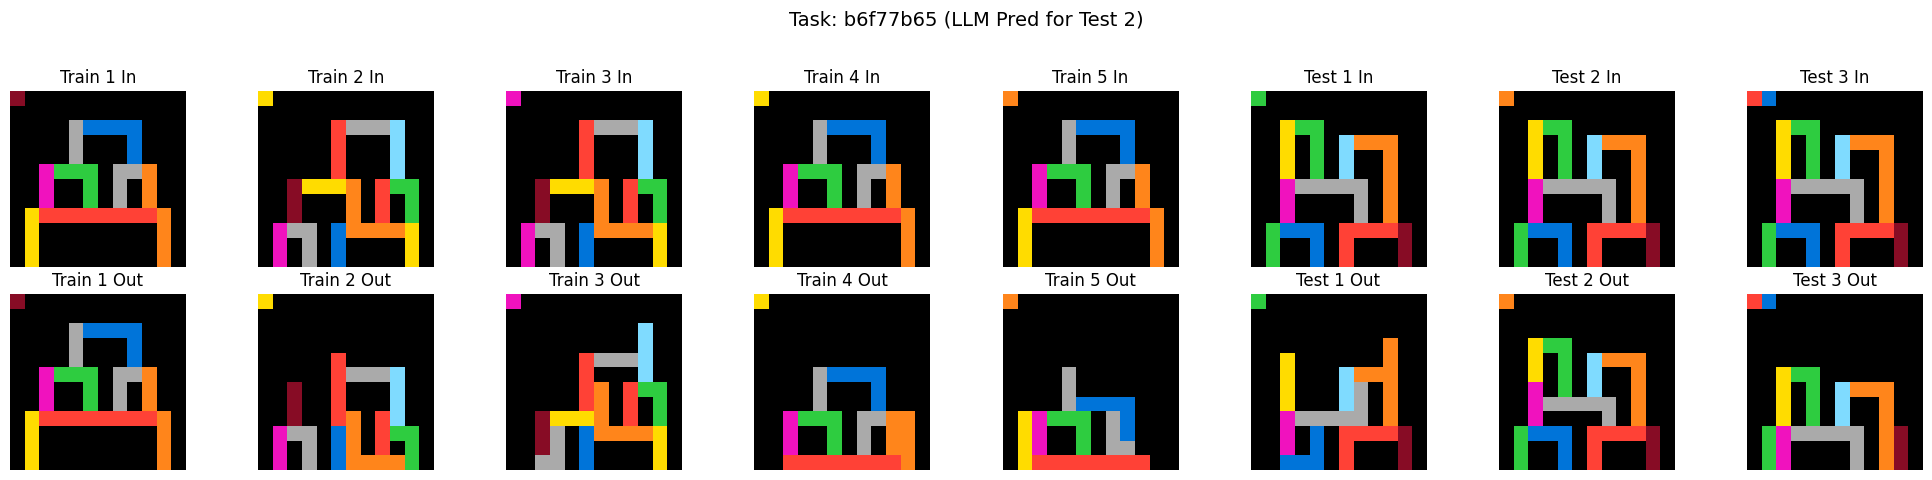

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: b6f77b65 / Test Case: 2 =====

--- Raw LLM Response ---
```
To deduce the transformation rules from the examples, let's analyze the defined examples step by step:

1. **Identify Key Changes**:
   - In each example, the positions of non-zero numbers remain largely the same, but certain rows appear to shift downwards or get eliminated.

2. **Check Pattern of Transformation**:
   - Upper part of the grids remains unchanged up to a certain point that seems to be variable across examples.
   - Some rows get deleted, and remaining rows below shift upwards.
   - Each example demonstrates that leftover numbers remain organized but shifted.

3. **Observations**:
   - In each scenario, 4 non-zero rows from the bottom persist.
   - Any rows above these 4 rows become entirely zeroed except the top row, and the first 2 or 3 rows are retained based on examples.
   - Removal appears structured: zeros overwrite or eliminate dat

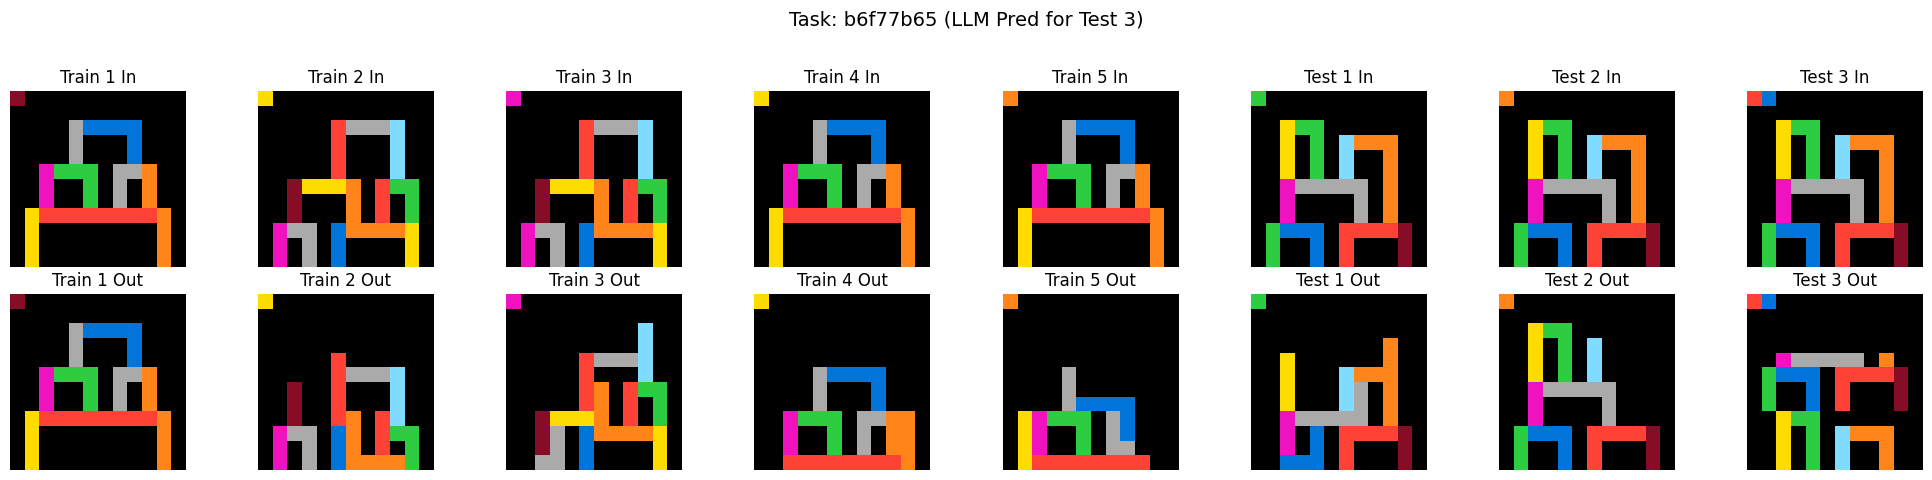

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: b99e7126 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules, let's analyze the examples given:

### Observation:
1. **Block Structure**:
   - Each grid is comprised of various blocks, repeated throughout the grid.
   - These blocks combine 3x3 regions alternating with a row of constant numbers (e.g., rows of 2s or 8s).
   - Every alternate row is a constant row (like a border or separator).

2. **Special Pattern Insertion**:
   - Specific regions within rows seem to be modified based on fixed positions.
   - These modifications are strictly on every 3x3 block where specific rows are entirely modified with a new pattern or numbers are changed within these blocks.

3. **Consistency**:
   - The regions that do not get altered remain consistent with their position in the block.

### Deduction of Transformation Rules:
1. **Identify Patterns**:
   - Each transformation involves speci

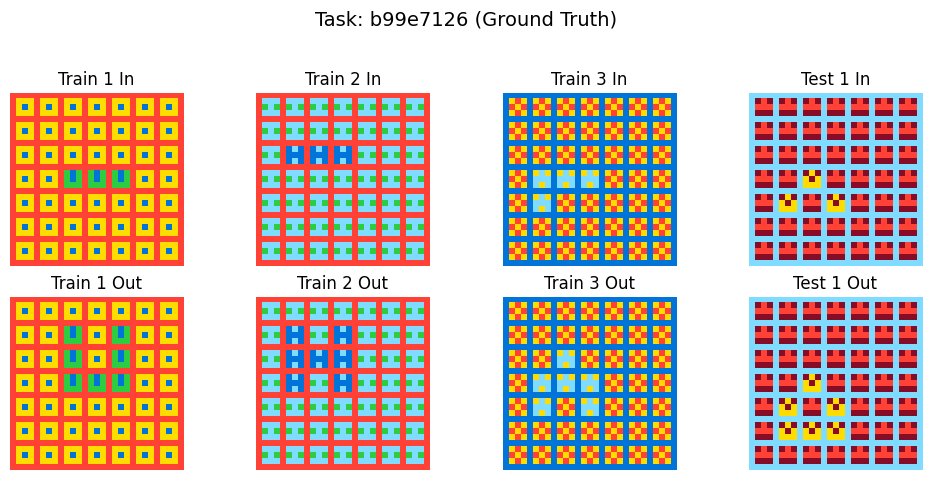


--- LLM Prediction (Task: b99e7126 / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: b9e38dc0 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we need to identify the transformations that are applied to the input grids to reach the output grids. Let's deduce the rules and verify them across the provided examples:

### Analyzing the Transformations:

1. **General Pattern Observed:**
    - We notice that a region defined by a specific number (like `3`, `9`, or `5`) gets expanded or duplicated somehow in the output.
    - The region of modification is not the whole grid but a specific region defined by non-background numbers.
    - There is a direct pattern between input regions with a distinct number and their transformation into the outputs.

2. **Specific Rule Deductions:**
    - Identify the regions of contiguous non-background numbers (like `3`, `9`, `5`) in the input grid.
    - Each identified region gets expanded or f

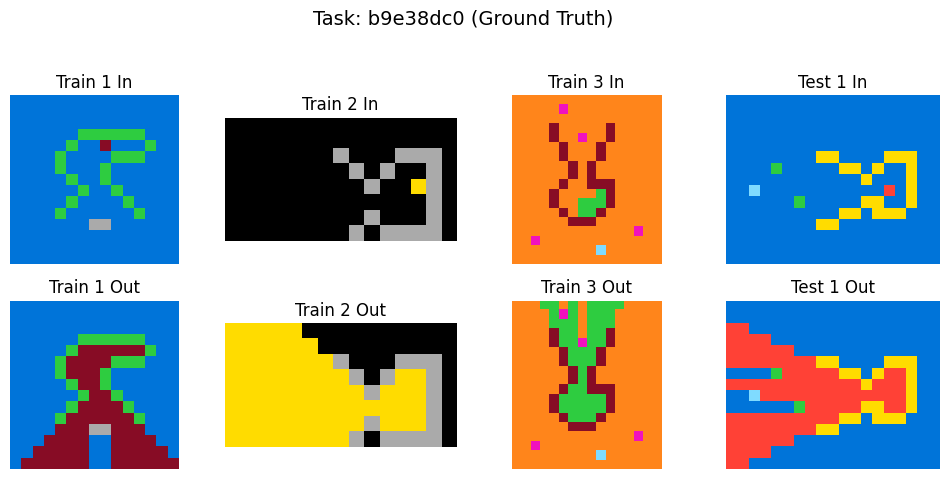


--- LLM Prediction Visualization (Task: b9e38dc0 / Test: 0) ---

Error during LLM prediction visualization for b9e38dc0, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.


===== Task: bf45cf4b / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, I will analyze the transformations applied to each example input grid to achieve the output grid. 

### Observations:
1. For every train example, the transformation extracts specific 3x3 subgrids that contain non-background numbers surrounded by background numbers. These extracted subgrids appear in the output as a new, smaller grid with these subgrids arranged in sequence, separated by background numbers.

2. The background number is apparent in each input example:
   - Example 1: Background number is 4.
   - Example 2: Background number is 3.
   - Example 3: Background number is 1.

3. The non-background

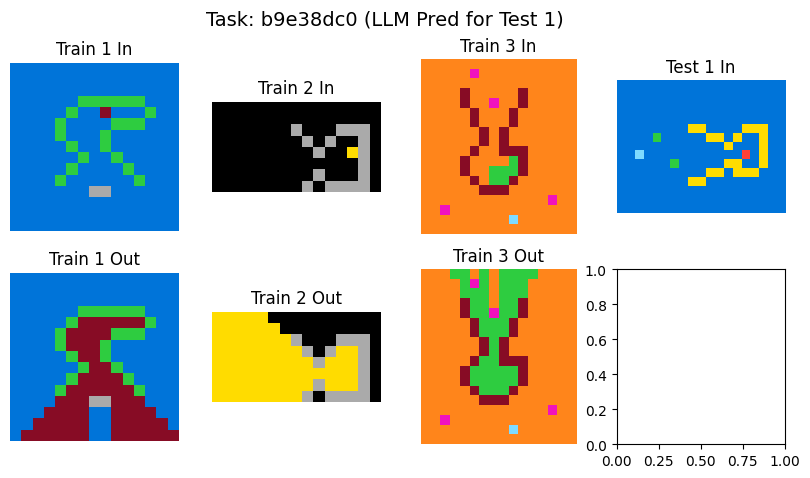

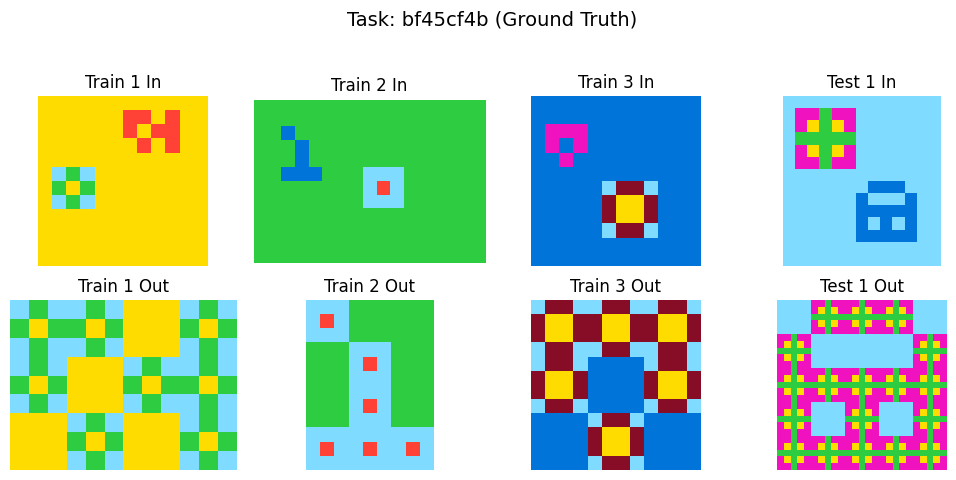


--- LLM Prediction Visualization (Task: bf45cf4b / Test: 0) ---

Error during LLM prediction visualization for bf45cf4b, test 0: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.


===== Task: c4d067a0 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's analyze the pattern and determine the rules applied in the given examples.

**Observations from the Training Data:**

1. The grid consists of rows of numbers, predominantly one number (like 8 or 1) with other numbers breaking this continuity.

2. Observing each example, there's a noticeable pattern: Locations with a different number (compared to its row majority) tend to have colored blocks appearing in rows either below or above them.

3. These patterns seem to repeat three times vertically - meaning if a color appears in one row with three occurrences vertically, all three are filled.

4. The transf

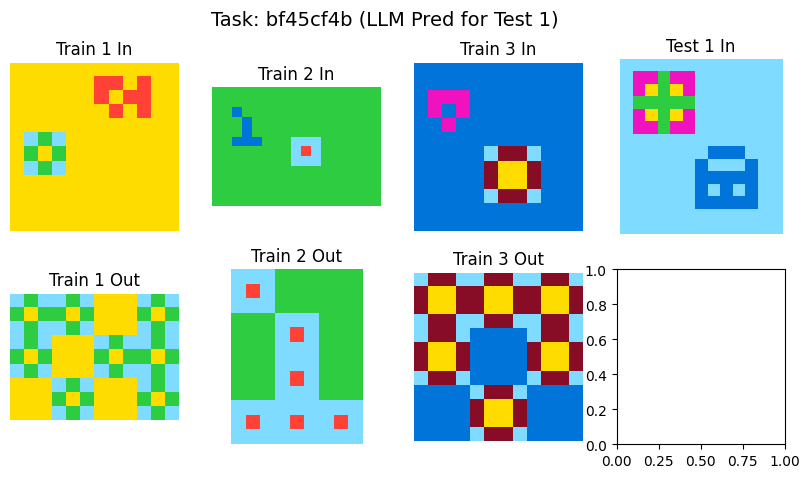

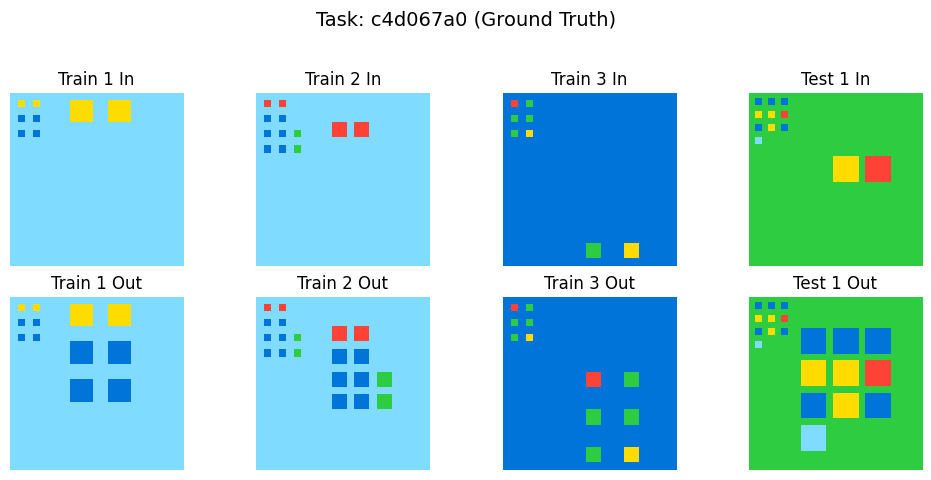


--- LLM Prediction Visualization (Task: c4d067a0 / Test: 0) ---


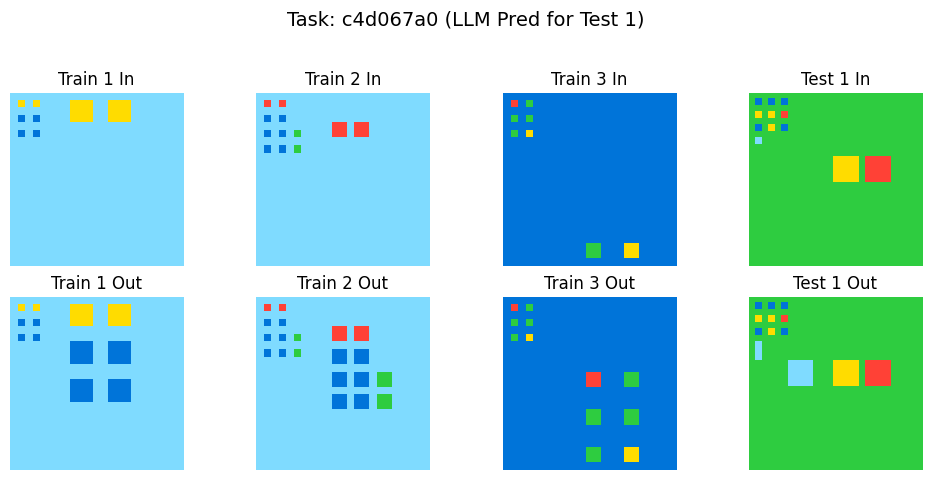

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: c7f57c3e / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this task, we need to extract common transformations that convert the given input grids into their respective solution grids based on the provided examples.

### Observations:

1. **Patterns and Structures:**
   - Both examples involve shifting certain numerical patterns within sub-regions of the grid.
   - Specifically, blocks of numbers are being moved or transformed to different locations within the grid.

2. **Example 1 and Example 2 Analysis:**
   - In Example 1, numbers "8" and "2" are replaced and/or moved.
   - In Example 2, similar behavior is applied, with numbers "6" being added at specific locations, while maintaining other numbers' positions.

3. **Transformation Rules Derived:**

   - Identify rows with non-background numbers (where the background is the most repeated number on each row).
   - Shift specific number clusters (block

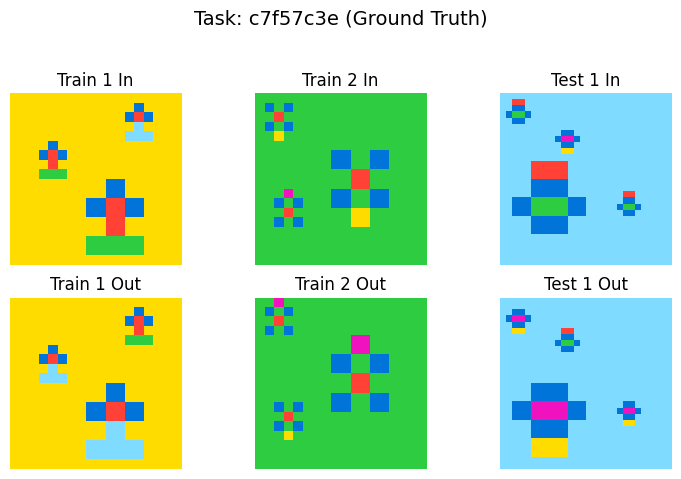


--- LLM Prediction Visualization (Task: c7f57c3e / Test: 0) ---


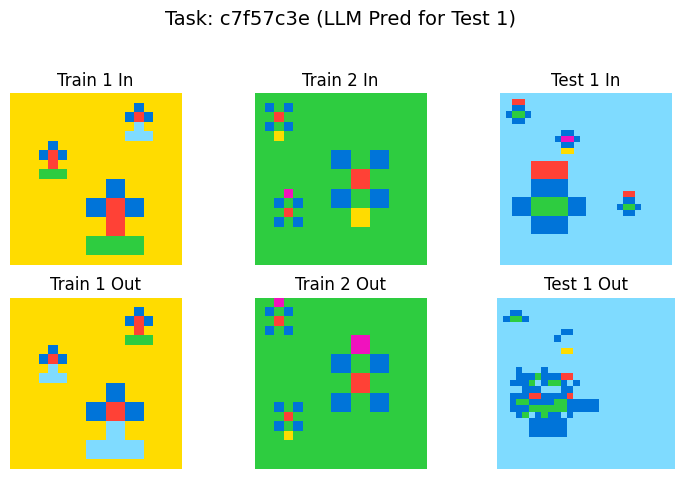

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((27, 28) vs (28, 28)))


===== Task: cb2d8a2c / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, let's analyze the transformations applied to the example grids. The key transformations observed for each input and solution are described below:

1. **Propagation of "3":** The value "3", when encountered within the grid, needs to be extended vertically and/or horizontally into non-"8" cell areas. The propagation of "3" is halted by encountering other values like "1" or "2".  

2. **Connection of Segments:** When "1" and "2" are found forming a significant cluster or pattern, certain rows or columns need to be connected by filling blocks of "3".

**Deduced Rules:**

- Traverse each row to locate the number "3". When found, propagate "3" to the nearest adjacent part of the grid stopping at non-8s.
- In instances where clusters or sequences of "1" and "2" values occur, replace those intermediate segments with "3

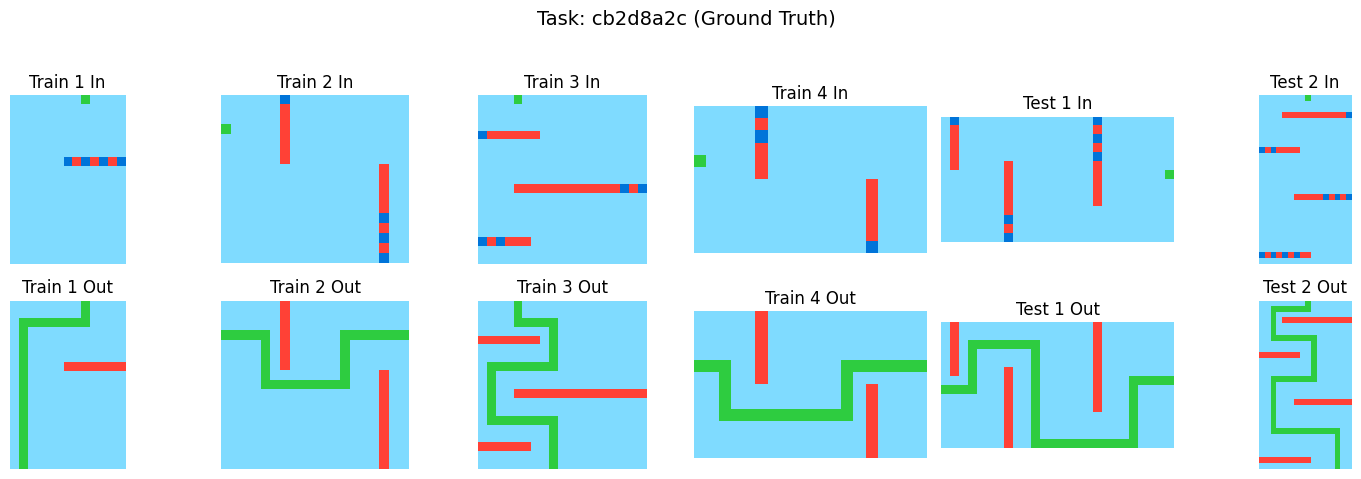


--- LLM Prediction (Task: cb2d8a2c / Test: 0) ---
Failed to produce visualizable grid. Reason: Parsing Failed


===== Task: cb2d8a2c / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we first need to identify the transformation rules from the given input to produce the output. Analyzing the provided train examples, a few patterns can be observed:

1. **Identifying Row with Start and End Points:**
   - Each example has one or more rows where a `3` or a sequence of `1`s or `2`s is located. Typically, these rows contain significant horizontal sequences or a series that extends in rows/columns.

2. **Transformation of Start and End Identifiers into a Bounding Path:**
   - The topmost `3` in a row or column becomes a vertical or horizontal line of `3`s in the output, forming paths.
   - If other sequences like `1`s or `2`s are encountered, they remain as sequences but can participate in forming boundary paths.

3. **Surrounding the Main Path:**
   - The topmost `3` 

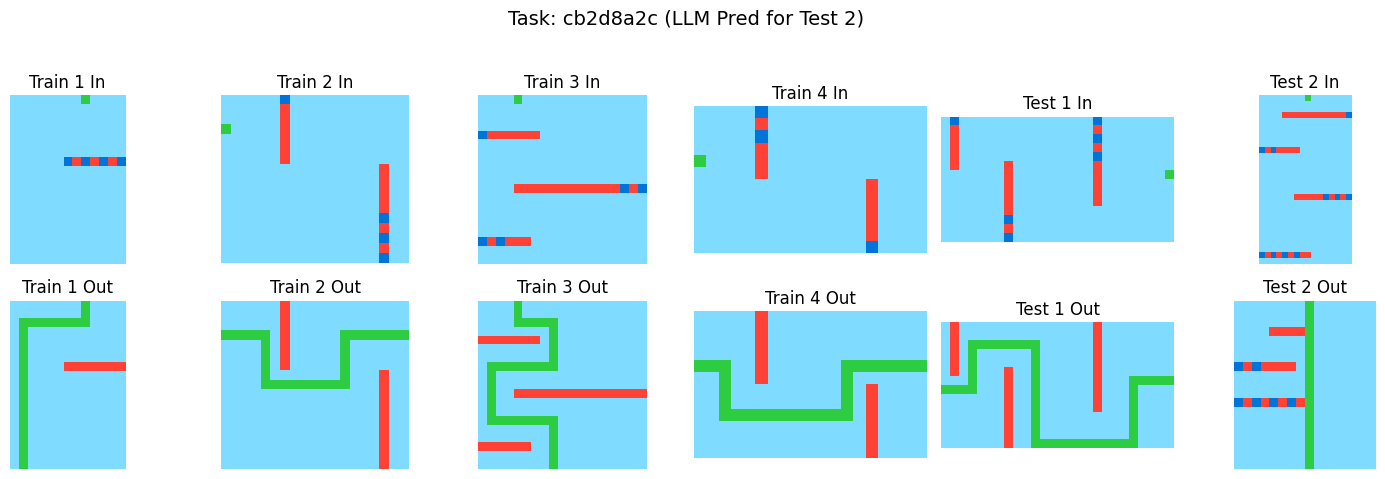

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((19, 16) vs (29, 16)))


===== Task: cbebaa4b / Test Case: 0 =====

--- Raw LLM Response ---
```
**Analyzing the Train Examples:**

First, let's analyze the provided train examples to deduce the transformation rules.

1. **Example 1 Analysis:**
   - All numbers other than `0` in the input grid remain unchanged.
   - The position of objects drawn by non-zero numbers has been adjusted. Some objects have been relocated, and certain clusters of numbers appear to have moved diagonally or been repositioned within the grid.

2. **Example 2 Analysis:**
   - Similar to example 1, all non-zero numbers remain unchanged.
   - The position of objects described by each group of numbers has shifted.

**Identified Rules:**

- **Movement Pattern:**
  - In both examples, clusters or blocks of non-zero numbers are moved vertically and/or horizontally without changing their form or the number values.
  - The transformation involves moving certain 

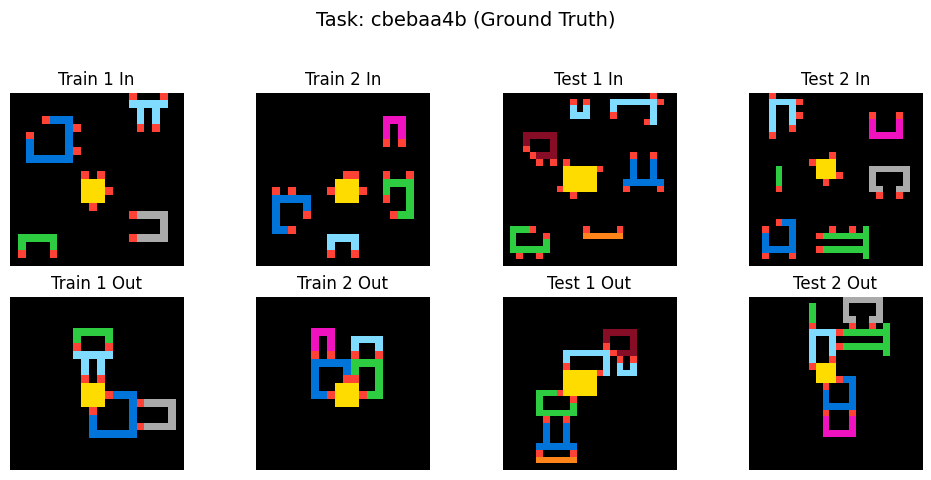


--- LLM Prediction Visualization (Task: cbebaa4b / Test: 0) ---


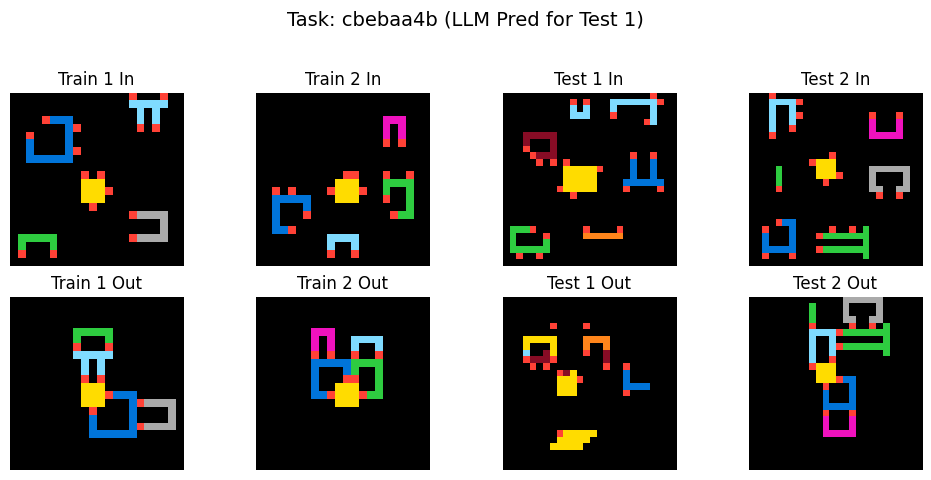

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: cbebaa4b / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this task, we need to deduce a pattern or rule based on the provided train examples and apply the same transformation to the test input. Here's a detailed breakdown of the approach:

### Observations:
Upon examining the train examples and their respective solutions:
1. The solution involves rearranging specific parts (clusters) of the input grid rather than altering individual elements.
2. Clusters of the same non-zero numbers (e.g., 2, 3, 4, 5, 6, 8) are preserved, but their positions can change between input and output grids.
3. Specifically, clusters may "swap" places—those located in the lower part of the grid are often moved to the upper part, and vice versa.

### Deduction of Rules:
1. **Identify clusters**: Clusters are defined as connected components of the same number. The connectivity is vertical or horizontal (not diagonal).
2. **Swa

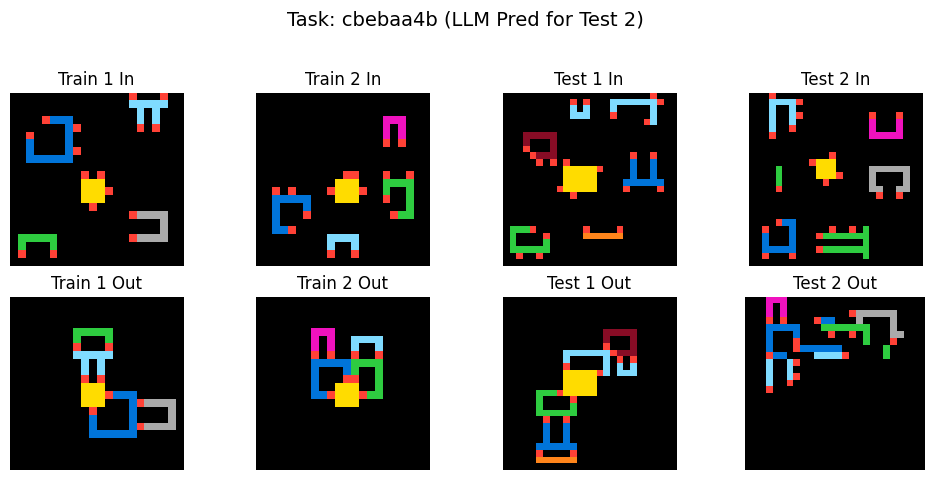

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((25, 26) vs (26, 26)))


===== Task: d35bdbdc / Test Case: 0 =====

--- Raw LLM Response ---
```
To tackle the problem and deduce the rules from the provided train examples, let's manually analyze each step from the input to the output.

### Analysis and Rules Deduction:
1. **Identifying Patterns:**
   - For each example, the transformation maintains a certain pattern where some specific sections of the input grid remain the same, some sections are converted entirely to zeroes, and some numbers within specific sections are changed to other numbers.

2. **Common Observations Across Examples:**
   - Sections that have predominantly zero values in the input end up retaining those zeroes in the output.
   - Non-zero values deep within clusters often become zeroes in the output. The zeros appear to expand filling these clusters.
   - Some numbers replace other numbers or remain in specific parts of the arrays.
   - Row or column str

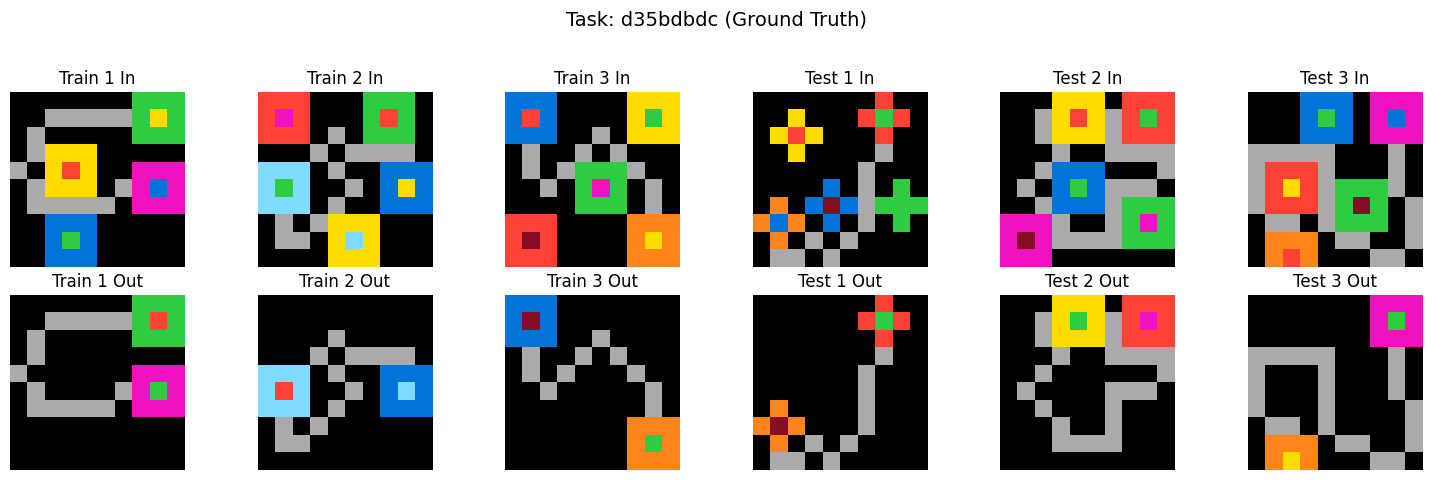


--- LLM Prediction Visualization (Task: d35bdbdc / Test: 0) ---


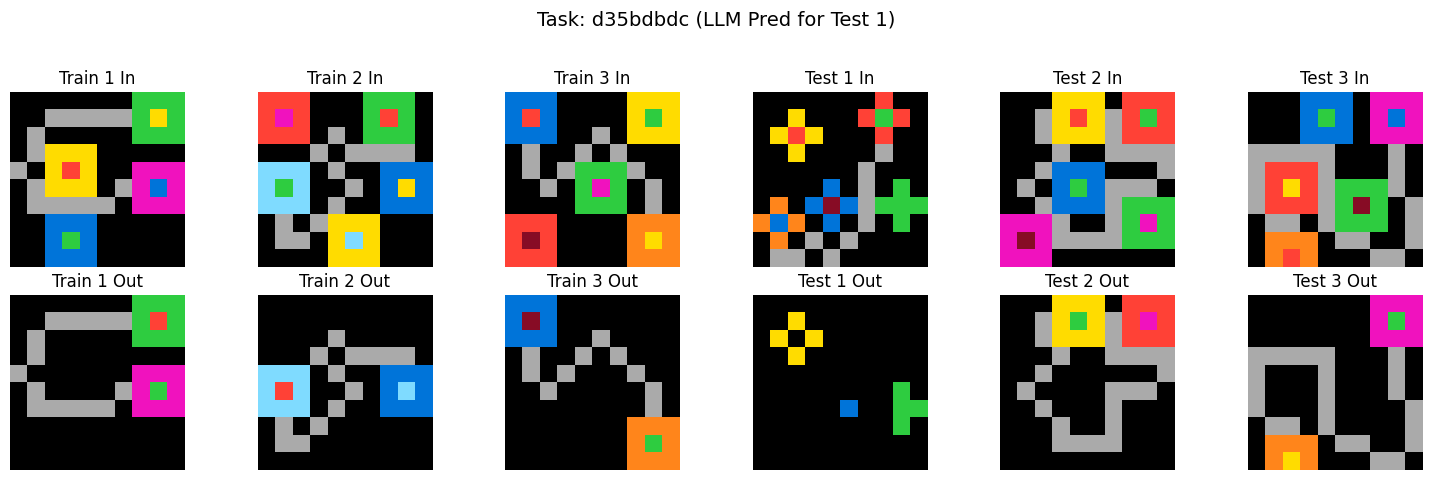

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: d35bdbdc / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem, let's observe each of the transformations performed on the input grids to derive the solutions. Upon analysis from the given examples, the key steps for transformation are as follows:

1. **Zerofication**: For each row, starting from the leftmost non-zero elements, continue converting elements to 0, row-wise. This process stops once an entire row (or any continuous segment among consecutive non-zero rows) or significant portion of major non-zero numbers has been made zero.
   
2. **Selective Transformation**: In specific places, numbers of certain values seem to change to others, possibly involving the largest number in certain rows or columns. For instance, in Example 3, the '9' is moved right on line 8 up to a number '2'.

3. **Area Preservation**: Non-zero blocks in certain regions, such as along diagonals or special patterns, r

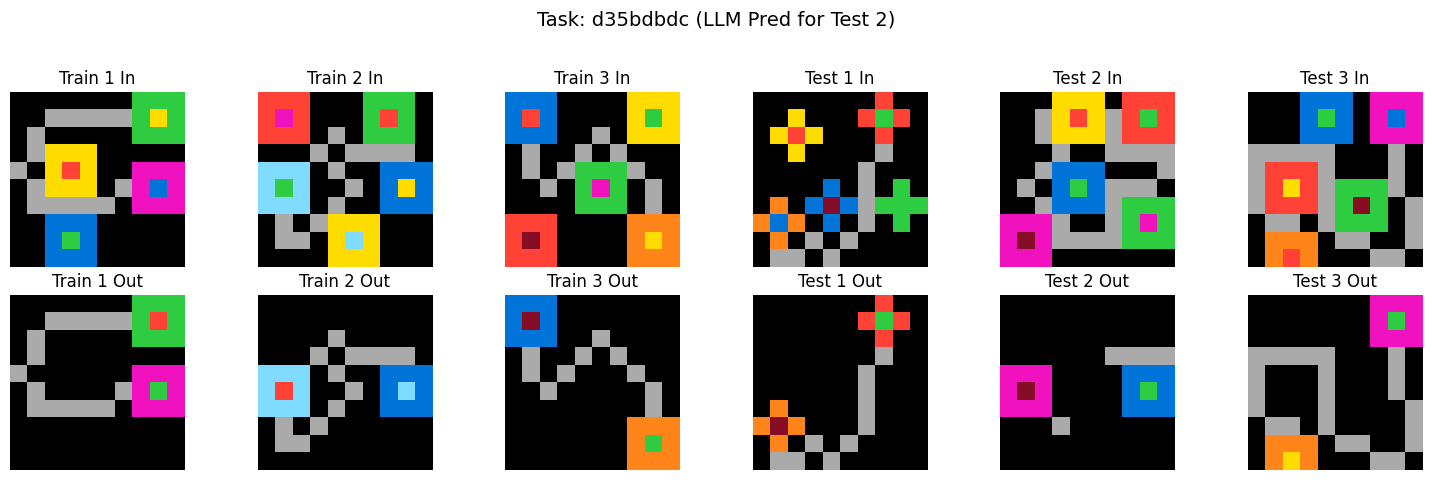

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: d35bdbdc / Test Case: 2 =====

--- Raw LLM Response ---
```
Based on the provided examples, the transformation process can be deduced as follows:

1. Identify groups in the grid:
   - Locate regions in the grid that are surrounded or bordered by zeros. These regions are commonly identifiable patterns like blocks of repeating numbers or patterns seen across the input grids.

2. Perform transformations on detected regions:
   - **Remove specific rows or columns based on patterns**: In most examples, the first few rows and/or a particular column (often bordering or through the center) have been transformed to zero.
   - Replace numbers in rows or sections of the grid with zeros primarily towards the top portions of the grid.
   - **Alter specific numbers in the grid**: Modifications are made to selectively replace or zero out certain cells within these groupings, especially those occupying the border rows and colum

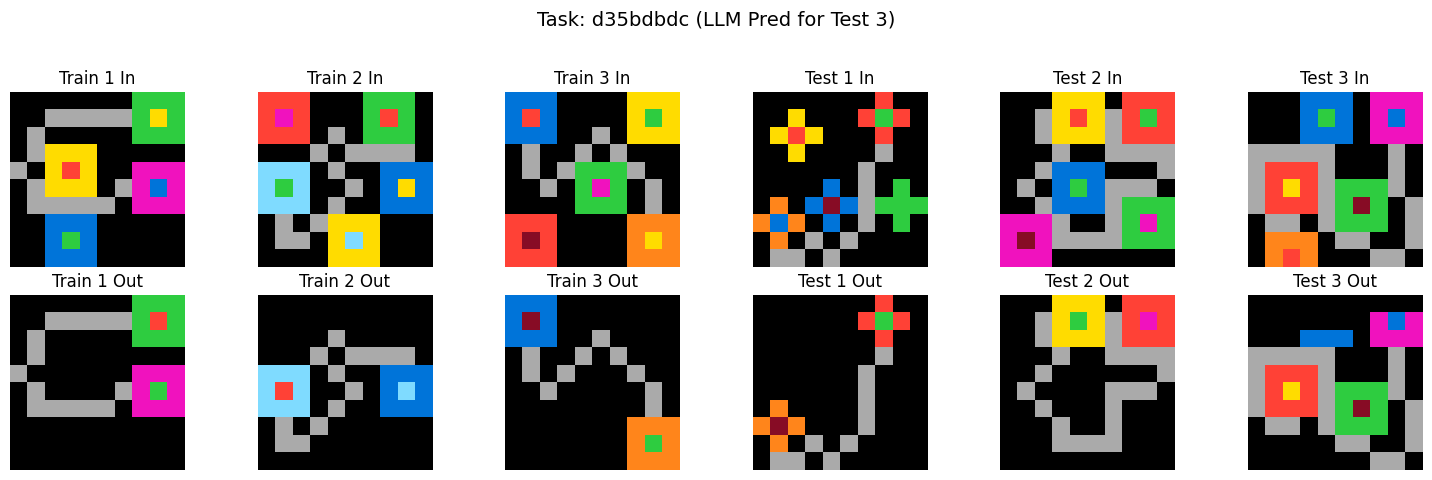

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: d59b0160 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this transformation task, we need to deduce the rules that apply to the input grids to generate the corresponding output grids. Let's analyze the provided examples to determine the transformation rules:

### Rule Identification

1. **Preserve Border `7`s:**
   - All grid borders (top, bottom, and side rows or columns) filled with the value `7` remain unchanged in the output. This means there's a frame of `7`s that stays intact around the entire border of the grid.

2. **Transform Inner Values to `7`:**
   - Any non-border elements can potentially turn into a `7` in the output if they are surrounded completely by `7`s. Any `7` in these positions remain `7`, and if non-`7` elements are fully surrounded by `7`s, they turn into `7`s.

3. **Preservation of Non-Zero Values Outside the Surrounded Context:**
   - If a non-border element (non-`7`) is no

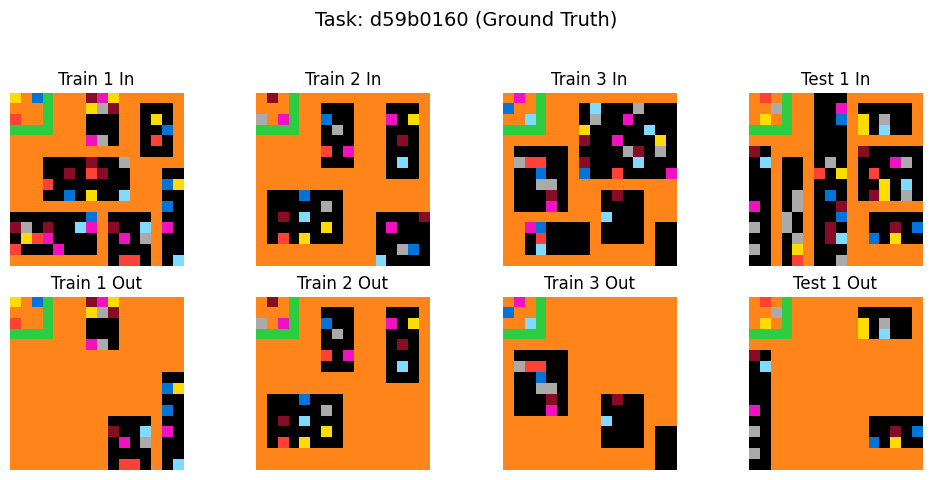


--- LLM Prediction Visualization (Task: d59b0160 / Test: 0) ---


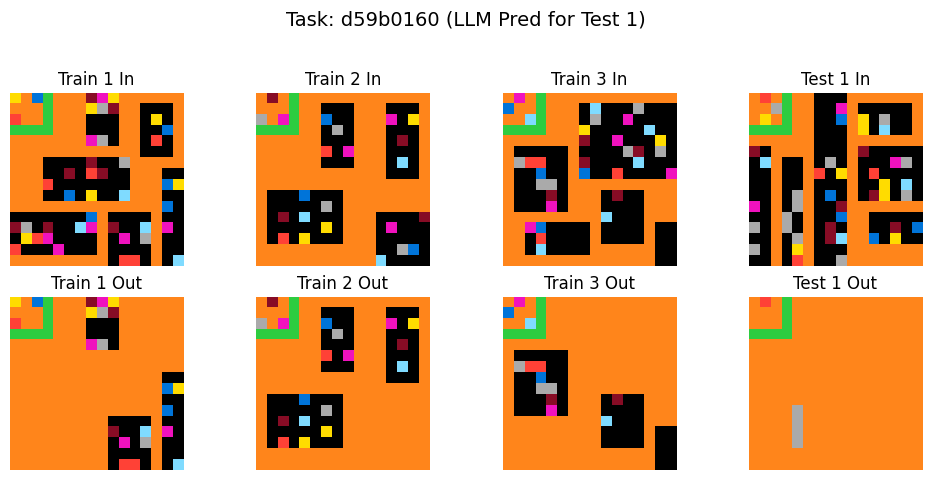

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: d8e07eb2 / Test Case: 0 =====

--- Raw LLM Response ---
```
To deduce the transformation rules, let's analyze the given examples thoroughly. The structure of the inputs and the solutions has noticeable patterns. Here's how we can summarize the transformations: 

1. Find the horizontal bands of solid numbers surrounded by the number 8 and transform the entire band to a fixed number, specifically 3, in all rows except the bottom row band, which transforms into 2.

2. For the pattern transformation:
   - Identify blocks where rows have identical non-8 numbers.
   - Change outmost layer non-8, non-zero numbers, each bordered by 8s or zeros, to 3.

3. Numbers which do not form a contiguous band surrounded by 8s or zeros, like isolated 7s, 9s, and other numbers, stay the same.

Combining these observations provides the transformation logic:

- Identify rows that contain numbers enclosed by 8 on both sides, except bott

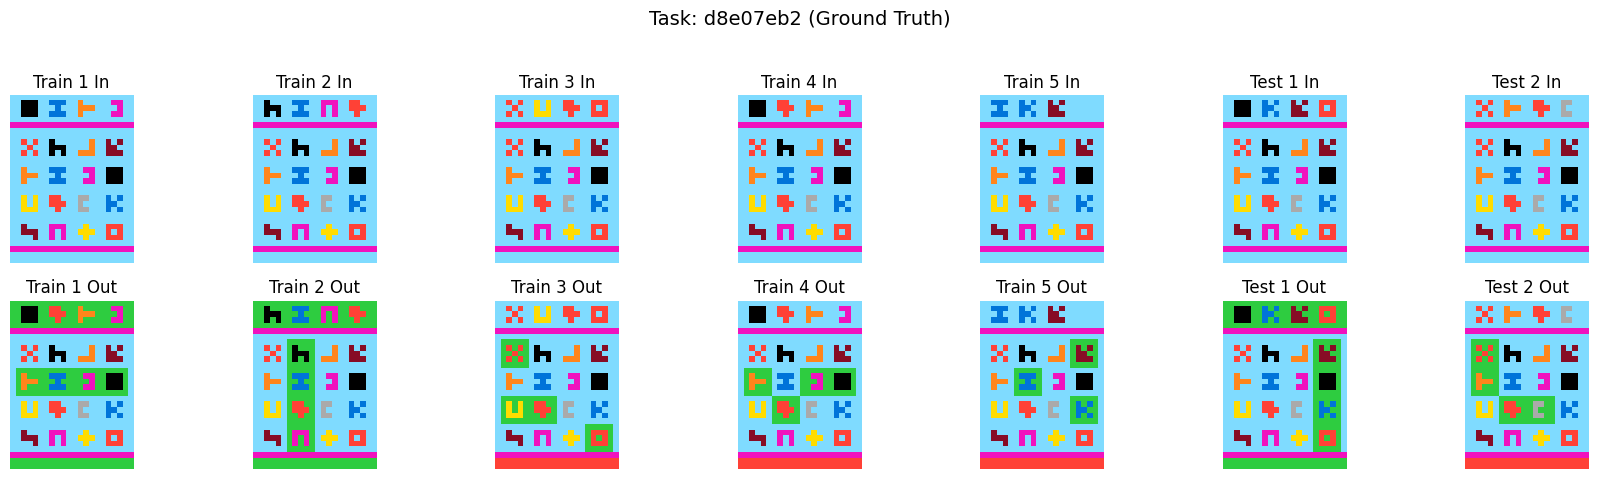


--- LLM Prediction Visualization (Task: d8e07eb2 / Test: 0) ---


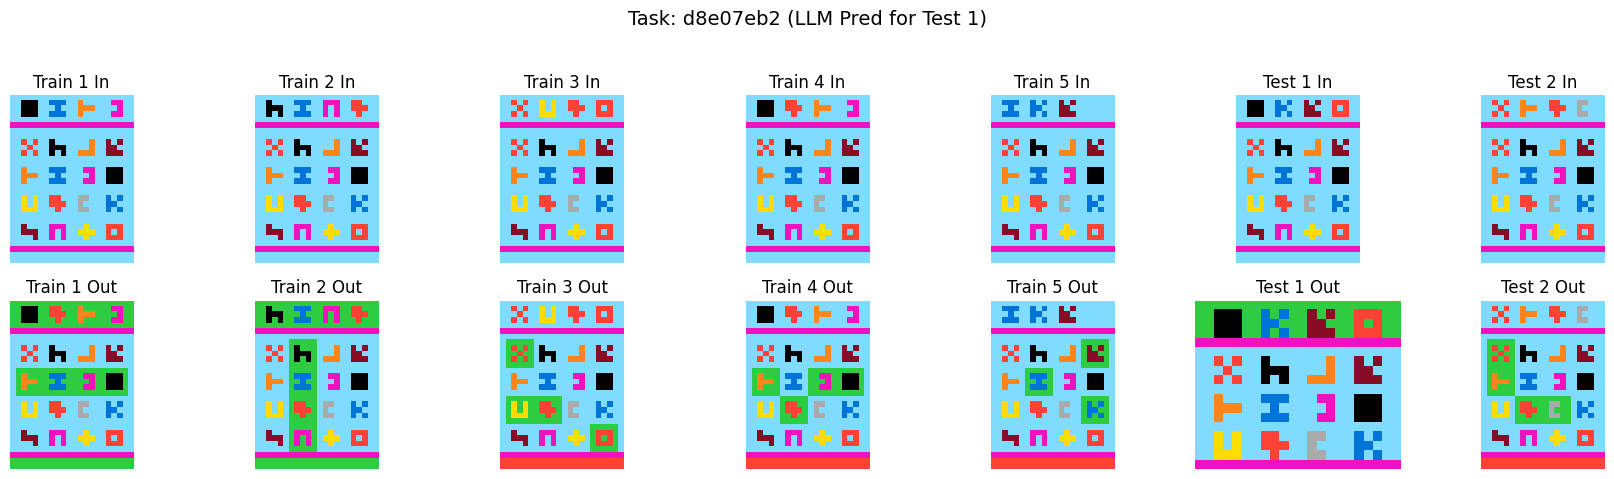

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((18, 22) vs (30, 22)))


===== Task: d8e07eb2 / Test Case: 1 =====

--- Raw LLM Response ---
```
To deduce the transformation rules from the input examples to the solutions, let's look at common structural changes happening in each example:

### Rules Deduction

1. **Horizontal Borders**: 
   - The top and bottom borders of the grid in the solution are rows filled with the number `3`.
   - If they don't already use `3`, replace their current content with `3`.

2. **Vertical Borders**:
   - The leftmost and rightmost columns in between the top and bottom borders should also be filled with `3`.

3. **Detect and Transform Inner Patterns**:
   - Identify blocks of numbers that span across rows. These blocks seem to remain the same in the solution, except they do not interfere with the vertical and horizontal border transformations.
   - For example, sequences of repeating numbers (e.g. `0 0 0`, `1 1 1`, `2 2 2`, etc.) remain unchan

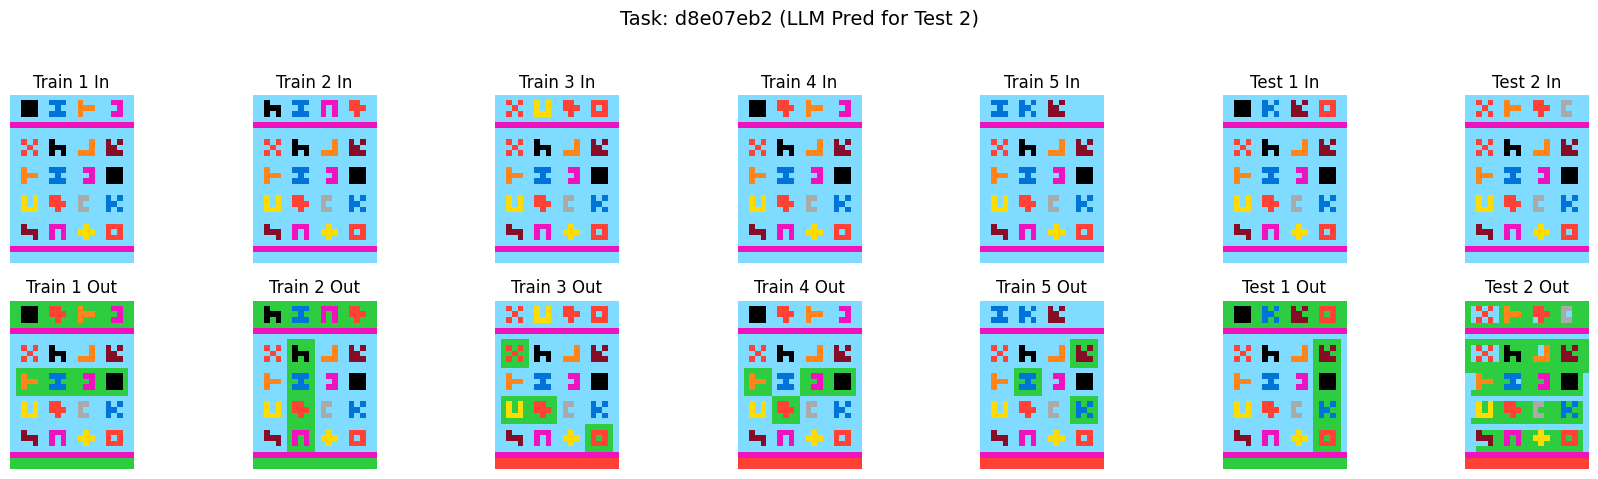

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: da515329 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the problem, we need to apply certain transformation rules derived from the observed patterns present in the train examples. After analyzing the examples, here are the steps to determine the transformation:

### Rule Deduction:

1. **Identify the positioning of '8':**
   - The input grids have specific locations with the number '8'.
   - These '8's are arranged in vertical walls, often with an aligned pattern forming vertical bars.

2. **Transformation of Input to Output:**
   - The '8's in the input suggest start points for walls/boundaries in the grid.
   - In the resulting output, these walls extend and wrap around the grid using '8's to create new patterns:
     - The transformation follows certain fixed patterns observed across all training examples, including the addition of horizontal and vertical lines extending from the original vertic

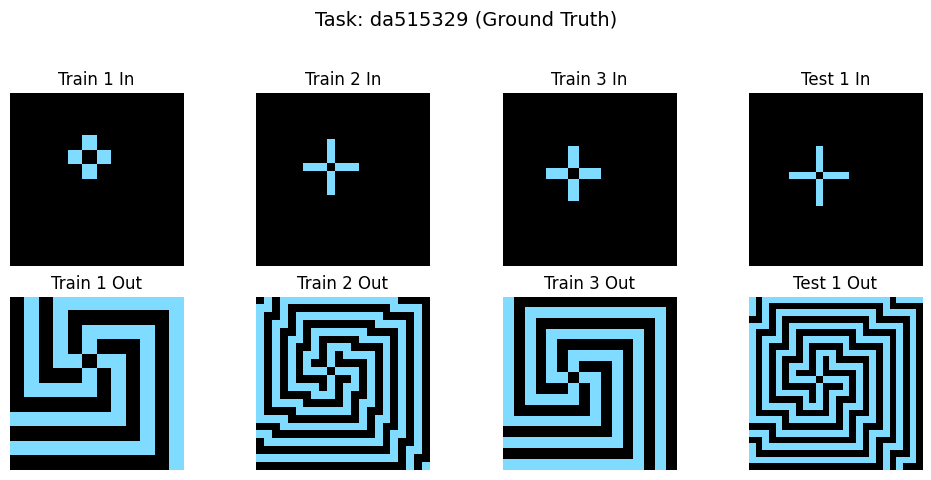


--- LLM Prediction Visualization (Task: da515329 / Test: 0) ---


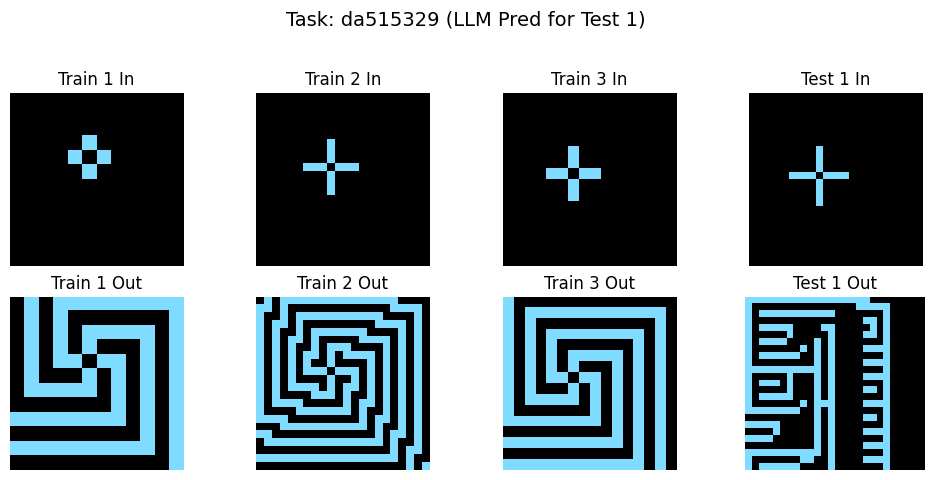

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((25, 26) vs (26, 26)))


===== Task: db0c5428 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this transformation problem, we need to recognize the pattern or rules applied to convert the input grid into the output grid. 

### Observed Rules:

1. **Extract Subgrid:**
   - Each example involves identifying a non-8 subgrid from the input grid. This subgrid has the potential to be rotated, reflected, or modified in some other consistent way. The subgrid is recognizable because it has non-8 elements and is often centrally located within the grid.
  
2. **Identify and Alter:**
   - The subgrid is often rotated in a specific manner or manipulated such that additional rows or columns containing certain patterns of the subgrid are added or adjusted in a consistent way.
   
3. **Pattern Creation or Replication:**
   - The solution involves replicating certain rows or elements of the subgrid in a manner that follows a nested 

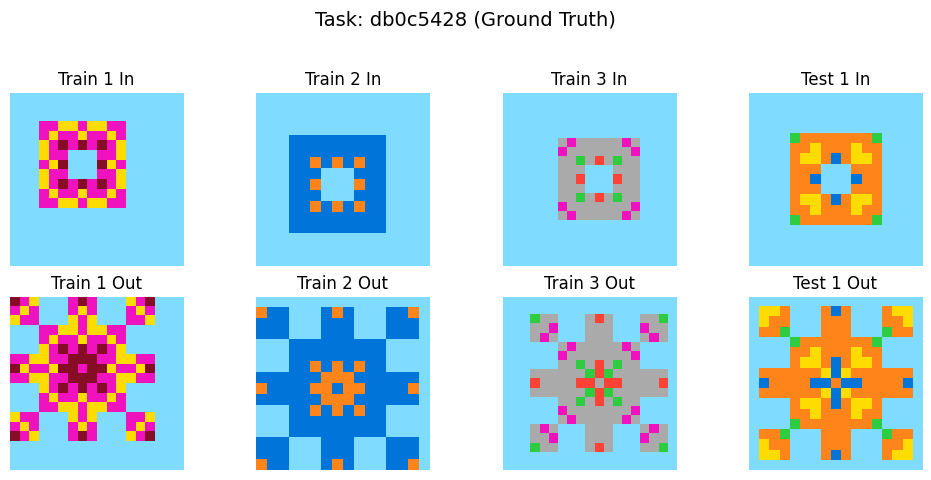


--- LLM Prediction Visualization (Task: db0c5428 / Test: 0) ---


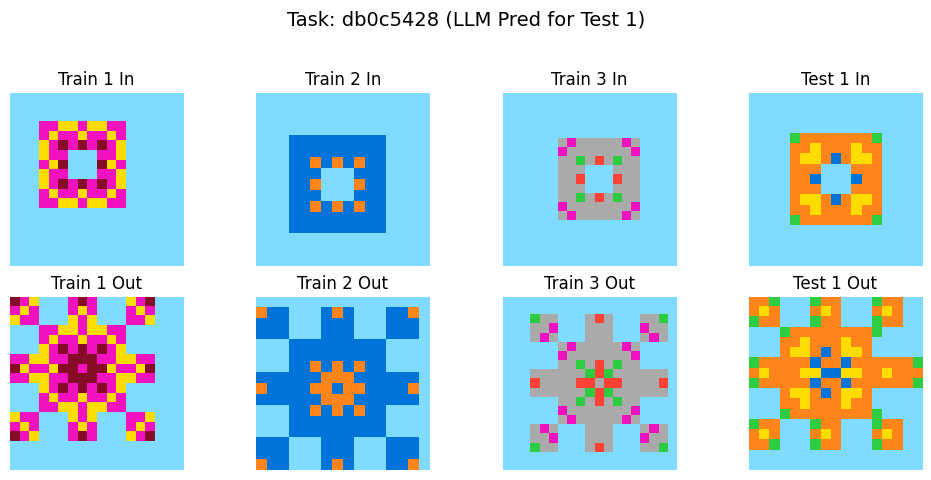

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: db695cfb / Test Case: 0 =====

--- Raw LLM Response ---
```
To derive the solution pattern for transforming the input grid to the output grid, let's break down the observed transformations from the example inputs to their respective solutions. Each solution shows a diagonal pattern of `1`s being placed such that they create a sequence from the initial `1`s in the input.

### Analysis and Deduced Transformation Rules:
1. **Identify Positions of '1's**:
    - Locate all positions in the grid where the value is `1`.

2. **Create Diagonal Transformations**:
    - For each identified position of `1`, create a diagonal line by transforming grid values to `1` in a downward-right direction until reaching the boundary of the grid or another value.
    - This diagonal starts from the original `1` and covers all subsequent positions where no other pattern-specified transformations are needed.

3. **Handle Pre-existing `6` 

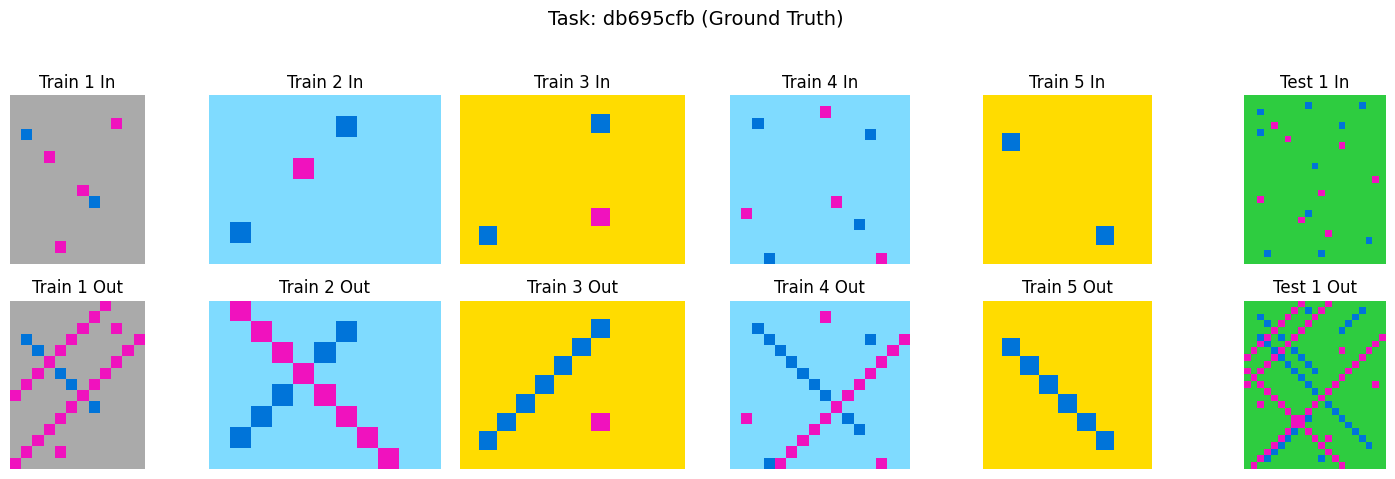


--- LLM Prediction Visualization (Task: db695cfb / Test: 0) ---


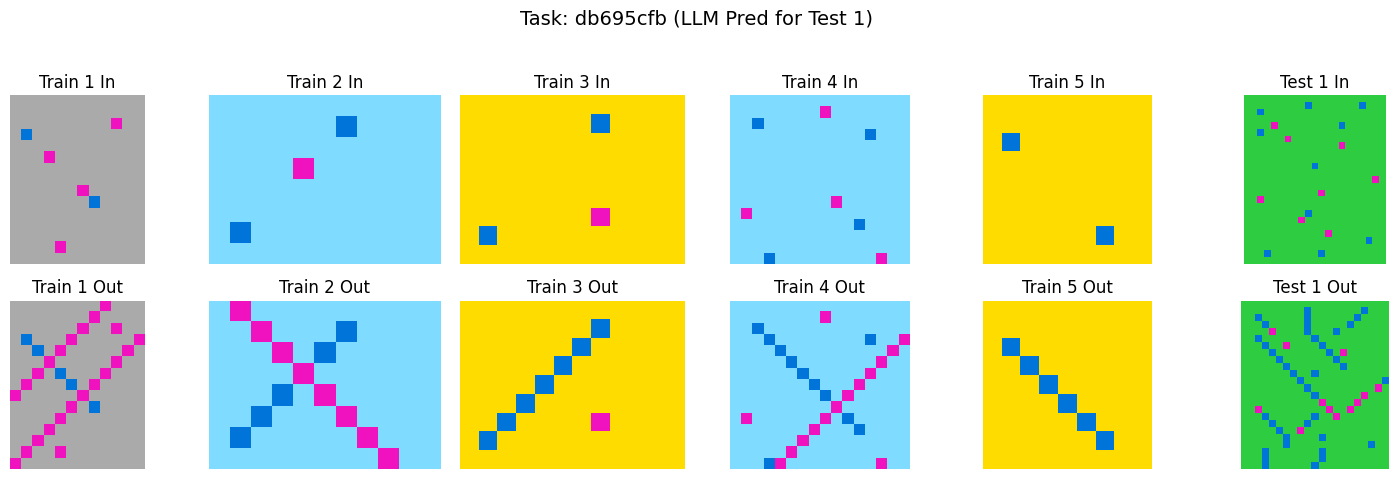

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((24, 21) vs (25, 21)))


===== Task: dbff022c / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the given task, let's analyze the transformation rules from the examples.

### Observations:
1. **Example 1:**
   - The area containing `4`s in the input maintains the horizontal `4s` pattern, but also:
     - Any `0` surrounded by `4s` is turned into `6`.
     - Within a closed area of `3s`, any `0` surrounded by `3s` becomes `3`.
   
2. **Example 2:**
   - The area containing `8`s in the input maintains the `8s` pattern, but also:
     - Any `0` between parallel `8s` lines is turned into `1`.
   - Within a closed area of `5s`, the same rule applies: `0` surrounded by `5s` becomes `5`.

3. **Example 3:**
   - The area containing `4`s remains with changed `0s` into `4s` inside the contour.
   - Another section of area containing `2s` follows the same pattern with `0s` between getting replaced by `7s`.

### Deduced Transform

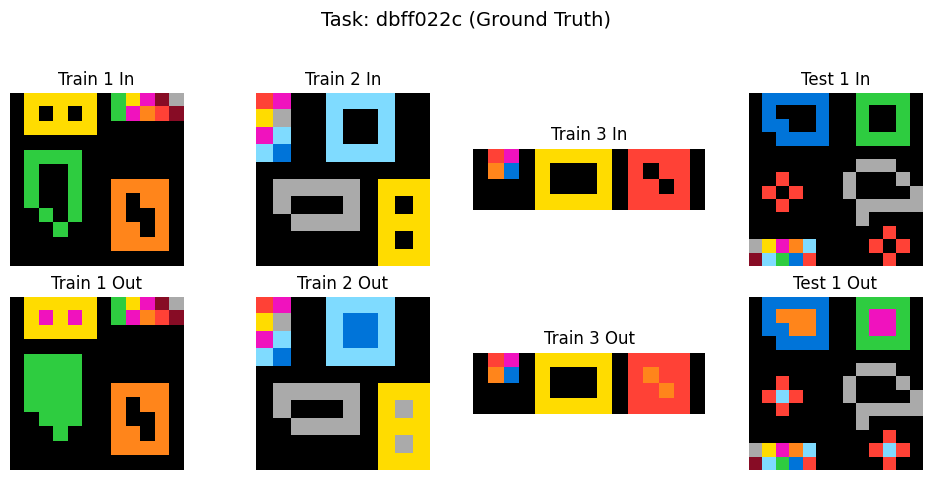


--- LLM Prediction Visualization (Task: dbff022c / Test: 0) ---


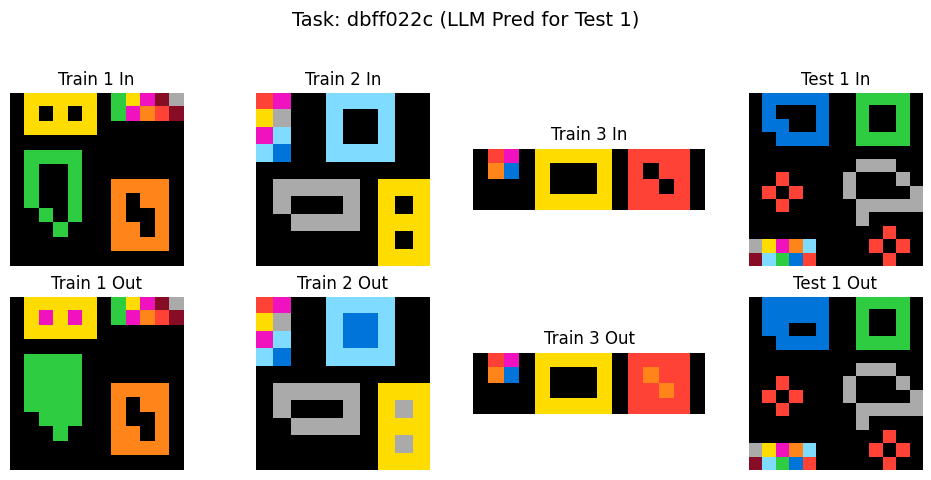

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: dd6b8c4b / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we have to determine the transformation rules being applied to each of the input matrices to obtain the corresponding output matrices.

### Identifying the Rules

After examining the training examples, we can propose the following transformation rules:

1. **Horizontal Replacement Rule**: Look for the rows containing a pattern `3 3 3`. If this pattern is found, replace the *row segment* directly above it with `9 9 9`. (Note: replace the first three tiles directly above `3 3 3`.)

2. **Vertical Replacement Constraint** (if applicable): While the transformation might appear horizontal, vertically if any transformations match a partial pattern `3 3 3`, the logic used restricts a consistent replacement, which serves as a potential constraint in the production of the solution.

3. **Matrix Edge Consistency Rule**: Ensure the outer bord

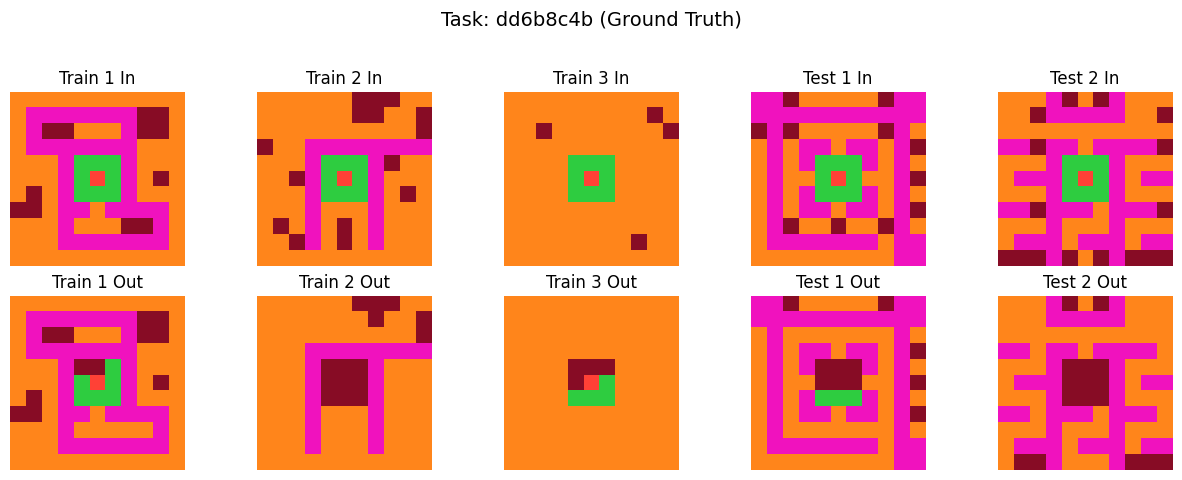


--- LLM Prediction Visualization (Task: dd6b8c4b / Test: 0) ---


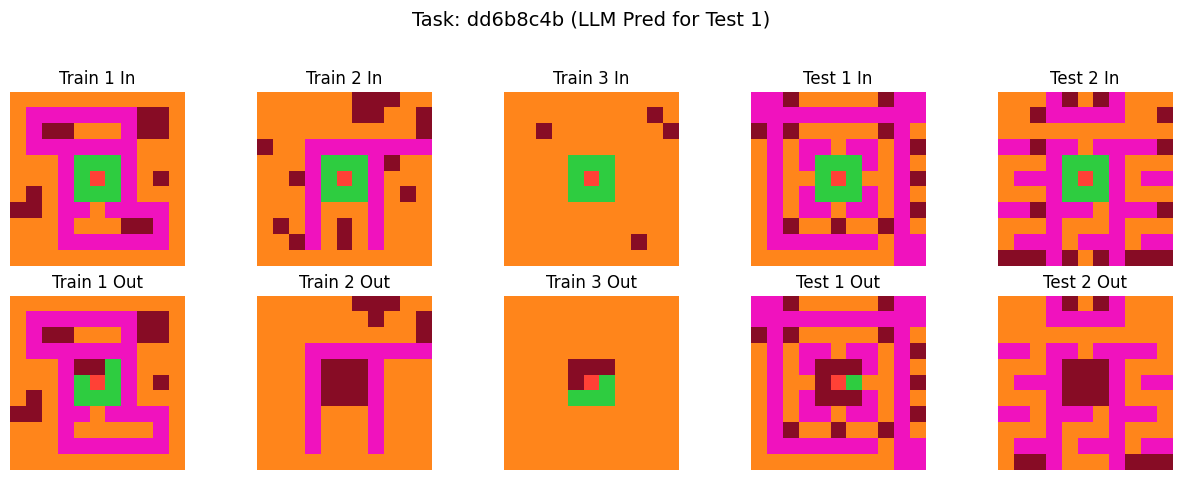

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: dd6b8c4b / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to observe and determine the transformation rules from the input grids to the output grids.

### Observations from the TRAIN Examples:

1. **Structure Identification:**
   - Based on the input structures, we see rectangular (or close to rectangular) formations of numbers in the middle of the grids, such as numbers 3 and 2, which appear to be enclosed within an area marked by the number `6` or surrounded by `7`s.

2. **Transformation of Inner Grid:**
   - The task is to detect a `3 2 3` pattern and enclose the area occupied with `9`s either horizontally around the `3 2 3` or vertically. Specifically, these `9`s replace the corresponding `6`s.
   - Once the placement of `9`s around `3` and `2` are identified, the original colors (`7` or `9`) element at the extension parts appear to be reinstated back as it was.

3. **Consist

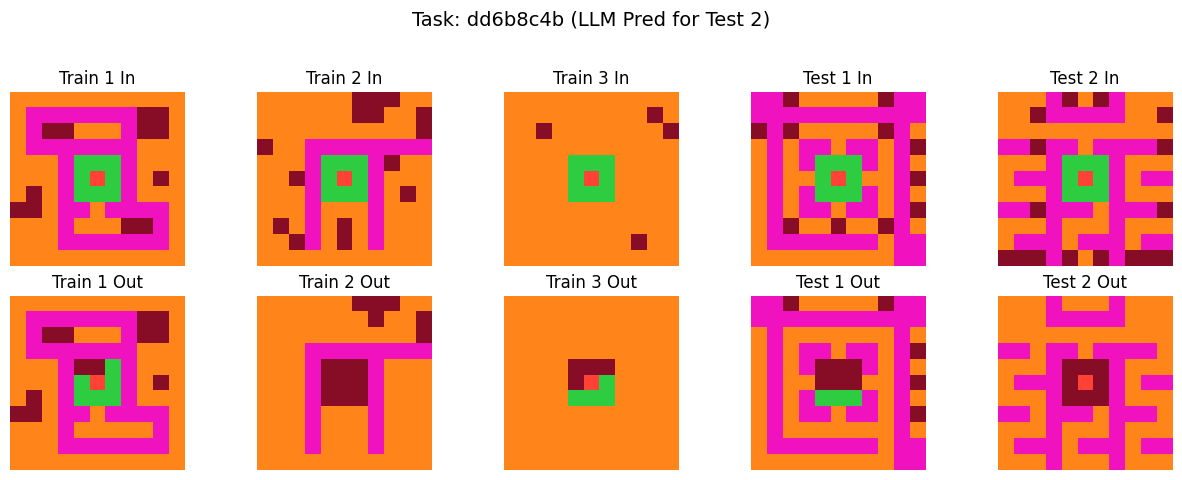

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: de809cff / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, let's derive transformation rules from the examples given.

### Transformation Rules:
1. **Flood Fill Replacement Rule**:
   - Identify the largest contiguous region (cluster) of a non-zero digit (say `n`) in the input grid.
   - Replace this entire region with the digit `8`. This is applied to the largest cluster of the digit `3` in Example 1, and `2` in Example 2.

2. **Incremental Decrease Rule**:
   - For digits in a region that were not part of the largest cluster, perform the following:
     - Identify all contiguous clusters and replace all occurrences of the digit with one less if it's not the digit `1`.

3. **Boundary Checks**: 
   - Ensure that transformations only affect the non-zero values and that operations are only done within the grid boundaries.

### Test: Deduce Output by Applying Rules
We'll now apply these rule

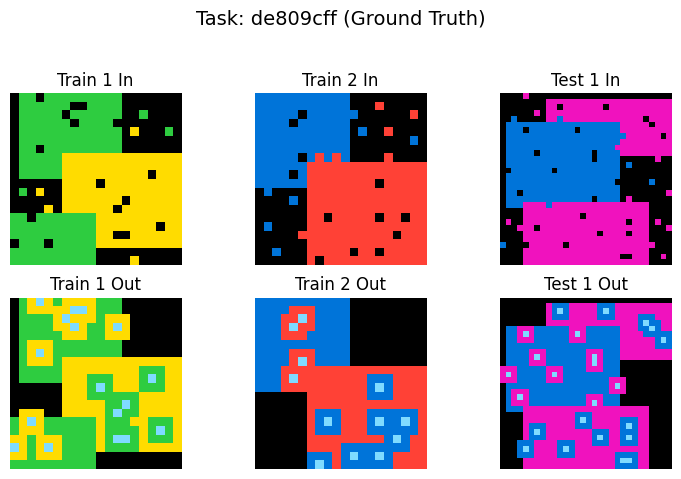


--- LLM Prediction Visualization (Task: de809cff / Test: 0) ---


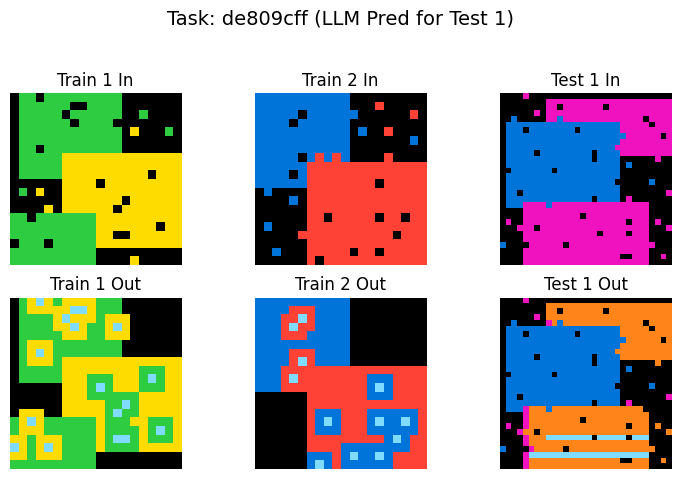

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: dfadab01 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to identify the pattern and transformation rules from the provided training examples and apply them to the test input. Let's analyze the examples to deduce the pattern.

### Pattern Analysis:

1. **Identify Shapes:**
   - In each example, the grid contains different shapes or patterns indicated by distinct numbers.
   - Example 1: 6s form L-shape, 5s form cross, 3s form path, 2s form short pipes.
   - Example 2: 2s and 3s form scattered points, 1s form paths.
   - Example 3: 4s form square, 2s are single points.
   - Example 4: Randomly distributed numbers forming paths or connections.

2. **Transformations:**
   - The grid numbers are replaced, rotated, or mirrored to form final shapes with different numbers.
   - Each distinct number or set of shapes is converted into another distinct shape or set of shapes consistently.

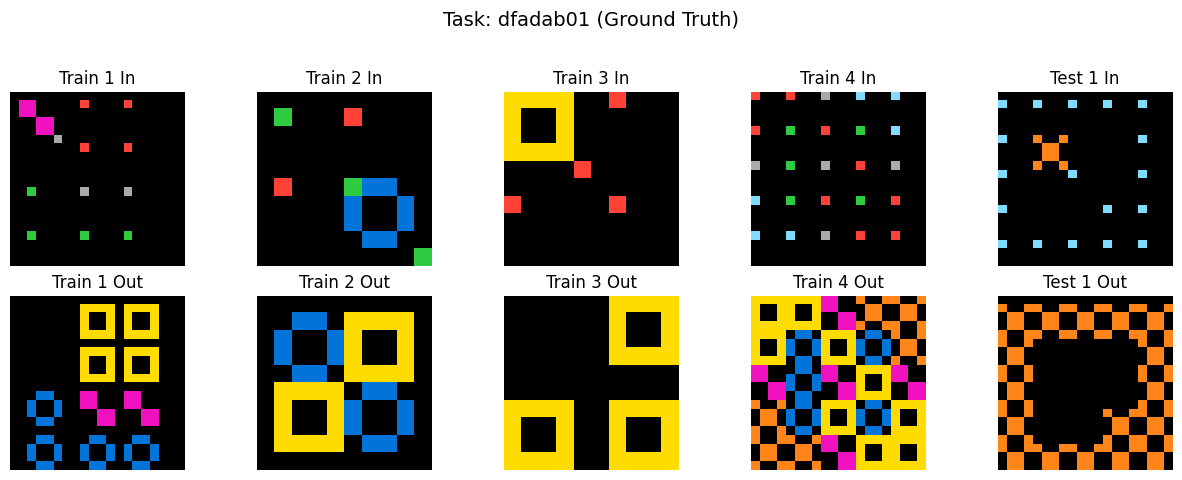


--- LLM Prediction Visualization (Task: dfadab01 / Test: 0) ---


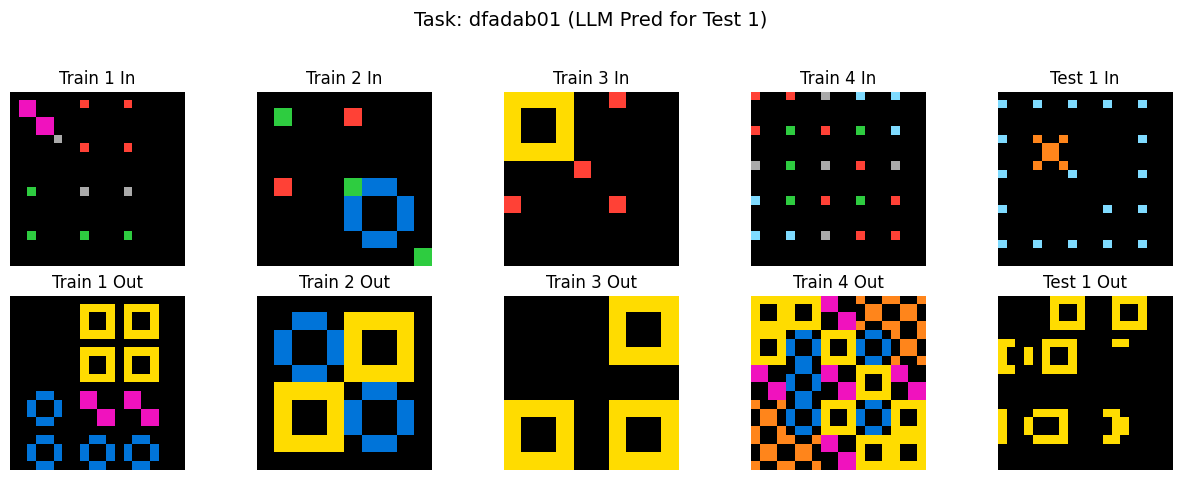

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: e12f9a14 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, we need to analyze the given examples and derive a set of transformation rules that when applied to the test input, produce the desired output. Upon analyzing the train examples, the consistent rule observed is that within each segment or distinct group of numbers surrounded or bordered by the number '8' (or a different defined value), it needs to be expanded into longer trails of that number. The expansion seems to be a function of the elements surrounding it vertically, horizontally, and sometimes diagonally.

Here's a detailed breakdown of the transformation rules:

1. **Block Propagation or extension**: Observing examples, increase or propagate the non-border numbers in each path or defined segments — this is seen to spread until it meets an '8' or a defined boundary limit. For example, a '9' naturally spreads to cover spaces 

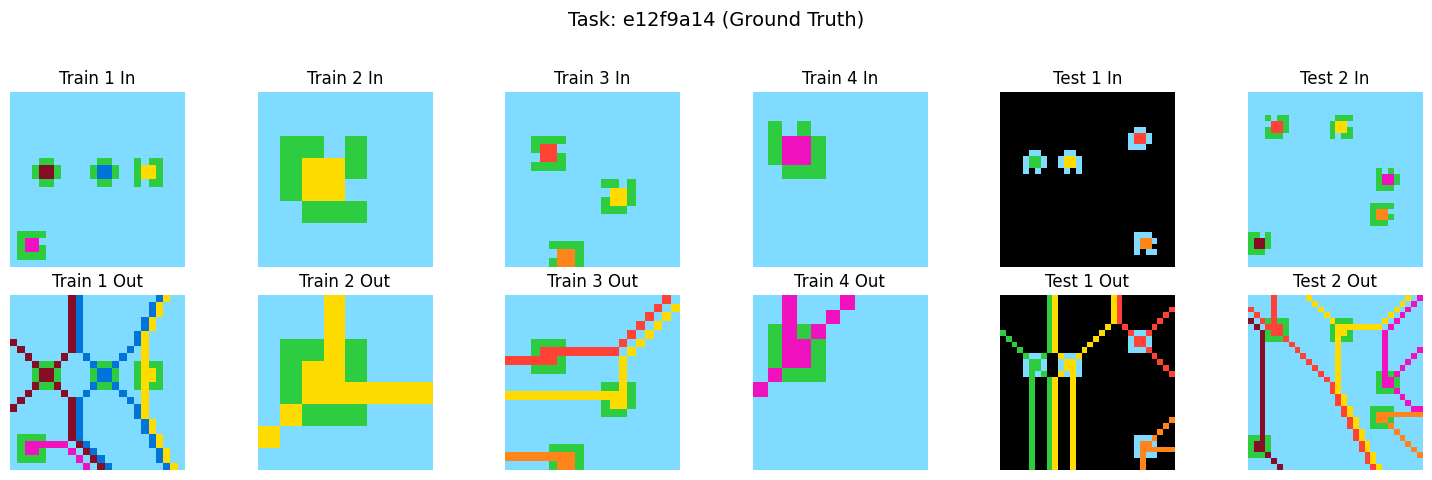


--- LLM Prediction Visualization (Task: e12f9a14 / Test: 0) ---


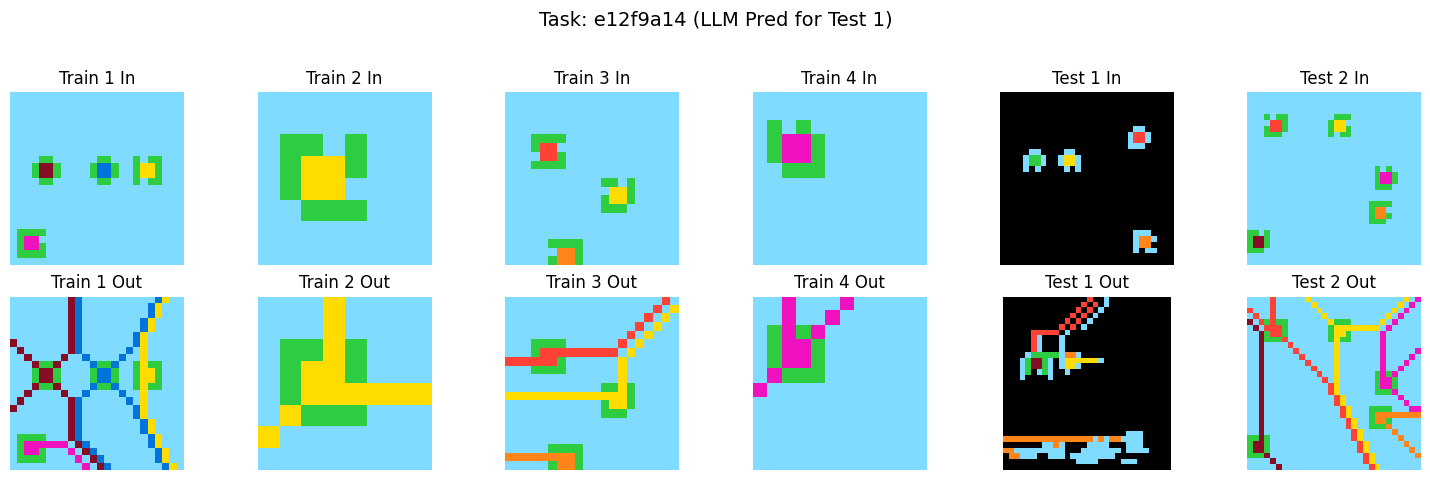

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((31, 30) vs (30, 30)))


===== Task: e12f9a14 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the problem presented, given the examples and transformations from the input grids to the output grids, we need to identify pattern-based transformations. Here are detailed steps and possible transformation rules deduced from the examples:

### Observed Patterns and Transformations:

1. **Identify and Wrap Neighboring Blocks:**
   - In all examples, a pattern involving the number `3` indicates a block or shape, like a rectangle or square.
   - The `number 4` is used to wrap around specific shapes. Specifically applied along the outside perimeter of adjacent numbers (like a cluster) of `3`s. 

2. **Neighboring Sequence Replacement:**
   - Involves changing the numbers that are adjacent to forms of clusters.
   - `1`s and `9`s are used within clusters of 3s (nested within or touching).

3. **Propagation from Neighboring Nodes

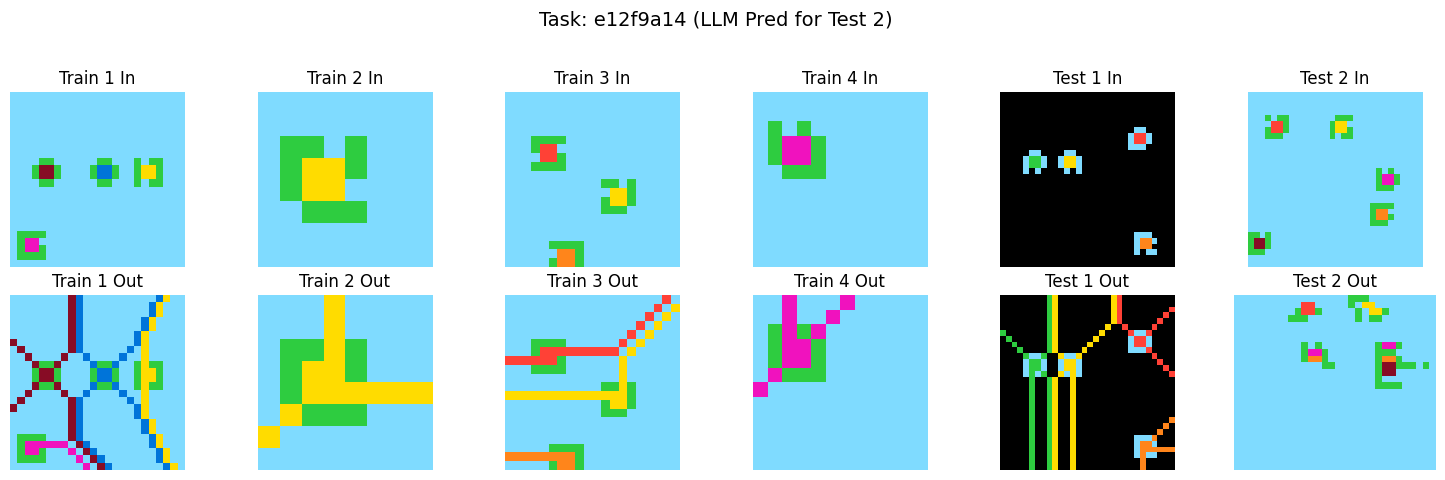

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((26, 30) vs (30, 30)))


===== Task: e3721c99 / Test Case: 0 =====

--- Raw LLM Response ---
```
To determine the transformation rules that convert the input grid into the output grid for the given examples, let's analyze patterns one by one:

### Observations from Training Examples:

1. **Background and Fill Region**:
   - The background remains unchanged, which seems to be filled with zeros (`0s`).
   - Larger `5` regions are transformed into different color/number sequences. Checking the pattern of transformation for these sections is key.

2. **Connecting Sections**:
   - In the input, there are isolated sections labeled with various fill numbers.
   - These numbers can represent different objects, paths, or trails.

3. **Transformation Rules**:
   - Regions filled with `5` in the input are transformed based on connectivity and potentially shape. For example, in the first example, `5` is transformed into numbers `4`, `3`, `

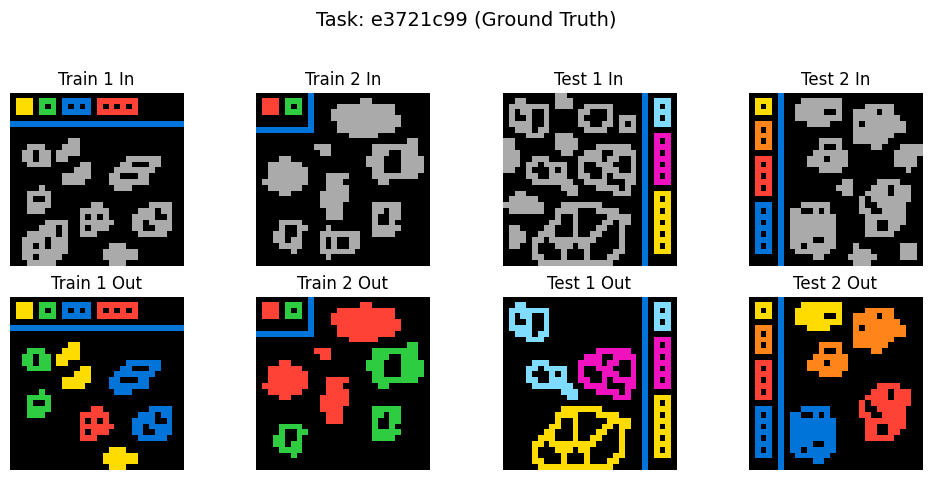


--- LLM Prediction Visualization (Task: e3721c99 / Test: 0) ---


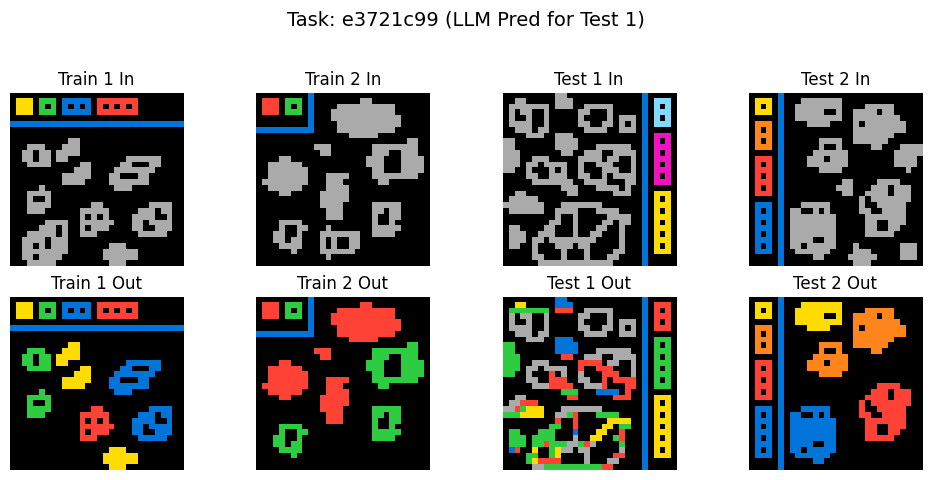

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: e3721c99 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given transformation problem, let's identify the patterns and rules observed in the train examples with the desired solution:

1. **Identify Sections:** Each pattern appears to be divided into distinct sections consisting of a particular non-zero number (like 4s, 3s, 5s, etc.), surrounded by zeros. These are like blocks or segments of contiguous numbers.

2. **Color Mapping Inspiration:**
   - In the initial examples, sections/blocks of high value numbers (5s and 4s) appear to be transformed into different numbers that are lower or equivalent in value. These transformations change consistently (e.g., 5 to 3, similar numbers form specific shapes).
  
3. **Determining Consistency:**
   - Each section with a specific number from the input is replaced with a specific number in the output.

4. **Transformation Steps:**
   - Identify the bounding

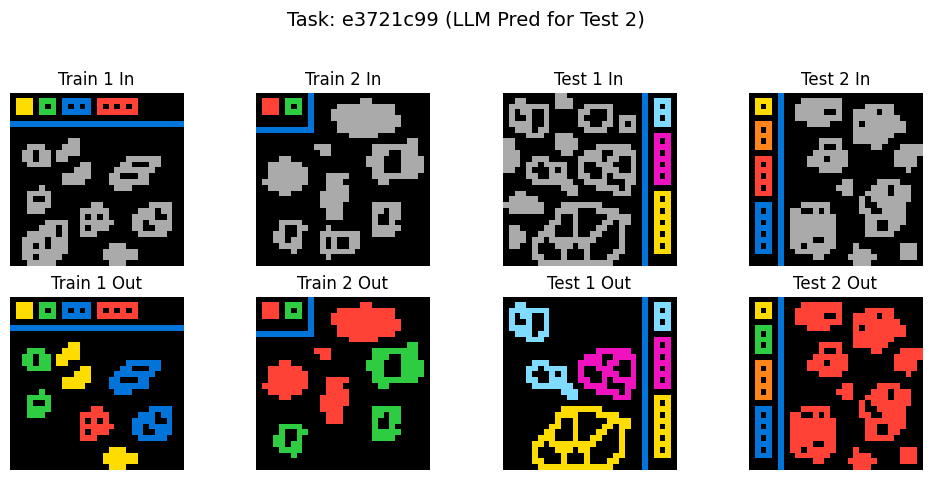

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: e376de54 / Test Case: 0 =====

--- Raw LLM Response ---
```
To identify the transformation rules for these examples, let's break down the patterns seen in the input to output mappings for each example.

**Analysis of Transformations:**

1. **Example 1:**
   - The transformation involves extending diagonals formed by specific numbers to their longest possible length, from edge to edge.
   - The number '2' that appears in a diagonal pattern in the input gets extended upwards until it hits another '2' or a number that isn't '7'.
   - Each diagonal is reconstructed, ensuring that the diagonal is filled completely with the non-7 number.

2. **Example 2:**
   - The input has lines of identical numbers.
   - Rows with numbers other than '7' are filled with that number from the leftmost non-7 until the rightmost non-7, extending horizontally.
   - The operation is essentially extending these lines horizontally.

3. **Ex

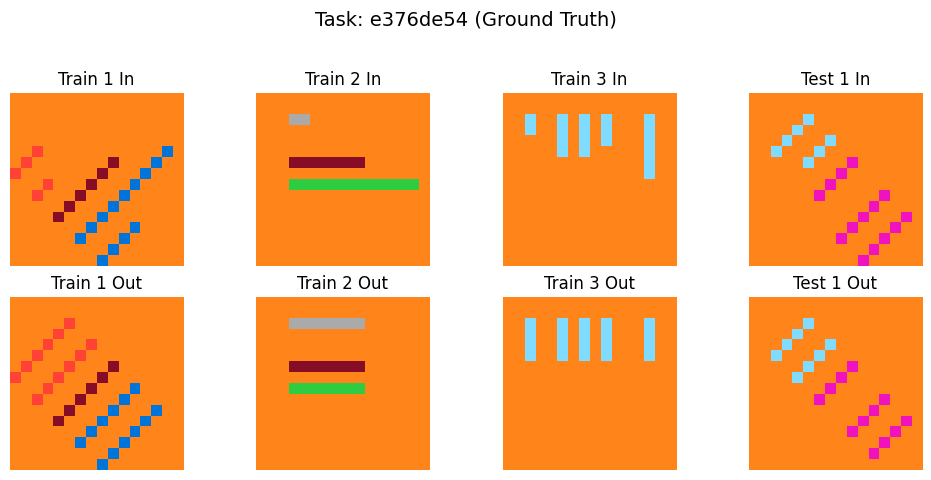


--- LLM Prediction Visualization (Task: e376de54 / Test: 0) ---


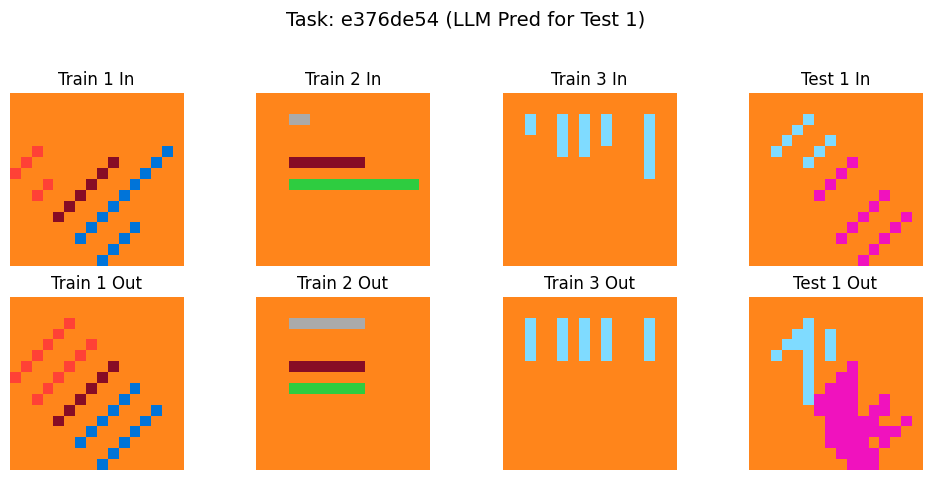

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: e8686506 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the transformation from input to output in the provided train examples, follow these deduced rules:

1. **Identify Dense Blocks:**
   - In each input grid, find patterns or blocks of numbers other than the border numbers which seem surrounded or enclosed. These are potential sub-grids or patterns of interest.
   - The borders outside this dense region can be defined as the surround where transition happens.
  
2. **Transform and Resize:**
   - We focus on a 5x5 surrounding grid region around the dense block, based on the pattern observed in both examples. Specifically, they are the features around the main number elements.
   - The dense block's (anything other than the mentioned border) external values must be reset to their edge tiles to create a frame.
   
3. **Retain Specific Numbers and Arrange Center:**
   - The grid numbers originally wi

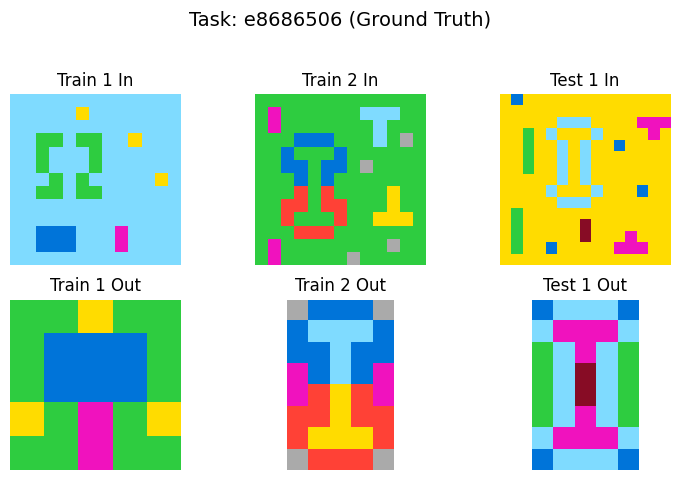


--- LLM Prediction Visualization (Task: e8686506 / Test: 0) ---


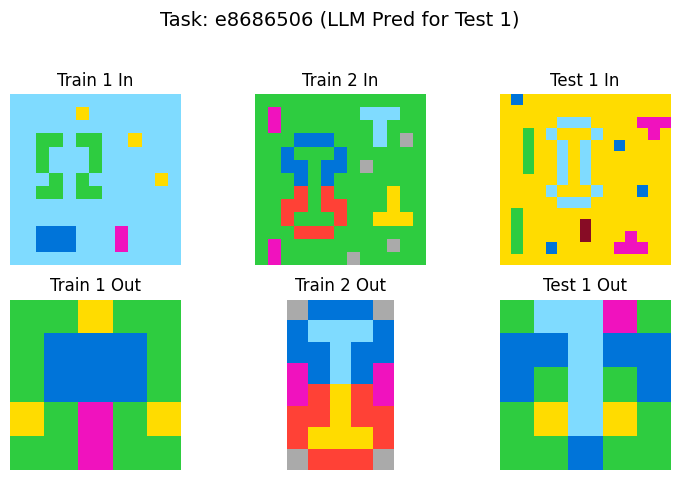

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((5, 5) vs (8, 5)))


===== Task: e87109e9 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the given problem, let's examine the rules applied in the training examples:

1. **Detection of Patterns:**
   - Each input consists of a grid divided into sections.
   - We observe blocks of various color numbers within these sections.

2. **Transformation Rules Observed in Examples:**
   - Identified Key Color: Each grid example has a color block that isn't surrounded completely by another number/color (this changes to color 8 in the solution).
   - Find isolated small sections of identical numbers, typically surrounded by 5, such as 1's, 6's within a frame of 5's. 
   - In each case, these numbers are then mapped to 8 in the solution:
     - Within sections, numbers or an entire region such as a top row, corner, or within an area bounded by other sections.
     
3. **Replacement With 8:**
   - Transform identified blocks int

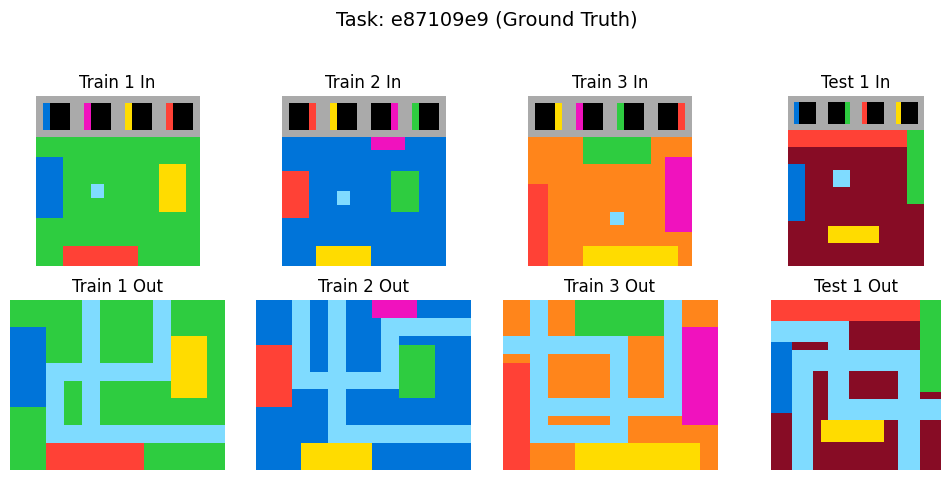


--- LLM Prediction Visualization (Task: e87109e9 / Test: 0) ---


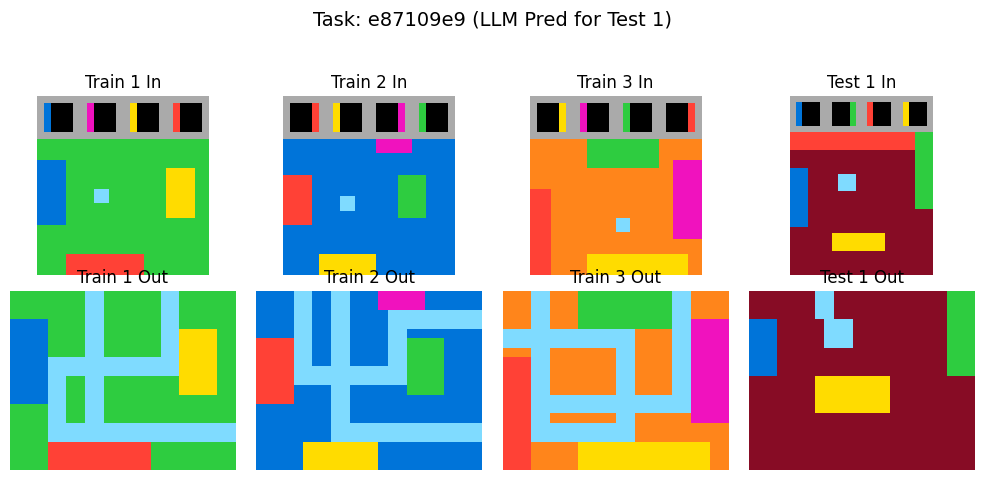

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((19, 24) vs (24, 24)))


===== Task: edb79dae / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this ARC-style problem, we must analyze the examples given to discern the rules that transform the input grids to the corresponding output grids. Let’s break down the observed patterns and transformations:

### Observations and Deductions:
1. **Surrounding Border with '5's**: 
   - In both examples, the outermost boundary is consistently filled with '5'. This seems to represent a frame or border around the grid.

2. **Inner Grid Structure**:
   - The key numbers inside the input grid (different from '8' or similar noise values) are organized into contiguous blocks and follow specific rules for padding and transformation.
   - Blocks of similar numbers are grouped and may have padding (like '2', '3', etc.), indicating continuity within the block.

3. **Transformed Blocks**:
   - The transformation affects the layout of the b

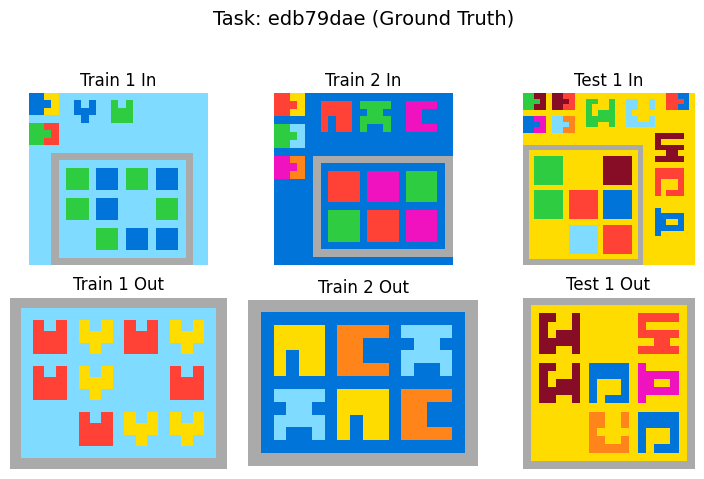


--- LLM Prediction Visualization (Task: edb79dae / Test: 0) ---


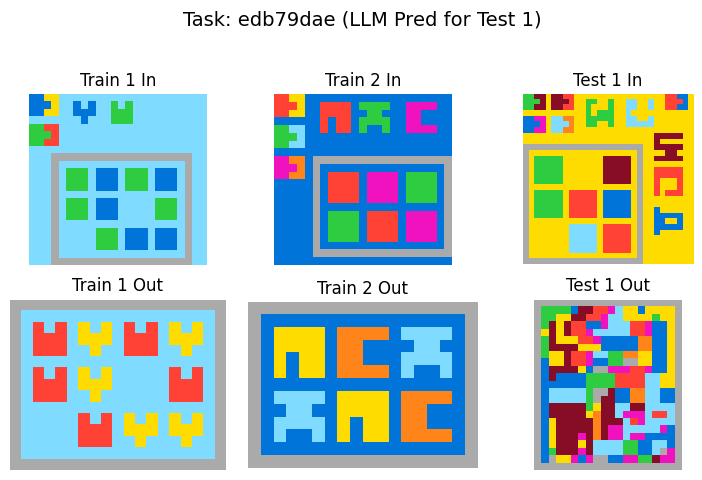

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((23, 20) vs (21, 21)))


===== Task: eee78d87 / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the provided ARC problem, let's analyze and define the transformation rules based on the given training examples. We'll deduce the transformation rules by comparing the input grids to their respective output grids.

### Rules Deduced from Training Examples:
1. **Duplication and Expansion**: The input grid is expanded into a larger grid. The pattern of four enlarged blocks can be observed, each representing copies of the original pattern.
   - The original 6x6 grid is expanded to a 16x16 grid.
   - Each row of the original grid is transformed into five rows in the resulting grid. This pattern is mirrored for columns too.

2. **Color and Space Mapping**: The colors and spacing are transformed as follows:
   - The value '7' in the input grid is primarily transformed to '7's and '0's, with a pattern guiding their placement:
   

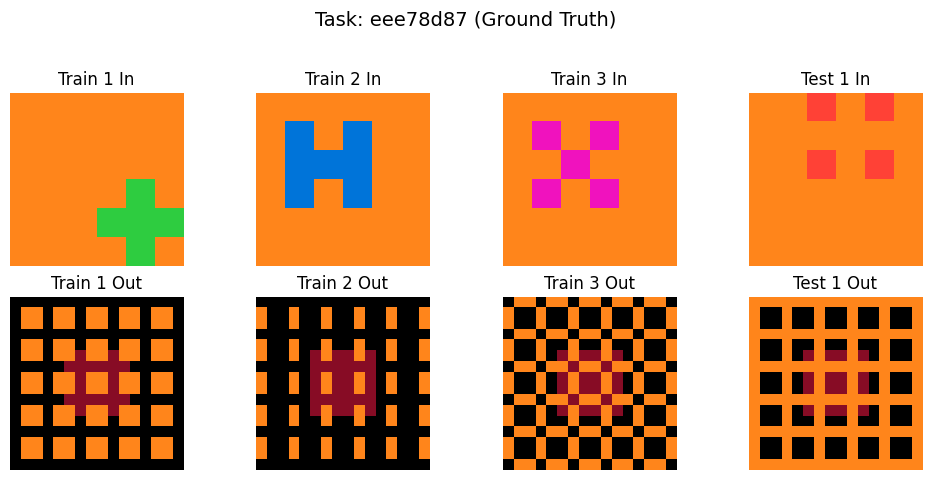


--- LLM Prediction Visualization (Task: eee78d87 / Test: 0) ---


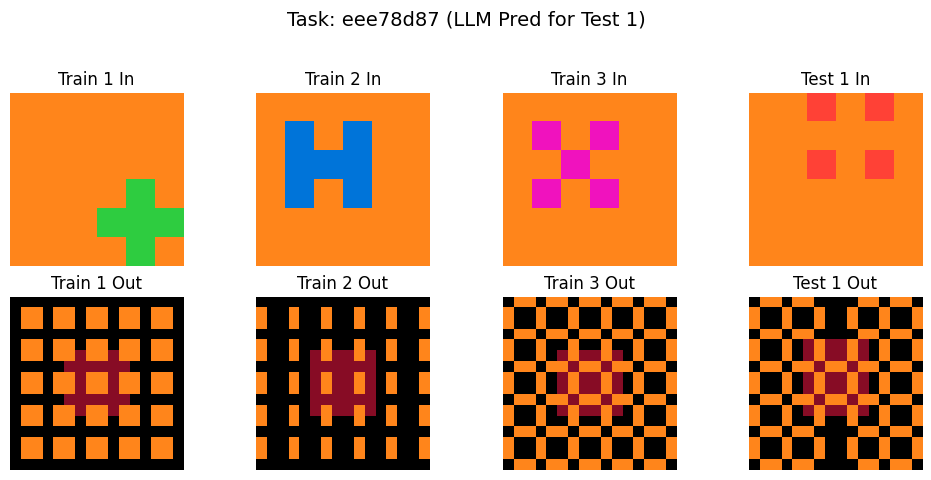

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: f560132c / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve this problem, it's necessary to analyze the transformation from the given input grids to the solution grids to understand the underlying rule that achieves these transformations:

### Observed Pattern:

1. **Visible Regions or "Blobs":** Both examples have distinct colored regions surrounded by zeros. These regions are made by connected non-zero cells.
2. **Grid Transformation:** These regions are rearranged into a smaller square grid, filling spaces compactly.
3. **Identification and Arrangement:**
   - Every distinct non-zero area (unique set of connected numbers) is compactly rearranged within a defined square region in the solution grid.
   - The content of the compact sub-grid should form an approximate square or rectangle keeping most of the internal numbers.

### Transformation Steps:

The transformation from the input to the output invo

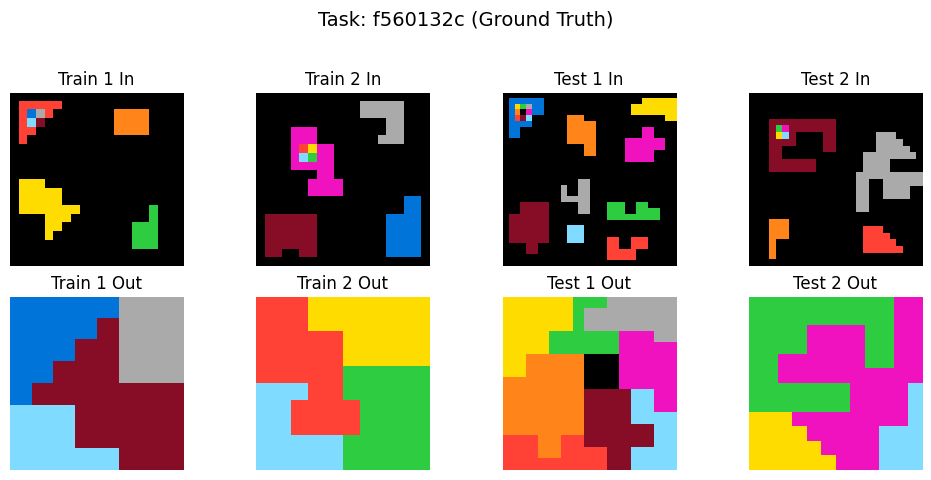


--- LLM Prediction Visualization (Task: f560132c / Test: 0) ---


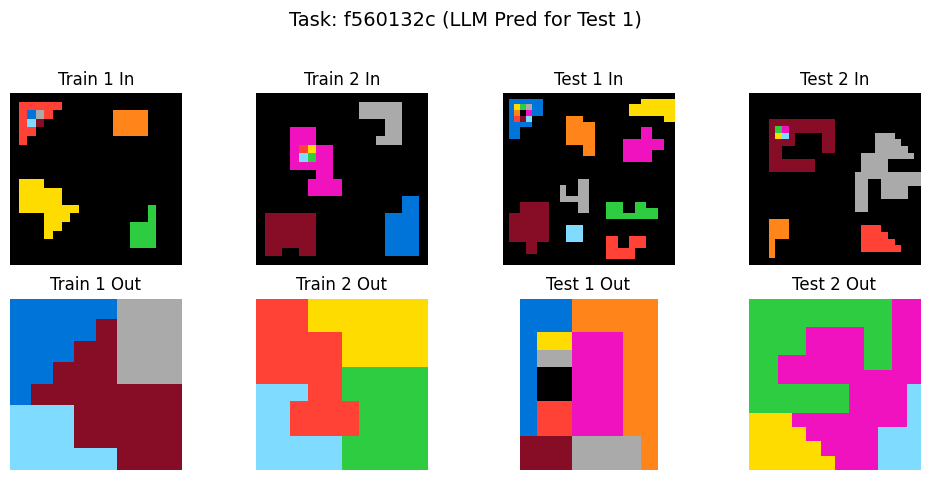

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((10, 8) vs (15, 15)))


===== Task: f560132c / Test Case: 1 =====

--- Raw LLM Response ---
```
To transform the input into the output, let's deduce the rules from the provided training examples. The transformation rules involve extracting non-zero regions, identifying unique color values (non-zero numbers), and arranging them in some oriented pattern in the solution grid. Let's analyze each training example to identify the transformation rules.

### Rule Deduction:
1. **Identify Contiguous Regions**:
   - Identify contiguous non-zero regions in the input grid. Each region has a distinct color or number (e.g., in example 1: regions with numbers like 1, 2, 5, 7).

2. **Extract Maximum Non-zero Value**:
   - For each region, find the maximum number present. This appears to be the distinguishing feature of each region for organizing into the output grid.

3. **Extract and Combine**:
   - Extract the non-zero regions of numbers usi

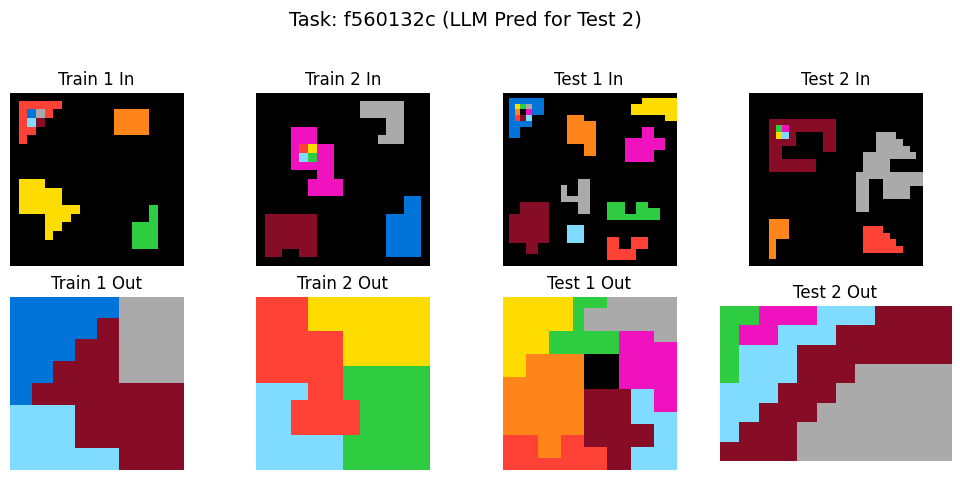

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((8, 12) vs (12, 12)))


===== Task: f931b4a8 / Test Case: 0 =====

--- Raw LLM Response ---
```
Upon analyzing the provided examples, I have determined the following transformation rules:

1. The solution grid is constructed using distinct elements found in specific sections of the input grid.
2. Each example involves extracting a group of numbers from a section of the input grid that follows a pattern distinct from the rest. It's evident across all examples that these groups are repeated periodically in the solution.
3. The size of each group or pattern extracted from the input may vary, and it forms the repeating rows in the solution.

Here are the detailed rules based on analyzing the provided examples:

- **Rule Extraction for Solution**:
  - Identify a subsection in the input grid that contains a distinctive set of numbers (those that form repeating groups or patterns).
  - Extract the rows from this subsection to create a

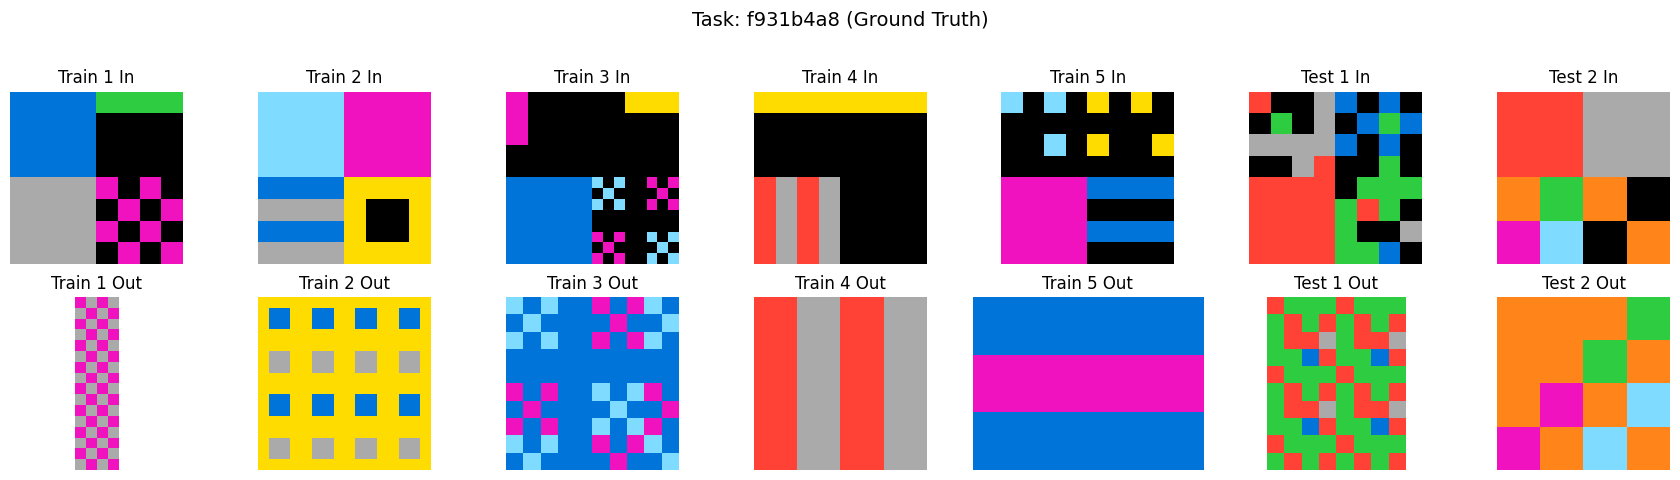


--- LLM Prediction Visualization (Task: f931b4a8 / Test: 0) ---


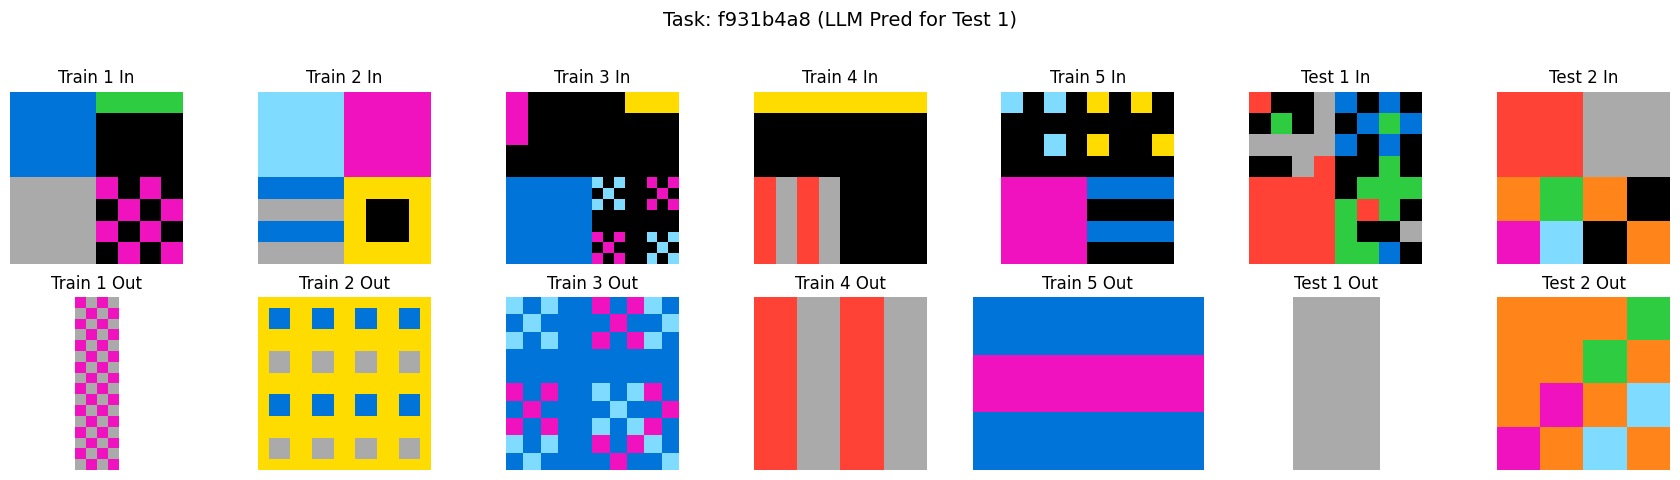

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((8, 4) vs (10, 8)))


===== Task: f931b4a8 / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve the given ARC task, let's analyze the patterns in the examples to deduce the transformation rules. Here's the step-by-step analysis:

### Observations from the Example Inputs and Outputs:

1. **Structure Analysis:**
   - The grid structure in the input provides a basic view for rows and regions of interest by differentiating numbers.
   - There is a pattern in the numbers forming blocks or segments that transform in the output.

2. **Common Elements Handling:**
   - In the solutions, various blocks of numbers (typically non-zero) in the input are transposed, rearranged, or emphasized in the output.
   - The arrangements of blocks from the input to output suggest a focus on selecting non-zero segments or visually distinguishable elements (non-zero, unique blocks or specific lines).

3. **Dimensional Adjustment:**
   - The outpu

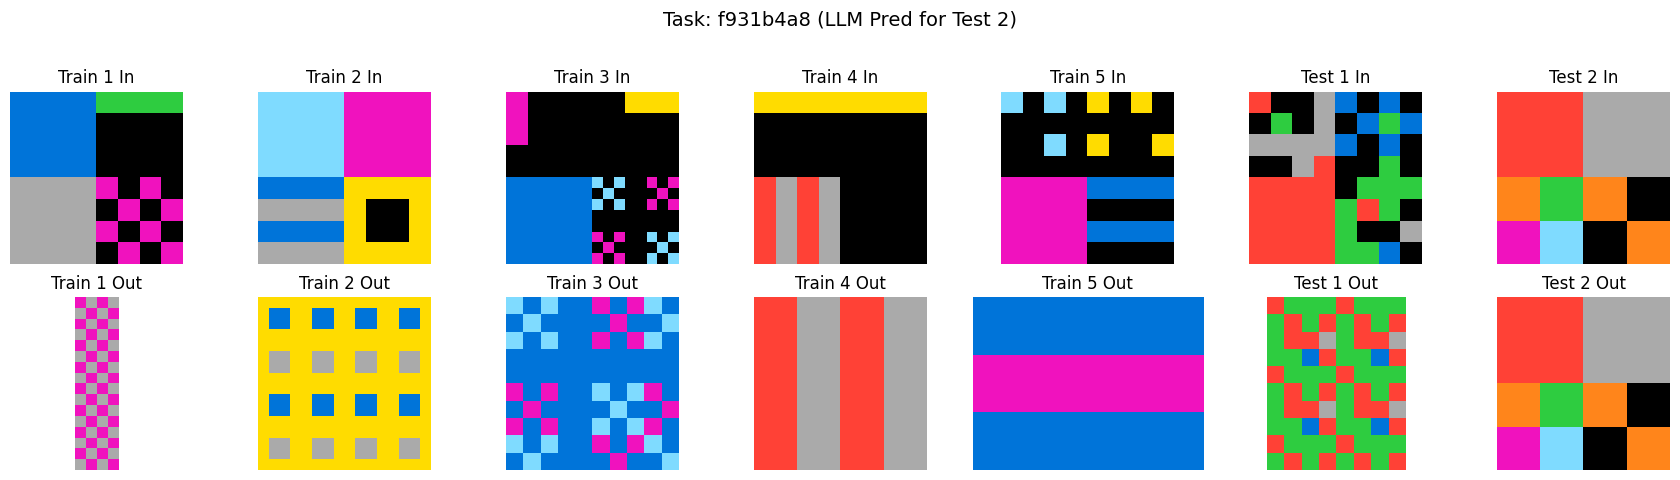

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: faa9f03d / Test Case: 0 =====

--- Raw LLM Response ---
```
To find a rule to transform the input to the output in this ARC-style task, let's analyze the patterns observed in the training examples:

### Observed Pattern:
1. **Horizontal Lines**: Horizontal sequences of the same number (≥ than length 2) transform to lines with different numbers.
   - The number "2" in these sequences usually requires special attention as it indicates a border or a change point. 

2. **Transformation of Number "3"**: All instances of "3" in a connected component are converted to another number. The number often changes based on the neighbors it connects to. If there's a different number sequence nearby or it ends, it changes the rest of the sequence (above, below, left, or right).

3. **Rows or Columns with Borders on Both Sides**: Numbers between borders (like "3" within "2"s) can undergo changes based on sequences’ nature. The c

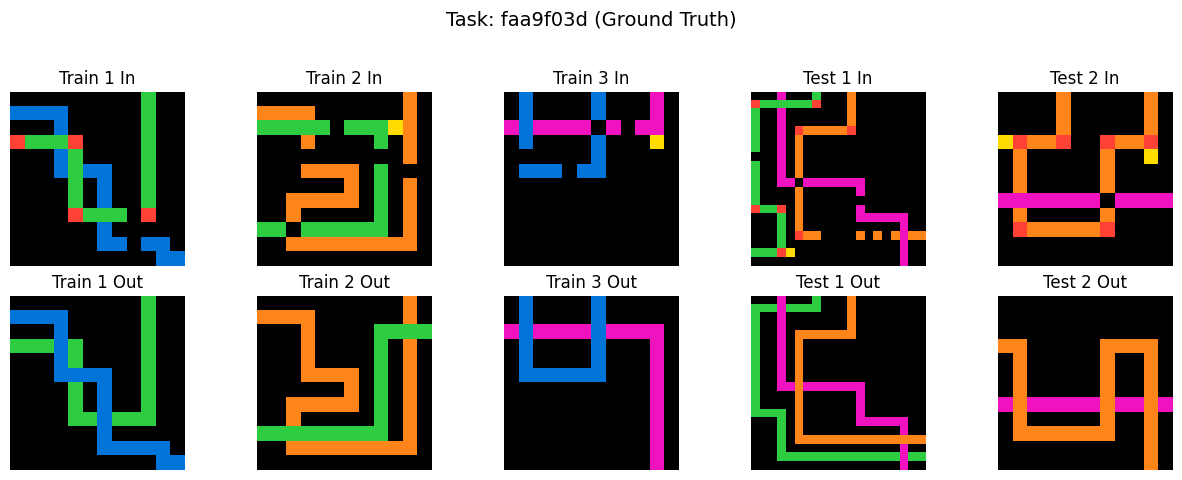


--- LLM Prediction Visualization (Task: faa9f03d / Test: 0) ---


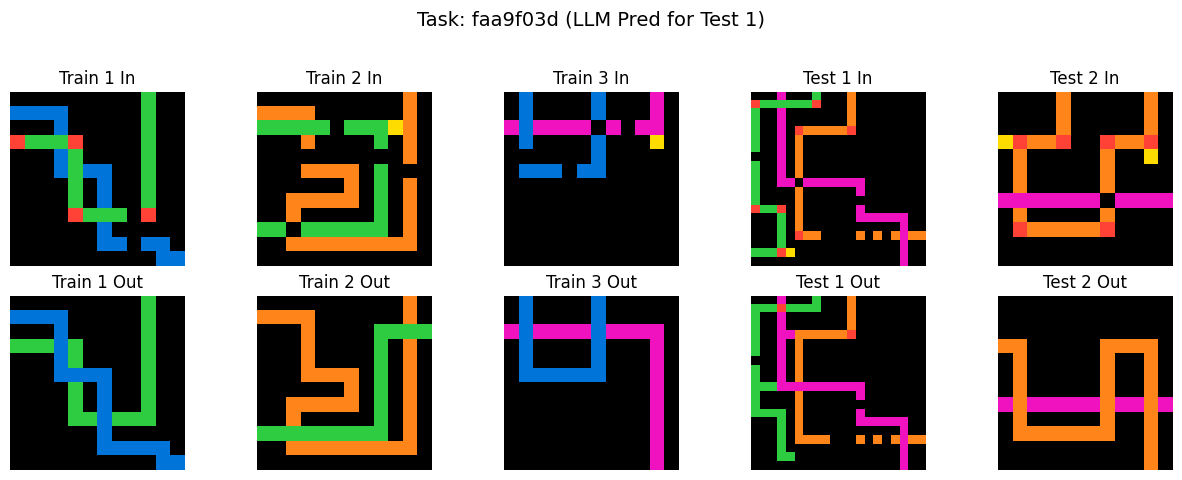

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: faa9f03d / Test Case: 1 =====

--- Raw LLM Response ---
```
To solve this problem, we need to deduce transformation rules that modify the input grid into the output grid as shown in the training examples. Let’s analyze the rules based on the provided examples:

### Exploration of Training Examples:
By comparing inputs to outputs in the training examples, we notice the following transformations:

1. **Preserve Specific Elements**: 
   - All non-zero elements in certain regions of the grid are transformed in specific ways. Presumably, zeros in regions where transformations occur remain zeros unless specified otherwise by transformation.
   
2. **Horizontal and Vertical Alignments**: 
   - Horizontal or vertical sequences of the same number undergo transformations. It appears certain sequences (or parts of them) are replaced or augmented with new sequences.
   
3. **Region-Specific Transformations**:
   - Each trai

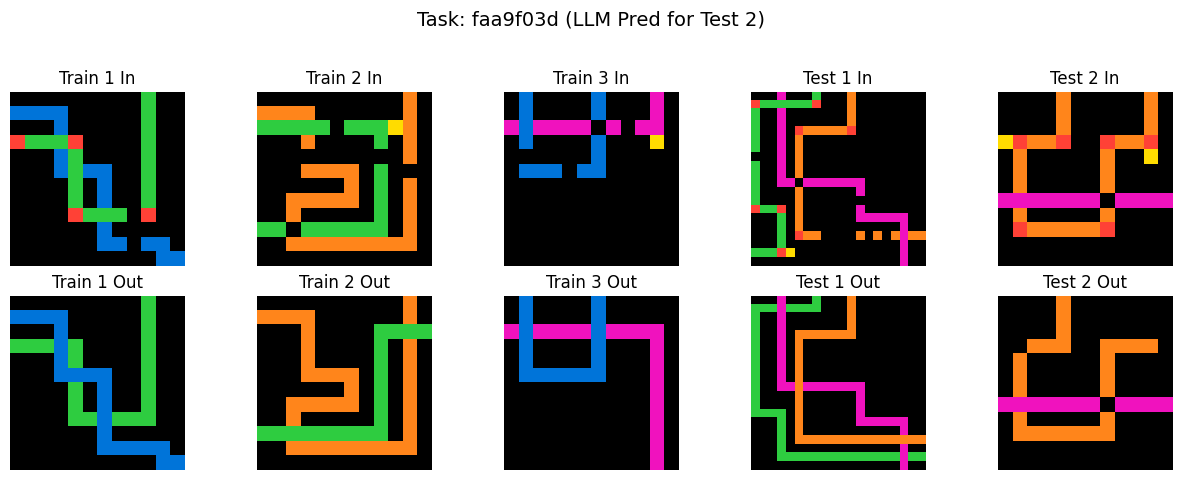

Prediction Correctness: Incorrect (Reason: Content Mismatch)


===== Task: fc7cae8d / Test Case: 0 =====

--- Raw LLM Response ---
```
To solve the transformation from the input grid to the output grid, let's analyze the given examples to deduce the rule set:

### Observations:

1. **Core Structure Extraction**:
   - The solution appears to condense large input grids into smaller grids, identifying relevant sections or patterns and discarding others.

2. **Example Patterns**:
   - **Example 1**:
     - Only certain columns are used in the output, with reduction in rows as well.
     - Pattern in the middle seems to be condensed and retains the pattern from input.
     - Choose specific sections surrounded by repeated or constant values like `1` or `8`.

   - **Example 2**:
     - Large grid condensed to a smaller grid by focusing on a specific pattern involving numbers `2` and `4`.
     - A relevant section that yields the 10x10 solution pattern emphasizing unique or consistent structu

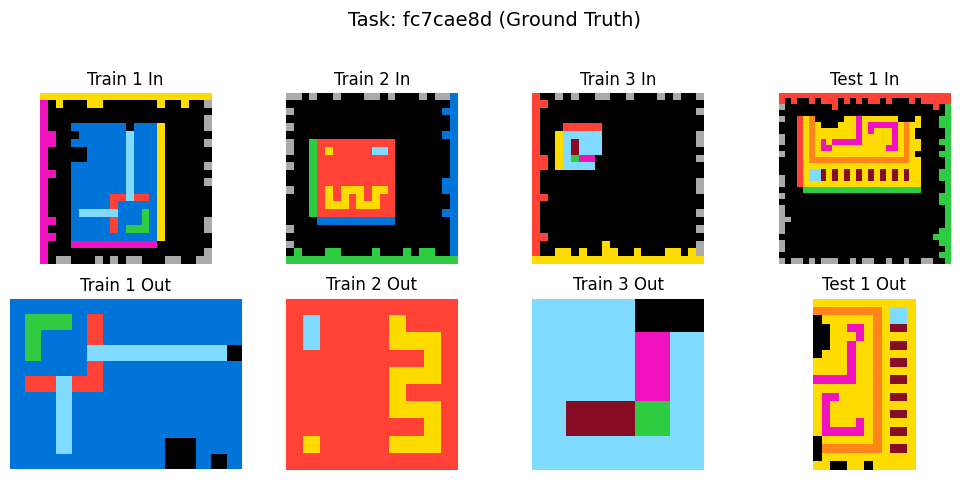


--- LLM Prediction Visualization (Task: fc7cae8d / Test: 0) ---


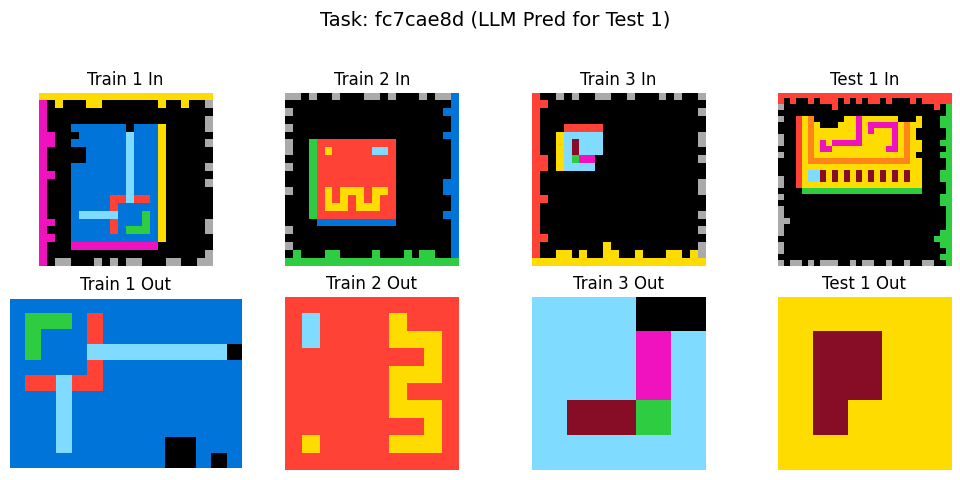

Prediction Correctness: Incorrect (Reason: Shape Mismatch ((5, 5) vs (20, 12)))


In [159]:
# CELL 9 Code

import concurrent.futures
import time
from collections import defaultdict
import copy # Needed for deepcopy

# --- Benchmarking Configuration ---
MAX_CONCURRENT_REQUESTS = 50
MODEL_NAME_BENCHMARK = 'gpt-4o'
BENCHMARK_TASK_LIMIT = None # Limit to 5 tasks for quicker benchmark testing
# --- End Configuration ---

# --- Main Benchmark Execution ---

print(f"\n--- Starting Benchmark ---")
print(f"Model: {MODEL_NAME_BENCHMARK}")
print(f"Max Concurrent Requests: {MAX_CONCURRENT_REQUESTS}")

tasks_to_process_dict = all_task_data
if BENCHMARK_TASK_LIMIT is not None and BENCHMARK_TASK_LIMIT < len(all_task_data):
    print(f"Limiting benchmark to first {BENCHMARK_TASK_LIMIT} loaded tasks.")
    tasks_to_process_dict = dict(list(all_task_data.items())[:BENCHMARK_TASK_LIMIT])

print(f"Tasks to process: {len(tasks_to_process_dict)}")

start_time = time.time()
results = [] # Store the detailed result dictionaries
total_test_cases = 0
jobs_to_submit = []

# 1. Prepare all jobs (test cases)
if not tasks_to_process_dict:
     print("\033[91mNo tasks loaded or selected for benchmark. Exiting.\033[0m")
else:
    for task_id, task_data in tasks_to_process_dict.items():
        if 'train' not in task_data or 'test' not in task_data or not task_data.get('test'):
             continue # Skip invalid tasks silently during benchmark prep

        num_test_cases = len(task_data['test'])
        for i in range(num_test_cases):
            jobs_to_submit.append({
                "task_id": task_id,
                "test_index": i,
                "all_tasks": all_task_data,
                "model_name": MODEL_NAME_BENCHMARK,
                "system_prompt": SYSTEM_PROMPT_TEMPLATE,
                "user_prompt_template": USER_PROMPT_TEMPLATE,
                "print_details": False # Disable printing during benchmark runs
            })
            total_test_cases += 1

    print(f"Total test cases to process: {total_test_cases}")

    # 2. Execute jobs in parallel using the function from cell 8
    processed_count = 0
    if total_test_cases > 0:
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_CONCURRENT_REQUESTS) as executor:
            future_to_job_info = {
                executor.submit(run_and_evaluate_single_test_case, **job): job
                for job in jobs_to_submit
            }

            for future in concurrent.futures.as_completed(future_to_job_info):
                job_submitted = future_to_job_info[future]
                task_id = job_submitted['task_id']
                test_index = job_submitted['test_index']
                try:
                    result = future.result()
                    if result:
                        results.append(result)
                    else:
                        # Record critical failure
                        print(f"\n\033[91mCritical Error (returned None) processing task {task_id}, test {test_index}\033[0m")
                        results.append({
                           "task_id": task_id, "test_index": test_index, "predicted_grid": None,
                           "ground_truth": None, "is_correct": False, "api_or_parse_failed": True,
                           "failure_reason": "Function Error", "raw_response": None, "task_data_dict": None
                        })

                except Exception as exc:
                    print(f"\n\033[91mException during future.result() for task {task_id}, test {test_index}: {exc}\033[0m")
                    results.append({
                        "task_id": task_id, "test_index": test_index, "predicted_grid": None,
                        "ground_truth": None, "is_correct": False, "api_or_parse_failed": True,
                        "failure_reason": f"Execution Exception: {exc}", "raw_response": None, "task_data_dict": None
                    })

                processed_count += 1
                print(f"Progress: {processed_count}/{total_test_cases} test cases completed.", end='\r')

    print(f"\nProgress: {processed_count}/{total_test_cases} test cases completed.")
    end_time = time.time()
    print(f"Benchmark finished in {end_time - start_time:.2f} seconds.")

    # 3. Evaluate Results (Aggregate counts)
    correct_test_cases = 0
    failed_api_parse_compare = 0 # Count critical failures
    task_results_summary = defaultdict(lambda: {'correct': 0, 'total': 0, 'failed_critical': 0, 'failed_eval': 0})
    failure_reasons_count = defaultdict(int)

    for result in results:
        task_id = result['task_id']
        task_results_summary[task_id]['total'] += 1
        if result.get('api_or_parse_failed', True): # Default to failed if key missing
            failed_api_parse_compare += 1
            task_results_summary[task_id]['failed_critical'] += 1
        elif not result.get('is_correct', False): # Default to incorrect
             task_results_summary[task_id]['failed_eval'] += 1
        elif result.get('is_correct', False):
            correct_test_cases += 1
            task_results_summary[task_id]['correct'] += 1

        # Count failure reasons if present
        reason = result.get('failure_reason')
        if reason:
            failure_reasons_count[reason] += 1

    tasks_solved = 0
    tasks_attempted = len(tasks_to_process_dict)

    for task_id, counts in task_results_summary.items():
        if counts['total'] > 0 and counts['failed_critical'] == 0 and counts['correct'] == counts['total']:
             tasks_solved += 1

    # 4. Print Final Summary
    print("\n--- Benchmark Final Summary ---")
    print(f"Tasks Attempted: {tasks_attempted}")
    print(f"Total Test Cases Processed: {total_test_cases}")
    print(f"Test Cases Correctly Solved: {correct_test_cases}")
    print(f"Test Cases Failed (API/Parse/Compare Error): {failed_api_parse_compare}")
    incorrect_eval_count = sum(counts['failed_eval'] for counts in task_results_summary.values())
    print(f"Test Cases Incorrect (Shape/Content Mismatch): {incorrect_eval_count}")


    if total_test_cases > 0:
        attempted_for_eval = total_test_cases - failed_api_parse_compare
        if attempted_for_eval > 0:
            test_case_success_rate = (correct_test_cases / attempted_for_eval) * 100
            print(f"\nTest Case Success Rate (Correct / Successfully Processed): {test_case_success_rate:.2f}%")
        else:
            print("\nTest Case Success Rate: N/A (All attempts failed processing)")

        overall_test_case_accuracy = (correct_test_cases / total_test_cases) * 100
        print(f"Overall Test Case Accuracy (Correct / Total): {overall_test_case_accuracy:.2f}%")

    print(f"\nTasks Solved (All Test Cases Correct & Processed): {tasks_solved}")
    if tasks_attempted > 0:
        task_success_rate = (tasks_solved / tasks_attempted) * 100
        print(f"Task Success Rate: {task_success_rate:.2f}%")
    else:
        print("Task Success Rate: N/A")

    print("\nFailure Reason Distribution:")
    if failure_reasons_count:
        for reason, count in sorted(failure_reasons_count.items()): # Sort for consistent output
            print(f"- {reason}: {count}")
    else:
        print("- No failures recorded.")


    # 5. Deferred Visualization and Detailed Output Phase
    print("\n\n--- Detailed Results & Visualization Phase ---")
    visualized_tasks_gt = set() # Track tasks for which GT has been shown

    # Sort results for potentially more logical output order
    results.sort(key=lambda x: (x['task_id'], x['test_index']))

    for result in results:
        task_id = result['task_id']
        test_index = result['test_index']
        predicted_grid = result['predicted_grid']
        task_data_dict_viz = result.get('task_data_dict')
        raw_response = result.get('raw_response', "N/A")
        failure_reason_viz = result.get('failure_reason', "Unknown")

        print(f"\n\n===== Task: {task_id} / Test Case: {test_index} =====")

        # Print Full LLM Response first
        print("\n--- Raw LLM Response ---")
        print(f"```\n{raw_response}\n```")

        if not task_data_dict_viz:
            print("\n\033[91mCannot visualize: Task data missing in results.\033[0m")
            continue

        # Visualize Ground Truth (only once per task)
        if task_id not in visualized_tasks_gt:
            print(f"\n--- Ground Truth Visualization (Task: {task_id}) ---")
            try:
                gt_outputs_viz = get_test_outputs(task_id, all_task_data)
                visualize_task(task_data_dict_viz,
                               task_solutions=gt_outputs_viz,
                               title=f"Task: {task_id} (Ground Truth)")
                visualized_tasks_gt.add(task_id)
            except Exception as e:
                print(f"\n\033[91mError during ground truth visualization for {task_id}: {e}\033[0m")
                visualized_tasks_gt.add(task_id) # Add even if failed to avoid retrying

        # Visualize LLM Prediction or print failure reason
        if predicted_grid is not None:
            print(f"\n--- LLM Prediction Visualization (Task: {task_id} / Test: {test_index}) ---")
            try:
                gt_outputs_viz = get_test_outputs(task_id, all_task_data) # Get GT again for context
                solutions_llm_viz = copy.deepcopy(gt_outputs_viz)
                if test_index < len(solutions_llm_viz):
                    solutions_llm_viz[test_index] = predicted_grid
                else:
                     print(f"\nWarning: Test index {test_index} out of bounds for LLM visualization of {task_id}")

                visualize_task(task_data_dict_viz,
                               task_solutions=solutions_llm_viz,
                               title=f"Task: {task_id} (LLM Pred for Test {test_index+1})")
                # Print correctness again for context with the image
                correct_str = "\033[92mCorrect\033[0m" if result.get('is_correct') else "\033[91mIncorrect\033[0m"
                print(f"Prediction Correctness: {correct_str} (Reason: {failure_reason_viz if not result.get('is_correct') else 'N/A'})")
            except Exception as e:
                 print(f"\n\033[91mError during LLM prediction visualization for {task_id}, test {test_index}: {e}\033[0m")
        else:
             # If no grid was parsed, print the failure reason instead of visualizing
             print(f"\n--- LLM Prediction (Task: {task_id} / Test: {test_index}) ---")
             print(f"\033[91mFailed to produce visualizable grid. Reason: {failure_reason_viz}\033[0m")

In [160]:
# CELL 10 Code (Failure Analysis)

from collections import defaultdict

print("\n--- Detailed Failure Analysis ---")

# Check if results exist from the benchmark cell
if 'results' not in locals() or not results:
    print("\nBenchmark results not found. Please run Cell 9 first.")
else:
    total_test_cases_analyzed = len(results)
    correct_cases_analyzed = 0
    critical_failures_analyzed = 0 # API, Parse, Compare, Data, Index errors
    incorrect_eval_analyzed = 0    # Shape or Content mismatch

    # Counters for specific failure reasons
    shape_mismatch_failures = 0
    content_mismatch_failures = 0
    no_llm_response_failures = 0
    parsing_failures = 0
    comparison_error_failures = 0
    other_critical_failures = 0 # Includes Data/Exec/Function/Index errors
    other_incorrect_failures = 0 # Unexpected reasons for incorrectness

    # Counters for shape accuracy analysis
    successfully_processed_cases = 0 # Cases where we got a parsable grid
    shape_correct_count = 0          # Cases among processed where shape matched GT

    for result in results:
        # Tally critical failures vs evaluation failures
        if result.get('api_or_parse_failed', True): # Default to True if key missing
            critical_failures_analyzed += 1
            reason = result.get('failure_reason', "Unknown Critical")
            # Categorize critical failures
            if reason == "No LLM Response":
                no_llm_response_failures += 1
            elif reason == "Parsing Failed":
                parsing_failures += 1
            elif reason == "Comparison Error":
                comparison_error_failures += 1
            # Group other critical errors (Data, Index, Exec)
            elif "Invalid Test Index" in reason or "Task Data Error" in reason or "Function Error" in reason or "Execution Exception" in reason:
                 other_critical_failures += 1
            else: # Catch any other unexpected critical failure reason
                 other_critical_failures += 1
        else:
            # If not critically failed, it was successfully processed
            successfully_processed_cases += 1
            reason = result.get('failure_reason') # Can be None if correct

            # Check if the shape was correct (even if content was wrong)
            # Shape mismatch is the only reason shape would be incorrect *after* successful processing
            if reason and "Shape Mismatch" in reason:
                shape_mismatch_failures += 1
                # Shape was incorrect
            else:
                shape_correct_count += 1 # Shape was correct (or comparison failed before shape check)

            # Now analyze correctness among successfully processed cases
            if result.get('is_correct', False):
                correct_cases_analyzed += 1
            else:
                incorrect_eval_analyzed += 1
                # Categorize evaluation failures (already handled shape mismatch above)
                if reason == "Content Mismatch":
                    content_mismatch_failures += 1
                elif reason and "Shape Mismatch" in reason:
                    pass # Already counted
                else: # Any other reason for incorrectness after successful processing
                    other_incorrect_failures += 1


    # --- Print Analysis ---
    print(f"\nTotal Test Cases Analyzed: {total_test_cases_analyzed}")
    print(f"Correct Cases: {correct_cases_analyzed} ({correct_cases_analyzed / total_test_cases_analyzed:.1%} of total)")

    print(f"\nCritically Failed Cases (API/Parse/Compare/Data/Index): {critical_failures_analyzed} ({critical_failures_analyzed / total_test_cases_analyzed:.1%} of total)")
    if critical_failures_analyzed > 0:
        print("  Breakdown of Critical Failures:")
        print(f"  - No LLM Response: {no_llm_response_failures} ({no_llm_response_failures / critical_failures_analyzed:.1%})")
        print(f"  - Parsing Failed: {parsing_failures} ({parsing_failures / critical_failures_analyzed:.1%})")
        print(f"  - Comparison Error (Numpy): {comparison_error_failures} ({comparison_error_failures / critical_failures_analyzed:.1%})")
        print(f"  - Other Critical (Data/Exec/Index...): {other_critical_failures} ({other_critical_failures / critical_failures_analyzed:.1%})")

    print(f"\nSuccessfully Processed Cases (Grid Parsed): {successfully_processed_cases} ({successfully_processed_cases / total_test_cases_analyzed:.1%} of total)")

    if successfully_processed_cases > 0:
         print(f"\nIncorrect Cases (among successfully processed): {incorrect_eval_analyzed} ({incorrect_eval_analyzed / successfully_processed_cases:.1%} of processed)")
         if incorrect_eval_analyzed > 0:
              print("  Breakdown of Incorrect Cases:")
              print(f"  - Shape Mismatch: {shape_mismatch_failures} ({shape_mismatch_failures / incorrect_eval_analyzed:.1%})")
              print(f"  - Content Mismatch (Shape OK): {content_mismatch_failures} ({content_mismatch_failures / incorrect_eval_analyzed:.1%})")
              if other_incorrect_failures > 0:
                   print(f"  - Other Incorrect Reasons: {other_incorrect_failures} ({other_incorrect_failures / incorrect_eval_analyzed:.1%})")

         # Shape Accuracy
         shape_accuracy = (shape_correct_count / successfully_processed_cases) * 100
         print(f"\nShape Accuracy (among successfully processed): {shape_correct_count}/{successfully_processed_cases} = {shape_accuracy:.1f}%")
    else:
        print("\nNo cases were successfully processed to analyze correctness or shape accuracy.")


--- Detailed Failure Analysis ---

Total Test Cases Analyzed: 172
Correct Cases: 0 (0.0% of total)

Critically Failed Cases (API/Parse/Compare/Data/Index): 24 (14.0% of total)
  Breakdown of Critical Failures:
  - No LLM Response: 0 (0.0%)
  - Parsing Failed: 15 (62.5%)
  - Comparison Error (Numpy): 9 (37.5%)
  - Other Critical (Data/Exec/Index...): 0 (0.0%)

Successfully Processed Cases (Grid Parsed): 148 (86.0% of total)

Incorrect Cases (among successfully processed): 148 (100.0% of processed)
  Breakdown of Incorrect Cases:
  - Shape Mismatch: 69 (46.6%)
  - Content Mismatch (Shape OK): 79 (53.4%)

Shape Accuracy (among successfully processed): 79/148 = 53.4%
